# pasta-stories

In [1]:
import json
import os
import re
import requests

from bs4 import BeautifulSoup
from datetime import date, datetime
import lxml.html
import pandas as pd
from pathlib import Path
from time import sleep
from tqdm import tqdm

# Get list of stories from listing files

In [2]:
class StoryListingsParser:
    """
    Container for methods parsing list-pages.
    """
    @classmethod
    def parse_listings_get_story_links_per_page(cls, listing_fpath):
        """
        Get list of links per listing_fpath

        listing_fpath: fpath to page_source from 
        https://www.creepypasta.com/archive/?_orderby=date
        example input:
        ./list-pages/2023-07-22__orderby=date&_page=29.html
        
        returns: list of links
        """
        file = open(listing_fpath, "r")
        page_html = file.read()
        file.close()

        soup = BeautifulSoup(page_html, "lxml")
        soup.title
        story_tags = soup.select("a.pt-cv-readmore")

        return [a["href"] for a in story_tags]
    
    @classmethod
    def get_all_story_links(cls, dir_path):        
        """
        Gets all files in dirpath directory and
        returns json-ready dict with story links by list page.
        
        dir_path: directory where multiple page_source files from
        https://www.creepypasta.com/archive/?_orderby=date

        example input:
        dir_path = "./list-pages/"

        ./list-pages/ dir contains:
        - '2023-07-22__orderby=date&_page=29.html'
        - '2023-07-22__orderby=date&_page=91.html'

        returns: json of all story links in a dict format
        example output:
        {{'2023-07-22__orderby=date&_page=29.html': 
            ['https://www.creepypasta.com/the-scariest-story-ever/',
             'https://www.creepypasta.com/windows-and-notes/'],
        '2023-07-22__orderby=date&_page=91.html': 
            ['https://www.creepypasta.com/three-friends-diner/',
             'https://www.creepypasta.com/written-in-the-stars/',
             'https://www.creepypasta.com/monster-painter/',
             'https://www.creepypasta.com/a-moment-of-horror/']}} 
        """
        
        # Get all files in listings directory
        files_list = PageFetcherUtils.get_all_files(dir_path)
        
        all_story_links = {}

        for fpath in files_list:
            if fpath == ".DS_Store":
                continue
            all_story_links[fpath] = cls.parse_listings_get_story_links_per_page(f"{dir_path}{fpath}")

        return all_story_links
    
    @classmethod
    def write_json_of_story_links_dicts(cls, dir_path):
        """
        Gets all story links using `get_all_story_links`.
        Creates JSON file using `output_json`.
        
        dir_path: directory where multiple page_source files from
        https://www.creepypasta.com/archive/?_orderby=date

        example input:
        dir_path = "./list-pages/
        
        writes: json w/ get_all_story_links output (story links per page dicts)
        returns: name of new json filepath    
        """
        with open(f"./parsed-listings/{date.today()}_story_links.json", "w") as outfile:
            story_links_dict = cls.get_all_story_links(dir_path)
            json.dump(story_links_dict, outfile, sort_keys=True)
            return outfile.name

    @classmethod
    def output_json(cls, dir_path):
        # returns: name of new json filepath to use with CreepyPastaGetter
        # this is just a convenience function for the module
        return cls.write_json_of_story_links_dicts(dir_path)

In [3]:
class StoryListingsParserTestUnit:
    """
    Just a casual testing class.
    """
    @classmethod
    def test_parse_listings_get_story_links_per_page(cls, listing_fpath=None):
        example_listing_fpath = "./list-pages/2023-07-22__orderby=date&_page=29.html"
        listing_fpath = listing_fpath or example_listing_fpath
        story_links_dict = StoryListingsParser.parse_listings_get_story_links_per_page(listing_fpath)
        return story_links_dict
    
    @classmethod
    def test_get_all_story_links(cls, dir_path=None):
        example_dir_path = "./list-pages/"
        dir_path = dir_path or example_dir_path
        return StoryListingsParser.get_all_story_links(dir_path)
    
    @classmethod
    def test_write_json_of_story_links_dicts(cls, dir_path=None):
        example_dir_path = "./list-pages/"
        dir_path = dir_path or example_dir_path
        return StoryListingsParser.output_json(dir_path)

## Get Stories

In [9]:
class PageFetcherUtils:
    """
    General utils non-specific to Creepypasta.
    """
    @classmethod
    def fetch_page(cls, url):
        """
        Needed to get ratings/reviews that are live-loaded on site.
        """
        ident = (
        # replace with info
        "Stephanie Andrews (jellomoat@gmail.com), " + 
        "scraping for educational purposes"
        )
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
        }

        print(f"Fetching {url}")
        return requests.get(
            url,
            headers=headers
        )
    
    @classmethod
    def get_html(cls, fpath):
        """
        Opens and reads file to HTML.
        
        `fpath`: path to file with saved `page_source`
        """
        file = open(fpath, "r")
        page_html = file.read()
        file.close()
        return page_html

    @classmethod
    def get_all_files(cls, dir_path, debug=False):
        """
        Lists all files in specified directory.
        
        `dir_path`: path to target directory
        """
        dir_list = os.listdir(dir_path)

        if debug:
            print("Files and directories in '", path, "' :")
            print(dir_list)
        return dir_list

In [10]:
class CreepyPastaGetter:
    """
    Gets/fetches stories from site.
    """
    @classmethod
    def get_stories_list_dict(cls, stories_list_fpath):
        """
        Opens and loads JSON file to dict.
        
        `stories_list_fpath`: path to JSON file
        """
        
        with open(stories_list_fpath, "r") as stories_list_file:
            return json.load(stories_list_file)
    
    @classmethod
    def fetch_pasta_pages(cls, list_page, links_list):
        """
        Using a list of links, finds/fetches story pages and writes to disk.
        Logs fetching history using `story_writing_log`.

        `list_page`: specific page # of the Creepypasta site archive
        `links_list`: links on that page to retrieve
        """
        # fetch each page
        for link in links_list:
            dest = Path("story-pages/" + f"published_stories_{link.split('/')[-2]}.html")
            if dest.exists(): # load it from file
                print(f"Already have {dest}, loading!")
                file = open(dest, "r")
                page_html = file.read()
                file.close()
            else: # fetch it!
                page_resp = PageFetcherUtils.fetch_page(link)
                page_html = page_resp.text
                sleep(2)

                # save to file
                with open(dest, "w") as f:
                    f.write(page_html)
                cls.story_writing_log(listing_fname=list_page, dest_fname=dest)

        return None

    @classmethod
    def error_writing_log(cls, exception, listing_fname="testing", dest_fname="testing", logname="error_log"):
        with open(f"{date.today()}_{logname}.txt", "a") as f:
            f.write(f"{listing_fname}, {dest_fname}\n")

    @classmethod
    def story_writing_log(cls, listing_fname="testing", dest_fname="testing", logname="stories_log"):
        with open(f"{date.today()}_{logname}.txt", "a") as f:
            f.write(f"{listing_fname}, {dest_fname}\n")

In [11]:
class CreepyPastaGetterTestUnit:
    """
    Casual testing unit for `CreepyPastaGetter`.
    """
    @classmethod
    def test_fetch_pasta_pages(cls):
        # fetch per list-pages file, replace params
        CreepyPastaGetter.fetch_pasta_pages(
            list_page="test-list-page", 
            links_list=CreepyPastaSoupParserTestUnit.links_list)    

In [15]:
CreepyPastaGetterTestUnit.test_fetch_pasta_pages()

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!


### Running for reals (not test)

In [16]:
stories_list_fpath = './parsed-listings/2023-07-26_story_links.json'
# filepath is output from StoryListingsParser

stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

for k in stories_list_dict.keys():
    CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
    # break after one round if test
    # break

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_alone.html, loading!
Already have story-pages/published_stories_fresh-faces.html, loading!
Already have story-pages/published_stories_silence.html, loading!
Already have story-pages/published_stories_eleveneleven.html, loading!
Already have story-pages/published_stories_arthur.html, loading!
Already have story-pages/published_stories_mr-welldone.html, loading!
Already have story-pages/published_stories_the-library.html, loading!
Already have story-pages/published_stories_the-naera.html, loading!
Already have story-pages/published_stories_memory-lane.html, loading!
Already have story-pages/published_stories_wounds.html, loading!
Already have story-pages/published_stories_the-other-side-of-the-door.html, loading!
Already have story-pages/published_stories_the-last-laugh.html, loading!
Already have story-pages/published_stories_31080-2.html, loading!
Already have story-pages/published_stories_the-leshy.html, loading!
Already have story-pages/publ

Already have story-pages/published_stories_wanna-play.html, loading!
Already have story-pages/published_stories_we-thought-you-knew.html, loading!
Already have story-pages/published_stories_the-tracks-to-nowhere.html, loading!
Already have story-pages/published_stories_fireflies.html, loading!
Already have story-pages/published_stories_eli-foster.html, loading!
Already have story-pages/published_stories_darkstar.html, loading!
Already have story-pages/published_stories_why-i-killed-my-father.html, loading!
Already have story-pages/published_stories_mr-scant.html, loading!
Already have story-pages/published_stories_anhedonius.html, loading!
Already have story-pages/published_stories_ones-diary.html, loading!
Already have story-pages/published_stories_tappy-crow-calling-crows.html, loading!
Already have story-pages/published_stories_im-where-i-should-be.html, loading!
Already have story-pages/published_stories_the-first-of-the-three.html, loading!
Already have story-pages/published_stori

Already have story-pages/published_stories_terms-and-conditions.html, loading!
Already have story-pages/published_stories_run-across-the-desert.html, loading!
Already have story-pages/published_stories_creep.html, loading!
Already have story-pages/published_stories_quiet-friday-evening.html, loading!
Already have story-pages/published_stories_man-hands-scream.html, loading!
Already have story-pages/published_stories_the-good-father.html, loading!
Already have story-pages/published_stories_late-night-metal.html, loading!
Already have story-pages/published_stories_amber-alert.html, loading!
Already have story-pages/published_stories_swimming-pool.html, loading!
Already have story-pages/published_stories_beta.html, loading!
Already have story-pages/published_stories_an-open-letter-to-my-best-friend.html, loading!
Already have story-pages/published_stories_missing-time.html, loading!
Already have story-pages/published_stories_not-enter-9-twin-lakes-road.html, loading!
Already have story-pa

Already have story-pages/published_stories_nightmarish-realities.html, loading!
Already have story-pages/published_stories_the-likho.html, loading!
Already have story-pages/published_stories_the-moors.html, loading!
Already have story-pages/published_stories_11-bodies-hanging-from-21-trees.html, loading!
Already have story-pages/published_stories_hands.html, loading!
Already have story-pages/published_stories_floor-zero.html, loading!
Already have story-pages/published_stories_northern-lights.html, loading!
Already have story-pages/published_stories_the-backrooms.html, loading!
Already have story-pages/published_stories_my-sisters-hair.html, loading!
Already have story-pages/published_stories_zero-sum.html, loading!
Already have story-pages/published_stories_beach.html, loading!
Already have story-pages/published_stories_the-deef.html, loading!
Already have story-pages/published_stories_mister-smiley.html, loading!
Already have story-pages/published_stories_the-thing-that-will-kill-me.

Already have story-pages/published_stories_snap.html, loading!
Already have story-pages/published_stories_exorcisms.html, loading!
Already have story-pages/published_stories_lucid-dreamer.html, loading!
Already have story-pages/published_stories_the-bay-of-kola.html, loading!
Already have story-pages/published_stories_sever-the-cord.html, loading!
Already have story-pages/published_stories_chemical.html, loading!
Already have story-pages/published_stories_forgotten.html, loading!
Already have story-pages/published_stories_her.html, loading!
Already have story-pages/published_stories_candle-cove.html, loading!
Already have story-pages/published_stories_enclosing.html, loading!
Already have story-pages/published_stories_yeah-so-quit-asking.html, loading!
Already have story-pages/published_stories_in-from-the-cold.html, loading!
Already have story-pages/published_stories_chicken-dinner.html, loading!
Already have story-pages/published_stories_eternal-dream.html, loading!
Already have stor

Already have story-pages/published_stories_the-night-wire.html, loading!
Already have story-pages/published_stories_a-moments-clarity.html, loading!
Already have story-pages/published_stories_inspiration.html, loading!
Already have story-pages/published_stories_julia-legare.html, loading!
Already have story-pages/published_stories_the-prophecy-of-zarah.html, loading!
Already have story-pages/published_stories_the-gun-game.html, loading!
Already have story-pages/published_stories_out-in-the-woods.html, loading!
Already have story-pages/published_stories_from-hell-i-write.html, loading!
Already have story-pages/published_stories_the-devils-toy-box.html, loading!
Already have story-pages/published_stories_full-size-candy-bars.html, loading!
Already have story-pages/published_stories_too-early-to-trick-or-treat.html, loading!
Already have story-pages/published_stories_a-halloween-monster.html, loading!
Already have story-pages/published_stories_my-last-halloween.html, loading!
Already have

Already have story-pages/published_stories_coffee-man.html, loading!
Already have story-pages/published_stories_the-tower-of-abhorred-flesh.html, loading!
Already have story-pages/published_stories_the-salted-earth.html, loading!
Already have story-pages/published_stories_lupus.html, loading!
Already have story-pages/published_stories_for-the-animals.html, loading!
Already have story-pages/published_stories_what-we-found-beneath-the-great-sphinx-of-giza.html, loading!
Already have story-pages/published_stories_the-scariest-conspiracy-theories-of-all-time-that-freak-people-out.html, loading!
Already have story-pages/published_stories_devils-sicario.html, loading!
Already have story-pages/published_stories_dollars-and-common-sense.html, loading!
Already have story-pages/published_stories_i-am-an-irish-ghost-hunter-my-last-investigation-almost-cost-me-everything.html, loading!
Already have story-pages/published_stories_from-where-it-came.html, loading!
Already have story-pages/published_s

Already have story-pages/published_stories_the-edwardsville-lottery.html, loading!
Already have story-pages/published_stories_i-joined-a-hedonistic-cult-in-the-80s-its-time-to-pay-my-membership-fee.html, loading!
Already have story-pages/published_stories_what-happens-at-dillerson-farm.html, loading!
Already have story-pages/published_stories_i-made-a-computer-program-to-predict-the-apocalypse-its-not-what-you-think.html, loading!
Already have story-pages/published_stories_the-trees.html, loading!
Already have story-pages/published_stories_bread-and-circuses.html, loading!
Already have story-pages/published_stories_ive-travelled-to-parallel-universes-the-worlds-ive-seen-are-terrifying-part-2.html, loading!
Already have story-pages/published_stories_shelter.html, loading!
Already have story-pages/published_stories_peter-squid-billy.html, loading!
Already have story-pages/published_stories_my-school-thought-it-was-a-serial-killer-they-were-wrong.html, loading!
Already have story-pages/pu

Already have story-pages/published_stories_a-shadow-in-the-woods.html, loading!
Already have story-pages/published_stories_faces-in-the-pumpkins.html, loading!
Already have story-pages/published_stories_7-best-sports-themed-costumes-for-halloween.html, loading!
Already have story-pages/published_stories_halloween-mirrors.html, loading!
Already have story-pages/published_stories_chthonic-candles.html, loading!
Already have story-pages/published_stories_the-polaroid-camera.html, loading!
Already have story-pages/published_stories_dont-answer-the-door-at-9pm-on-halloween.html, loading!
Already have story-pages/published_stories_nights-of-fear.html, loading!
Already have story-pages/published_stories_a-childhood-phone-number.html, loading!
Already have story-pages/published_stories_the-beauty-of-death.html, loading!
Already have story-pages/published_stories_the-bag.html, loading!
Already have story-pages/published_stories_poppys-peril.html, loading!
Already have story-pages/published_stor

Already have story-pages/published_stories_the-mannequin.html, loading!
Already have story-pages/published_stories_liars.html, loading!
Already have story-pages/published_stories_altera-militiae-in-anti-christe.html, loading!
Already have story-pages/published_stories_ted-the-caver.html, loading!
Already have story-pages/published_stories_is-it-dangerous.html, loading!
Already have story-pages/published_stories_dirt.html, loading!
Already have story-pages/published_stories_the-russian-sleep-experiment.html, loading!
Already have story-pages/published_stories_the-creak-of-the-door.html, loading!
Already have story-pages/published_stories_the-haunted-marotte.html, loading!
Already have story-pages/published_stories_the-inigma.html, loading!
Already have story-pages/published_stories_annabee.html, loading!
Already have story-pages/published_stories_stalked.html, loading!
Already have story-pages/published_stories_new-city-village.html, loading!
Already have story-pages/published_stories_t

Already have story-pages/published_stories_the-screaming-woman.html, loading!
Already have story-pages/published_stories_the-indigo-village.html, loading!
Already have story-pages/published_stories_the-impervious.html, loading!
Already have story-pages/published_stories_theyre-coming-for-me.html, loading!
Already have story-pages/published_stories_fortunately-unfortunate.html, loading!
Already have story-pages/published_stories_to-die-to-sleep.html, loading!
Already have story-pages/published_stories_mr-entropy.html, loading!
Already have story-pages/published_stories_he-leads-them.html, loading!
Already have story-pages/published_stories_club-love.html, loading!
Already have story-pages/published_stories_susan.html, loading!
Already have story-pages/published_stories_nightmares-are-reality.html, loading!
Already have story-pages/published_stories_hide-2.html, loading!
Already have story-pages/published_stories_droning.html, loading!
Already have story-pages/published_stories_interfere

Already have story-pages/published_stories_the-story-of-her-holding-an-orange-part-six-link-to-the-end.html, loading!
Already have story-pages/published_stories_poisoned-oak-the-sacred-grove.html, loading!
Already have story-pages/published_stories_fenter-woods.html, loading!
Already have story-pages/published_stories_never-trust-the-quiet-ones.html, loading!
Already have story-pages/published_stories_the-custodian.html, loading!
Already have story-pages/published_stories_take-the-four-thirty-six.html, loading!
Already have story-pages/published_stories_miracle-city-iii-the-doomed-journey.html, loading!
Already have story-pages/published_stories_good-night-good-bye.html, loading!
Already have story-pages/published_stories_the-girl-3.html, loading!
Already have story-pages/published_stories_the-puppet-masters-prayer.html, loading!
Already have story-pages/published_stories_the-two-figurines.html, loading!
Already have story-pages/published_stories_how-to-succeed-in-publishng-without-rea

Already have story-pages/published_stories_ghosts-of-yesteryear-mugsy-grey.html, loading!
Already have story-pages/published_stories_the-staircase-ritual.html, loading!
Already have story-pages/published_stories_face-your-fears.html, loading!
Already have story-pages/published_stories_all-monsters-are-human.html, loading!
Already have story-pages/published_stories_dont-ever-let-them-in.html, loading!
Already have story-pages/published_stories_early-from-work.html, loading!
Already have story-pages/published_stories_all-he-wants.html, loading!
Already have story-pages/published_stories_born-dead-2.html, loading!
Already have story-pages/published_stories_i-sleep-to-communicate.html, loading!
Already have story-pages/published_stories_the-devils-jaws.html, loading!
Already have story-pages/published_stories_brachs-candy-factory.html, loading!
Already have story-pages/published_stories_welcome-to-sandalwood.html, loading!
Already have story-pages/published_stories_the-music-box.html, load

Already have story-pages/published_stories_splendor-man.html, loading!
Already have story-pages/published_stories_kill-killers-parody.html, loading!
Already have story-pages/published_stories_brainstorm.html, loading!
Already have story-pages/published_stories_3-ply.html, loading!
Already have story-pages/published_stories_people.html, loading!
Already have story-pages/published_stories_noises-2.html, loading!
Already have story-pages/published_stories_hinges.html, loading!
Already have story-pages/published_stories_wolf-blade.html, loading!
Already have story-pages/published_stories_mary-2.html, loading!
Already have story-pages/published_stories_lake-erie.html, loading!
Already have story-pages/published_stories_missing-teeth.html, loading!
Already have story-pages/published_stories_snow.html, loading!
Already have story-pages/published_stories_demon-butcher-palos-park.html, loading!
Already have story-pages/published_stories_puzzle-ball.html, loading!
Already have story-pages/publis

Already have story-pages/published_stories_the-devils-cosmonaut.html, loading!
Already have story-pages/published_stories_mirrors-2.html, loading!
Already have story-pages/published_stories_the-warning.html, loading!
Already have story-pages/published_stories_the-holder-of-many.html, loading!
Already have story-pages/published_stories_her-eyes.html, loading!
Already have story-pages/published_stories_routine-2.html, loading!
Already have story-pages/published_stories_ashen.html, loading!
Already have story-pages/published_stories_kelpie.html, loading!
Already have story-pages/published_stories_no-body-no-crime-a-cheery-holiday-tale.html, loading!
Already have story-pages/published_stories_bright-eyes.html, loading!
Already have story-pages/published_stories_its-the-little-things.html, loading!
Already have story-pages/published_stories_the-advent-calendar.html, loading!
Already have story-pages/published_stories_not-afraid-of-the-dark.html, loading!
Already have story-pages/published_s

Already have story-pages/published_stories_hatman.html, loading!
Already have story-pages/published_stories_barricade.html, loading!
Already have story-pages/published_stories_the-photographs.html, loading!
Already have story-pages/published_stories_eye-contact.html, loading!
Already have story-pages/published_stories_happy-thirty-third-birthday.html, loading!
Already have story-pages/published_stories_chiasma.html, loading!
Already have story-pages/published_stories_ancestral-memories.html, loading!
Already have story-pages/published_stories_projections.html, loading!
Already have story-pages/published_stories_men-imitating-things.html, loading!
Already have story-pages/published_stories_crying-numbers.html, loading!
Already have story-pages/published_stories_help-needed.html, loading!
Already have story-pages/published_stories_beside-mind.html, loading!
Already have story-pages/published_stories_skin.html, loading!
Already have story-pages/published_stories_mr-wiggles.html, loading!


# Parse Stories w/ CreepyPastaSoupParser

In [17]:
class CreepyPastaSoupParser:
    """
    Methods for parsing individual stories and all stories.
    """
    def __init__(self, fpath_or_link, is_fpath=True):
        self.fpath_or_link = fpath_or_link
        self.soup = self.get_soup(is_fpath)
        self.title = self.soup.title.string

    def get_soup(self, is_fpath):
        if is_fpath:
            page_html = PageFetcherUtils.get_html(self.fpath_or_link)
        else:
            page_html = PageFetcherUtils.fetch_page(self.fpath_or_link).text
        return BeautifulSoup(page_html, "lxml")
        
    def parse_story(self):
        parsed_story_dict = {}
        parsed_story_dict["title"] = self.title
        parsed_story_dict["link"] = self.story_link
        parsed_story_dict["date_str"] = self.published_date
        parsed_story_dict["story_text"], parsed_story_dict["author_str"] = self.__get_story_and_author_content()
        parsed_story_dict["reading_time_min"] = self.reading_time_min
        parsed_story_dict["story_cats"] = self.soup.find_all(self.__get_categories)
        parsed_story_dict["story_tags"] = self.soup.find_all(self.__get_tags)
        parsed_story_dict["story_uuid"] = self.story_uuid
        parsed_story_dict["story_rating"], parsed_story_dict["story_votes"] = self.__class__.get_ratings_and_votes(self.story_uuid)
        return parsed_story_dict

    @property
    def story_link(self):
        return self.soup.find("link", {"rel": "canonical"})["href"]

    @property
    def story_uuid(self):
        return self.soup.select_one("article")["id"].strip("post-")

    @property
    def published_date(self):
        raw_date = self.soup.select_one("span.published").string.strip(" ")
        date_str = datetime.strftime(datetime.strptime(raw_date, "%B %d, %Y"), "%Y-%m-%d")
        return date_str

    @property
    def reading_time_min(self):
        reading_time_el = self.soup.select_one("span.rt-reading-time")
        reading_time_raw_unit = reading_time_el.select_one("span.rt-postfix").string
        reading_time_raw_unit

        reading_time_raw = reading_time_el.select_one("span.rt-time").string.strip(" ")
        if (re.search(r"\D", reading_time_raw)):
            return 0.5 # stand-in for < 1 min
        reading_time_min = int(reading_time_raw) if re.search(r"minutes*", reading_time_raw_unit) else int(reading_time_raw * 60)
        return reading_time_min

    @property
    def story_content(self):
        return self.__get_story_and_author_content()[0]
    
    @property
    def author_content(self):
        return self.__get_story_and_author_content()[1]

    def __get_story_and_author_content(self):
        entry_content = self.soup.select('div.entry-content > p')
        if (len(entry_content) > 1) and hasattr(entry_content[-1], "text"):
            if "credit" in entry_content[-1].text.lower():
                story_content, author_str = entry_content[:-1], entry_content[-1].text
            else:
                story_content, author_str = entry_content, None
        else:
            if (len(entry_content) > 1) and "credit" in entry_content[-1].string.lower():
                story_content, author_str = entry_content[:-1], entry_content[-1].string
            else:
                story_content, author_str = entry_content, None  

        story_content = [(re.sub("<p>", "", p.text)) for p in story_content]

        if author_str:
            new_raw_author_regex = r"Credit[ed]*\s*[to]*\s*:*\s*([\w\s.]*\d*)\.*"
            wiki_user_author_regex = r"User:([a-z0-9]*)"
#             combined_regex = r"User:([a-z0-9]*)|Credit[ed]*\s*[to]*\s*:*\s*([\w\s.]*\d*)\.*"
            author_str_1 = re.search(
                new_raw_author_regex,
                author_str,
                re.IGNORECASE)
            author_str_2 = re.search(
                wiki_user_author_regex,
                author_str,
                re.IGNORECASE)
            author_str = author_str_1 or author_str_2
            author_str = author_str.group(1)
        return story_content, author_str

    def __get_categories(self, tag):
        return tag.has_attr('href') \
            and re.search(r"category", tag["href"]) \
            and not re.search(r"archive", tag["href"])

    def __get_tags(self, tag):
        return tag.has_attr('href') \
            and re.search(r"tag", tag["href"]) \
            and not re.search(r"instagram", tag["href"])

    ### BeautifulSoup for Ratings and Reviews
    ### NEED TO USE UNDOC API
    @classmethod
    def get_ratings_and_votes(cls, story_uuid):
        request_args = {
            "headers": {
                'authority': 'www.creepypasta.com',
                'accept': 'application/json, text/javascript, */*; q=0.01',
                'accept-language': 'en-US,en;q=0.9',
                'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
                'origin': 'https://www.creepypasta.com',
                'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
                'sec-ch-ua-mobile': '?1',
                'sec-ch-ua-platform': '"Android"',
                'sec-fetch-dest': 'empty',
                'sec-fetch-mode': 'cors',
                'sec-fetch-site': 'same-origin',
                'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
                'x-requested-with': 'XMLHttpRequest',
            },
            "params": {
                'action': 'gdrts_live_handler',
            }
        }
    
        response = requests.post(
            'https://www.creepypasta.com/wp-admin/admin-ajax.php',
            params=request_args["params"],
            headers=request_args["headers"],
            data=cls.__get_data_arg(story_uuid),
        )

        rating_regex_2 = r"<strong>([0-9\.]*)<\/strong>\/10\.*\s*From\s*([0-9]*.*[0-9]*K*)\s*votes."
        rating_render_text = response.json()["items"][0]["render"]
        rating_groups = re.search(rating_regex_2, rating_render_text, flags=re.IGNORECASE)
        avg_rating, num_votes = rating_groups.group(1).strip(), rating_groups.group(2).strip()
        if "k" in num_votes.lower():
            num_votes_groups = re.search(r"([0-9]*\.*[0-9]*)\S*\s*K", num_votes, flags=re.IGNORECASE)
            num_votes = int(float(num_votes_groups.group(1)) * 1000) if num_votes_groups else num_votes

        print(f"avg rating: {avg_rating}/10, num votes: {num_votes}")

        return avg_rating, str(num_votes).strip()

    @classmethod
    def __get_data_arg(cls, story_id):
        data = {
            'req': '{"todo":"dynamic","items":[{"args":{"echo":false,"entity":"posts","name":"post","item_id":0,"id":' 
                + str(story_id) 
                + ',"method":"stars-rating","series":null},"method":{"votes_count_compact_show":true,"votes_count_compact_decimals":"2","cta":"","distribution":"normalized","rating":"average","style_name":"star", "labels":[]},"did":1},{"args":{"echo":false,"entity":"posts","name":"post","item_id":null,"id":' + str(story_id) + ',"method":"stars-rating","series":null,"disable_dynamic_load":false,"dynamic":true},"method":{"votes_count_compact_show":true,"votes_count_compact_decimals":"2","cta":"","distribution":"normalized","rating":"average","labels":[]},"did":2}]}'
        }
        return data
    
    @classmethod
    def get_all_stories(cls, stories_path = "./story-pages/"):
        # stories_path (default): './story-pages/' from CreepyPastaGetter
        stories_dicts = []
        parsed_count = 0
        error_count = 0
        for fpath in tqdm(PageFetcherUtils.get_all_files(stories_path)):
            if fpath == ".DS_Store":
                continue
            try:
                stories_dicts.append(CreepyPastaSoupParser(stories_path + fpath).parse_story())
                # for debugging, check log
                CreepyPastaGetter.story_writing_log(listing_fname=parsed_count, dest_fname=fpath, logname="parse_ok")
                parsed_count += 1
            except BaseException as e:
                CreepyPastaGetter.error_writing_log(e, error_count, fpath)
                error_count += 1
        return stories_dicts

In [18]:
class CreepyPastaSoupParserTestUnit:
    test_files = [
        "./story-pages/published_stories_contamination.html",
        "./story-pages/published_stories_theo-twining.html",
        "./story-pages/published_stories_holder-of-eternity.html",
        "./story-pages/published_stories_the-kaleidoscope.html",
        "./story-pages/published_stories_the-town-of-blanche.html",
    ]
    links_list = [
        "https://www.creepypasta.com/contamination/",
        "https://www.creepypasta.com/holder-of-eternity/",
        "https://www.creepypasta.com/theo-twining/",
    ]
    
    @classmethod
    def test_parser_href(cls):
        parser = CreepyPastaSoupParser("https://www.creepypasta.com/gift-of-old/", is_fpath=False)
        return parser.parse_story()

    @classmethod
    def test_parser_fpath(cls):
        import random

        parser = CreepyPastaSoupParser(random.choice(cls.test_files), is_fpath=True)
        return parser.parse_story()
    
    @classmethod
    def test_parser_property(cls):
        import random

        parser = CreepyPastaSoupParser(random.choice(cls.test_files), is_fpath=True)
        return parser.published_date

In [19]:
CreepyPastaSoupParserTestUnit.test_parser_fpath()

avg rating: 7.63/10, num votes: 318


{'title': 'Holder of Eternity - Creepypasta',
 'link': 'https://www.creepypasta.com/holder-of-eternity/',
 'date_str': '2008-09-28',
 'story_text': ['In any city, in any country, go to any mental institution or you can get yourself to. When you reach the front desk, ask to visit someone who calls himself “The Holder of Eternity”. A sigh might escape the worker as they look upon you with the utmost pity. They will take you down a flight of stairs into what should be the basement of the building, and yet isn’t.',
  'As you press deeper and deeper into this under layer of the institution a chorus of screams will begin to be audible. Softly at first, as if from a great distance, but the closer you get to the end of the hallway, the louder it becomes until it drones so loud that it seems to consume all other noises, until you begin to claw at your own ears in pain. The worker will show you a door, covering both their ears. As swift as they can, they will unlock the door and run, leaving onl

In [20]:
CreepyPastaSoupParserTestUnit.test_parser_href()

Fetching https://www.creepypasta.com/gift-of-old/
avg rating: 6.82/10, num votes: 62


{'title': 'Gift of Old - Creepypasta',
 'link': 'https://www.creepypasta.com/gift-of-old/',
 'date_str': '2023-07-11',
 'story_text': ['A young, dark blond woman with a backpack checked the list of stores in her hand. Of the seven names, she crossed out four. She checked her phone for directions to the antique store Gifts of Old. She put her phone away and read the back of the paper, a set of instructions she should follow if she ever encountered a demon or spirit. Never tell them your name. Always say goodbye. Keep your words short and to the point, or they’ll manipulate what you say. Do not accept any offers.',
  'The young woman pulled a picture of her and another blond woman out of her bag. She pressed it to her heart, then tucked it away. A bell rang as she pushed the antique store’s door open. A woman at the counter shifted her gaze from the objects before her to the new customer.',
  'The store owner stood up straighter as the woman approached. “Good morning.” The store clerk sp

In [21]:
CreepyPastaSoupParserTestUnit.test_parser_property()

'2008-09-29'

In [22]:
# testing parser for a single weirdly-formatted story
CreepyPastaSoupParser("story-pages/published_stories_best-horror-themed-slot-machines.html").parse_story()

avg rating: 1.54/10, num votes: 28


{'title': 'Best Horror Themed Slot Machines - Creepypasta',
 'link': 'https://www.creepypasta.com/best-horror-themed-slot-machines/',
 'date_str': '2021-02-03',
 'story_text': ['Online casinos have become hugely popular in recent times, and it’s easy to see why. They’re fun, accessible, easy to use, and so much more convenient than having to actually set aside time from your schedule to visit a brick and mortar casino location.',
  'With online casinos, you can simply load up your favorite site and start to play whenever you want. There are some amazing deals and promotions from njcasino that can help you get free spins and bonus cash too, and countless different slots to try out.',
  'Digital slot machines come in a wide variety of types, with their own icons, themes, color schemes, and styles. If you’re a horror fan, there are some terrific spooky slots and creepy games to try out, and we’ve put together a list of our favorites.',
  'Blood Suckers\xa0',
  'When it comes to horror-the

# Getting dataframe of stories, from dir_path to listing pages

In [23]:
def get_stories_from_listings_dirpath(dir_path="./list-pages/"):
    # get list of story links from path to directory with listings scraped 
    # from https://www.creepypasta.com/archive/?_orderby=date
    # example stories_list_fpath returned: './parsed-listings/2023-07-25_story_links.json'
    stories_list_fpath = StoryListingsParser.output_json(dir_path)

    # load json created above
    stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

    # for each listings file, get/fetch individual stories
    # TODO: returns a path to stories (currently returns none)
    for k in stories_list_dict.keys():
        CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
        # break after one round if test
        # break

    # stories_path to directory with individual story pages
    # returns list of dicts, one dict per story
    stories_path = "./story-pages/"
    all_stories_dict_list = CreepyPastaSoupParser.get_all_stories(stories_path)
    return all_stories_dict_list

# FINALLY

In [24]:
stories_dict_list = get_stories_from_listings_dirpath("./list-pages/")
# load into dataframe for analysis
stories_df = pd.DataFrame(stories_dict_list)
stories_df

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_barter.html, loading!
Already have story-pages/published_stories_visions-in-the-fog.html, loading!
Already have story-pages/published_stories_headspace.html, loading!
Already have story-pages/published_stories_rainman.html, loading!
Already have story-pages/published_stories_for-posterity.html, loading!
Already have story-pages/published_stories_campfire.html, loading!
Already have story-pages/published_stories_shadows-of-shallowbrooke-renewal-of-the-circle.html, loading!
Already have story-pages/published_stories_how-does-the-story-end.html, loading!
Already have story-pages/published_stories_the-light-in-the-window.html, loading!
Already have story-pages/published_stories_the-reappearance-of-carrie-mae.html, loading!
Already have story-pages/published_stories_the-girl-in-the-nightgown.html, loading!
Already have story-pages/published_stories_song-of-the-siren.html, loading!
Already have story-pages/published_stories_the-long-night.html, load

Already have story-pages/published_stories_to-befriend-the-diseased.html, loading!
Already have story-pages/published_stories_woods-past-dark.html, loading!
Already have story-pages/published_stories_dreams-blueish-tears.html, loading!
Already have story-pages/published_stories_between-the-lilies.html, loading!
Already have story-pages/published_stories_whats-inside.html, loading!
Already have story-pages/published_stories_madness-and-mockingbirds.html, loading!
Already have story-pages/published_stories_the-glass-cabinet.html, loading!
Already have story-pages/published_stories_twenty-fourth.html, loading!
Already have story-pages/published_stories_reminiscence.html, loading!
Already have story-pages/published_stories_amphitheater_tunnels.html, loading!
Already have story-pages/published_stories_haggards-peak.html, loading!
Already have story-pages/published_stories_magic-show-hell.html, loading!
Already have story-pages/published_stories_ed.html, loading!
Already have story-pages/pub

Already have story-pages/published_stories_beta.html, loading!
Already have story-pages/published_stories_an-open-letter-to-my-best-friend.html, loading!
Already have story-pages/published_stories_missing-time.html, loading!
Already have story-pages/published_stories_not-enter-9-twin-lakes-road.html, loading!
Already have story-pages/published_stories_reflections-of-the-majorette.html, loading!
Already have story-pages/published_stories_the-chair.html, loading!
Already have story-pages/published_stories_the-rose-of-dread-mother.html, loading!
Already have story-pages/published_stories_slithers.html, loading!
Already have story-pages/published_stories_the-nurse-in-black.html, loading!
Already have story-pages/published_stories_deep-mind.html, loading!
Already have story-pages/published_stories_white-room.html, loading!
Already have story-pages/published_stories_winters-storm.html, loading!
Already have story-pages/published_stories_pretty-lies.html, loading!
Already have story-pages/pub

Already have story-pages/published_stories_willow-men.html, loading!
Already have story-pages/published_stories_sibilance.html, loading!
Already have story-pages/published_stories_why-he-weeps.html, loading!
Already have story-pages/published_stories_get-help.html, loading!
Already have story-pages/published_stories_the-portraits.html, loading!
Already have story-pages/published_stories_theres-room-for-one-more.html, loading!
Already have story-pages/published_stories_focus.html, loading!
Already have story-pages/published_stories_girl-from-the-black-lagoon.html, loading!
Already have story-pages/published_stories_you-know-that-old-urban-legend.html, loading!
Already have story-pages/published_stories_the-rake.html, loading!
Already have story-pages/published_stories_salvation.html, loading!
Already have story-pages/published_stories_the-alternate-universe.html, loading!
Already have story-pages/published_stories_the-witches-tunnel.html, loading!
Already have story-pages/published_stor

Already have story-pages/published_stories_chicken-dinner.html, loading!
Already have story-pages/published_stories_eternal-dream.html, loading!
Already have story-pages/published_stories_a-camp-fire-story-of-sorts.html, loading!
Already have story-pages/published_stories_in-between.html, loading!
Already have story-pages/published_stories_listening-in.html, loading!
Already have story-pages/published_stories_the-elf-on-the-shelf.html, loading!
Already have story-pages/published_stories_carrots-and-whiskey.html, loading!
Already have story-pages/published_stories_11-rules-for-idiots-who-bought-a-haunted-house.html, loading!
Already have story-pages/published_stories_sole-survivor.html, loading!
Already have story-pages/published_stories_a-christmas-story.html, loading!
Already have story-pages/published_stories_snow-day.html, loading!
Already have story-pages/published_stories_stay-off-the-ice.html, loading!
Already have story-pages/published_stories_santas-magic.html, loading!
Already

Already have story-pages/published_stories_stopover.html, loading!
Already have story-pages/published_stories_proxima-centauri-is-not-a-star.html, loading!
Already have story-pages/published_stories_starlit-flower.html, loading!
Already have story-pages/published_stories_the-milk-boy-a-prelude-the-the-whool.html, loading!
Already have story-pages/published_stories_tapping-at-my-chamber-door-only-this-and-nothing-more.html, loading!
Already have story-pages/published_stories_gut.html, loading!
Already have story-pages/published_stories_emotional-support-canadians-are-not-what-you-think.html, loading!
Already have story-pages/published_stories_the-path.html, loading!
Already have story-pages/published_stories_my-roommate-keeps-screaming-every-night.html, loading!
Already have story-pages/published_stories_insanity-eater.html, loading!
Already have story-pages/published_stories_journey-in-the-woods.html, loading!
Already have story-pages/published_stories_a-firefighter-lost.html, loading!

Already have story-pages/published_stories_the-man-who-ate-ghosts.html, loading!
Already have story-pages/published_stories_mrs-grey.html, loading!
Already have story-pages/published_stories_children-of-light-part-3.html, loading!
Already have story-pages/published_stories_into-the-velvet-hallways.html, loading!
Already have story-pages/published_stories_the-museum-of-humanitys-final-war.html, loading!
Already have story-pages/published_stories_red-ruin.html, loading!
Already have story-pages/published_stories_most-intriguing-conspiracy-theories-of-today-dare-to-believe.html, loading!
Already have story-pages/published_stories_children-of-light-part-4.html, loading!
Already have story-pages/published_stories_which-one-was-the-real-thing.html, loading!
Already have story-pages/published_stories_the-scariest-conspiracy-theories-of-today-can-you-really-believe-them.html, loading!
Already have story-pages/published_stories_isolation-2.html, loading!
Already have story-pages/published_stori

Already have story-pages/published_stories_we-return.html, loading!
Already have story-pages/published_stories_the-woman-who-didnt-stop-staring.html, loading!
Already have story-pages/published_stories_janes-retina.html, loading!
Already have story-pages/published_stories_the-alpha-syndicate-the-shifting-sands.html, loading!
Already have story-pages/published_stories_i-found-a-tree-in-my-backyard-the-animate-forests.html, loading!
Already have story-pages/published_stories_voodoo-karen.html, loading!
Already have story-pages/published_stories_gravedigging-can-be-a-pain.html, loading!
Already have story-pages/published_stories_the-boy-in-the-glass-jar.html, loading!
Already have story-pages/published_stories_apparition-or-apprehension-supernatural-sightings-in-their-birmingham-office.html, loading!
Already have story-pages/published_stories_best-horror-slots-you-must-try-in-2022.html, loading!
Already have story-pages/published_stories_let-me-in.html, loading!
Already have story-pages/p

Already have story-pages/published_stories_alls-fair-in-love-and-war-a-valentines-nightmare.html, loading!
Already have story-pages/published_stories_i-attended-a-lecture-delivered-by-a-servant-of-hell.html, loading!
Already have story-pages/published_stories_a-tale-from-portaferry.html, loading!
Already have story-pages/published_stories_the-schoolhouse.html, loading!
Already have story-pages/published_stories_haunted-gaming-the-best-horror-video-games-that-will-chill-your-bones.html, loading!
Already have story-pages/published_stories_a-stay-at-megiddo-hills.html, loading!
Already have story-pages/published_stories_the-red-phone-box.html, loading!
Already have story-pages/published_stories_the-night-shift.html, loading!
Already have story-pages/published_stories_anthills.html, loading!
Already have story-pages/published_stories_quiet-stanley.html, loading!
Already have story-pages/published_stories_my-baby-wont-stop-screaming.html, loading!
Already have story-pages/published_stories_

Already have story-pages/published_stories_listen-to-the-clock.html, loading!
Already have story-pages/published_stories_johnny.html, loading!
Already have story-pages/published_stories_the-support-group-for-serial-killers-and-psychopaths.html, loading!
Already have story-pages/published_stories_i-can-see.html, loading!
Already have story-pages/published_stories_grigori.html, loading!
Already have story-pages/published_stories_reflect.html, loading!
Already have story-pages/published_stories_views-of-a-murder.html, loading!
Already have story-pages/published_stories_suits.html, loading!
Already have story-pages/published_stories_lullaby-rock-a-candle-cove-memoir.html, loading!
Already have story-pages/published_stories_the-scariest-story-ever.html, loading!
Already have story-pages/published_stories_windows-and-notes.html, loading!
Already have story-pages/published_stories_sick-2.html, loading!
Already have story-pages/published_stories_a-funny-kind-of-day.html, loading!
Already have 

Already have story-pages/published_stories_the-meteor.html, loading!
Already have story-pages/published_stories_the-blind-mans-favor.html, loading!
Already have story-pages/published_stories_the-woman-in-the-oven.html, loading!
Already have story-pages/published_stories_the-house-of-disappearances.html, loading!
Already have story-pages/published_stories_i-told-you-to-smile.html, loading!
Already have story-pages/published_stories_a-poem-for-your-heart.html, loading!
Already have story-pages/published_stories_moths.html, loading!
Already have story-pages/published_stories_a-poem-of-fractured-mind.html, loading!
Already have story-pages/published_stories_the-teacher.html, loading!
Already have story-pages/published_stories_you.html, loading!
Already have story-pages/published_stories_redo.html, loading!
Already have story-pages/published_stories_my-haunting-past.html, loading!
Already have story-pages/published_stories_guests-in-our-home.html, loading!
Already have story-pages/published

Already have story-pages/published_stories_grinner.html, loading!
Already have story-pages/published_stories_what-is-dead.html, loading!
Already have story-pages/published_stories_object-permanence.html, loading!
Already have story-pages/published_stories_the-unbirth.html, loading!
Already have story-pages/published_stories_purgatory.html, loading!
Already have story-pages/published_stories_the-old-warehouse-hotel-down-in-new-orleans.html, loading!
Already have story-pages/published_stories_carnival.html, loading!
Already have story-pages/published_stories_the-curling-flames.html, loading!
Already have story-pages/published_stories_the-creep.html, loading!
Already have story-pages/published_stories_the-chirp.html, loading!
Already have story-pages/published_stories_what-are-you-really-afraid-of.html, loading!
Already have story-pages/published_stories_best-friends.html, loading!
Already have story-pages/published_stories_the-crawlspace.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_sauin.html, loading!
Already have story-pages/published_stories_invitation.html, loading!
Already have story-pages/published_stories_whispers.html, loading!
Already have story-pages/published_stories_let.html, loading!
Already have story-pages/published_stories_farmer-john.html, loading!
Already have story-pages/published_stories_eternal-suicide.html, loading!
Already have story-pages/published_stories_mirror-image.html, loading!
Already have story-pages/published_stories_tlc.html, loading!
Already have story-pages/published_stories_farnsworth-experiments.html, loading!
Already have story-pages/published_stories_till-boys-come-home.html, loading!
Already have story-pages/published_stories_road.html, loading!
Already have story-pages/published_stories_siren-song.html, loading!
Already have story-pages/published_stories_eyes-glowing-red.html, loading!
Already have story-pages/published_stories_thats-happened.html, loading!
Already have story-pag

Already have story-pages/published_stories_happened-ella.html, loading!
Already have story-pages/published_stories_blue-light.html, loading!
Already have story-pages/published_stories_living-lewis.html, loading!
Already have story-pages/published_stories_haaf-netters.html, loading!
Already have story-pages/published_stories_rikatah.html, loading!
Already have story-pages/published_stories_iquarus.html, loading!
Already have story-pages/published_stories_periphery-people.html, loading!
Already have story-pages/published_stories_statue.html, loading!
Already have story-pages/published_stories_snap-man.html, loading!
Already have story-pages/published_stories_necromaster.html, loading!
Already have story-pages/published_stories_whos.html, loading!
Already have story-pages/published_stories_tourist.html, loading!
Already have story-pages/published_stories_doll.html, loading!
Already have story-pages/published_stories_inventor.html, loading!
Already have story-pages/published_stories_never-

Already have story-pages/published_stories_what-only-the-girl-could-see.html, loading!
Already have story-pages/published_stories_i-want-to-go-home.html, loading!
Already have story-pages/published_stories_the-girl-in-the-window.html, loading!
Already have story-pages/published_stories_night-hike.html, loading!
Already have story-pages/published_stories_mescalunes-mobile-cinema.html, loading!
Already have story-pages/published_stories_the-last.html, loading!
Already have story-pages/published_stories_tuller-bridge.html, loading!
Already have story-pages/published_stories_how-to-talk-to-yourself.html, loading!
Already have story-pages/published_stories_jack.html, loading!
Already have story-pages/published_stories_let-me-hear-your-voice.html, loading!
Already have story-pages/published_stories_two-minutes-in-the-mancing-field.html, loading!
Already have story-pages/published_stories_ikidomari.html, loading!
Already have story-pages/published_stories_lake-wonapango.html, loading!
Already

  0%|                                                                                                                                                                        | 1/4590 [00:00<49:32,  1.54it/s]

avg rating: 5.78/10, num votes: 40


  0%|                                                                                                                                                                        | 2/4590 [00:01<58:49,  1.30it/s]

avg rating: 7.67/10, num votes: 45


  0%|                                                                                                                                                                      | 3/4590 [00:02<1:00:27,  1.26it/s]

avg rating: 8.22/10, num votes: 190


  0%|▏                                                                                                                                                                       | 4/4590 [00:03<58:17,  1.31it/s]

avg rating: 7.28/10, num votes: 314


  0%|▏                                                                                                                                                                       | 5/4590 [00:03<54:32,  1.40it/s]

avg rating: 7.96/10, num votes: 792


  0%|▏                                                                                                                                                                       | 6/4590 [00:04<54:13,  1.41it/s]

avg rating: 7.08/10, num votes: 24


  0%|▎                                                                                                                                                                       | 7/4590 [00:05<54:26,  1.40it/s]

avg rating: 8.04/10, num votes: 74


  0%|▎                                                                                                                                                                       | 8/4590 [00:05<51:53,  1.47it/s]

avg rating: 7.45/10, num votes: 49


  0%|▎                                                                                                                                                                       | 9/4590 [00:06<50:26,  1.51it/s]

avg rating: 6.51/10, num votes: 165


  0%|▎                                                                                                                                                                      | 10/4590 [00:06<49:17,  1.55it/s]

avg rating: 8.09/10, num votes: 306


  0%|▍                                                                                                                                                                      | 11/4590 [00:07<49:36,  1.54it/s]

avg rating: 8.04/10, num votes: 201


  0%|▍                                                                                                                                                                      | 12/4590 [00:08<50:02,  1.52it/s]

avg rating: 8.49/10, num votes: 365


  0%|▍                                                                                                                                                                      | 13/4590 [00:09<53:49,  1.42it/s]

avg rating: 7.26/10, num votes: 81


  0%|▌                                                                                                                                                                      | 14/4590 [00:09<54:08,  1.41it/s]

avg rating: 7.05/10, num votes: 224


  0%|▌                                                                                                                                                                      | 15/4590 [00:10<55:44,  1.37it/s]

avg rating: 9.09/10, num votes: 5480


  0%|▌                                                                                                                                                                      | 16/4590 [00:11<54:01,  1.41it/s]

avg rating: 8.30/10, num votes: 430


  0%|▌                                                                                                                                                                      | 17/4590 [00:11<53:03,  1.44it/s]

avg rating: 8.91/10, num votes: 353


  0%|▋                                                                                                                                                                      | 18/4590 [00:12<54:35,  1.40it/s]

avg rating: 6.65/10, num votes: 309


  0%|▋                                                                                                                                                                      | 19/4590 [00:13<53:33,  1.42it/s]

avg rating: 8.12/10, num votes: 102


  0%|▋                                                                                                                                                                      | 20/4590 [00:13<49:26,  1.54it/s]

avg rating: 8.75/10, num votes: 326


  0%|▊                                                                                                                                                                      | 21/4590 [00:14<49:02,  1.55it/s]

avg rating: 6.55/10, num votes: 156


  0%|▊                                                                                                                                                                      | 22/4590 [00:15<51:41,  1.47it/s]

avg rating: 8.11/10, num votes: 274


  1%|▊                                                                                                                                                                      | 23/4590 [00:15<52:39,  1.45it/s]

avg rating: 7.55/10, num votes: 84


  1%|▊                                                                                                                                                                      | 24/4590 [00:16<54:48,  1.39it/s]

avg rating: 6.78/10, num votes: 280


  1%|▉                                                                                                                                                                      | 25/4590 [00:17<54:41,  1.39it/s]

avg rating: 4.86/10, num votes: 22


  1%|▉                                                                                                                                                                      | 26/4590 [00:18<53:42,  1.42it/s]

avg rating: 8.77/10, num votes: 79


  1%|▉                                                                                                                                                                      | 27/4590 [00:18<52:41,  1.44it/s]

avg rating: 7.39/10, num votes: 322


  1%|█                                                                                                                                                                      | 28/4590 [00:19<54:26,  1.40it/s]

avg rating: 8.95/10, num votes: 717


  1%|█                                                                                                                                                                      | 29/4590 [00:20<50:08,  1.52it/s]

avg rating: 6.63/10, num votes: 78


  1%|█                                                                                                                                                                      | 30/4590 [00:20<48:50,  1.56it/s]

avg rating: 7.63/10, num votes: 232


  1%|█▏                                                                                                                                                                     | 31/4590 [00:21<51:28,  1.48it/s]

avg rating: 7.64/10, num votes: 80


  1%|█▏                                                                                                                                                                     | 32/4590 [00:22<52:20,  1.45it/s]

avg rating: 8.13/10, num votes: 215


  1%|█▏                                                                                                                                                                     | 33/4590 [00:22<52:11,  1.46it/s]

avg rating: 8.85/10, num votes: 164


  1%|█▏                                                                                                                                                                     | 34/4590 [00:23<53:40,  1.41it/s]

avg rating: 9.09/10, num votes: 1010


  1%|█▎                                                                                                                                                                     | 35/4590 [00:24<52:16,  1.45it/s]

avg rating: 8.41/10, num votes: 312


  1%|█▎                                                                                                                                                                     | 36/4590 [00:24<52:05,  1.46it/s]

avg rating: 5.80/10, num votes: 331


  1%|█▎                                                                                                                                                                     | 37/4590 [00:25<52:45,  1.44it/s]

avg rating: 7.29/10, num votes: 541


  1%|█▍                                                                                                                                                                     | 38/4590 [00:26<53:16,  1.42it/s]

avg rating: 8.09/10, num votes: 539


  1%|█▍                                                                                                                                                                     | 39/4590 [00:27<53:07,  1.43it/s]

avg rating: 8.74/10, num votes: 129


  1%|█▍                                                                                                                                                                     | 40/4590 [00:27<51:29,  1.47it/s]

avg rating: 5.92/10, num votes: 264


  1%|█▍                                                                                                                                                                     | 41/4590 [00:28<52:28,  1.44it/s]

avg rating: 8.07/10, num votes: 402


  1%|█▌                                                                                                                                                                     | 42/4590 [00:29<55:18,  1.37it/s]

avg rating: 8.95/10, num votes: 100


  1%|█▌                                                                                                                                                                   | 43/4590 [00:30<1:00:27,  1.25it/s]

avg rating: 8.75/10, num votes: 119


  1%|█▌                                                                                                                                                                   | 44/4590 [00:30<1:00:10,  1.26it/s]

avg rating: 5.84/10, num votes: 248


  1%|█▋                                                                                                                                                                     | 45/4590 [00:31<58:58,  1.28it/s]

avg rating: 7.08/10, num votes: 59


  1%|█▋                                                                                                                                                                     | 46/4590 [00:32<56:35,  1.34it/s]

avg rating: 9.03/10, num votes: 386


  1%|█▋                                                                                                                                                                     | 47/4590 [00:33<55:08,  1.37it/s]

avg rating: 8.13/10, num votes: 15


  1%|█▋                                                                                                                                                                     | 48/4590 [00:33<54:04,  1.40it/s]

avg rating: 7.35/10, num votes: 490


  1%|█▊                                                                                                                                                                     | 49/4590 [00:34<53:47,  1.41it/s]

avg rating: 7.71/10, num votes: 798


  1%|█▊                                                                                                                                                                     | 50/4590 [00:35<53:05,  1.43it/s]

avg rating: 6.10/10, num votes: 339


  1%|█▊                                                                                                                                                                     | 51/4590 [00:35<54:09,  1.40it/s]

avg rating: 5.27/10, num votes: 215


  1%|█▉                                                                                                                                                                     | 52/4590 [00:36<54:08,  1.40it/s]

avg rating: 7.10/10, num votes: 80


  1%|█▉                                                                                                                                                                     | 53/4590 [00:37<51:53,  1.46it/s]

avg rating: 8.98/10, num votes: 1140


  1%|█▉                                                                                                                                                                     | 54/4590 [00:37<52:35,  1.44it/s]

avg rating: 7.06/10, num votes: 47


  1%|██                                                                                                                                                                     | 55/4590 [00:38<51:30,  1.47it/s]

avg rating: 7.94/10, num votes: 462


  1%|██                                                                                                                                                                     | 56/4590 [00:39<53:50,  1.40it/s]

avg rating: 8.25/10, num votes: 387


  1%|██                                                                                                                                                                     | 57/4590 [00:40<53:54,  1.40it/s]

avg rating: 5.05/10, num votes: 255


  1%|██                                                                                                                                                                     | 58/4590 [00:40<52:04,  1.45it/s]

avg rating: 6.55/10, num votes: 294


  1%|██▏                                                                                                                                                                    | 59/4590 [00:41<59:13,  1.28it/s]

avg rating: 8.69/10, num votes: 125


  1%|██▏                                                                                                                                                                    | 60/4590 [00:42<57:36,  1.31it/s]

avg rating: 7.10/10, num votes: 83


  1%|██▏                                                                                                                                                                    | 61/4590 [00:43<56:34,  1.33it/s]

avg rating: 5.64/10, num votes: 47


  1%|██▎                                                                                                                                                                    | 62/4590 [00:44<58:13,  1.30it/s]

avg rating: 5.88/10, num votes: 257


  1%|██▎                                                                                                                                                                    | 63/4590 [00:44<58:51,  1.28it/s]

avg rating: 5.93/10, num votes: 260


  1%|██▎                                                                                                                                                                    | 64/4590 [00:45<57:48,  1.30it/s]

avg rating: 8.81/10, num votes: 450


  1%|██▎                                                                                                                                                                    | 65/4590 [00:46<58:57,  1.28it/s]

avg rating: 8.87/10, num votes: 239


  1%|██▎                                                                                                                                                                  | 66/4590 [00:47<1:00:19,  1.25it/s]

avg rating: 7.59/10, num votes: 1250


  1%|██▍                                                                                                                                                                  | 67/4590 [00:47<1:00:15,  1.25it/s]

avg rating: 9.00/10, num votes: 2420


  1%|██▍                                                                                                                                                                  | 68/4590 [00:48<1:00:36,  1.24it/s]

avg rating: 8.35/10, num votes: 135


  2%|██▌                                                                                                                                                                    | 69/4590 [00:49<56:22,  1.34it/s]

avg rating: 6.22/10, num votes: 260


  2%|██▌                                                                                                                                                                    | 70/4590 [00:50<55:42,  1.35it/s]

avg rating: 6.98/10, num votes: 83


  2%|██▌                                                                                                                                                                    | 71/4590 [00:50<55:08,  1.37it/s]

avg rating: 8.49/10, num votes: 37


  2%|██▌                                                                                                                                                                    | 72/4590 [00:51<55:02,  1.37it/s]

avg rating: 8.52/10, num votes: 215


  2%|██▋                                                                                                                                                                    | 73/4590 [00:52<56:45,  1.33it/s]

avg rating: 9.04/10, num votes: 1300


  2%|██▋                                                                                                                                                                    | 74/4590 [00:53<54:17,  1.39it/s]

avg rating: 6.42/10, num votes: 373


  2%|██▋                                                                                                                                                                    | 75/4590 [00:53<52:57,  1.42it/s]

avg rating: 5.16/10, num votes: 37


  2%|██▊                                                                                                                                                                    | 76/4590 [00:54<51:30,  1.46it/s]

avg rating: 8.23/10, num votes: 40


  2%|██▊                                                                                                                                                                    | 77/4590 [00:55<54:21,  1.38it/s]

avg rating: 7.23/10, num votes: 426


  2%|██▊                                                                                                                                                                    | 78/4590 [00:55<51:59,  1.45it/s]

avg rating: 7.49/10, num votes: 382


  2%|██▊                                                                                                                                                                    | 79/4590 [00:56<52:46,  1.42it/s]

avg rating: 8.07/10, num votes: 28


  2%|██▉                                                                                                                                                                    | 80/4590 [00:57<57:26,  1.31it/s]

avg rating: 6.16/10, num votes: 70


  2%|██▉                                                                                                                                                                    | 81/4590 [00:58<56:24,  1.33it/s]

avg rating: 7.12/10, num votes: 249


  2%|██▉                                                                                                                                                                    | 82/4590 [00:58<55:36,  1.35it/s]

avg rating: 8.04/10, num votes: 297


  2%|███                                                                                                                                                                    | 83/4590 [00:59<55:11,  1.36it/s]

avg rating: 8.23/10, num votes: 122


  2%|███                                                                                                                                                                    | 84/4590 [01:00<52:16,  1.44it/s]

avg rating: 4.20/10, num votes: 45


  2%|███                                                                                                                                                                    | 85/4590 [01:00<52:51,  1.42it/s]

avg rating: 8.29/10, num votes: 155


  2%|███▏                                                                                                                                                                   | 86/4590 [01:01<50:47,  1.48it/s]

avg rating: 8.76/10, num votes: 633


  2%|███▏                                                                                                                                                                   | 87/4590 [01:02<51:39,  1.45it/s]

avg rating: 6.41/10, num votes: 51


  2%|███▏                                                                                                                                                                   | 88/4590 [01:03<56:56,  1.32it/s]

avg rating: 7.27/10, num votes: 393


  2%|███▏                                                                                                                                                                   | 89/4590 [01:03<52:44,  1.42it/s]

avg rating: 5.77/10, num votes: 207


  2%|███▎                                                                                                                                                                   | 90/4590 [01:04<53:57,  1.39it/s]

avg rating: 8.78/10, num votes: 416


  2%|███▎                                                                                                                                                                   | 91/4590 [01:05<52:26,  1.43it/s]

avg rating: 8.07/10, num votes: 30


  2%|███▎                                                                                                                                                                   | 92/4590 [01:05<54:17,  1.38it/s]

avg rating: 7.32/10, num votes: 34


  2%|███▍                                                                                                                                                                   | 93/4590 [01:06<52:54,  1.42it/s]

avg rating: 8.13/10, num votes: 48


  2%|███▍                                                                                                                                                                   | 94/4590 [01:07<51:03,  1.47it/s]

avg rating: 7.34/10, num votes: 231


  2%|███▍                                                                                                                                                                   | 95/4590 [01:07<50:32,  1.48it/s]

avg rating: 6.93/10, num votes: 283


  2%|███▍                                                                                                                                                                   | 96/4590 [01:08<52:16,  1.43it/s]

avg rating: 6.71/10, num votes: 987


  2%|███▌                                                                                                                                                                   | 97/4590 [01:09<53:08,  1.41it/s]

avg rating: 6.33/10, num votes: 42


  2%|███▌                                                                                                                                                                   | 98/4590 [01:10<54:20,  1.38it/s]

avg rating: 8.43/10, num votes: 1160


  2%|███▌                                                                                                                                                                   | 99/4590 [01:10<52:25,  1.43it/s]

avg rating: 8.70/10, num votes: 118


  2%|███▌                                                                                                                                                                  | 100/4590 [01:11<49:48,  1.50it/s]

avg rating: 8.84/10, num votes: 196


  2%|███▋                                                                                                                                                                  | 101/4590 [01:11<48:41,  1.54it/s]

avg rating: 7.73/10, num votes: 471


  2%|███▋                                                                                                                                                                  | 102/4590 [01:12<47:52,  1.56it/s]

avg rating: 7.76/10, num votes: 306


  2%|███▋                                                                                                                                                                  | 103/4590 [01:13<51:50,  1.44it/s]

avg rating: 8.31/10, num votes: 431


  2%|███▊                                                                                                                                                                  | 104/4590 [01:14<50:03,  1.49it/s]

avg rating: 5.33/10, num votes: 246


  2%|███▊                                                                                                                                                                | 105/4590 [01:15<1:04:26,  1.16it/s]

avg rating: 9.11/10, num votes: 21260


  2%|███▊                                                                                                                                                                  | 106/4590 [01:15<59:22,  1.26it/s]

avg rating: 8.42/10, num votes: 204


  2%|███▊                                                                                                                                                                  | 107/4590 [01:16<57:34,  1.30it/s]

avg rating: 6.67/10, num votes: 67


  2%|███▉                                                                                                                                                                  | 108/4590 [01:17<54:37,  1.37it/s]

avg rating: 6.14/10, num votes: 136


  2%|███▉                                                                                                                                                                  | 109/4590 [01:17<51:43,  1.44it/s]

avg rating: 7.94/10, num votes: 406


  2%|███▉                                                                                                                                                                  | 110/4590 [01:18<51:55,  1.44it/s]

avg rating: 7.90/10, num votes: 988


  2%|████                                                                                                                                                                  | 111/4590 [01:19<53:51,  1.39it/s]

avg rating: 7.43/10, num votes: 91


  2%|████                                                                                                                                                                  | 112/4590 [01:19<50:25,  1.48it/s]

avg rating: 8.94/10, num votes: 222


  2%|████                                                                                                                                                                  | 113/4590 [01:20<48:35,  1.54it/s]

avg rating: 8.18/10, num votes: 502


  2%|████                                                                                                                                                                  | 114/4590 [01:21<47:06,  1.58it/s]

avg rating: 7.74/10, num votes: 47


  3%|████▏                                                                                                                                                                 | 115/4590 [01:21<47:55,  1.56it/s]

avg rating: 8.64/10, num votes: 107


  3%|████▏                                                                                                                                                               | 116/4590 [01:23<1:00:31,  1.23it/s]

avg rating: 7.90/10, num votes: 41


  3%|████▏                                                                                                                                                                 | 117/4590 [01:23<55:30,  1.34it/s]

avg rating: 7.71/10, num votes: 208


  3%|████▎                                                                                                                                                                 | 118/4590 [01:24<53:12,  1.40it/s]

avg rating: 8.37/10, num votes: 588


  3%|████▎                                                                                                                                                                 | 119/4590 [01:24<53:12,  1.40it/s]

avg rating: 7.62/10, num votes: 86


  3%|████▎                                                                                                                                                                 | 120/4590 [01:25<53:19,  1.40it/s]

avg rating: 8.48/10, num votes: 266


  3%|████▍                                                                                                                                                                 | 121/4590 [01:26<51:03,  1.46it/s]

avg rating: 7.24/10, num votes: 244


  3%|████▍                                                                                                                                                                 | 122/4590 [01:27<51:46,  1.44it/s]

avg rating: 9.21/10, num votes: 335


  3%|████▍                                                                                                                                                                 | 123/4590 [01:27<52:12,  1.43it/s]

avg rating: 6.53/10, num votes: 62


  3%|████▍                                                                                                                                                                 | 124/4590 [01:28<56:01,  1.33it/s]

avg rating: 9.05/10, num votes: 153


  3%|████▍                                                                                                                                                               | 125/4590 [01:29<1:09:57,  1.06it/s]

avg rating: 8.10/10, num votes: 240


  3%|████▌                                                                                                                                                               | 126/4590 [01:30<1:09:31,  1.07it/s]

avg rating: 8.49/10, num votes: 136


  3%|████▌                                                                                                                                                               | 127/4590 [01:31<1:04:40,  1.15it/s]

avg rating: 9.11/10, num votes: 966


  3%|████▌                                                                                                                                                               | 128/4590 [01:32<1:01:15,  1.21it/s]

avg rating: 8.52/10, num votes: 126


  3%|████▋                                                                                                                                                                 | 129/4590 [01:33<58:52,  1.26it/s]

avg rating: 7.70/10, num votes: 109


  3%|████▋                                                                                                                                                                 | 130/4590 [01:33<54:43,  1.36it/s]

avg rating: 7.30/10, num votes: 222


  3%|████▋                                                                                                                                                                 | 131/4590 [01:34<52:05,  1.43it/s]

avg rating: 5.00/10, num votes: 39


  3%|████▊                                                                                                                                                                 | 132/4590 [01:34<49:19,  1.51it/s]

avg rating: 6.33/10, num votes: 6


  3%|████▊                                                                                                                                                                 | 133/4590 [01:35<58:15,  1.27it/s]

avg rating: 8.88/10, num votes: 597


  3%|████▊                                                                                                                                                                 | 134/4590 [01:36<59:01,  1.26it/s]

avg rating: 9.07/10, num votes: 342


  3%|████▉                                                                                                                                                                 | 135/4590 [01:37<57:15,  1.30it/s]

avg rating: 8.42/10, num votes: 350


  3%|████▉                                                                                                                                                                 | 136/4590 [01:38<56:03,  1.32it/s]

avg rating: 8.62/10, num votes: 654


  3%|████▉                                                                                                                                                                 | 137/4590 [01:38<53:49,  1.38it/s]

avg rating: 6.47/10, num votes: 255


  3%|████▉                                                                                                                                                                 | 138/4590 [01:39<54:26,  1.36it/s]

avg rating: 8.70/10, num votes: 118


  3%|█████                                                                                                                                                                 | 139/4590 [01:40<54:39,  1.36it/s]

avg rating: 8.43/10, num votes: 69


  3%|█████                                                                                                                                                                 | 140/4590 [01:41<54:09,  1.37it/s]

avg rating: 7.63/10, num votes: 508


  3%|█████                                                                                                                                                                 | 141/4590 [01:41<56:08,  1.32it/s]

avg rating: 7.85/10, num votes: 91


  3%|█████▏                                                                                                                                                                | 142/4590 [01:42<56:02,  1.32it/s]

avg rating: 6.44/10, num votes: 160


  3%|█████▏                                                                                                                                                                | 143/4590 [01:43<53:08,  1.39it/s]

avg rating: 7.79/10, num votes: 370


  3%|█████▏                                                                                                                                                                | 144/4590 [01:43<52:10,  1.42it/s]

avg rating: 5.53/10, num votes: 51


  3%|█████▏                                                                                                                                                                | 145/4590 [01:44<51:17,  1.44it/s]

avg rating: 6.41/10, num votes: 324


  3%|█████▎                                                                                                                                                                | 146/4590 [01:45<51:01,  1.45it/s]

avg rating: 8.35/10, num votes: 34


  3%|█████▎                                                                                                                                                                | 147/4590 [01:45<51:07,  1.45it/s]

avg rating: 8.31/10, num votes: 218


  3%|█████▎                                                                                                                                                                | 148/4590 [01:46<51:38,  1.43it/s]

avg rating: 7.41/10, num votes: 2140


  3%|█████▎                                                                                                                                                              | 149/4590 [01:48<1:14:29,  1.01s/it]

avg rating: 8.99/10, num votes: 177


  3%|█████▎                                                                                                                                                              | 150/4590 [01:49<1:10:34,  1.05it/s]

avg rating: 8.77/10, num votes: 123


  3%|█████▍                                                                                                                                                              | 151/4590 [01:49<1:03:18,  1.17it/s]

avg rating: 8.66/10, num votes: 215


  3%|█████▍                                                                                                                                                              | 152/4590 [01:50<1:00:20,  1.23it/s]

avg rating: 8.90/10, num votes: 39


  3%|█████▌                                                                                                                                                                | 153/4590 [01:51<57:07,  1.29it/s]

avg rating: 6.89/10, num votes: 62


  3%|█████▌                                                                                                                                                                | 154/4590 [01:51<54:13,  1.36it/s]

avg rating: 6.10/10, num votes: 59


  3%|█████▌                                                                                                                                                                | 155/4590 [01:52<53:55,  1.37it/s]

avg rating: 7.33/10, num votes: 141


  3%|█████▋                                                                                                                                                                | 156/4590 [01:53<53:33,  1.38it/s]

avg rating: 7.18/10, num votes: 22


  3%|█████▋                                                                                                                                                                | 157/4590 [01:54<53:22,  1.38it/s]

avg rating: 6.58/10, num votes: 106


  3%|█████▋                                                                                                                                                                | 158/4590 [01:54<50:05,  1.47it/s]

avg rating: 5.85/10, num votes: 172


  3%|█████▊                                                                                                                                                                | 159/4590 [01:55<48:59,  1.51it/s]

avg rating: 8.48/10, num votes: 555


  3%|█████▊                                                                                                                                                                | 160/4590 [01:55<48:27,  1.52it/s]

avg rating: 7.27/10, num votes: 228


  4%|█████▊                                                                                                                                                                | 161/4590 [01:56<47:34,  1.55it/s]

avg rating: 8.10/10, num votes: 308


  4%|█████▊                                                                                                                                                                | 162/4590 [01:57<47:59,  1.54it/s]

avg rating: 6.48/10, num votes: 194


  4%|█████▉                                                                                                                                                                | 163/4590 [01:57<50:37,  1.46it/s]

avg rating: 5.72/10, num votes: 246


  4%|█████▉                                                                                                                                                                | 164/4590 [01:58<49:45,  1.48it/s]

avg rating: 4.19/10, num votes: 385


  4%|█████▉                                                                                                                                                                | 165/4590 [01:59<52:11,  1.41it/s]

avg rating: 5.67/10, num votes: 43


  4%|██████                                                                                                                                                                | 166/4590 [02:00<52:22,  1.41it/s]

avg rating: 8.49/10, num votes: 2260


  4%|██████                                                                                                                                                                | 167/4590 [02:01<59:18,  1.24it/s]

avg rating: 8.48/10, num votes: 521


  4%|██████                                                                                                                                                                | 168/4590 [02:01<57:18,  1.29it/s]

avg rating: 8.37/10, num votes: 99


  4%|██████                                                                                                                                                                | 169/4590 [02:02<53:48,  1.37it/s]

avg rating: 3.76/10, num votes: 253


  4%|██████▏                                                                                                                                                               | 170/4590 [02:03<58:43,  1.25it/s]

avg rating: 8.58/10, num votes: 89


  4%|██████▏                                                                                                                                                               | 171/4590 [02:03<54:18,  1.36it/s]

avg rating: 8.67/10, num votes: 378


  4%|██████▏                                                                                                                                                               | 172/4590 [02:04<53:43,  1.37it/s]

avg rating: 8.35/10, num votes: 463


  4%|██████▏                                                                                                                                                             | 173/4590 [02:05<1:04:30,  1.14it/s]

avg rating: 8.14/10, num votes: 341


  4%|██████▏                                                                                                                                                             | 174/4590 [02:06<1:00:56,  1.21it/s]

avg rating: 8.58/10, num votes: 740


  4%|██████▎                                                                                                                                                               | 175/4590 [02:07<58:27,  1.26it/s]

avg rating: 7.17/10, num votes: 474


  4%|██████▎                                                                                                                                                               | 176/4590 [02:08<56:43,  1.30it/s]

avg rating: 7.44/10, num votes: 63


  4%|██████▍                                                                                                                                                               | 177/4590 [02:08<53:51,  1.37it/s]

avg rating: 7.40/10, num votes: 25


  4%|██████▍                                                                                                                                                               | 178/4590 [02:09<52:55,  1.39it/s]

avg rating: 8.64/10, num votes: 588


  4%|██████▍                                                                                                                                                               | 179/4590 [02:10<52:46,  1.39it/s]

avg rating: 7.28/10, num votes: 89


  4%|██████▌                                                                                                                                                               | 180/4590 [02:10<50:56,  1.44it/s]

avg rating: 7.22/10, num votes: 292


  4%|██████▌                                                                                                                                                               | 181/4590 [02:11<51:03,  1.44it/s]

avg rating: 7.30/10, num votes: 691


  4%|██████▌                                                                                                                                                               | 182/4590 [02:12<51:31,  1.43it/s]

avg rating: 7.52/10, num votes: 232


  4%|██████▌                                                                                                                                                               | 183/4590 [02:12<51:45,  1.42it/s]

avg rating: 8.46/10, num votes: 637


  4%|██████▋                                                                                                                                                               | 184/4590 [02:13<51:32,  1.42it/s]

avg rating: 7.19/10, num votes: 300


  4%|██████▋                                                                                                                                                               | 185/4590 [02:14<50:43,  1.45it/s]

avg rating: 8.07/10, num votes: 461


  4%|██████▋                                                                                                                                                               | 186/4590 [02:14<50:38,  1.45it/s]

avg rating: 7.68/10, num votes: 355


  4%|██████▊                                                                                                                                                               | 187/4590 [02:15<51:19,  1.43it/s]

avg rating: 5.30/10, num votes: 30


  4%|██████▊                                                                                                                                                               | 188/4590 [02:16<51:40,  1.42it/s]

avg rating: 7.91/10, num votes: 43


  4%|██████▊                                                                                                                                                               | 189/4590 [02:17<51:21,  1.43it/s]

avg rating: 7.84/10, num votes: 195


  4%|██████▊                                                                                                                                                               | 190/4590 [02:17<51:57,  1.41it/s]

avg rating: 8.40/10, num votes: 1020


  4%|██████▉                                                                                                                                                               | 191/4590 [02:18<56:55,  1.29it/s]

avg rating: 9.09/10, num votes: 236


  4%|██████▉                                                                                                                                                               | 192/4590 [02:19<54:36,  1.34it/s]

avg rating: 8.10/10, num votes: 141


  4%|██████▉                                                                                                                                                               | 193/4590 [02:19<51:29,  1.42it/s]

avg rating: 7.51/10, num votes: 168


  4%|███████                                                                                                                                                               | 194/4590 [02:20<49:02,  1.49it/s]

avg rating: 8.14/10, num votes: 381


  4%|███████                                                                                                                                                               | 195/4590 [02:21<56:17,  1.30it/s]

avg rating: 8.99/10, num votes: 187


  4%|███████                                                                                                                                                               | 196/4590 [02:22<55:15,  1.33it/s]

avg rating: 7.43/10, num votes: 53


  4%|███████                                                                                                                                                               | 197/4590 [02:23<54:01,  1.36it/s]

avg rating: 7.72/10, num votes: 318


  4%|███████▏                                                                                                                                                              | 198/4590 [02:23<53:22,  1.37it/s]

avg rating: 7.70/10, num votes: 164


  4%|███████▏                                                                                                                                                              | 199/4590 [02:24<50:58,  1.44it/s]

avg rating: 7.92/10, num votes: 37


  4%|███████▏                                                                                                                                                              | 200/4590 [02:24<47:49,  1.53it/s]

avg rating: 8.26/10, num votes: 739


  4%|███████▎                                                                                                                                                              | 201/4590 [02:25<50:55,  1.44it/s]

avg rating: 6.18/10, num votes: 191


  4%|███████▎                                                                                                                                                              | 202/4590 [02:26<51:25,  1.42it/s]

avg rating: 6.35/10, num votes: 120


  4%|███████▎                                                                                                                                                              | 203/4590 [02:27<51:36,  1.42it/s]

avg rating: 8.81/10, num votes: 429


  4%|███████▍                                                                                                                                                              | 204/4590 [02:27<51:52,  1.41it/s]

avg rating: 5.77/10, num votes: 197


  4%|███████▍                                                                                                                                                              | 205/4590 [02:28<52:01,  1.40it/s]

avg rating: 5.13/10, num votes: 130


  4%|███████▍                                                                                                                                                              | 206/4590 [02:29<52:59,  1.38it/s]

avg rating: 8.21/10, num votes: 29


  5%|███████▍                                                                                                                                                              | 207/4590 [02:29<51:24,  1.42it/s]

avg rating: 8.50/10, num votes: 565


  5%|███████▌                                                                                                                                                              | 208/4590 [02:30<49:22,  1.48it/s]

avg rating: 8.98/10, num votes: 447


  5%|███████▌                                                                                                                                                              | 209/4590 [02:31<50:45,  1.44it/s]

avg rating: 8.26/10, num votes: 250


  5%|███████▌                                                                                                                                                              | 210/4590 [02:32<53:33,  1.36it/s]

avg rating: 7.64/10, num votes: 53


  5%|███████▋                                                                                                                                                              | 211/4590 [02:32<55:22,  1.32it/s]

avg rating: 7.76/10, num votes: 207


  5%|███████▋                                                                                                                                                              | 212/4590 [02:33<52:43,  1.38it/s]

avg rating: 8.91/10, num votes: 66


  5%|███████▋                                                                                                                                                              | 213/4590 [02:34<50:58,  1.43it/s]

avg rating: 8.19/10, num votes: 553


  5%|███████▋                                                                                                                                                              | 214/4590 [02:34<47:55,  1.52it/s]

avg rating: 7.38/10, num votes: 211


  5%|███████▊                                                                                                                                                              | 215/4590 [02:35<49:14,  1.48it/s]

avg rating: 6.74/10, num votes: 93


  5%|███████▊                                                                                                                                                              | 216/4590 [02:36<50:10,  1.45it/s]

avg rating: 6.19/10, num votes: 265


  5%|███████▊                                                                                                                                                              | 217/4590 [02:36<51:41,  1.41it/s]

avg rating: 7.33/10, num votes: 218


  5%|███████▉                                                                                                                                                              | 218/4590 [02:37<49:49,  1.46it/s]

avg rating: 9.15/10, num votes: 614


  5%|███████▉                                                                                                                                                              | 219/4590 [02:38<51:34,  1.41it/s]

avg rating: 7.90/10, num votes: 453


  5%|███████▉                                                                                                                                                              | 220/4590 [02:38<49:31,  1.47it/s]

avg rating: 4.70/10, num votes: 54


  5%|███████▉                                                                                                                                                              | 221/4590 [02:39<48:16,  1.51it/s]

avg rating: 7.67/10, num votes: 177


  5%|████████                                                                                                                                                              | 222/4590 [02:40<49:18,  1.48it/s]

avg rating: 8.53/10, num votes: 165


  5%|████████                                                                                                                                                              | 223/4590 [02:41<52:25,  1.39it/s]

avg rating: 4.00/10, num votes: 10


  5%|████████                                                                                                                                                              | 224/4590 [02:41<51:07,  1.42it/s]

avg rating: 7.45/10, num votes: 92


  5%|████████▏                                                                                                                                                             | 225/4590 [02:42<52:40,  1.38it/s]

avg rating: 7.17/10, num votes: 726


  5%|████████▏                                                                                                                                                             | 226/4590 [02:43<52:23,  1.39it/s]

avg rating: 5.31/10, num votes: 13


  5%|████████                                                                                                                                                            | 227/4590 [02:44<1:04:00,  1.14it/s]

avg rating: 7.50/10, num votes: 34


  5%|████████▏                                                                                                                                                             | 228/4590 [02:45<59:08,  1.23it/s]

avg rating: 8.64/10, num votes: 522


  5%|████████▎                                                                                                                                                             | 229/4590 [02:45<55:37,  1.31it/s]

avg rating: 7.43/10, num votes: 252


  5%|████████▎                                                                                                                                                             | 230/4590 [02:46<54:29,  1.33it/s]

avg rating: 6.75/10, num votes: 139


  5%|████████▎                                                                                                                                                             | 231/4590 [02:47<53:44,  1.35it/s]

avg rating: 7.40/10, num votes: 273


  5%|████████▎                                                                                                                                                           | 232/4590 [02:48<1:13:54,  1.02s/it]

avg rating: 6.75/10, num votes: 171


  5%|████████▎                                                                                                                                                           | 233/4590 [02:49<1:04:25,  1.13it/s]

avg rating: 8.57/10, num votes: 54


  5%|████████▍                                                                                                                                                             | 234/4590 [02:50<58:43,  1.24it/s]

avg rating: 8.05/10, num votes: 76


  5%|████████▍                                                                                                                                                             | 235/4590 [02:50<58:47,  1.23it/s]

avg rating: 8.50/10, num votes: 24


  5%|████████▌                                                                                                                                                             | 236/4590 [02:51<56:43,  1.28it/s]

avg rating: 6.19/10, num votes: 151


  5%|████████▌                                                                                                                                                             | 237/4590 [02:52<55:15,  1.31it/s]

avg rating: 8.26/10, num votes: 367


  5%|████████▌                                                                                                                                                             | 238/4590 [02:53<56:30,  1.28it/s]

avg rating: 8.14/10, num votes: 42


  5%|████████▋                                                                                                                                                             | 239/4590 [02:54<56:28,  1.28it/s]

avg rating: 7.86/10, num votes: 49


  5%|████████▋                                                                                                                                                             | 240/4590 [02:54<54:12,  1.34it/s]

avg rating: 8.62/10, num votes: 1010


  5%|████████▋                                                                                                                                                             | 241/4590 [02:55<50:52,  1.42it/s]

avg rating: 7.59/10, num votes: 156


  5%|████████▊                                                                                                                                                             | 242/4590 [02:55<51:16,  1.41it/s]

avg rating: 6.20/10, num votes: 40


  5%|████████▊                                                                                                                                                             | 243/4590 [02:56<53:41,  1.35it/s]

avg rating: 9.01/10, num votes: 97


  5%|████████▊                                                                                                                                                             | 244/4590 [02:57<53:05,  1.36it/s]

avg rating: 8.58/10, num votes: 353


  5%|████████▊                                                                                                                                                             | 245/4590 [02:58<52:45,  1.37it/s]

avg rating: 8.02/10, num votes: 543


  5%|████████▉                                                                                                                                                             | 246/4590 [02:59<54:43,  1.32it/s]

avg rating: 8.31/10, num votes: 228


  5%|████████▉                                                                                                                                                             | 247/4590 [02:59<54:06,  1.34it/s]

avg rating: 6.43/10, num votes: 200


  5%|████████▉                                                                                                                                                             | 248/4590 [03:00<55:05,  1.31it/s]

avg rating: 9.05/10, num votes: 130


  5%|█████████                                                                                                                                                             | 249/4590 [03:01<54:27,  1.33it/s]

avg rating: 8.10/10, num votes: 365


  5%|█████████                                                                                                                                                             | 250/4590 [03:02<53:38,  1.35it/s]

avg rating: 6.73/10, num votes: 248


  5%|█████████                                                                                                                                                             | 251/4590 [03:02<53:06,  1.36it/s]

avg rating: 7.38/10, num votes: 152


  5%|█████████                                                                                                                                                             | 252/4590 [03:03<52:40,  1.37it/s]

avg rating: 6.00/10, num votes: 140


  6%|█████████▏                                                                                                                                                            | 253/4590 [03:04<52:25,  1.38it/s]

avg rating: 9.02/10, num votes: 522


  6%|█████████▏                                                                                                                                                            | 254/4590 [03:04<51:06,  1.41it/s]

avg rating: 8.68/10, num votes: 432


  6%|█████████▏                                                                                                                                                            | 255/4590 [03:05<50:11,  1.44it/s]

avg rating: 7.89/10, num votes: 183


  6%|█████████▎                                                                                                                                                            | 256/4590 [03:06<50:40,  1.43it/s]

avg rating: 7.62/10, num votes: 1040


  6%|█████████▎                                                                                                                                                            | 257/4590 [03:07<53:14,  1.36it/s]

avg rating: 5.90/10, num votes: 40


  6%|█████████▎                                                                                                                                                            | 258/4590 [03:07<51:33,  1.40it/s]

avg rating: 5.89/10, num votes: 379


  6%|█████████▎                                                                                                                                                            | 259/4590 [03:08<50:38,  1.43it/s]

avg rating: 7.40/10, num votes: 234


  6%|█████████▍                                                                                                                                                            | 260/4590 [03:09<49:27,  1.46it/s]

avg rating: 7.52/10, num votes: 122


  6%|█████████▍                                                                                                                                                            | 261/4590 [03:09<53:53,  1.34it/s]

avg rating: 8.83/10, num votes: 165


  6%|█████████▍                                                                                                                                                            | 262/4590 [03:10<52:46,  1.37it/s]

avg rating: 6.15/10, num votes: 104


  6%|█████████▌                                                                                                                                                            | 263/4590 [03:11<52:49,  1.37it/s]

avg rating: 8.12/10, num votes: 277


  6%|█████████▌                                                                                                                                                            | 264/4590 [03:12<52:29,  1.37it/s]

avg rating: 5.83/10, num votes: 70


  6%|█████████▌                                                                                                                                                            | 265/4590 [03:12<54:28,  1.32it/s]

avg rating: 6.41/10, num votes: 133


  6%|█████████▌                                                                                                                                                            | 266/4590 [03:13<53:12,  1.35it/s]

avg rating: 8.77/10, num votes: 264


  6%|█████████▋                                                                                                                                                            | 267/4590 [03:14<51:21,  1.40it/s]

avg rating: 8.46/10, num votes: 218


  6%|█████████▋                                                                                                                                                            | 268/4590 [03:14<48:42,  1.48it/s]

avg rating: 6.82/10, num votes: 492


  6%|█████████▋                                                                                                                                                            | 269/4590 [03:15<49:36,  1.45it/s]

avg rating: 8.22/10, num votes: 420


  6%|█████████▊                                                                                                                                                            | 270/4590 [03:16<49:53,  1.44it/s]

avg rating: 8.21/10, num votes: 70


  6%|█████████▊                                                                                                                                                            | 271/4590 [03:16<50:36,  1.42it/s]

avg rating: 7.72/10, num votes: 203


  6%|█████████▊                                                                                                                                                            | 272/4590 [03:17<50:58,  1.41it/s]

avg rating: 5.85/10, num votes: 566


  6%|█████████▊                                                                                                                                                            | 273/4590 [03:18<49:51,  1.44it/s]

avg rating: 6.74/10, num votes: 80


  6%|█████████▉                                                                                                                                                            | 274/4590 [03:19<50:44,  1.42it/s]

avg rating: 8.85/10, num votes: 629


  6%|█████████▉                                                                                                                                                            | 275/4590 [03:19<48:41,  1.48it/s]

avg rating: 8.26/10, num votes: 443


  6%|█████████▉                                                                                                                                                            | 276/4590 [03:20<46:03,  1.56it/s]

avg rating: 8.92/10, num votes: 599


  6%|██████████                                                                                                                                                            | 277/4590 [03:20<47:45,  1.51it/s]

avg rating: 5.20/10, num votes: 10


  6%|██████████                                                                                                                                                            | 278/4590 [03:21<51:06,  1.41it/s]

avg rating: 5.75/10, num votes: 64


  6%|██████████                                                                                                                                                            | 279/4590 [03:22<57:43,  1.24it/s]

avg rating: 8.64/10, num votes: 80


  6%|██████████                                                                                                                                                          | 280/4590 [03:23<1:02:31,  1.15it/s]

avg rating: 8.22/10, num votes: 316


  6%|██████████▏                                                                                                                                                           | 281/4590 [03:24<55:01,  1.31it/s]

avg rating: 8.70/10, num votes: 33


  6%|██████████▏                                                                                                                                                           | 282/4590 [03:24<51:25,  1.40it/s]

avg rating: 9.11/10, num votes: 135


  6%|██████████▏                                                                                                                                                           | 283/4590 [03:25<51:26,  1.40it/s]

avg rating: 8.87/10, num votes: 249


  6%|██████████▎                                                                                                                                                           | 284/4590 [03:26<51:28,  1.39it/s]

avg rating: 8.07/10, num votes: 179


  6%|██████████▎                                                                                                                                                           | 285/4590 [03:27<51:24,  1.40it/s]

avg rating: 8.84/10, num votes: 1200


  6%|██████████▎                                                                                                                                                           | 286/4590 [03:27<49:18,  1.46it/s]

avg rating: 9.13/10, num votes: 2000


  6%|██████████▍                                                                                                                                                           | 287/4590 [03:28<49:55,  1.44it/s]

avg rating: 8.91/10, num votes: 303


  6%|██████████▍                                                                                                                                                           | 288/4590 [03:29<50:15,  1.43it/s]

avg rating: 6.45/10, num votes: 51


  6%|██████████▍                                                                                                                                                           | 289/4590 [03:29<48:18,  1.48it/s]

avg rating: 3.33/10, num votes: 6


  6%|██████████▍                                                                                                                                                           | 290/4590 [03:30<50:44,  1.41it/s]

avg rating: 8.24/10, num votes: 422


  6%|██████████▌                                                                                                                                                           | 291/4590 [03:31<51:47,  1.38it/s]

avg rating: 8.21/10, num votes: 78


  6%|██████████▌                                                                                                                                                           | 292/4590 [03:32<53:05,  1.35it/s]

avg rating: 6.11/10, num votes: 255


  6%|██████████▌                                                                                                                                                           | 293/4590 [03:32<51:33,  1.39it/s]

avg rating: 7.48/10, num votes: 23


  6%|██████████▋                                                                                                                                                           | 294/4590 [03:33<51:38,  1.39it/s]

avg rating: 8.09/10, num votes: 93


  6%|██████████▋                                                                                                                                                           | 295/4590 [03:34<48:41,  1.47it/s]

avg rating: 8.14/10, num votes: 214


  6%|██████████▋                                                                                                                                                           | 296/4590 [03:34<51:52,  1.38it/s]

avg rating: 8.57/10, num votes: 44


  6%|██████████▋                                                                                                                                                           | 297/4590 [03:35<53:35,  1.33it/s]

avg rating: 8.33/10, num votes: 116


  6%|██████████▊                                                                                                                                                           | 298/4590 [03:36<52:57,  1.35it/s]

avg rating: 7.81/10, num votes: 370


  7%|██████████▊                                                                                                                                                           | 299/4590 [03:37<52:26,  1.36it/s]

avg rating: 7.65/10, num votes: 170


  7%|██████████▊                                                                                                                                                           | 300/4590 [03:37<49:37,  1.44it/s]

avg rating: 7.63/10, num votes: 126


  7%|██████████▊                                                                                                                                                         | 301/4590 [03:39<1:05:59,  1.08it/s]

avg rating: 8.41/10, num votes: 1440


  7%|██████████▊                                                                                                                                                         | 302/4590 [03:40<1:07:51,  1.05it/s]

avg rating: 7.80/10, num votes: 61


  7%|██████████▊                                                                                                                                                         | 303/4590 [03:40<1:02:52,  1.14it/s]

avg rating: 7.82/10, num votes: 255


  7%|██████████▊                                                                                                                                                         | 304/4590 [03:41<1:01:31,  1.16it/s]

avg rating: 8.68/10, num votes: 1280


  7%|██████████▉                                                                                                                                                         | 305/4590 [03:42<1:00:33,  1.18it/s]

avg rating: 6.17/10, num votes: 168


  7%|███████████                                                                                                                                                           | 306/4590 [03:43<57:46,  1.24it/s]

avg rating: 6.48/10, num votes: 320


  7%|███████████                                                                                                                                                           | 307/4590 [03:43<53:38,  1.33it/s]

avg rating: 7.80/10, num votes: 389


  7%|███████████▏                                                                                                                                                          | 308/4590 [03:44<52:09,  1.37it/s]

avg rating: 8.07/10, num votes: 395


  7%|███████████▏                                                                                                                                                          | 309/4590 [03:45<51:56,  1.37it/s]

avg rating: 7.79/10, num votes: 58


  7%|███████████▏                                                                                                                                                          | 310/4590 [03:46<52:18,  1.36it/s]

avg rating: 6.29/10, num votes: 17


  7%|███████████▏                                                                                                                                                          | 311/4590 [03:46<49:40,  1.44it/s]

avg rating: 6.76/10, num votes: 195


  7%|███████████▎                                                                                                                                                          | 312/4590 [03:47<48:10,  1.48it/s]

avg rating: 8.49/10, num votes: 287


  7%|███████████▎                                                                                                                                                          | 313/4590 [03:48<53:14,  1.34it/s]

avg rating: 8.50/10, num votes: 101


  7%|███████████▎                                                                                                                                                          | 314/4590 [03:48<52:36,  1.35it/s]

avg rating: 7.41/10, num votes: 133


  7%|███████████▎                                                                                                                                                        | 315/4590 [03:50<1:11:44,  1.01s/it]

avg rating: 8.34/10, num votes: 123


  7%|███████████▎                                                                                                                                                        | 316/4590 [03:51<1:04:58,  1.10it/s]

avg rating: 7.64/10, num votes: 292


  7%|███████████▎                                                                                                                                                        | 317/4590 [03:52<1:01:21,  1.16it/s]

avg rating: 7.44/10, num votes: 45


  7%|███████████▌                                                                                                                                                          | 318/4590 [03:52<58:13,  1.22it/s]

avg rating: 7.80/10, num votes: 209


  7%|███████████▌                                                                                                                                                          | 319/4590 [03:53<56:08,  1.27it/s]

avg rating: 8.33/10, num votes: 30


  7%|███████████▌                                                                                                                                                          | 320/4590 [03:54<56:42,  1.26it/s]

avg rating: 5.91/10, num votes: 386


  7%|███████████▌                                                                                                                                                          | 321/4590 [03:54<54:58,  1.29it/s]

avg rating: 6.59/10, num votes: 59


  7%|███████████▋                                                                                                                                                          | 322/4590 [03:55<53:53,  1.32it/s]

avg rating: 7.18/10, num votes: 1570


  7%|███████████▋                                                                                                                                                          | 323/4590 [03:56<55:12,  1.29it/s]

avg rating: 6.82/10, num votes: 50


  7%|███████████▋                                                                                                                                                          | 324/4590 [03:57<56:05,  1.27it/s]

avg rating: 7.21/10, num votes: 249


  7%|███████████▊                                                                                                                                                          | 325/4590 [03:58<54:32,  1.30it/s]

avg rating: 6.75/10, num votes: 158


  7%|███████████▊                                                                                                                                                          | 326/4590 [03:58<53:27,  1.33it/s]

avg rating: 8.15/10, num votes: 420


  7%|███████████▊                                                                                                                                                          | 327/4590 [03:59<51:31,  1.38it/s]

avg rating: 6.88/10, num votes: 701


  7%|███████████▊                                                                                                                                                          | 328/4590 [04:00<50:07,  1.42it/s]

avg rating: 7.97/10, num votes: 575


  7%|███████████▉                                                                                                                                                          | 329/4590 [04:00<48:27,  1.47it/s]

avg rating: 7.14/10, num votes: 202


  7%|███████████▉                                                                                                                                                          | 330/4590 [04:01<49:18,  1.44it/s]

avg rating: 8.04/10, num votes: 97


  7%|███████████▉                                                                                                                                                          | 331/4590 [04:02<49:32,  1.43it/s]

avg rating: 7.25/10, num votes: 194


  7%|████████████                                                                                                                                                          | 332/4590 [04:02<52:38,  1.35it/s]

avg rating: 8.90/10, num votes: 71


  7%|████████████                                                                                                                                                          | 333/4590 [04:03<50:06,  1.42it/s]

avg rating: 8.44/10, num votes: 248


  7%|████████████                                                                                                                                                          | 334/4590 [04:04<49:35,  1.43it/s]

avg rating: 8.11/10, num votes: 1250


  7%|████████████                                                                                                                                                          | 335/4590 [04:05<50:36,  1.40it/s]

avg rating: 7.08/10, num votes: 459


  7%|████████████▏                                                                                                                                                         | 336/4590 [04:05<50:02,  1.42it/s]

avg rating: 8.40/10, num votes: 141


  7%|████████████▏                                                                                                                                                         | 337/4590 [04:06<52:24,  1.35it/s]

avg rating: 8.85/10, num votes: 184


  7%|████████████▏                                                                                                                                                         | 338/4590 [04:07<51:54,  1.37it/s]

avg rating: 8.28/10, num votes: 245


  7%|████████████▎                                                                                                                                                         | 339/4590 [04:07<50:37,  1.40it/s]

avg rating: 7.75/10, num votes: 365


  7%|████████████▎                                                                                                                                                         | 340/4590 [04:08<53:40,  1.32it/s]

avg rating: 9.04/10, num votes: 2470


  7%|████████████▎                                                                                                                                                         | 341/4590 [04:09<54:07,  1.31it/s]

avg rating: 8.58/10, num votes: 89


  7%|████████████▎                                                                                                                                                         | 342/4590 [04:10<53:58,  1.31it/s]

avg rating: 8.28/10, num votes: 67


  7%|████████████▍                                                                                                                                                         | 343/4590 [04:11<53:02,  1.33it/s]

avg rating: 5.71/10, num votes: 253


  7%|████████████▍                                                                                                                                                         | 344/4590 [04:11<54:29,  1.30it/s]

avg rating: 8.51/10, num votes: 113


  8%|████████████▍                                                                                                                                                         | 345/4590 [04:12<55:35,  1.27it/s]

avg rating: 8.80/10, num votes: 661


  8%|████████████▌                                                                                                                                                         | 346/4590 [04:13<54:02,  1.31it/s]

avg rating: 5.60/10, num votes: 169


  8%|████████████▌                                                                                                                                                         | 347/4590 [04:14<53:02,  1.33it/s]

avg rating: 4.94/10, num votes: 258


  8%|████████████▌                                                                                                                                                         | 348/4590 [04:14<51:03,  1.38it/s]

avg rating: 9.05/10, num votes: 664


  8%|████████████▌                                                                                                                                                         | 349/4590 [04:15<49:01,  1.44it/s]

avg rating: 8.64/10, num votes: 479


  8%|████████████▋                                                                                                                                                         | 350/4590 [04:16<50:30,  1.40it/s]

avg rating: 6.18/10, num votes: 405


  8%|████████████▌                                                                                                                                                       | 351/4590 [04:17<1:06:16,  1.07it/s]

avg rating: 6.09/10, num votes: 23


  8%|████████████▌                                                                                                                                                       | 352/4590 [04:18<1:01:21,  1.15it/s]

avg rating: 5.60/10, num votes: 5


  8%|████████████▊                                                                                                                                                         | 353/4590 [04:18<55:39,  1.27it/s]

avg rating: 8.65/10, num votes: 237


  8%|████████████▊                                                                                                                                                         | 354/4590 [04:19<53:44,  1.31it/s]

avg rating: 8.97/10, num votes: 382


  8%|████████████▊                                                                                                                                                         | 355/4590 [04:20<49:53,  1.41it/s]

avg rating: 9.20/10, num votes: 2430


  8%|████████████▊                                                                                                                                                         | 356/4590 [04:20<51:11,  1.38it/s]

avg rating: 8.74/10, num votes: 1200


  8%|████████████▉                                                                                                                                                         | 357/4590 [04:21<51:01,  1.38it/s]

avg rating: 7.87/10, num votes: 286


  8%|████████████▉                                                                                                                                                         | 358/4590 [04:22<50:49,  1.39it/s]

avg rating: 8.48/10, num votes: 969


  8%|████████████▉                                                                                                                                                         | 359/4590 [04:23<52:59,  1.33it/s]

avg rating: 8.86/10, num votes: 198


  8%|█████████████                                                                                                                                                         | 360/4590 [04:24<56:34,  1.25it/s]

avg rating: 9.14/10, num votes: 304


  8%|████████████▉                                                                                                                                                       | 361/4590 [04:25<1:03:20,  1.11it/s]

avg rating: 9.01/10, num votes: 104


  8%|█████████████                                                                                                                                                         | 362/4590 [04:26<59:29,  1.18it/s]

avg rating: 7.74/10, num votes: 407


  8%|█████████████▏                                                                                                                                                        | 363/4590 [04:26<58:33,  1.20it/s]

avg rating: 8.85/10, num votes: 1420


  8%|█████████████▏                                                                                                                                                        | 364/4590 [04:27<58:43,  1.20it/s]

avg rating: 8.00/10, num votes: 569


  8%|█████████████▏                                                                                                                                                        | 365/4590 [04:28<54:07,  1.30it/s]

avg rating: 7.84/10, num votes: 2280


  8%|█████████████▏                                                                                                                                                        | 366/4590 [04:29<55:14,  1.27it/s]

avg rating: 8.83/10, num votes: 140


  8%|█████████████▎                                                                                                                                                        | 367/4590 [04:29<55:51,  1.26it/s]

avg rating: 9.06/10, num votes: 2170


  8%|█████████████▎                                                                                                                                                        | 368/4590 [04:30<53:21,  1.32it/s]

avg rating: 5.00/10, num votes: 45


  8%|█████████████▎                                                                                                                                                        | 369/4590 [04:31<53:21,  1.32it/s]

avg rating: 6.27/10, num votes: 295


  8%|█████████████▍                                                                                                                                                        | 370/4590 [04:32<54:32,  1.29it/s]

avg rating: 6.97/10, num votes: 92


  8%|█████████████▍                                                                                                                                                        | 371/4590 [04:32<51:08,  1.37it/s]

avg rating: 7.37/10, num votes: 516


  8%|█████████████▍                                                                                                                                                        | 372/4590 [04:33<56:53,  1.24it/s]

avg rating: 8.98/10, num votes: 148


  8%|█████████████▍                                                                                                                                                        | 373/4590 [04:34<54:44,  1.28it/s]

avg rating: 8.77/10, num votes: 561


  8%|█████████████▌                                                                                                                                                        | 374/4590 [04:35<56:15,  1.25it/s]

avg rating: 6.62/10, num votes: 186


  8%|█████████████▌                                                                                                                                                        | 375/4590 [04:36<58:48,  1.19it/s]

avg rating: 8.65/10, num votes: 141


  8%|█████████████▍                                                                                                                                                      | 376/4590 [04:37<1:14:25,  1.06s/it]

avg rating: 7.44/10, num votes: 240


  8%|█████████████▍                                                                                                                                                      | 377/4590 [04:38<1:06:51,  1.05it/s]

avg rating: 8.51/10, num votes: 55


  8%|█████████████▌                                                                                                                                                      | 378/4590 [04:39<1:01:34,  1.14it/s]

avg rating: 8.04/10, num votes: 207


  8%|█████████████▋                                                                                                                                                        | 379/4590 [04:39<57:54,  1.21it/s]

avg rating: 9.15/10, num votes: 865


  8%|█████████████▋                                                                                                                                                        | 380/4590 [04:40<53:39,  1.31it/s]

avg rating: 8.73/10, num votes: 679


  8%|█████████████▊                                                                                                                                                        | 381/4590 [04:41<52:25,  1.34it/s]

avg rating: 6.46/10, num votes: 63


  8%|█████████████▊                                                                                                                                                        | 382/4590 [04:42<53:52,  1.30it/s]

avg rating: 8.38/10, num votes: 436


  8%|█████████████▊                                                                                                                                                        | 383/4590 [04:42<54:19,  1.29it/s]

avg rating: 8.79/10, num votes: 71


  8%|█████████████▉                                                                                                                                                        | 384/4590 [04:43<52:46,  1.33it/s]

avg rating: 7.89/10, num votes: 417


  8%|█████████████▉                                                                                                                                                        | 385/4590 [04:44<50:53,  1.38it/s]

avg rating: 5.58/10, num votes: 263


  8%|█████████████▉                                                                                                                                                        | 386/4590 [04:45<52:43,  1.33it/s]

avg rating: 6.11/10, num votes: 230


  8%|█████████████▉                                                                                                                                                        | 387/4590 [04:45<51:58,  1.35it/s]

avg rating: 8.12/10, num votes: 50


  8%|██████████████                                                                                                                                                        | 388/4590 [04:46<51:30,  1.36it/s]

avg rating: 6.45/10, num votes: 195


  8%|██████████████                                                                                                                                                        | 389/4590 [04:47<51:06,  1.37it/s]

avg rating: 7.76/10, num votes: 193


  8%|██████████████                                                                                                                                                        | 390/4590 [04:48<59:20,  1.18it/s]

avg rating: 8.19/10, num votes: 69


  9%|██████████████▏                                                                                                                                                       | 391/4590 [04:49<56:39,  1.24it/s]

avg rating: 8.26/10, num votes: 35


  9%|██████████████▏                                                                                                                                                       | 392/4590 [04:49<54:24,  1.29it/s]

avg rating: 8.12/10, num votes: 102


  9%|██████████████                                                                                                                                                      | 393/4590 [04:51<1:14:48,  1.07s/it]

avg rating: 8.40/10, num votes: 301


  9%|██████████████                                                                                                                                                      | 394/4590 [04:52<1:06:53,  1.05it/s]

avg rating: 6.61/10, num votes: 38


  9%|██████████████                                                                                                                                                      | 395/4590 [04:52<1:02:21,  1.12it/s]

avg rating: 7.10/10, num votes: 167


  9%|██████████████▎                                                                                                                                                       | 396/4590 [04:53<58:50,  1.19it/s]

avg rating: 7.31/10, num votes: 36


  9%|██████████████▎                                                                                                                                                       | 397/4590 [04:54<54:13,  1.29it/s]

avg rating: 7.84/10, num votes: 186


  9%|██████████████▍                                                                                                                                                       | 398/4590 [04:54<52:43,  1.33it/s]

avg rating: 8.48/10, num votes: 82


  9%|██████████████▍                                                                                                                                                       | 399/4590 [04:55<49:42,  1.41it/s]

avg rating: 7.26/10, num votes: 19


  9%|██████████████▎                                                                                                                                                     | 400/4590 [04:58<1:30:31,  1.30s/it]

avg rating: 8.99/10, num votes: 95


  9%|██████████████▎                                                                                                                                                     | 401/4590 [04:58<1:16:03,  1.09s/it]

avg rating: 6.87/10, num votes: 230


  9%|██████████████▎                                                                                                                                                     | 402/4590 [04:59<1:09:23,  1.01it/s]

avg rating: 6.84/10, num votes: 283


  9%|██████████████▍                                                                                                                                                     | 403/4590 [05:00<1:04:44,  1.08it/s]

avg rating: 8.08/10, num votes: 348


  9%|██████████████▍                                                                                                                                                     | 404/4590 [05:01<1:00:20,  1.16it/s]

avg rating: 8.78/10, num votes: 36


  9%|██████████████▋                                                                                                                                                       | 405/4590 [05:01<56:54,  1.23it/s]

avg rating: 8.39/10, num votes: 218


  9%|██████████████▌                                                                                                                                                     | 406/4590 [05:03<1:08:00,  1.03it/s]

avg rating: 7.86/10, num votes: 56


  9%|██████████████▌                                                                                                                                                     | 407/4590 [05:03<1:03:18,  1.10it/s]

avg rating: 4.49/10, num votes: 299


  9%|██████████████▊                                                                                                                                                       | 408/4590 [05:04<59:23,  1.17it/s]

avg rating: 7.21/10, num votes: 24


  9%|██████████████▊                                                                                                                                                       | 409/4590 [05:05<55:31,  1.26it/s]

avg rating: 8.35/10, num votes: 637


  9%|██████████████▊                                                                                                                                                       | 410/4590 [05:05<51:56,  1.34it/s]

avg rating: 7.09/10, num votes: 22


  9%|██████████████▊                                                                                                                                                       | 411/4590 [05:06<53:18,  1.31it/s]

avg rating: 7.47/10, num votes: 221


  9%|██████████████▉                                                                                                                                                       | 412/4590 [05:07<54:29,  1.28it/s]

avg rating: 8.89/10, num votes: 664


  9%|██████████████▉                                                                                                                                                       | 413/4590 [05:08<51:05,  1.36it/s]

avg rating: 8.13/10, num votes: 265


  9%|██████████████▉                                                                                                                                                       | 414/4590 [05:08<50:33,  1.38it/s]

avg rating: 8.18/10, num votes: 232


  9%|███████████████                                                                                                                                                       | 415/4590 [05:09<49:43,  1.40it/s]

avg rating: 5.85/10, num votes: 210


  9%|███████████████                                                                                                                                                       | 416/4590 [05:10<50:30,  1.38it/s]

avg rating: 6.31/10, num votes: 75


  9%|███████████████                                                                                                                                                       | 417/4590 [05:11<50:15,  1.38it/s]

avg rating: 7.52/10, num votes: 295


  9%|███████████████                                                                                                                                                       | 418/4590 [05:11<50:10,  1.39it/s]

avg rating: 7.93/10, num votes: 1670


  9%|███████████████▏                                                                                                                                                      | 419/4590 [05:12<52:11,  1.33it/s]

avg rating: 8.04/10, num votes: 78


  9%|███████████████▏                                                                                                                                                      | 420/4590 [05:13<49:14,  1.41it/s]

avg rating: 6.29/10, num votes: 101


  9%|███████████████▏                                                                                                                                                      | 421/4590 [05:13<46:29,  1.49it/s]

avg rating: 8.14/10, num votes: 84


  9%|███████████████▎                                                                                                                                                      | 422/4590 [05:14<46:46,  1.49it/s]

avg rating: 7.91/10, num votes: 599


  9%|███████████████▎                                                                                                                                                      | 423/4590 [05:15<47:04,  1.48it/s]

avg rating: 5.21/10, num votes: 43


  9%|███████████████▎                                                                                                                                                      | 424/4590 [05:15<50:03,  1.39it/s]

avg rating: 8.08/10, num votes: 199


  9%|███████████████▎                                                                                                                                                      | 425/4590 [05:16<49:50,  1.39it/s]

avg rating: 8.61/10, num votes: 218


  9%|███████████████▍                                                                                                                                                      | 426/4590 [05:17<48:18,  1.44it/s]

avg rating: 7.61/10, num votes: 193


  9%|███████████████▍                                                                                                                                                      | 427/4590 [05:18<56:44,  1.22it/s]

avg rating: 8.54/10, num votes: 13510


  9%|███████████████▍                                                                                                                                                      | 428/4590 [05:19<56:41,  1.22it/s]

avg rating: 8.65/10, num votes: 242


  9%|███████████████▌                                                                                                                                                      | 429/4590 [05:19<53:05,  1.31it/s]

avg rating: 7.56/10, num votes: 577


  9%|███████████████▌                                                                                                                                                      | 430/4590 [05:20<51:03,  1.36it/s]

avg rating: 8.10/10, num votes: 236


  9%|███████████████▌                                                                                                                                                      | 431/4590 [05:21<48:55,  1.42it/s]

avg rating: 7.24/10, num votes: 154


  9%|███████████████▌                                                                                                                                                      | 432/4590 [05:21<48:01,  1.44it/s]

avg rating: 7.43/10, num votes: 216


  9%|███████████████▋                                                                                                                                                      | 433/4590 [05:22<47:26,  1.46it/s]

avg rating: 7.46/10, num votes: 292


  9%|███████████████▋                                                                                                                                                      | 434/4590 [05:23<48:06,  1.44it/s]

avg rating: 7.89/10, num votes: 83


  9%|███████████████▋                                                                                                                                                      | 435/4590 [05:23<44:53,  1.54it/s]

avg rating: 7.73/10, num votes: 180


  9%|███████████████▊                                                                                                                                                      | 436/4590 [05:24<45:42,  1.51it/s]

avg rating: 8.63/10, num votes: 908


 10%|███████████████▊                                                                                                                                                      | 437/4590 [05:25<46:56,  1.47it/s]

avg rating: 8.30/10, num votes: 96


 10%|███████████████▊                                                                                                                                                      | 438/4590 [05:25<47:36,  1.45it/s]

avg rating: 7.24/10, num votes: 79


 10%|███████████████▉                                                                                                                                                      | 439/4590 [05:26<48:18,  1.43it/s]

avg rating: 6.95/10, num votes: 369


 10%|███████████████▉                                                                                                                                                      | 440/4590 [05:27<52:53,  1.31it/s]

avg rating: 8.61/10, num votes: 74


 10%|███████████████▉                                                                                                                                                      | 441/4590 [05:28<54:01,  1.28it/s]

avg rating: 6.53/10, num votes: 72


 10%|███████████████▉                                                                                                                                                      | 442/4590 [05:29<52:35,  1.31it/s]

avg rating: 4.56/10, num votes: 97


 10%|████████████████                                                                                                                                                      | 443/4590 [05:29<49:22,  1.40it/s]

avg rating: 7.79/10, num votes: 1100


 10%|████████████████                                                                                                                                                      | 444/4590 [05:30<48:43,  1.42it/s]

avg rating: 6.80/10, num votes: 332


 10%|████████████████                                                                                                                                                      | 445/4590 [05:31<49:54,  1.38it/s]

avg rating: 8.48/10, num votes: 289


 10%|████████████████▏                                                                                                                                                     | 446/4590 [05:31<51:49,  1.33it/s]

avg rating: 6.14/10, num votes: 50


 10%|████████████████▏                                                                                                                                                     | 447/4590 [05:32<51:12,  1.35it/s]

avg rating: 8.42/10, num votes: 67


 10%|████████████████▏                                                                                                                                                     | 448/4590 [05:33<50:37,  1.36it/s]

avg rating: 7.51/10, num votes: 248


 10%|████████████████▏                                                                                                                                                     | 449/4590 [05:34<48:47,  1.41it/s]

avg rating: 7.47/10, num votes: 174


 10%|████████████████▎                                                                                                                                                     | 450/4590 [05:34<47:29,  1.45it/s]

avg rating: 5.96/10, num votes: 26


 10%|████████████████▎                                                                                                                                                     | 451/4590 [05:35<46:09,  1.49it/s]

avg rating: 8.73/10, num votes: 328


 10%|████████████████▎                                                                                                                                                     | 452/4590 [05:35<45:38,  1.51it/s]

avg rating: 8.57/10, num votes: 146


 10%|████████████████▍                                                                                                                                                     | 453/4590 [05:36<46:46,  1.47it/s]

avg rating: 5.92/10, num votes: 197


 10%|████████████████▍                                                                                                                                                     | 454/4590 [05:37<51:50,  1.33it/s]

avg rating: 7.86/10, num votes: 106


 10%|████████████████▍                                                                                                                                                     | 455/4590 [05:38<51:06,  1.35it/s]

avg rating: 8.06/10, num votes: 153


 10%|████████████████▍                                                                                                                                                     | 456/4590 [05:39<52:41,  1.31it/s]

avg rating: 8.07/10, num votes: 390


 10%|████████████████▌                                                                                                                                                     | 457/4590 [05:39<49:15,  1.40it/s]

avg rating: 6.61/10, num votes: 383


 10%|████████████████▌                                                                                                                                                     | 458/4590 [05:40<49:35,  1.39it/s]

avg rating: 8.81/10, num votes: 280


 10%|████████████████▍                                                                                                                                                   | 459/4590 [05:42<1:14:49,  1.09s/it]

avg rating: 8.36/10, num votes: 800


 10%|████████████████▍                                                                                                                                                   | 460/4590 [05:43<1:07:14,  1.02it/s]

avg rating: 7.10/10, num votes: 83


 10%|████████████████▋                                                                                                                                                     | 461/4590 [05:43<59:35,  1.15it/s]

avg rating: 8.18/10, num votes: 50


 10%|████████████████▋                                                                                                                                                     | 462/4590 [05:44<56:39,  1.21it/s]

avg rating: 7.94/10, num votes: 192


 10%|████████████████▋                                                                                                                                                     | 463/4590 [05:45<54:27,  1.26it/s]

avg rating: 7.15/10, num votes: 233


 10%|████████████████▊                                                                                                                                                     | 464/4590 [05:45<52:52,  1.30it/s]

avg rating: 7.77/10, num votes: 1770


 10%|████████████████▊                                                                                                                                                     | 465/4590 [05:46<51:45,  1.33it/s]

avg rating: 6.21/10, num votes: 175


 10%|████████████████▊                                                                                                                                                     | 466/4590 [05:47<50:58,  1.35it/s]

avg rating: 7.18/10, num votes: 132


 10%|████████████████▉                                                                                                                                                     | 467/4590 [05:47<48:17,  1.42it/s]

avg rating: 7.40/10, num votes: 220


 10%|████████████████▉                                                                                                                                                     | 468/4590 [05:48<45:59,  1.49it/s]

avg rating: 8.20/10, num votes: 527


 10%|████████████████▉                                                                                                                                                     | 469/4590 [05:49<47:30,  1.45it/s]

avg rating: 7.56/10, num votes: 41


 10%|████████████████▉                                                                                                                                                     | 470/4590 [05:50<50:11,  1.37it/s]

avg rating: 9.05/10, num votes: 193


 10%|█████████████████                                                                                                                                                     | 471/4590 [05:50<48:49,  1.41it/s]

avg rating: 7.38/10, num votes: 303


 10%|████████████████▊                                                                                                                                                   | 472/4590 [05:52<1:09:11,  1.01s/it]

avg rating: 7.33/10, num votes: 309


 10%|████████████████▉                                                                                                                                                   | 473/4590 [05:53<1:02:55,  1.09it/s]

avg rating: 8.33/10, num votes: 33


 10%|█████████████████▏                                                                                                                                                    | 474/4590 [05:53<57:15,  1.20it/s]

avg rating: 7.13/10, num votes: 68


 10%|█████████████████▏                                                                                                                                                    | 475/4590 [05:54<54:51,  1.25it/s]

avg rating: 8.39/10, num votes: 23


 10%|█████████████████▏                                                                                                                                                    | 476/4590 [05:55<52:28,  1.31it/s]

avg rating: 8.62/10, num votes: 195


 10%|█████████████████▎                                                                                                                                                    | 477/4590 [05:55<49:21,  1.39it/s]

avg rating: 6.10/10, num votes: 31


 10%|█████████████████▎                                                                                                                                                    | 478/4590 [05:56<47:13,  1.45it/s]

avg rating: 7.98/10, num votes: 113


 10%|█████████████████▎                                                                                                                                                    | 479/4590 [05:57<49:53,  1.37it/s]

avg rating: 7.26/10, num votes: 207


 10%|█████████████████▎                                                                                                                                                    | 480/4590 [05:57<49:37,  1.38it/s]

avg rating: 6.13/10, num votes: 152


 10%|█████████████████▍                                                                                                                                                    | 481/4590 [05:58<49:28,  1.38it/s]

avg rating: 6.96/10, num votes: 283


 11%|█████████████████▍                                                                                                                                                    | 482/4590 [05:59<49:20,  1.39it/s]

avg rating: 2.54/10, num votes: 13


 11%|█████████████████▍                                                                                                                                                    | 483/4590 [06:00<49:10,  1.39it/s]

avg rating: 6.80/10, num votes: 176


 11%|█████████████████▌                                                                                                                                                    | 484/4590 [06:00<51:18,  1.33it/s]

avg rating: 7.61/10, num votes: 204


 11%|█████████████████▌                                                                                                                                                    | 485/4590 [06:01<48:52,  1.40it/s]

avg rating: 7.06/10, num votes: 18


 11%|█████████████████▌                                                                                                                                                    | 486/4590 [06:02<48:31,  1.41it/s]

avg rating: 8.31/10, num votes: 54


 11%|█████████████████▌                                                                                                                                                    | 487/4590 [06:02<48:52,  1.40it/s]

avg rating: 8.79/10, num votes: 334


 11%|█████████████████▋                                                                                                                                                    | 488/4590 [06:03<49:07,  1.39it/s]

avg rating: 5.40/10, num votes: 208


 11%|█████████████████▋                                                                                                                                                    | 489/4590 [06:04<48:33,  1.41it/s]

avg rating: 9.06/10, num votes: 355


 11%|█████████████████▋                                                                                                                                                    | 490/4590 [06:05<50:52,  1.34it/s]

avg rating: 9.01/10, num votes: 201


 11%|█████████████████▊                                                                                                                                                    | 491/4590 [06:05<50:18,  1.36it/s]

avg rating: 7.25/10, num votes: 382


 11%|█████████████████▊                                                                                                                                                    | 492/4590 [06:06<49:47,  1.37it/s]

avg rating: 8.64/10, num votes: 814


 11%|█████████████████▊                                                                                                                                                    | 493/4590 [06:07<51:43,  1.32it/s]

avg rating: 6.77/10, num votes: 2040


 11%|█████████████████▊                                                                                                                                                    | 494/4590 [06:08<50:53,  1.34it/s]

avg rating: 9.03/10, num votes: 274


 11%|█████████████████▉                                                                                                                                                    | 495/4590 [06:09<52:18,  1.30it/s]

avg rating: 7.72/10, num votes: 276


 11%|█████████████████▉                                                                                                                                                    | 496/4590 [06:09<50:34,  1.35it/s]

avg rating: 7.65/10, num votes: 406


 11%|█████████████████▉                                                                                                                                                    | 497/4590 [06:10<50:47,  1.34it/s]

avg rating: 8.47/10, num votes: 418


 11%|██████████████████                                                                                                                                                    | 498/4590 [06:11<50:11,  1.36it/s]

avg rating: 6.35/10, num votes: 245


 11%|██████████████████                                                                                                                                                    | 499/4590 [06:11<51:57,  1.31it/s]

avg rating: 8.34/10, num votes: 498


 11%|██████████████████                                                                                                                                                    | 500/4590 [06:12<53:04,  1.28it/s]

avg rating: 8.09/10, num votes: 64


 11%|██████████████████                                                                                                                                                    | 501/4590 [06:13<51:47,  1.32it/s]

avg rating: 8.67/10, num votes: 121


 11%|██████████████████▏                                                                                                                                                   | 502/4590 [06:14<50:54,  1.34it/s]

avg rating: 8.59/10, num votes: 601


 11%|██████████████████▏                                                                                                                                                   | 503/4590 [06:14<50:21,  1.35it/s]

avg rating: 8.55/10, num votes: 756


 11%|██████████████████▏                                                                                                                                                   | 504/4590 [06:15<49:50,  1.37it/s]

avg rating: 8.08/10, num votes: 273


 11%|██████████████████▎                                                                                                                                                   | 505/4590 [06:16<49:29,  1.38it/s]

avg rating: 8.91/10, num votes: 266


 11%|██████████████████▎                                                                                                                                                   | 506/4590 [06:17<49:16,  1.38it/s]

avg rating: 8.92/10, num votes: 481


 11%|██████████████████▎                                                                                                                                                   | 507/4590 [06:17<51:08,  1.33it/s]

avg rating: 7.99/10, num votes: 2000


 11%|██████████████████▎                                                                                                                                                   | 508/4590 [06:18<47:59,  1.42it/s]

avg rating: 7.77/10, num votes: 212


 11%|██████████████████▍                                                                                                                                                   | 509/4590 [06:19<48:35,  1.40it/s]

avg rating: 7.78/10, num votes: 450


 11%|██████████████████▍                                                                                                                                                   | 510/4590 [06:19<46:37,  1.46it/s]

avg rating: 8.88/10, num votes: 438


 11%|██████████████████▍                                                                                                                                                   | 511/4590 [06:20<45:07,  1.51it/s]

avg rating: 8.00/10, num votes: 93


 11%|██████████████████▌                                                                                                                                                   | 512/4590 [06:21<52:27,  1.30it/s]

avg rating: 7.28/10, num votes: 61


 11%|██████████████████▌                                                                                                                                                   | 513/4590 [06:22<49:14,  1.38it/s]

avg rating: 8.78/10, num votes: 167


 11%|██████████████████▌                                                                                                                                                   | 514/4590 [06:22<46:00,  1.48it/s]

avg rating: 7.92/10, num votes: 373


 11%|██████████████████▋                                                                                                                                                   | 515/4590 [06:23<44:46,  1.52it/s]

avg rating: 8.78/10, num votes: 239


 11%|██████████████████▋                                                                                                                                                   | 516/4590 [06:23<43:28,  1.56it/s]

avg rating: 8.34/10, num votes: 108


 11%|██████████████████▋                                                                                                                                                   | 517/4590 [06:24<43:47,  1.55it/s]

avg rating: 7.06/10, num votes: 268


 11%|██████████████████▋                                                                                                                                                   | 518/4590 [06:25<51:56,  1.31it/s]

avg rating: 8.54/10, num votes: 834


 11%|██████████████████▊                                                                                                                                                   | 519/4590 [06:26<50:51,  1.33it/s]

avg rating: 8.44/10, num votes: 62


 11%|██████████████████▊                                                                                                                                                   | 520/4590 [06:27<50:10,  1.35it/s]

avg rating: 7.64/10, num votes: 98


 11%|██████████████████▌                                                                                                                                                 | 521/4590 [06:28<1:00:09,  1.13it/s]

avg rating: 8.35/10, num votes: 103


 11%|██████████████████▉                                                                                                                                                   | 522/4590 [06:29<58:45,  1.15it/s]

avg rating: 4.47/10, num votes: 245


 11%|██████████████████▉                                                                                                                                                   | 523/4590 [06:29<54:00,  1.25it/s]

avg rating: 8.85/10, num votes: 120


 11%|██████████████████▉                                                                                                                                                   | 524/4590 [06:30<51:57,  1.30it/s]

avg rating: 7.66/10, num votes: 432


 11%|██████████████████▉                                                                                                                                                   | 525/4590 [06:31<49:29,  1.37it/s]

avg rating: 7.93/10, num votes: 1360


 11%|███████████████████                                                                                                                                                   | 526/4590 [06:31<48:10,  1.41it/s]

avg rating: 7.44/10, num votes: 45


 11%|███████████████████                                                                                                                                                   | 527/4590 [06:32<46:33,  1.45it/s]

avg rating: 8.13/10, num votes: 238


 12%|███████████████████                                                                                                                                                   | 528/4590 [06:32<45:01,  1.50it/s]

avg rating: 8.70/10, num votes: 368


 12%|███████████████████▏                                                                                                                                                  | 529/4590 [06:33<45:48,  1.48it/s]

avg rating: 7.58/10, num votes: 59


 12%|███████████████████▏                                                                                                                                                  | 530/4590 [06:34<45:45,  1.48it/s]

avg rating: 5.87/10, num votes: 163


 12%|███████████████████▏                                                                                                                                                  | 531/4590 [06:35<45:58,  1.47it/s]

avg rating: 6.31/10, num votes: 70


 12%|███████████████████▏                                                                                                                                                  | 532/4590 [06:35<46:26,  1.46it/s]

avg rating: 8.73/10, num votes: 588


 12%|███████████████████▎                                                                                                                                                  | 533/4590 [06:36<44:55,  1.51it/s]

avg rating: 7.57/10, num votes: 179


 12%|███████████████████▎                                                                                                                                                  | 534/4590 [06:37<45:24,  1.49it/s]

avg rating: 8.78/10, num votes: 486


 12%|███████████████████▎                                                                                                                                                  | 535/4590 [06:37<46:48,  1.44it/s]

avg rating: 5.97/10, num votes: 228


 12%|███████████████████▍                                                                                                                                                  | 536/4590 [06:38<45:07,  1.50it/s]

avg rating: 5.70/10, num votes: 250


 12%|███████████████████▍                                                                                                                                                  | 537/4590 [06:39<46:15,  1.46it/s]

avg rating: 8.10/10, num votes: 176


 12%|███████████████████▍                                                                                                                                                  | 538/4590 [06:39<45:24,  1.49it/s]

avg rating: 9.03/10, num votes: 119


 12%|███████████████████▍                                                                                                                                                  | 539/4590 [06:40<47:49,  1.41it/s]

avg rating: 6.95/10, num votes: 189


 12%|███████████████████▌                                                                                                                                                  | 540/4590 [06:41<47:59,  1.41it/s]

avg rating: 8.69/10, num votes: 83


 12%|███████████████████▌                                                                                                                                                  | 541/4590 [06:41<48:04,  1.40it/s]

avg rating: 7.19/10, num votes: 113


 12%|███████████████████▌                                                                                                                                                  | 542/4590 [06:42<47:21,  1.42it/s]

avg rating: 7.22/10, num votes: 18


 12%|███████████████████▍                                                                                                                                                | 543/4590 [06:44<1:00:50,  1.11it/s]

avg rating: 8.56/10, num votes: 78


 12%|███████████████████▋                                                                                                                                                  | 544/4590 [06:44<56:33,  1.19it/s]

avg rating: 7.51/10, num votes: 187


 12%|███████████████████▋                                                                                                                                                  | 545/4590 [06:45<54:34,  1.24it/s]

avg rating: 6.78/10, num votes: 179


 12%|███████████████████▋                                                                                                                                                  | 546/4590 [06:46<50:35,  1.33it/s]

avg rating: 6.84/10, num votes: 176


 12%|███████████████████▊                                                                                                                                                  | 547/4590 [06:46<50:00,  1.35it/s]

avg rating: 8.35/10, num votes: 623


 12%|███████████████████▊                                                                                                                                                  | 548/4590 [06:47<49:28,  1.36it/s]

avg rating: 6.31/10, num votes: 54


 12%|███████████████████▊                                                                                                                                                  | 549/4590 [06:48<49:06,  1.37it/s]

avg rating: 7.45/10, num votes: 414


 12%|███████████████████▉                                                                                                                                                  | 550/4590 [06:48<46:44,  1.44it/s]

avg rating: 5.51/10, num votes: 191


 12%|███████████████████▉                                                                                                                                                  | 551/4590 [06:49<45:39,  1.47it/s]

avg rating: 8.01/10, num votes: 358


 12%|███████████████████▉                                                                                                                                                  | 552/4590 [06:50<43:27,  1.55it/s]

avg rating: 8.28/10, num votes: 372


 12%|███████████████████▉                                                                                                                                                  | 553/4590 [06:50<43:58,  1.53it/s]

avg rating: 8.09/10, num votes: 391


 12%|████████████████████                                                                                                                                                  | 554/4590 [06:51<44:26,  1.51it/s]

avg rating: 7.42/10, num votes: 1200


 12%|████████████████████                                                                                                                                                  | 555/4590 [06:52<43:25,  1.55it/s]

avg rating: 7.62/10, num votes: 29


 12%|████████████████████                                                                                                                                                  | 556/4590 [06:52<44:51,  1.50it/s]

avg rating: 6.56/10, num votes: 97


 12%|████████████████████▏                                                                                                                                                 | 557/4590 [06:53<43:51,  1.53it/s]

avg rating: 8.39/10, num votes: 1110


 12%|████████████████████▏                                                                                                                                                 | 558/4590 [06:54<43:44,  1.54it/s]

avg rating: 8.71/10, num votes: 372


 12%|████████████████████▏                                                                                                                                                 | 559/4590 [06:54<48:33,  1.38it/s]

avg rating: 7.77/10, num votes: 78


 12%|████████████████████▎                                                                                                                                                 | 560/4590 [06:55<46:22,  1.45it/s]

avg rating: 4.03/10, num votes: 29


 12%|████████████████████▎                                                                                                                                                 | 561/4590 [06:56<46:52,  1.43it/s]

avg rating: 7.86/10, num votes: 527


 12%|████████████████████▎                                                                                                                                                 | 562/4590 [06:57<51:22,  1.31it/s]

avg rating: 8.44/10, num votes: 154


 12%|████████████████████▎                                                                                                                                                 | 563/4590 [06:57<50:22,  1.33it/s]

avg rating: 8.06/10, num votes: 708


 12%|████████████████████▍                                                                                                                                                 | 564/4590 [06:58<49:41,  1.35it/s]

avg rating: 8.70/10, num votes: 83


 12%|████████████████████▍                                                                                                                                                 | 565/4590 [06:59<49:11,  1.36it/s]

avg rating: 6.88/10, num votes: 17


 12%|████████████████████▍                                                                                                                                                 | 566/4590 [07:00<48:45,  1.38it/s]

avg rating: 4.93/10, num votes: 204


 12%|████████████████████▎                                                                                                                                               | 567/4590 [07:01<1:00:57,  1.10it/s]

avg rating: 8.56/10, num votes: 72


 12%|████████████████████▎                                                                                                                                               | 568/4590 [07:03<1:31:07,  1.36s/it]

avg rating: 8.54/10, num votes: 35


 12%|████████████████████▎                                                                                                                                               | 569/4590 [07:04<1:17:05,  1.15s/it]

avg rating: 6.51/10, num votes: 177


 12%|████████████████████▎                                                                                                                                               | 570/4590 [07:05<1:07:45,  1.01s/it]

avg rating: 8.76/10, num votes: 558


 12%|████████████████████▍                                                                                                                                               | 571/4590 [07:05<1:02:22,  1.07it/s]

avg rating: 7.69/10, num votes: 26


 12%|████████████████████▋                                                                                                                                                 | 572/4590 [07:06<58:06,  1.15it/s]

avg rating: 5.03/10, num votes: 218


 12%|████████████████████▋                                                                                                                                                 | 573/4590 [07:07<55:02,  1.22it/s]

avg rating: 7.53/10, num votes: 274


 13%|████████████████████▊                                                                                                                                                 | 574/4590 [07:08<52:55,  1.26it/s]

avg rating: 7.40/10, num votes: 288


 13%|████████████████████▊                                                                                                                                                 | 575/4590 [07:08<51:31,  1.30it/s]

avg rating: 6.25/10, num votes: 543


 13%|████████████████████▊                                                                                                                                                 | 576/4590 [07:09<50:22,  1.33it/s]

avg rating: 8.18/10, num votes: 186


 13%|████████████████████▊                                                                                                                                                 | 577/4590 [07:10<51:41,  1.29it/s]

avg rating: 8.18/10, num votes: 116


 13%|████████████████████▉                                                                                                                                                 | 578/4590 [07:11<52:39,  1.27it/s]

avg rating: 7.33/10, num votes: 147


 13%|████████████████████▉                                                                                                                                                 | 579/4590 [07:11<49:07,  1.36it/s]

avg rating: 4.55/10, num votes: 280


 13%|████████████████████▉                                                                                                                                                 | 580/4590 [07:12<48:44,  1.37it/s]

avg rating: 8.07/10, num votes: 229


 13%|█████████████████████                                                                                                                                                 | 581/4590 [07:13<48:31,  1.38it/s]

avg rating: 5.88/10, num votes: 339


 13%|█████████████████████                                                                                                                                                 | 582/4590 [07:13<45:16,  1.48it/s]

avg rating: 7.54/10, num votes: 385


 13%|█████████████████████                                                                                                                                                 | 583/4590 [07:14<52:08,  1.28it/s]

avg rating: 8.04/10, num votes: 350


 13%|█████████████████████                                                                                                                                                 | 584/4590 [07:15<51:52,  1.29it/s]

avg rating: 7.03/10, num votes: 237


 13%|█████████████████████▏                                                                                                                                                | 585/4590 [07:16<50:41,  1.32it/s]

avg rating: 7.78/10, num votes: 276


 13%|█████████████████████▏                                                                                                                                                | 586/4590 [07:16<49:45,  1.34it/s]

avg rating: 8.22/10, num votes: 242


 13%|████████████████████▉                                                                                                                                               | 587/4590 [07:19<1:21:54,  1.23s/it]

avg rating: 6.51/10, num votes: 77


 13%|█████████████████████                                                                                                                                               | 588/4590 [07:19<1:11:23,  1.07s/it]

avg rating: 9.05/10, num votes: 74


 13%|█████████████████████                                                                                                                                               | 589/4590 [07:20<1:01:55,  1.08it/s]

avg rating: 5.49/10, num votes: 84


 13%|█████████████████████▎                                                                                                                                                | 590/4590 [07:21<56:19,  1.18it/s]

avg rating: 9.11/10, num votes: 828


 13%|█████████████████████                                                                                                                                               | 591/4590 [07:22<1:06:00,  1.01it/s]

avg rating: 8.49/10, num votes: 39


 13%|█████████████████████▏                                                                                                                                              | 592/4590 [07:23<1:00:28,  1.10it/s]

avg rating: 8.77/10, num votes: 115


 13%|█████████████████████▍                                                                                                                                                | 593/4590 [07:23<56:39,  1.18it/s]

avg rating: 5.27/10, num votes: 292


 13%|█████████████████████▍                                                                                                                                                | 594/4590 [07:24<51:15,  1.30it/s]

avg rating: 8.60/10, num votes: 35


 13%|█████████████████████▌                                                                                                                                                | 595/4590 [07:25<52:57,  1.26it/s]

avg rating: 8.81/10, num votes: 840


 13%|█████████████████████▌                                                                                                                                                | 596/4590 [07:26<51:20,  1.30it/s]

avg rating: 7.00/10, num votes: 28


 13%|█████████████████████▌                                                                                                                                                | 597/4590 [07:26<50:16,  1.32it/s]

avg rating: 7.70/10, num votes: 133


 13%|█████████████████████▋                                                                                                                                                | 598/4590 [07:27<49:28,  1.34it/s]

avg rating: 6.23/10, num votes: 73


 13%|█████████████████████▋                                                                                                                                                | 599/4590 [07:28<48:56,  1.36it/s]

avg rating: 7.36/10, num votes: 353


 13%|█████████████████████▋                                                                                                                                                | 600/4590 [07:29<56:41,  1.17it/s]

avg rating: 8.76/10, num votes: 74


 13%|█████████████████████▋                                                                                                                                                | 601/4590 [07:30<54:00,  1.23it/s]

avg rating: 7.87/10, num votes: 649


 13%|█████████████████████▊                                                                                                                                                | 602/4590 [07:30<49:15,  1.35it/s]

avg rating: 6.90/10, num votes: 78


 13%|█████████████████████▊                                                                                                                                                | 603/4590 [07:31<49:32,  1.34it/s]

avg rating: 9.08/10, num votes: 517


 13%|█████████████████████▊                                                                                                                                                | 604/4590 [07:32<51:00,  1.30it/s]

avg rating: 8.80/10, num votes: 141


 13%|█████████████████████▉                                                                                                                                                | 605/4590 [07:32<49:59,  1.33it/s]

avg rating: 6.49/10, num votes: 119


 13%|█████████████████████▉                                                                                                                                                | 606/4590 [07:33<46:38,  1.42it/s]

avg rating: 8.04/10, num votes: 227


 13%|█████████████████████▉                                                                                                                                                | 607/4590 [07:34<47:26,  1.40it/s]

avg rating: 8.65/10, num votes: 596


 13%|█████████████████████▉                                                                                                                                                | 608/4590 [07:34<44:57,  1.48it/s]

avg rating: 8.44/10, num votes: 66


 13%|██████████████████████                                                                                                                                                | 609/4590 [07:35<42:43,  1.55it/s]

avg rating: 4.60/10, num votes: 5


 13%|██████████████████████                                                                                                                                                | 610/4590 [07:36<45:33,  1.46it/s]

avg rating: 8.00/10, num votes: 94


 13%|██████████████████████                                                                                                                                                | 611/4590 [07:37<48:15,  1.37it/s]

avg rating: 9.03/10, num votes: 2540


 13%|██████████████████████▏                                                                                                                                               | 612/4590 [07:37<47:17,  1.40it/s]

avg rating: 8.29/10, num votes: 291


 13%|██████████████████████▏                                                                                                                                               | 613/4590 [07:38<47:07,  1.41it/s]

avg rating: 8.12/10, num votes: 566


 13%|██████████████████████▏                                                                                                                                               | 614/4590 [07:39<48:08,  1.38it/s]

avg rating: 5.10/10, num votes: 258


 13%|██████████████████████▏                                                                                                                                               | 615/4590 [07:39<47:54,  1.38it/s]

avg rating: 8.92/10, num votes: 203


 13%|██████████████████████▎                                                                                                                                               | 616/4590 [07:40<45:41,  1.45it/s]

avg rating: 7.73/10, num votes: 238


 13%|██████████████████████▎                                                                                                                                               | 617/4590 [07:41<54:25,  1.22it/s]

avg rating: 6.85/10, num votes: 48


 13%|██████████████████████▎                                                                                                                                               | 618/4590 [07:42<52:19,  1.27it/s]

avg rating: 7.60/10, num votes: 208


 13%|██████████████████████▍                                                                                                                                               | 619/4590 [07:43<49:39,  1.33it/s]

avg rating: 6.48/10, num votes: 56


 14%|██████████████████████▍                                                                                                                                               | 620/4590 [07:43<48:40,  1.36it/s]

avg rating: 7.92/10, num votes: 370


 14%|██████████████████████▍                                                                                                                                               | 621/4590 [07:44<49:47,  1.33it/s]

avg rating: 8.91/10, num votes: 1020


 14%|██████████████████████▍                                                                                                                                               | 622/4590 [07:45<45:01,  1.47it/s]

avg rating: 7.52/10, num votes: 713


 14%|██████████████████████▌                                                                                                                                               | 623/4590 [07:45<47:43,  1.39it/s]

avg rating: 8.94/10, num votes: 34


 14%|██████████████████████▌                                                                                                                                               | 624/4590 [07:46<45:34,  1.45it/s]

avg rating: 7.20/10, num votes: 180


 14%|██████████████████████▌                                                                                                                                               | 625/4590 [07:47<43:16,  1.53it/s]

avg rating: 6.83/10, num votes: 101


 14%|██████████████████████▋                                                                                                                                               | 626/4590 [07:47<43:22,  1.52it/s]

avg rating: 8.93/10, num votes: 169


 14%|██████████████████████▋                                                                                                                                               | 627/4590 [07:48<48:33,  1.36it/s]

avg rating: 7.70/10, num votes: 224


 14%|██████████████████████▋                                                                                                                                               | 628/4590 [07:49<48:06,  1.37it/s]

avg rating: 8.59/10, num votes: 470


 14%|██████████████████████▋                                                                                                                                               | 629/4590 [07:49<45:56,  1.44it/s]

avg rating: 7.10/10, num votes: 189


 14%|██████████████████████▊                                                                                                                                               | 630/4590 [07:50<46:31,  1.42it/s]

avg rating: 7.91/10, num votes: 152


 14%|██████████████████████▊                                                                                                                                               | 631/4590 [07:51<46:31,  1.42it/s]

avg rating: 5.82/10, num votes: 235


 14%|██████████████████████▊                                                                                                                                               | 632/4590 [07:52<44:41,  1.48it/s]

avg rating: 8.11/10, num votes: 492


 14%|██████████████████████▉                                                                                                                                               | 633/4590 [07:52<44:55,  1.47it/s]

avg rating: 8.15/10, num votes: 379


 14%|██████████████████████▋                                                                                                                                             | 634/4590 [07:54<1:03:15,  1.04it/s]

avg rating: 7.80/10, num votes: 159


 14%|██████████████████████▉                                                                                                                                               | 635/4590 [07:55<57:30,  1.15it/s]

avg rating: 7.21/10, num votes: 61


 14%|███████████████████████                                                                                                                                               | 636/4590 [07:55<56:28,  1.17it/s]

avg rating: 7.47/10, num votes: 455


 14%|███████████████████████                                                                                                                                               | 637/4590 [07:56<53:41,  1.23it/s]

avg rating: 7.72/10, num votes: 300


 14%|███████████████████████                                                                                                                                               | 638/4590 [07:57<49:22,  1.33it/s]

avg rating: 5.74/10, num votes: 174


 14%|███████████████████████                                                                                                                                               | 639/4590 [07:57<49:06,  1.34it/s]

avg rating: 9.05/10, num votes: 438


 14%|███████████████████████▏                                                                                                                                              | 640/4590 [07:58<49:30,  1.33it/s]

avg rating: 7.81/10, num votes: 77


 14%|███████████████████████▏                                                                                                                                              | 641/4590 [07:59<49:46,  1.32it/s]

avg rating: 8.50/10, num votes: 1030


 14%|███████████████████████▏                                                                                                                                              | 642/4590 [08:00<46:55,  1.40it/s]

avg rating: 4.86/10, num votes: 44


 14%|███████████████████████▎                                                                                                                                              | 643/4590 [08:00<43:45,  1.50it/s]

avg rating: 6.99/10, num votes: 97


 14%|███████████████████████▎                                                                                                                                              | 644/4590 [08:01<46:01,  1.43it/s]

avg rating: 7.14/10, num votes: 218


 14%|███████████████████████▎                                                                                                                                              | 645/4590 [08:02<46:17,  1.42it/s]

avg rating: 7.72/10, num votes: 246


 14%|███████████████████████▎                                                                                                                                              | 646/4590 [08:02<45:36,  1.44it/s]

avg rating: 5.15/10, num votes: 13


 14%|███████████████████████▍                                                                                                                                              | 647/4590 [08:03<47:29,  1.38it/s]

avg rating: 8.50/10, num votes: 60


 14%|███████████████████████▍                                                                                                                                              | 648/4590 [08:04<48:55,  1.34it/s]

avg rating: 7.62/10, num votes: 82


 14%|███████████████████████▍                                                                                                                                              | 649/4590 [08:04<46:48,  1.40it/s]

avg rating: 8.84/10, num votes: 380


 14%|███████████████████████▏                                                                                                                                            | 650/4590 [08:08<1:38:52,  1.51s/it]

avg rating: 3.98/10, num votes: 40


 14%|███████████████████████▎                                                                                                                                            | 651/4590 [08:09<1:23:17,  1.27s/it]

avg rating: 5.96/10, num votes: 1440


 14%|███████████████████████▎                                                                                                                                            | 652/4590 [08:09<1:11:46,  1.09s/it]

avg rating: 7.39/10, num votes: 54


 14%|███████████████████████▎                                                                                                                                            | 653/4590 [08:10<1:05:00,  1.01it/s]

avg rating: 8.80/10, num votes: 427


 14%|███████████████████████▎                                                                                                                                            | 654/4590 [08:11<1:01:38,  1.06it/s]

avg rating: 6.86/10, num votes: 304


 14%|███████████████████████▋                                                                                                                                              | 655/4590 [08:12<57:16,  1.15it/s]

avg rating: 8.74/10, num votes: 641


 14%|███████████████████████▋                                                                                                                                              | 656/4590 [08:12<55:14,  1.19it/s]

avg rating: 8.13/10, num votes: 458


 14%|███████████████████████▊                                                                                                                                              | 657/4590 [08:13<52:06,  1.26it/s]

avg rating: 8.46/10, num votes: 538


 14%|███████████████████████▊                                                                                                                                              | 658/4590 [08:14<52:07,  1.26it/s]

avg rating: 8.87/10, num votes: 710


 14%|███████████████████████▊                                                                                                                                              | 659/4590 [08:14<50:32,  1.30it/s]

avg rating: 7.67/10, num votes: 105


 14%|███████████████████████▊                                                                                                                                              | 660/4590 [08:15<49:38,  1.32it/s]

avg rating: 8.06/10, num votes: 1530


 14%|███████████████████████▉                                                                                                                                              | 661/4590 [08:16<48:37,  1.35it/s]

avg rating: 5.12/10, num votes: 33


 14%|███████████████████████▉                                                                                                                                              | 662/4590 [08:17<48:05,  1.36it/s]

avg rating: 6.00/10, num votes: 245


 14%|███████████████████████▉                                                                                                                                              | 663/4590 [08:17<47:50,  1.37it/s]

avg rating: 9.14/10, num votes: 942


 14%|████████████████████████                                                                                                                                              | 664/4590 [08:18<53:31,  1.22it/s]

avg rating: 9.06/10, num votes: 108


 14%|████████████████████████                                                                                                                                              | 665/4590 [08:19<50:01,  1.31it/s]

avg rating: 6.60/10, num votes: 339


 15%|████████████████████████                                                                                                                                              | 666/4590 [08:20<47:22,  1.38it/s]

avg rating: 7.06/10, num votes: 419


 15%|████████████████████████                                                                                                                                              | 667/4590 [08:20<45:12,  1.45it/s]

avg rating: 8.98/10, num votes: 204


 15%|████████████████████████▏                                                                                                                                             | 668/4590 [08:21<44:52,  1.46it/s]

avg rating: 8.99/10, num votes: 758


 15%|████████████████████████▏                                                                                                                                             | 669/4590 [08:21<42:08,  1.55it/s]

avg rating: 8.27/10, num votes: 79


 15%|████████████████████████▏                                                                                                                                             | 670/4590 [08:22<42:47,  1.53it/s]

avg rating: 8.46/10, num votes: 330


 15%|████████████████████████▎                                                                                                                                             | 671/4590 [08:23<43:22,  1.51it/s]

avg rating: 6.28/10, num votes: 230


 15%|████████████████████████▎                                                                                                                                             | 672/4590 [08:24<43:45,  1.49it/s]

avg rating: 8.25/10, num votes: 1020


 15%|████████████████████████▎                                                                                                                                             | 673/4590 [08:24<44:58,  1.45it/s]

avg rating: 8.18/10, num votes: 57


 15%|████████████████████████▍                                                                                                                                             | 674/4590 [08:25<46:30,  1.40it/s]

avg rating: 8.38/10, num votes: 172


 15%|████████████████████████▍                                                                                                                                             | 675/4590 [08:26<46:34,  1.40it/s]

avg rating: 6.81/10, num votes: 54


 15%|████████████████████████▍                                                                                                                                             | 676/4590 [08:26<45:52,  1.42it/s]

avg rating: 8.55/10, num votes: 131


 15%|████████████████████████▍                                                                                                                                             | 677/4590 [08:27<48:51,  1.33it/s]

avg rating: 5.56/10, num votes: 52


 15%|████████████████████████▌                                                                                                                                             | 678/4590 [08:28<48:19,  1.35it/s]

avg rating: 8.48/10, num votes: 156


 15%|████████████████████████▌                                                                                                                                             | 679/4590 [08:29<47:44,  1.37it/s]

avg rating: 8.29/10, num votes: 526


 15%|████████████████████████▌                                                                                                                                             | 680/4590 [08:29<44:48,  1.45it/s]

avg rating: 8.56/10, num votes: 772


 15%|████████████████████████▋                                                                                                                                             | 681/4590 [08:30<45:58,  1.42it/s]

avg rating: 7.16/10, num votes: 116


 15%|████████████████████████▋                                                                                                                                             | 682/4590 [08:31<46:06,  1.41it/s]

avg rating: 7.59/10, num votes: 611


 15%|████████████████████████▋                                                                                                                                             | 683/4590 [08:31<45:53,  1.42it/s]

avg rating: 7.00/10, num votes: 26


 15%|████████████████████████▋                                                                                                                                             | 684/4590 [08:32<43:01,  1.51it/s]

avg rating: 8.11/10, num votes: 156


 15%|████████████████████████▊                                                                                                                                             | 685/4590 [08:33<41:35,  1.57it/s]

avg rating: 8.43/10, num votes: 482


 15%|████████████████████████▊                                                                                                                                             | 686/4590 [08:33<41:39,  1.56it/s]

avg rating: 8.89/10, num votes: 208


 15%|████████████████████████▊                                                                                                                                             | 687/4590 [08:34<41:45,  1.56it/s]

avg rating: 7.76/10, num votes: 112


 15%|████████████████████████▉                                                                                                                                             | 688/4590 [08:35<42:05,  1.54it/s]

avg rating: 5.01/10, num votes: 136


 15%|████████████████████████▉                                                                                                                                             | 689/4590 [08:35<43:57,  1.48it/s]

avg rating: 7.15/10, num votes: 305


 15%|████████████████████████▉                                                                                                                                             | 690/4590 [08:36<45:50,  1.42it/s]

avg rating: 7.49/10, num votes: 55


 15%|████████████████████████▉                                                                                                                                             | 691/4590 [08:37<50:26,  1.29it/s]

avg rating: 5.62/10, num votes: 250


 15%|█████████████████████████                                                                                                                                             | 692/4590 [08:38<51:05,  1.27it/s]

avg rating: 9.14/10, num votes: 247


 15%|█████████████████████████                                                                                                                                             | 693/4590 [08:39<49:47,  1.30it/s]

avg rating: 7.18/10, num votes: 173


 15%|█████████████████████████                                                                                                                                             | 694/4590 [08:39<47:14,  1.37it/s]

avg rating: 9.04/10, num votes: 196


 15%|█████████████████████████▏                                                                                                                                            | 695/4590 [08:40<46:12,  1.40it/s]

avg rating: 8.46/10, num votes: 820


 15%|█████████████████████████▏                                                                                                                                            | 696/4590 [08:41<45:46,  1.42it/s]

avg rating: 8.69/10, num votes: 59


 15%|█████████████████████████▏                                                                                                                                            | 697/4590 [08:41<42:57,  1.51it/s]

avg rating: 7.80/10, num votes: 391


 15%|█████████████████████████▏                                                                                                                                            | 698/4590 [08:42<44:01,  1.47it/s]

avg rating: 9.08/10, num votes: 1800


 15%|█████████████████████████▎                                                                                                                                            | 699/4590 [08:42<41:01,  1.58it/s]

avg rating: 8.25/10, num votes: 103


 15%|█████████████████████████▎                                                                                                                                            | 700/4590 [08:43<40:19,  1.61it/s]

avg rating: 7.00/10, num votes: 191


 15%|█████████████████████████▎                                                                                                                                            | 701/4590 [08:44<40:33,  1.60it/s]

avg rating: 8.44/10, num votes: 387


 15%|█████████████████████████▍                                                                                                                                            | 702/4590 [08:44<38:28,  1.68it/s]

avg rating: 7.85/10, num votes: 195


 15%|█████████████████████████▍                                                                                                                                            | 703/4590 [08:45<38:26,  1.69it/s]

avg rating: 8.77/10, num votes: 290


 15%|█████████████████████████▍                                                                                                                                            | 704/4590 [08:45<40:22,  1.60it/s]

avg rating: 8.68/10, num votes: 388


 15%|█████████████████████████▍                                                                                                                                            | 705/4590 [08:46<40:51,  1.58it/s]

avg rating: 6.96/10, num votes: 486


 15%|█████████████████████████▌                                                                                                                                            | 706/4590 [08:47<40:55,  1.58it/s]

avg rating: 5.64/10, num votes: 11


 15%|█████████████████████████▌                                                                                                                                            | 707/4590 [08:48<45:55,  1.41it/s]

avg rating: 7.97/10, num votes: 30


 15%|█████████████████████████▌                                                                                                                                            | 708/4590 [08:48<43:44,  1.48it/s]

avg rating: 6.82/10, num votes: 304


 15%|█████████████████████████▋                                                                                                                                            | 709/4590 [08:49<44:51,  1.44it/s]

avg rating: 7.30/10, num votes: 169


 15%|█████████████████████████▋                                                                                                                                            | 710/4590 [08:50<45:17,  1.43it/s]

avg rating: 7.92/10, num votes: 457


 15%|█████████████████████████▋                                                                                                                                            | 711/4590 [08:50<47:34,  1.36it/s]

avg rating: 6.34/10, num votes: 262


 16%|█████████████████████████▋                                                                                                                                            | 712/4590 [08:51<45:12,  1.43it/s]

avg rating: 7.30/10, num votes: 530


 16%|█████████████████████████▊                                                                                                                                            | 713/4590 [08:52<45:25,  1.42it/s]

avg rating: 4.39/10, num votes: 515


 16%|█████████████████████████▊                                                                                                                                            | 714/4590 [08:53<49:40,  1.30it/s]

avg rating: 8.87/10, num votes: 230


 16%|█████████████████████████▊                                                                                                                                            | 715/4590 [08:53<48:03,  1.34it/s]

avg rating: 9.15/10, num votes: 623


 16%|█████████████████████████▌                                                                                                                                          | 716/4590 [08:55<1:08:01,  1.05s/it]

avg rating: 8.75/10, num votes: 554


 16%|█████████████████████████▌                                                                                                                                          | 717/4590 [08:56<1:01:24,  1.05it/s]

avg rating: 7.98/10, num votes: 178


 16%|█████████████████████████▉                                                                                                                                            | 718/4590 [08:57<56:52,  1.13it/s]

avg rating: 8.21/10, num votes: 169


 16%|██████████████████████████                                                                                                                                            | 719/4590 [08:57<52:34,  1.23it/s]

avg rating: 8.80/10, num votes: 91


 16%|██████████████████████████                                                                                                                                            | 720/4590 [08:58<49:50,  1.29it/s]

avg rating: 7.14/10, num votes: 591


 16%|██████████████████████████                                                                                                                                            | 721/4590 [08:59<48:44,  1.32it/s]

avg rating: 5.18/10, num votes: 111


 16%|██████████████████████████                                                                                                                                            | 722/4590 [08:59<46:49,  1.38it/s]

avg rating: 7.43/10, num votes: 414


 16%|██████████████████████████▏                                                                                                                                           | 723/4590 [09:00<45:47,  1.41it/s]

avg rating: 5.41/10, num votes: 304


 16%|██████████████████████████▏                                                                                                                                           | 724/4590 [09:01<45:54,  1.40it/s]

avg rating: 3.25/10, num votes: 8


 16%|██████████████████████████▏                                                                                                                                           | 725/4590 [09:01<47:54,  1.34it/s]

avg rating: 9.08/10, num votes: 1380


 16%|██████████████████████████▎                                                                                                                                           | 726/4590 [09:02<47:28,  1.36it/s]

avg rating: 4.90/10, num votes: 272


 16%|██████████████████████████▎                                                                                                                                           | 727/4590 [09:03<46:57,  1.37it/s]

avg rating: 4.17/10, num votes: 12


 16%|██████████████████████████▎                                                                                                                                           | 728/4590 [09:04<48:44,  1.32it/s]

avg rating: 7.76/10, num votes: 58


 16%|██████████████████████████▎                                                                                                                                           | 729/4590 [09:04<47:56,  1.34it/s]

avg rating: 9.16/10, num votes: 1150


 16%|██████████████████████████▍                                                                                                                                           | 730/4590 [09:05<49:22,  1.30it/s]

avg rating: 9.14/10, num votes: 1080


 16%|██████████████████████████▍                                                                                                                                           | 731/4590 [09:06<52:20,  1.23it/s]

avg rating: 4.47/10, num votes: 4840


 16%|██████████████████████████▍                                                                                                                                           | 732/4590 [09:07<52:25,  1.23it/s]

avg rating: 7.85/10, num votes: 527


 16%|██████████████████████████▌                                                                                                                                           | 733/4590 [09:08<48:25,  1.33it/s]

avg rating: 8.07/10, num votes: 256


 16%|██████████████████████████▌                                                                                                                                           | 734/4590 [09:08<47:52,  1.34it/s]

avg rating: 6.97/10, num votes: 354


 16%|██████████████████████████▌                                                                                                                                           | 735/4590 [09:09<48:07,  1.34it/s]

avg rating: 6.95/10, num votes: 228


 16%|██████████████████████████▌                                                                                                                                           | 736/4590 [09:10<48:35,  1.32it/s]

avg rating: 7.78/10, num votes: 287


 16%|██████████████████████████▋                                                                                                                                           | 737/4590 [09:11<49:51,  1.29it/s]

avg rating: 9.08/10, num votes: 98


 16%|██████████████████████████▋                                                                                                                                           | 738/4590 [09:11<48:40,  1.32it/s]

avg rating: 7.76/10, num votes: 59


 16%|██████████████████████████▋                                                                                                                                           | 739/4590 [09:12<49:45,  1.29it/s]

avg rating: 7.39/10, num votes: 386


 16%|██████████████████████████▊                                                                                                                                           | 740/4590 [09:13<46:39,  1.38it/s]

avg rating: 8.05/10, num votes: 22


 16%|██████████████████████████▊                                                                                                                                           | 741/4590 [09:14<46:29,  1.38it/s]

avg rating: 7.79/10, num votes: 324


 16%|██████████████████████████▊                                                                                                                                           | 742/4590 [09:14<44:58,  1.43it/s]

avg rating: 6.53/10, num votes: 251


 16%|██████████████████████████▊                                                                                                                                           | 743/4590 [09:15<46:33,  1.38it/s]

avg rating: 8.11/10, num votes: 980


 16%|██████████████████████████▉                                                                                                                                           | 744/4590 [09:16<44:24,  1.44it/s]

avg rating: 9.02/10, num votes: 961


 16%|██████████████████████████▉                                                                                                                                           | 745/4590 [09:16<44:53,  1.43it/s]

avg rating: 8.29/10, num votes: 318


 16%|██████████████████████████▉                                                                                                                                           | 746/4590 [09:17<45:11,  1.42it/s]

avg rating: 6.13/10, num votes: 321


 16%|███████████████████████████                                                                                                                                           | 747/4590 [09:18<45:24,  1.41it/s]

avg rating: 6.20/10, num votes: 269


 16%|██████████████████████████▋                                                                                                                                         | 748/4590 [09:21<1:26:50,  1.36s/it]

avg rating: 3.93/10, num votes: 136


 16%|██████████████████████████▊                                                                                                                                         | 749/4590 [09:21<1:14:33,  1.16s/it]

avg rating: 8.12/10, num votes: 50


 16%|██████████████████████████▊                                                                                                                                         | 750/4590 [09:22<1:05:55,  1.03s/it]

avg rating: 7.97/10, num votes: 267


 16%|███████████████████████████▏                                                                                                                                          | 751/4590 [09:23<59:51,  1.07it/s]

avg rating: 6.71/10, num votes: 79


 16%|███████████████████████████▏                                                                                                                                          | 752/4590 [09:23<52:26,  1.22it/s]

avg rating: 8.40/10, num votes: 563


 16%|███████████████████████████▏                                                                                                                                          | 753/4590 [09:24<49:41,  1.29it/s]

avg rating: 8.41/10, num votes: 83


 16%|███████████████████████████▎                                                                                                                                          | 754/4590 [09:25<50:34,  1.26it/s]

avg rating: 6.39/10, num votes: 301


 16%|███████████████████████████▎                                                                                                                                          | 755/4590 [09:26<48:51,  1.31it/s]

avg rating: 5.82/10, num votes: 605


 16%|███████████████████████████▎                                                                                                                                          | 756/4590 [09:26<48:12,  1.33it/s]

avg rating: 7.63/10, num votes: 86


 16%|███████████████████████████▍                                                                                                                                          | 757/4590 [09:27<49:26,  1.29it/s]

avg rating: 8.36/10, num votes: 450


 17%|███████████████████████████▍                                                                                                                                          | 758/4590 [09:28<48:17,  1.32it/s]

avg rating: 6.77/10, num votes: 433


 17%|███████████████████████████▍                                                                                                                                          | 759/4590 [09:28<45:36,  1.40it/s]

avg rating: 8.42/10, num votes: 125


 17%|███████████████████████████▍                                                                                                                                          | 760/4590 [09:29<43:35,  1.46it/s]

avg rating: 7.22/10, num votes: 93


 17%|███████████████████████████▌                                                                                                                                          | 761/4590 [09:30<44:20,  1.44it/s]

avg rating: 8.32/10, num votes: 84


 17%|███████████████████████████▌                                                                                                                                          | 762/4590 [09:30<44:44,  1.43it/s]

avg rating: 7.86/10, num votes: 444


 17%|███████████████████████████▌                                                                                                                                          | 763/4590 [09:31<45:03,  1.42it/s]

avg rating: 8.21/10, num votes: 72


 17%|███████████████████████████▋                                                                                                                                          | 764/4590 [09:32<45:13,  1.41it/s]

avg rating: 7.90/10, num votes: 247


 17%|███████████████████████████▋                                                                                                                                          | 765/4590 [09:33<43:22,  1.47it/s]

avg rating: 8.56/10, num votes: 82


 17%|███████████████████████████▋                                                                                                                                          | 766/4590 [09:33<42:46,  1.49it/s]

avg rating: 7.59/10, num votes: 257


 17%|███████████████████████████▋                                                                                                                                          | 767/4590 [09:34<41:00,  1.55it/s]

avg rating: 8.25/10, num votes: 524


 17%|███████████████████████████▊                                                                                                                                          | 768/4590 [09:34<42:19,  1.51it/s]

avg rating: 7.50/10, num votes: 60


 17%|███████████████████████████▊                                                                                                                                          | 769/4590 [09:35<43:21,  1.47it/s]

avg rating: 9.05/10, num votes: 183


 17%|███████████████████████████▊                                                                                                                                          | 770/4590 [09:36<42:07,  1.51it/s]

avg rating: 8.78/10, num votes: 177


 17%|███████████████████████████▉                                                                                                                                          | 771/4590 [09:37<43:35,  1.46it/s]

avg rating: 8.70/10, num votes: 1570


 17%|███████████████████████████▉                                                                                                                                          | 772/4590 [09:37<44:48,  1.42it/s]

avg rating: 8.98/10, num votes: 170


 17%|███████████████████████████▉                                                                                                                                          | 773/4590 [09:38<43:57,  1.45it/s]

avg rating: 8.21/10, num votes: 428


 17%|███████████████████████████▉                                                                                                                                          | 774/4590 [09:39<50:19,  1.26it/s]

avg rating: 9.14/10, num votes: 441


 17%|████████████████████████████                                                                                                                                          | 775/4590 [09:40<48:51,  1.30it/s]

avg rating: 7.92/10, num votes: 13


 17%|████████████████████████████                                                                                                                                          | 776/4590 [09:40<47:52,  1.33it/s]

avg rating: 7.23/10, num votes: 291


 17%|████████████████████████████                                                                                                                                          | 777/4590 [09:41<47:07,  1.35it/s]

avg rating: 6.34/10, num votes: 364


 17%|████████████████████████████▏                                                                                                                                         | 778/4590 [09:42<46:38,  1.36it/s]

avg rating: 7.16/10, num votes: 284


 17%|████████████████████████████▏                                                                                                                                         | 779/4590 [09:43<46:16,  1.37it/s]

avg rating: 9.03/10, num votes: 535


 17%|████████████████████████████▏                                                                                                                                         | 780/4590 [09:43<45:19,  1.40it/s]

avg rating: 8.36/10, num votes: 88


 17%|████████████████████████████▏                                                                                                                                         | 781/4590 [09:44<44:08,  1.44it/s]

avg rating: 7.68/10, num votes: 259


 17%|████████████████████████████▎                                                                                                                                         | 782/4590 [09:45<44:33,  1.42it/s]

avg rating: 8.25/10, num votes: 166


 17%|████████████████████████████▎                                                                                                                                         | 783/4590 [09:45<42:53,  1.48it/s]

avg rating: 5.91/10, num votes: 275


 17%|████████████████████████████▎                                                                                                                                         | 784/4590 [09:46<43:38,  1.45it/s]

avg rating: 8.09/10, num votes: 32


 17%|████████████████████████████▍                                                                                                                                         | 785/4590 [09:47<44:10,  1.44it/s]

avg rating: 7.38/10, num votes: 352


 17%|████████████████████████████▍                                                                                                                                         | 786/4590 [09:47<46:29,  1.36it/s]

avg rating: 8.40/10, num votes: 490


 17%|████████████████████████████▍                                                                                                                                         | 787/4590 [09:48<46:58,  1.35it/s]

avg rating: 9.01/10, num votes: 204


 17%|████████████████████████████▍                                                                                                                                         | 788/4590 [09:49<45:44,  1.39it/s]

avg rating: 7.14/10, num votes: 265


 17%|████████████████████████████▌                                                                                                                                         | 789/4590 [09:50<47:09,  1.34it/s]

avg rating: 8.90/10, num votes: 71


 17%|████████████████████████████▌                                                                                                                                         | 790/4590 [09:50<45:01,  1.41it/s]

avg rating: 4.61/10, num votes: 258


 17%|████████████████████████████▌                                                                                                                                         | 791/4590 [09:51<45:08,  1.40it/s]

avg rating: 7.80/10, num votes: 2720


 17%|████████████████████████████▋                                                                                                                                         | 792/4590 [09:52<47:11,  1.34it/s]

avg rating: 9.05/10, num votes: 1520


 17%|████████████████████████████▋                                                                                                                                         | 793/4590 [09:52<44:42,  1.42it/s]

avg rating: 6.56/10, num votes: 257


 17%|████████████████████████████▋                                                                                                                                         | 794/4590 [09:53<46:20,  1.37it/s]

avg rating: 8.49/10, num votes: 91


 17%|████████████████████████████▊                                                                                                                                         | 795/4590 [09:54<46:06,  1.37it/s]

avg rating: 8.65/10, num votes: 2770


 17%|████████████████████████████▍                                                                                                                                       | 796/4590 [09:56<1:05:41,  1.04s/it]

avg rating: 8.13/10, num votes: 199


 17%|████████████████████████████▊                                                                                                                                         | 797/4590 [09:56<59:36,  1.06it/s]

avg rating: 3.98/10, num votes: 593


 17%|████████████████████████████▊                                                                                                                                         | 798/4590 [09:57<52:33,  1.20it/s]

avg rating: 8.66/10, num votes: 307


 17%|████████████████████████████▉                                                                                                                                         | 799/4590 [09:58<49:08,  1.29it/s]

avg rating: 6.94/10, num votes: 53


 17%|████████████████████████████▉                                                                                                                                         | 800/4590 [09:58<48:03,  1.31it/s]

avg rating: 8.19/10, num votes: 117


 17%|████████████████████████████▉                                                                                                                                         | 801/4590 [09:59<46:00,  1.37it/s]

avg rating: 5.06/10, num votes: 218


 17%|█████████████████████████████                                                                                                                                         | 802/4590 [10:00<52:34,  1.20it/s]

avg rating: 8.77/10, num votes: 65


 17%|█████████████████████████████                                                                                                                                         | 803/4590 [10:01<50:33,  1.25it/s]

avg rating: 4.90/10, num votes: 21


 18%|█████████████████████████████                                                                                                                                         | 804/4590 [10:02<48:55,  1.29it/s]

avg rating: 8.21/10, num votes: 267


 18%|█████████████████████████████                                                                                                                                         | 805/4590 [10:02<49:42,  1.27it/s]

avg rating: 4.56/10, num votes: 524


 18%|█████████████████████████████▏                                                                                                                                        | 806/4590 [10:03<47:39,  1.32it/s]

avg rating: 8.51/10, num votes: 1410


 18%|█████████████████████████████▏                                                                                                                                        | 807/4590 [10:04<43:46,  1.44it/s]

avg rating: 5.20/10, num votes: 234


 18%|█████████████████████████████▏                                                                                                                                        | 808/4590 [10:05<47:44,  1.32it/s]

avg rating: 8.50/10, num votes: 108


 18%|█████████████████████████████▎                                                                                                                                        | 809/4590 [10:05<47:16,  1.33it/s]

avg rating: 7.23/10, num votes: 432


 18%|█████████████████████████████▎                                                                                                                                        | 810/4590 [10:06<44:38,  1.41it/s]

avg rating: 7.99/10, num votes: 886


 18%|█████████████████████████████▎                                                                                                                                        | 811/4590 [10:07<46:47,  1.35it/s]

avg rating: 8.27/10, num votes: 352


 18%|█████████████████████████████▎                                                                                                                                        | 812/4590 [10:08<52:05,  1.21it/s]

avg rating: 8.90/10, num votes: 515


 18%|█████████████████████████████▍                                                                                                                                        | 813/4590 [10:08<49:09,  1.28it/s]

avg rating: 7.86/10, num votes: 975


 18%|█████████████████████████████▍                                                                                                                                        | 814/4590 [10:09<48:16,  1.30it/s]

avg rating: 8.14/10, num votes: 69


 18%|█████████████████████████████▍                                                                                                                                        | 815/4590 [10:10<47:47,  1.32it/s]

avg rating: 8.03/10, num votes: 86


 18%|█████████████████████████████▌                                                                                                                                        | 816/4590 [10:11<46:58,  1.34it/s]

avg rating: 6.30/10, num votes: 92


 18%|█████████████████████████████▌                                                                                                                                        | 817/4590 [10:11<46:21,  1.36it/s]

avg rating: 7.00/10, num votes: 30


 18%|█████████████████████████████▏                                                                                                                                      | 818/4590 [10:13<1:09:01,  1.10s/it]

avg rating: 7.45/10, num votes: 60


 18%|█████████████████████████████▎                                                                                                                                      | 819/4590 [10:14<1:06:21,  1.06s/it]

avg rating: 8.53/10, num votes: 76


 18%|█████████████████████████████▋                                                                                                                                        | 820/4590 [10:15<59:29,  1.06it/s]

avg rating: 5.79/10, num votes: 19


 18%|█████████████████████████████▋                                                                                                                                        | 821/4590 [10:16<58:52,  1.07it/s]

avg rating: 8.38/10, num votes: 1450


 18%|█████████████████████████████▎                                                                                                                                      | 822/4590 [10:17<1:00:29,  1.04it/s]

avg rating: 8.05/10, num votes: 81


 18%|█████████████████████████████▊                                                                                                                                        | 823/4590 [10:17<52:14,  1.20it/s]

avg rating: 7.41/10, num votes: 160


 18%|█████████████████████████████▊                                                                                                                                        | 824/4590 [10:18<49:48,  1.26it/s]

avg rating: 7.82/10, num votes: 249


 18%|█████████████████████████████▊                                                                                                                                        | 825/4590 [10:19<46:34,  1.35it/s]

avg rating: 8.80/10, num votes: 254


 18%|█████████████████████████████▊                                                                                                                                        | 826/4590 [10:19<46:00,  1.36it/s]

avg rating: 7.41/10, num votes: 1570


 18%|█████████████████████████████▉                                                                                                                                        | 827/4590 [10:20<43:58,  1.43it/s]

avg rating: 5.97/10, num votes: 198


 18%|█████████████████████████████▉                                                                                                                                        | 828/4590 [10:21<42:06,  1.49it/s]

avg rating: 7.81/10, num votes: 172


 18%|█████████████████████████████▉                                                                                                                                        | 829/4590 [10:21<43:24,  1.44it/s]

avg rating: 6.92/10, num votes: 193


 18%|██████████████████████████████                                                                                                                                        | 830/4590 [10:22<43:21,  1.45it/s]

avg rating: 7.82/10, num votes: 171


 18%|██████████████████████████████                                                                                                                                        | 831/4590 [10:23<42:20,  1.48it/s]

avg rating: 9.06/10, num votes: 384


 18%|██████████████████████████████                                                                                                                                        | 832/4590 [10:23<39:16,  1.59it/s]

avg rating: 6.13/10, num votes: 175


 18%|██████████████████████████████▏                                                                                                                                       | 833/4590 [10:24<38:37,  1.62it/s]

avg rating: 7.88/10, num votes: 338


 18%|██████████████████████████████▏                                                                                                                                       | 834/4590 [10:24<37:38,  1.66it/s]

avg rating: 7.90/10, num votes: 51


 18%|██████████████████████████████▏                                                                                                                                       | 835/4590 [10:25<38:42,  1.62it/s]

avg rating: 8.14/10, num votes: 43


 18%|██████████████████████████████▏                                                                                                                                       | 836/4590 [10:26<40:30,  1.54it/s]

avg rating: 8.22/10, num votes: 502


 18%|██████████████████████████████▎                                                                                                                                       | 837/4590 [10:26<41:50,  1.50it/s]

avg rating: 7.43/10, num votes: 469


 18%|██████████████████████████████▎                                                                                                                                       | 838/4590 [10:27<46:37,  1.34it/s]

avg rating: 9.05/10, num votes: 5900


 18%|██████████████████████████████▎                                                                                                                                       | 839/4590 [10:28<46:04,  1.36it/s]

avg rating: 7.30/10, num votes: 20


 18%|██████████████████████████████▍                                                                                                                                       | 840/4590 [10:29<45:40,  1.37it/s]

avg rating: 7.89/10, num votes: 274


 18%|██████████████████████████████▍                                                                                                                                       | 841/4590 [10:30<45:24,  1.38it/s]

avg rating: 7.65/10, num votes: 282


 18%|██████████████████████████████▍                                                                                                                                       | 842/4590 [10:30<42:07,  1.48it/s]

avg rating: 7.12/10, num votes: 283


 18%|██████████████████████████████▍                                                                                                                                       | 843/4590 [10:31<44:00,  1.42it/s]

avg rating: 8.43/10, num votes: 89


 18%|██████████████████████████████▌                                                                                                                                       | 844/4590 [10:31<42:21,  1.47it/s]

avg rating: 6.06/10, num votes: 607


 18%|██████████████████████████████▌                                                                                                                                       | 845/4590 [10:32<43:05,  1.45it/s]

avg rating: 7.86/10, num votes: 14


 18%|██████████████████████████████▌                                                                                                                                       | 846/4590 [10:33<43:26,  1.44it/s]

avg rating: 5.24/10, num votes: 1170


 18%|██████████████████████████████▋                                                                                                                                       | 847/4590 [10:34<42:01,  1.48it/s]

avg rating: 6.73/10, num votes: 168


 18%|██████████████████████████████▋                                                                                                                                       | 848/4590 [10:34<39:14,  1.59it/s]

avg rating: 9.03/10, num votes: 89


 18%|██████████████████████████████▋                                                                                                                                       | 849/4590 [10:35<42:27,  1.47it/s]

avg rating: 9.04/10, num votes: 2440


 19%|██████████████████████████████▋                                                                                                                                       | 850/4590 [10:35<41:11,  1.51it/s]

avg rating: 8.06/10, num votes: 87


 19%|██████████████████████████████▊                                                                                                                                       | 851/4590 [10:36<40:22,  1.54it/s]

avg rating: 7.57/10, num votes: 329


 19%|██████████████████████████████▊                                                                                                                                       | 852/4590 [10:37<39:43,  1.57it/s]

avg rating: 7.66/10, num votes: 86


 19%|██████████████████████████████▊                                                                                                                                       | 853/4590 [10:37<40:48,  1.53it/s]

avg rating: 8.53/10, num votes: 581


 19%|██████████████████████████████▉                                                                                                                                       | 854/4590 [10:38<40:14,  1.55it/s]

avg rating: 7.16/10, num votes: 355


 19%|██████████████████████████████▉                                                                                                                                       | 855/4590 [10:39<49:30,  1.26it/s]

avg rating: 9.15/10, num votes: 294


 19%|██████████████████████████████▉                                                                                                                                       | 856/4590 [10:40<47:53,  1.30it/s]

avg rating: 7.86/10, num votes: 263


 19%|██████████████████████████████▉                                                                                                                                       | 857/4590 [10:41<44:57,  1.38it/s]

avg rating: 7.55/10, num votes: 22


 19%|███████████████████████████████                                                                                                                                       | 858/4590 [10:41<42:59,  1.45it/s]

avg rating: 8.56/10, num votes: 528


 19%|███████████████████████████████                                                                                                                                       | 859/4590 [10:42<41:31,  1.50it/s]

avg rating: 8.14/10, num votes: 79


 19%|███████████████████████████████                                                                                                                                       | 860/4590 [10:42<41:20,  1.50it/s]

avg rating: 9.00/10, num votes: 105


 19%|███████████████████████████████▏                                                                                                                                      | 861/4590 [10:43<41:18,  1.50it/s]

avg rating: 8.99/10, num votes: 1200


 19%|███████████████████████████████▏                                                                                                                                      | 862/4590 [10:44<42:25,  1.46it/s]

avg rating: 8.70/10, num votes: 291


 19%|███████████████████████████████▏                                                                                                                                      | 863/4590 [10:44<41:53,  1.48it/s]

avg rating: 7.64/10, num votes: 278


 19%|███████████████████████████████▏                                                                                                                                      | 864/4590 [10:45<40:53,  1.52it/s]

avg rating: 5.73/10, num votes: 15


 19%|███████████████████████████████▎                                                                                                                                      | 865/4590 [10:46<44:52,  1.38it/s]

avg rating: 8.71/10, num votes: 153


 19%|███████████████████████████████▎                                                                                                                                      | 866/4590 [10:47<50:27,  1.23it/s]

avg rating: 8.91/10, num votes: 154


 19%|███████████████████████████████▎                                                                                                                                      | 867/4590 [10:48<48:39,  1.28it/s]

avg rating: 6.30/10, num votes: 174


 19%|███████████████████████████████▍                                                                                                                                      | 868/4590 [10:48<47:28,  1.31it/s]

avg rating: 8.59/10, num votes: 345


 19%|███████████████████████████████▍                                                                                                                                      | 869/4590 [10:49<44:34,  1.39it/s]

avg rating: 7.35/10, num votes: 17


 19%|███████████████████████████████▍                                                                                                                                      | 870/4590 [10:50<44:35,  1.39it/s]

avg rating: 6.86/10, num votes: 303


 19%|███████████████████████████████▌                                                                                                                                      | 871/4590 [10:50<41:46,  1.48it/s]

avg rating: 6.51/10, num votes: 179


 19%|███████████████████████████████▌                                                                                                                                      | 872/4590 [10:51<43:21,  1.43it/s]

avg rating: 8.82/10, num votes: 344


 19%|███████████████████████████████▌                                                                                                                                      | 873/4590 [10:52<41:47,  1.48it/s]

avg rating: 8.91/10, num votes: 2110


 19%|███████████████████████████████▌                                                                                                                                      | 874/4590 [10:52<39:21,  1.57it/s]

avg rating: 6.65/10, num votes: 155


 19%|███████████████████████████████▋                                                                                                                                      | 875/4590 [10:53<40:15,  1.54it/s]

avg rating: 8.58/10, num votes: 428


 19%|███████████████████████████████▋                                                                                                                                      | 876/4590 [10:53<38:22,  1.61it/s]

avg rating: 7.78/10, num votes: 83


 19%|███████████████████████████████▋                                                                                                                                      | 877/4590 [10:54<37:04,  1.67it/s]

avg rating: 8.53/10, num votes: 55


 19%|███████████████████████████████▊                                                                                                                                      | 878/4590 [10:55<37:47,  1.64it/s]

avg rating: 7.04/10, num votes: 121


 19%|███████████████████████████████▊                                                                                                                                      | 879/4590 [10:55<39:46,  1.56it/s]

avg rating: 5.50/10, num votes: 58


 19%|███████████████████████████████▍                                                                                                                                    | 880/4590 [10:57<1:00:35,  1.02it/s]

avg rating: 8.89/10, num votes: 163


 19%|███████████████████████████████▊                                                                                                                                      | 881/4590 [10:58<57:10,  1.08it/s]

avg rating: 8.24/10, num votes: 51


 19%|███████████████████████████████▉                                                                                                                                      | 882/4590 [10:59<53:13,  1.16it/s]

avg rating: 7.77/10, num votes: 419


 19%|███████████████████████████████▉                                                                                                                                      | 883/4590 [10:59<47:28,  1.30it/s]

avg rating: 7.08/10, num votes: 130


 19%|███████████████████████████████▉                                                                                                                                      | 884/4590 [11:00<47:41,  1.30it/s]

avg rating: 8.56/10, num votes: 693


 19%|████████████████████████████████                                                                                                                                      | 885/4590 [11:01<46:37,  1.32it/s]

avg rating: 8.77/10, num votes: 86


 19%|████████████████████████████████                                                                                                                                      | 886/4590 [11:01<44:09,  1.40it/s]

avg rating: 7.10/10, num votes: 118


 19%|████████████████████████████████                                                                                                                                      | 887/4590 [11:02<42:10,  1.46it/s]

avg rating: 8.33/10, num votes: 1060


 19%|████████████████████████████████                                                                                                                                      | 888/4590 [11:03<42:48,  1.44it/s]

avg rating: 8.45/10, num votes: 398


 19%|████████████████████████████████▏                                                                                                                                     | 889/4590 [11:03<41:03,  1.50it/s]

avg rating: 8.51/10, num votes: 426


 19%|████████████████████████████████▏                                                                                                                                     | 890/4590 [11:04<42:16,  1.46it/s]

avg rating: 6.67/10, num votes: 323


 19%|████████████████████████████████▏                                                                                                                                     | 891/4590 [11:05<40:54,  1.51it/s]

avg rating: 8.64/10, num votes: 561


 19%|████████████████████████████████▎                                                                                                                                     | 892/4590 [11:05<39:56,  1.54it/s]

avg rating: 8.56/10, num votes: 151


 19%|████████████████████████████████▎                                                                                                                                     | 893/4590 [11:06<45:01,  1.37it/s]

avg rating: 9.14/10, num votes: 207


 19%|████████████████████████████████▎                                                                                                                                     | 894/4590 [11:07<44:48,  1.37it/s]

avg rating: 7.99/10, num votes: 597


 19%|████████████████████████████████▎                                                                                                                                     | 895/4590 [11:08<46:27,  1.33it/s]

avg rating: 7.76/10, num votes: 63


 20%|████████████████████████████████▍                                                                                                                                     | 896/4590 [11:08<45:46,  1.35it/s]

avg rating: 6.64/10, num votes: 580


 20%|████████████████████████████████▍                                                                                                                                     | 897/4590 [11:09<45:11,  1.36it/s]

avg rating: 6.89/10, num votes: 246


 20%|████████████████████████████████▍                                                                                                                                     | 898/4590 [11:10<44:53,  1.37it/s]

avg rating: 6.91/10, num votes: 303


 20%|████████████████████████████████▌                                                                                                                                     | 899/4590 [11:10<42:00,  1.46it/s]

avg rating: 6.88/10, num votes: 34


 20%|████████████████████████████████▌                                                                                                                                     | 900/4590 [11:11<41:10,  1.49it/s]

avg rating: 8.03/10, num votes: 115


 20%|████████████████████████████████▌                                                                                                                                     | 901/4590 [11:12<41:39,  1.48it/s]

avg rating: 4.73/10, num votes: 220


 20%|████████████████████████████████▌                                                                                                                                     | 902/4590 [11:12<41:52,  1.47it/s]

avg rating: 6.89/10, num votes: 370


 20%|████████████████████████████████▋                                                                                                                                     | 903/4590 [11:13<41:31,  1.48it/s]

avg rating: 8.48/10, num votes: 121


 20%|████████████████████████████████▋                                                                                                                                     | 904/4590 [11:14<44:56,  1.37it/s]

avg rating: 5.87/10, num votes: 360


 20%|████████████████████████████████▋                                                                                                                                     | 905/4590 [11:15<46:05,  1.33it/s]

avg rating: 8.53/10, num votes: 587


 20%|████████████████████████████████▊                                                                                                                                     | 906/4590 [11:15<43:32,  1.41it/s]

avg rating: 7.59/10, num votes: 135


 20%|████████████████████████████████▊                                                                                                                                     | 907/4590 [11:16<43:41,  1.40it/s]

avg rating: 8.27/10, num votes: 185


 20%|████████████████████████████████▊                                                                                                                                     | 908/4590 [11:17<41:52,  1.47it/s]

avg rating: 6.41/10, num votes: 348


 20%|████████████████████████████████▊                                                                                                                                     | 909/4590 [11:17<43:00,  1.43it/s]

avg rating: 8.51/10, num votes: 164


 20%|████████████████████████████████▉                                                                                                                                     | 910/4590 [11:18<44:00,  1.39it/s]

avg rating: 7.56/10, num votes: 284


 20%|████████████████████████████████▉                                                                                                                                     | 911/4590 [11:19<42:13,  1.45it/s]

avg rating: 6.61/10, num votes: 220


 20%|████████████████████████████████▉                                                                                                                                     | 912/4590 [11:20<43:11,  1.42it/s]

avg rating: 8.95/10, num votes: 92


 20%|█████████████████████████████████                                                                                                                                     | 913/4590 [11:20<47:13,  1.30it/s]

avg rating: 8.98/10, num votes: 603


 20%|█████████████████████████████████                                                                                                                                     | 914/4590 [11:21<44:18,  1.38it/s]

avg rating: 7.88/10, num votes: 333


 20%|█████████████████████████████████                                                                                                                                     | 915/4590 [11:22<43:27,  1.41it/s]

avg rating: 8.58/10, num votes: 171


 20%|█████████████████████████████████▏                                                                                                                                    | 916/4590 [11:22<42:25,  1.44it/s]

avg rating: 7.56/10, num votes: 260


 20%|█████████████████████████████████▏                                                                                                                                    | 917/4590 [11:23<44:57,  1.36it/s]

avg rating: 7.11/10, num votes: 65


 20%|█████████████████████████████████▏                                                                                                                                    | 918/4590 [11:24<44:24,  1.38it/s]

avg rating: 7.42/10, num votes: 90


 20%|█████████████████████████████████▏                                                                                                                                    | 919/4590 [11:25<43:44,  1.40it/s]

avg rating: 6.55/10, num votes: 114


 20%|█████████████████████████████████▎                                                                                                                                    | 920/4590 [11:25<42:26,  1.44it/s]

avg rating: 6.91/10, num votes: 494


 20%|█████████████████████████████████▎                                                                                                                                    | 921/4590 [11:26<42:50,  1.43it/s]

avg rating: 8.80/10, num votes: 471


 20%|█████████████████████████████████▎                                                                                                                                    | 922/4590 [11:27<41:17,  1.48it/s]

avg rating: 7.33/10, num votes: 297


 20%|█████████████████████████████████▍                                                                                                                                    | 923/4590 [11:27<41:53,  1.46it/s]

avg rating: 6.87/10, num votes: 306


 20%|█████████████████████████████████▍                                                                                                                                    | 924/4590 [11:28<42:32,  1.44it/s]

avg rating: 7.66/10, num votes: 535


 20%|█████████████████████████████████▍                                                                                                                                    | 925/4590 [11:29<42:54,  1.42it/s]

avg rating: 5.43/10, num votes: 40


 20%|█████████████████████████████████▍                                                                                                                                    | 926/4590 [11:29<43:05,  1.42it/s]

avg rating: 7.73/10, num votes: 108


 20%|█████████████████████████████████▌                                                                                                                                    | 927/4590 [11:30<41:16,  1.48it/s]

avg rating: 8.60/10, num votes: 57


 20%|█████████████████████████████████▌                                                                                                                                    | 928/4590 [11:31<44:01,  1.39it/s]

avg rating: 8.77/10, num votes: 123


 20%|█████████████████████████████████▌                                                                                                                                    | 929/4590 [11:32<42:43,  1.43it/s]

avg rating: 8.02/10, num votes: 213


 20%|█████████████████████████████████▋                                                                                                                                    | 930/4590 [11:32<41:43,  1.46it/s]

avg rating: 7.52/10, num votes: 296


 20%|█████████████████████████████████▋                                                                                                                                    | 931/4590 [11:33<42:57,  1.42it/s]

avg rating: 7.13/10, num votes: 195


 20%|█████████████████████████████████▋                                                                                                                                    | 932/4590 [11:34<45:06,  1.35it/s]

avg rating: 7.40/10, num votes: 490


 20%|█████████████████████████████████▋                                                                                                                                    | 933/4590 [11:35<53:37,  1.14it/s]

avg rating: 8.07/10, num votes: 76


 20%|█████████████████████████████████▊                                                                                                                                    | 934/4590 [11:36<54:45,  1.11it/s]

avg rating: 9.14/10, num votes: 160


 20%|█████████████████████████████████▊                                                                                                                                    | 935/4590 [11:37<51:25,  1.18it/s]

avg rating: 1.54/10, num votes: 28


 20%|█████████████████████████████████▊                                                                                                                                    | 936/4590 [11:37<47:40,  1.28it/s]

avg rating: 7.42/10, num votes: 313


 20%|█████████████████████████████████▉                                                                                                                                    | 937/4590 [11:38<46:00,  1.32it/s]

avg rating: 6.74/10, num votes: 151


 20%|█████████████████████████████████▉                                                                                                                                    | 938/4590 [11:39<44:00,  1.38it/s]

avg rating: 7.81/10, num votes: 16


 20%|█████████████████████████████████▉                                                                                                                                    | 939/4590 [11:39<42:22,  1.44it/s]

avg rating: 8.12/10, num votes: 113


 20%|█████████████████████████████████▉                                                                                                                                    | 940/4590 [11:40<43:39,  1.39it/s]

avg rating: 5.91/10, num votes: 58


 21%|█████████████████████████████████▌                                                                                                                                  | 941/4590 [11:44<1:39:39,  1.64s/it]

avg rating: 8.01/10, num votes: 422


 21%|█████████████████████████████████▋                                                                                                                                  | 942/4590 [11:45<1:22:50,  1.36s/it]

avg rating: 8.23/10, num votes: 289


 21%|█████████████████████████████████▋                                                                                                                                  | 943/4590 [11:45<1:11:01,  1.17s/it]

avg rating: 8.77/10, num votes: 113


 21%|█████████████████████████████████▋                                                                                                                                  | 944/4590 [11:46<1:04:34,  1.06s/it]

avg rating: 8.86/10, num votes: 384


 21%|█████████████████████████████████▊                                                                                                                                  | 945/4590 [11:47<1:02:04,  1.02s/it]

avg rating: 8.54/10, num votes: 54


 21%|██████████████████████████████████▏                                                                                                                                   | 946/4590 [11:48<58:21,  1.04it/s]

avg rating: 8.23/10, num votes: 22


 21%|██████████████████████████████████▏                                                                                                                                   | 947/4590 [11:49<54:18,  1.12it/s]

avg rating: 8.40/10, num votes: 113


 21%|██████████████████████████████████▎                                                                                                                                   | 948/4590 [11:49<49:20,  1.23it/s]

avg rating: 7.43/10, num votes: 251


 21%|██████████████████████████████████▎                                                                                                                                   | 949/4590 [11:50<48:45,  1.24it/s]

avg rating: 6.28/10, num votes: 39


 21%|██████████████████████████████████▎                                                                                                                                   | 950/4590 [11:51<45:26,  1.34it/s]

avg rating: 6.72/10, num votes: 218


 21%|██████████████████████████████████▍                                                                                                                                   | 951/4590 [11:51<44:50,  1.35it/s]

avg rating: 8.62/10, num votes: 732


 21%|██████████████████████████████████▍                                                                                                                                   | 952/4590 [11:52<48:05,  1.26it/s]

avg rating: 9.00/10, num votes: 162


 21%|██████████████████████████████████▍                                                                                                                                   | 953/4590 [11:53<46:43,  1.30it/s]

avg rating: 6.22/10, num votes: 342


 21%|██████████████████████████████████▌                                                                                                                                   | 954/4590 [11:54<45:42,  1.33it/s]

avg rating: 7.84/10, num votes: 528


 21%|██████████████████████████████████                                                                                                                                  | 955/4590 [11:55<1:01:46,  1.02s/it]

avg rating: 7.95/10, num votes: 74


 21%|██████████████████████████████████▌                                                                                                                                   | 956/4590 [11:56<56:12,  1.08it/s]

avg rating: 6.32/10, num votes: 207


 21%|██████████████████████████████████▏                                                                                                                                 | 957/4590 [11:58<1:09:10,  1.14s/it]

avg rating: 6.32/10, num votes: 176


 21%|██████████████████████████████████▋                                                                                                                                   | 958/4590 [11:58<59:33,  1.02it/s]

avg rating: 8.54/10, num votes: 432


 21%|██████████████████████████████████▋                                                                                                                                   | 959/4590 [11:59<55:18,  1.09it/s]

avg rating: 6.92/10, num votes: 52


 21%|██████████████████████████████████▋                                                                                                                                   | 960/4590 [12:00<50:41,  1.19it/s]

avg rating: 7.96/10, num votes: 112


 21%|██████████████████████████████████▊                                                                                                                                   | 961/4590 [12:00<48:56,  1.24it/s]

avg rating: 8.76/10, num votes: 719


 21%|██████████████████████████████████▊                                                                                                                                   | 962/4590 [12:01<47:10,  1.28it/s]

avg rating: 9.02/10, num votes: 1270


 21%|██████████████████████████████████▊                                                                                                                                   | 963/4590 [12:02<46:01,  1.31it/s]

avg rating: 5.00/10, num votes: 19


 21%|██████████████████████████████████▊                                                                                                                                   | 964/4590 [12:03<45:10,  1.34it/s]

avg rating: 7.46/10, num votes: 862


 21%|██████████████████████████████████▉                                                                                                                                   | 965/4590 [12:03<44:01,  1.37it/s]

avg rating: 5.22/10, num votes: 116


 21%|██████████████████████████████████▉                                                                                                                                   | 966/4590 [12:04<44:25,  1.36it/s]

avg rating: 8.30/10, num votes: 235


 21%|██████████████████████████████████▉                                                                                                                                   | 967/4590 [12:05<47:46,  1.26it/s]

avg rating: 8.70/10, num votes: 103


 21%|███████████████████████████████████                                                                                                                                   | 968/4590 [12:06<46:26,  1.30it/s]

avg rating: 9.06/10, num votes: 488


 21%|███████████████████████████████████                                                                                                                                   | 969/4590 [12:06<43:37,  1.38it/s]

avg rating: 9.06/10, num votes: 1120


 21%|███████████████████████████████████                                                                                                                                   | 970/4590 [12:07<45:20,  1.33it/s]

avg rating: 7.48/10, num votes: 2230


 21%|███████████████████████████████████                                                                                                                                   | 971/4590 [12:08<46:34,  1.29it/s]

avg rating: 7.34/10, num votes: 87


 21%|███████████████████████████████████▏                                                                                                                                  | 972/4590 [12:09<45:33,  1.32it/s]

avg rating: 8.39/10, num votes: 101


 21%|███████████████████████████████████▏                                                                                                                                  | 973/4590 [12:09<43:50,  1.37it/s]

avg rating: 8.78/10, num votes: 194


 21%|███████████████████████████████████▏                                                                                                                                  | 974/4590 [12:10<52:01,  1.16it/s]

avg rating: 8.18/10, num votes: 206


 21%|███████████████████████████████████▎                                                                                                                                  | 975/4590 [12:11<53:02,  1.14it/s]

avg rating: 7.28/10, num votes: 74


 21%|███████████████████████████████████▎                                                                                                                                  | 976/4590 [12:12<53:49,  1.12it/s]

avg rating: 8.84/10, num votes: 372


 21%|███████████████████████████████████▎                                                                                                                                  | 977/4590 [12:13<52:06,  1.16it/s]

avg rating: 8.80/10, num votes: 803


 21%|███████████████████████████████████▎                                                                                                                                  | 978/4590 [12:14<49:45,  1.21it/s]

avg rating: 8.01/10, num votes: 165


 21%|███████████████████████████████████▍                                                                                                                                  | 979/4590 [12:15<49:29,  1.22it/s]

avg rating: 8.43/10, num votes: 503


 21%|███████████████████████████████████▍                                                                                                                                  | 980/4590 [12:15<49:31,  1.21it/s]

avg rating: 7.15/10, num votes: 60


 21%|███████████████████████████████████▍                                                                                                                                  | 981/4590 [12:16<45:43,  1.32it/s]

avg rating: 7.38/10, num votes: 285


 21%|███████████████████████████████████▌                                                                                                                                  | 982/4590 [12:17<44:57,  1.34it/s]

avg rating: 7.66/10, num votes: 71


 21%|███████████████████████████████████▌                                                                                                                                  | 983/4590 [12:17<44:20,  1.36it/s]

avg rating: 7.58/10, num votes: 262


 21%|███████████████████████████████████▌                                                                                                                                  | 984/4590 [12:18<45:54,  1.31it/s]

avg rating: 7.06/10, num votes: 248


 21%|███████████████████████████████████▌                                                                                                                                  | 985/4590 [12:19<44:54,  1.34it/s]

avg rating: 6.84/10, num votes: 141


 21%|███████████████████████████████████▋                                                                                                                                  | 986/4590 [12:20<42:37,  1.41it/s]

avg rating: 7.04/10, num votes: 1570


 22%|███████████████████████████████████▋                                                                                                                                  | 987/4590 [12:20<40:38,  1.48it/s]

avg rating: 8.25/10, num votes: 524


 22%|███████████████████████████████████▋                                                                                                                                  | 988/4590 [12:21<39:44,  1.51it/s]

avg rating: 7.41/10, num votes: 166


 22%|███████████████████████████████████▊                                                                                                                                  | 989/4590 [12:21<38:51,  1.54it/s]

avg rating: 5.00/10, num votes: 16


 22%|███████████████████████████████████▊                                                                                                                                  | 990/4590 [12:22<40:01,  1.50it/s]

avg rating: 8.10/10, num votes: 31


 22%|███████████████████████████████████▊                                                                                                                                  | 991/4590 [12:23<40:37,  1.48it/s]

avg rating: 7.18/10, num votes: 217


 22%|███████████████████████████████████▉                                                                                                                                  | 992/4590 [12:24<42:45,  1.40it/s]

avg rating: 8.51/10, num votes: 183


 22%|███████████████████████████████████▉                                                                                                                                  | 993/4590 [12:24<43:04,  1.39it/s]

avg rating: 5.22/10, num votes: 23


 22%|███████████████████████████████████▉                                                                                                                                  | 994/4590 [12:25<43:26,  1.38it/s]

avg rating: 7.67/10, num votes: 138


 22%|███████████████████████████████████▉                                                                                                                                  | 995/4590 [12:26<45:12,  1.33it/s]

avg rating: 8.10/10, num votes: 357


 22%|████████████████████████████████████                                                                                                                                  | 996/4590 [12:27<46:20,  1.29it/s]

avg rating: 7.93/10, num votes: 72


 22%|████████████████████████████████████                                                                                                                                  | 997/4590 [12:28<47:05,  1.27it/s]

avg rating: 7.98/10, num votes: 456


 22%|████████████████████████████████████                                                                                                                                  | 998/4590 [12:28<45:48,  1.31it/s]

avg rating: 8.26/10, num votes: 119


 22%|████████████████████████████████████▏                                                                                                                                 | 999/4590 [12:29<44:03,  1.36it/s]

avg rating: 7.10/10, num votes: 415


 22%|███████████████████████████████████▉                                                                                                                                 | 1000/4590 [12:30<44:36,  1.34it/s]

avg rating: 8.35/10, num votes: 397


 22%|███████████████████████████████████▉                                                                                                                                 | 1001/4590 [12:30<44:06,  1.36it/s]

avg rating: 7.54/10, num votes: 314


 22%|████████████████████████████████████                                                                                                                                 | 1002/4590 [12:31<42:10,  1.42it/s]

avg rating: 7.46/10, num votes: 437


 22%|████████████████████████████████████                                                                                                                                 | 1003/4590 [12:32<42:04,  1.42it/s]

avg rating: 7.58/10, num votes: 267


 22%|████████████████████████████████████                                                                                                                                 | 1004/4590 [12:33<42:15,  1.41it/s]

avg rating: 8.20/10, num votes: 120


 22%|████████████████████████████████████▏                                                                                                                                | 1005/4590 [12:34<56:23,  1.06it/s]

avg rating: 9.05/10, num votes: 111


 22%|████████████████████████████████████▏                                                                                                                                | 1006/4590 [12:35<51:13,  1.17it/s]

avg rating: 9.08/10, num votes: 263


 22%|████████████████████████████████████▏                                                                                                                                | 1007/4590 [12:35<48:39,  1.23it/s]

avg rating: 8.32/10, num votes: 72


 22%|████████████████████████████████████▏                                                                                                                                | 1008/4590 [12:36<46:57,  1.27it/s]

avg rating: 5.44/10, num votes: 117


 22%|███████████████████████████████████▊                                                                                                                               | 1009/4590 [12:39<1:26:26,  1.45s/it]

avg rating: 8.92/10, num votes: 65


 22%|███████████████████████████████████▊                                                                                                                               | 1010/4590 [12:40<1:12:54,  1.22s/it]

avg rating: 7.59/10, num votes: 174


 22%|███████████████████████████████████▉                                                                                                                               | 1011/4590 [12:41<1:03:49,  1.07s/it]

avg rating: 8.10/10, num votes: 1280


 22%|████████████████████████████████████▍                                                                                                                                | 1012/4590 [12:41<57:22,  1.04it/s]

avg rating: 8.43/10, num votes: 61


 22%|████████████████████████████████████▍                                                                                                                                | 1013/4590 [12:42<53:04,  1.12it/s]

avg rating: 7.77/10, num votes: 406


 22%|████████████████████████████████████▍                                                                                                                                | 1014/4590 [12:43<51:45,  1.15it/s]

avg rating: 8.04/10, num votes: 367


 22%|████████████████████████████████████▍                                                                                                                                | 1015/4590 [12:43<47:50,  1.25it/s]

avg rating: 6.06/10, num votes: 233


 22%|████████████████████████████████████▌                                                                                                                                | 1016/4590 [12:44<45:56,  1.30it/s]

avg rating: 7.22/10, num votes: 240


 22%|████████████████████████████████████▌                                                                                                                                | 1017/4590 [12:45<43:40,  1.36it/s]

avg rating: 7.10/10, num votes: 196


 22%|████████████████████████████████████▌                                                                                                                                | 1018/4590 [12:46<44:24,  1.34it/s]

avg rating: 9.00/10, num votes: 825


 22%|████████████████████████████████████▋                                                                                                                                | 1019/4590 [12:46<45:38,  1.30it/s]

avg rating: 9.02/10, num votes: 288


 22%|████████████████████████████████████▋                                                                                                                                | 1020/4590 [12:47<44:46,  1.33it/s]

avg rating: 6.68/10, num votes: 294


 22%|████████████████████████████████████▋                                                                                                                                | 1021/4590 [12:48<44:07,  1.35it/s]

avg rating: 7.30/10, num votes: 79


 22%|████████████████████████████████████▋                                                                                                                                | 1022/4590 [12:49<47:18,  1.26it/s]

avg rating: 9.15/10, num votes: 147


 22%|████████████████████████████████████▊                                                                                                                                | 1023/4590 [12:49<45:50,  1.30it/s]

avg rating: 7.29/10, num votes: 21


 22%|████████████████████████████████████▊                                                                                                                                | 1024/4590 [12:50<43:21,  1.37it/s]

avg rating: 8.68/10, num votes: 504


 22%|████████████████████████████████████▊                                                                                                                                | 1025/4590 [12:51<42:53,  1.39it/s]

avg rating: 5.97/10, num votes: 72


 22%|████████████████████████████████████▉                                                                                                                                | 1026/4590 [12:51<42:46,  1.39it/s]

avg rating: 8.10/10, num votes: 73


 22%|████████████████████████████████████▉                                                                                                                                | 1027/4590 [12:52<42:38,  1.39it/s]

avg rating: 8.15/10, num votes: 139


 22%|████████████████████████████████████▉                                                                                                                                | 1028/4590 [12:53<44:29,  1.33it/s]

avg rating: 8.34/10, num votes: 289


 22%|████████████████████████████████████▉                                                                                                                                | 1029/4590 [12:54<43:50,  1.35it/s]

avg rating: 8.33/10, num votes: 254


 22%|█████████████████████████████████████                                                                                                                                | 1030/4590 [12:54<42:32,  1.39it/s]

avg rating: 7.81/10, num votes: 340


 22%|█████████████████████████████████████                                                                                                                                | 1031/4590 [12:55<43:29,  1.36it/s]

avg rating: 7.88/10, num votes: 359


 22%|█████████████████████████████████████                                                                                                                                | 1032/4590 [12:56<45:01,  1.32it/s]

avg rating: 5.97/10, num votes: 439


 23%|█████████████████████████████████████▏                                                                                                                               | 1033/4590 [12:57<44:16,  1.34it/s]

avg rating: 9.08/10, num votes: 633


 23%|████████████████████████████████████▋                                                                                                                              | 1034/4590 [12:59<1:03:44,  1.08s/it]

avg rating: 7.83/10, num votes: 468


 23%|█████████████████████████████████████▏                                                                                                                               | 1035/4590 [12:59<59:10,  1.00it/s]

avg rating: 8.14/10, num votes: 1690


 23%|█████████████████████████████████████▏                                                                                                                               | 1036/4590 [13:00<54:47,  1.08it/s]

avg rating: 8.70/10, num votes: 413


 23%|█████████████████████████████████████▎                                                                                                                               | 1037/4590 [13:01<50:24,  1.17it/s]

avg rating: 7.44/10, num votes: 313


 23%|█████████████████████████████████████▎                                                                                                                               | 1038/4590 [13:02<47:56,  1.23it/s]

avg rating: 6.90/10, num votes: 263


 23%|█████████████████████████████████████▎                                                                                                                               | 1039/4590 [13:02<46:17,  1.28it/s]

avg rating: 7.17/10, num votes: 212


 23%|█████████████████████████████████████▍                                                                                                                               | 1040/4590 [13:03<45:10,  1.31it/s]

avg rating: 6.85/10, num votes: 71


 23%|█████████████████████████████████████▍                                                                                                                               | 1041/4590 [13:04<44:19,  1.33it/s]

avg rating: 7.77/10, num votes: 171


 23%|█████████████████████████████████████▍                                                                                                                               | 1042/4590 [13:04<43:43,  1.35it/s]

avg rating: 8.58/10, num votes: 33


 23%|█████████████████████████████████████▍                                                                                                                               | 1043/4590 [13:05<43:18,  1.37it/s]

avg rating: 5.90/10, num votes: 172


 23%|█████████████████████████████████████▌                                                                                                                               | 1044/4590 [13:06<42:56,  1.38it/s]

avg rating: 8.45/10, num votes: 447


 23%|█████████████████████████████████████▌                                                                                                                               | 1045/4590 [13:07<42:46,  1.38it/s]

avg rating: 6.18/10, num votes: 423


 23%|█████████████████████████████████████▌                                                                                                                               | 1046/4590 [13:07<42:37,  1.39it/s]

avg rating: 7.45/10, num votes: 77


 23%|█████████████████████████████████████▋                                                                                                                               | 1047/4590 [13:08<40:42,  1.45it/s]

avg rating: 7.85/10, num votes: 220


 23%|█████████████████████████████████████▋                                                                                                                               | 1048/4590 [13:09<41:13,  1.43it/s]

avg rating: 7.73/10, num votes: 306


 23%|█████████████████████████████████████▋                                                                                                                               | 1049/4590 [13:09<40:34,  1.45it/s]

avg rating: 8.50/10, num votes: 56


 23%|█████████████████████████████████████▋                                                                                                                               | 1050/4590 [13:10<42:11,  1.40it/s]

avg rating: 8.53/10, num votes: 258


 23%|█████████████████████████████████████▊                                                                                                                               | 1051/4590 [13:11<43:54,  1.34it/s]

avg rating: 8.87/10, num votes: 3190


 23%|█████████████████████████████████████▊                                                                                                                               | 1052/4590 [13:12<46:06,  1.28it/s]

avg rating: 7.30/10, num votes: 790


 23%|█████████████████████████████████████▊                                                                                                                               | 1053/4590 [13:12<44:03,  1.34it/s]

avg rating: 7.83/10, num votes: 458


 23%|█████████████████████████████████████▉                                                                                                                               | 1054/4590 [13:13<43:28,  1.36it/s]

avg rating: 4.21/10, num votes: 75


 23%|█████████████████████████████████████▉                                                                                                                               | 1055/4590 [13:14<43:08,  1.37it/s]

avg rating: 8.82/10, num votes: 637


 23%|█████████████████████████████████████▉                                                                                                                               | 1056/4590 [13:14<40:14,  1.46it/s]

avg rating: 4.29/10, num votes: 14


 23%|█████████████████████████████████████▉                                                                                                                               | 1057/4590 [13:15<42:34,  1.38it/s]

avg rating: 6.26/10, num votes: 85


 23%|██████████████████████████████████████                                                                                                                               | 1058/4590 [13:16<43:16,  1.36it/s]

avg rating: 7.77/10, num votes: 245


 23%|██████████████████████████████████████                                                                                                                               | 1059/4590 [13:17<44:46,  1.31it/s]

avg rating: 9.05/10, num votes: 558


 23%|██████████████████████████████████████                                                                                                                               | 1060/4590 [13:17<43:53,  1.34it/s]

avg rating: 7.89/10, num votes: 158


 23%|██████████████████████████████████████▏                                                                                                                              | 1061/4590 [13:18<45:17,  1.30it/s]

avg rating: 7.91/10, num votes: 103


 23%|██████████████████████████████████████▏                                                                                                                              | 1062/4590 [13:19<44:56,  1.31it/s]

avg rating: 8.98/10, num votes: 835


 23%|██████████████████████████████████████▏                                                                                                                              | 1063/4590 [13:20<43:24,  1.35it/s]

avg rating: 7.15/10, num votes: 123


 23%|██████████████████████████████████████▏                                                                                                                              | 1064/4590 [13:20<41:14,  1.42it/s]

avg rating: 7.66/10, num votes: 419


 23%|██████████████████████████████████████▎                                                                                                                              | 1065/4590 [13:21<39:43,  1.48it/s]

avg rating: 6.11/10, num votes: 85


 23%|██████████████████████████████████████▎                                                                                                                              | 1066/4590 [13:22<38:36,  1.52it/s]

avg rating: 7.03/10, num votes: 35


 23%|██████████████████████████████████████▎                                                                                                                              | 1067/4590 [13:22<39:41,  1.48it/s]

avg rating: 8.68/10, num votes: 802


 23%|██████████████████████████████████████▍                                                                                                                              | 1068/4590 [13:23<40:21,  1.45it/s]

avg rating: 8.33/10, num votes: 370


 23%|██████████████████████████████████████▍                                                                                                                              | 1069/4590 [13:24<40:50,  1.44it/s]

avg rating: 8.19/10, num votes: 437


 23%|██████████████████████████████████████▍                                                                                                                              | 1070/4590 [13:24<39:48,  1.47it/s]

avg rating: 7.81/10, num votes: 113


 23%|██████████████████████████████████████▌                                                                                                                              | 1071/4590 [13:25<38:13,  1.53it/s]

avg rating: 5.87/10, num votes: 98


 23%|██████████████████████████████████████▌                                                                                                                              | 1072/4590 [13:26<37:34,  1.56it/s]

avg rating: 7.52/10, num votes: 181


 23%|██████████████████████████████████████▌                                                                                                                              | 1073/4590 [13:26<40:45,  1.44it/s]

avg rating: 5.41/10, num votes: 81


 23%|██████████████████████████████████████▌                                                                                                                              | 1074/4590 [13:27<41:05,  1.43it/s]

avg rating: 8.09/10, num votes: 93


 23%|██████████████████████████████████████▋                                                                                                                              | 1075/4590 [13:28<44:57,  1.30it/s]

avg rating: 6.84/10, num votes: 75


 23%|██████████████████████████████████████▋                                                                                                                              | 1076/4590 [13:29<44:02,  1.33it/s]

avg rating: 7.76/10, num votes: 302


 23%|██████████████████████████████████████▋                                                                                                                              | 1077/4590 [13:30<45:13,  1.29it/s]

avg rating: 9.15/10, num votes: 176


 23%|██████████████████████████████████████▊                                                                                                                              | 1078/4590 [13:30<43:14,  1.35it/s]

avg rating: 6.40/10, num votes: 355


 24%|██████████████████████████████████████▊                                                                                                                              | 1079/4590 [13:31<42:09,  1.39it/s]

avg rating: 7.90/10, num votes: 250


 24%|██████████████████████████████████████▊                                                                                                                              | 1080/4590 [13:32<41:52,  1.40it/s]

avg rating: 8.80/10, num votes: 386


 24%|██████████████████████████████████████▊                                                                                                                              | 1081/4590 [13:32<41:56,  1.39it/s]

avg rating: 8.21/10, num votes: 135


 24%|██████████████████████████████████████▉                                                                                                                              | 1082/4590 [13:33<42:35,  1.37it/s]

avg rating: 8.01/10, num votes: 145


 24%|██████████████████████████████████████▉                                                                                                                              | 1083/4590 [13:34<43:31,  1.34it/s]

avg rating: 6.34/10, num votes: 90


 24%|██████████████████████████████████████▍                                                                                                                            | 1084/4590 [13:36<1:11:45,  1.23s/it]

avg rating: 8.48/10, num votes: 54


 24%|██████████████████████████████████████▌                                                                                                                            | 1085/4590 [13:37<1:02:45,  1.07s/it]

avg rating: 6.69/10, num votes: 179


 24%|███████████████████████████████████████                                                                                                                              | 1086/4590 [13:38<56:31,  1.03it/s]

avg rating: 7.52/10, num votes: 350


 24%|███████████████████████████████████████                                                                                                                              | 1087/4590 [13:38<52:54,  1.10it/s]

avg rating: 8.23/10, num votes: 310


 24%|███████████████████████████████████████                                                                                                                              | 1088/4590 [13:39<50:36,  1.15it/s]

avg rating: 8.37/10, num votes: 562


 24%|███████████████████████████████████████▏                                                                                                                             | 1089/4590 [13:40<49:38,  1.18it/s]

avg rating: 8.39/10, num votes: 122


 24%|███████████████████████████████████████▏                                                                                                                             | 1090/4590 [13:41<46:58,  1.24it/s]

avg rating: 7.65/10, num votes: 51


 24%|███████████████████████████████████████▏                                                                                                                             | 1091/4590 [13:42<49:19,  1.18it/s]

avg rating: 8.46/10, num votes: 74


 24%|███████████████████████████████████████▎                                                                                                                             | 1092/4590 [13:42<47:02,  1.24it/s]

avg rating: 7.38/10, num votes: 40


 24%|███████████████████████████████████████▎                                                                                                                             | 1093/4590 [13:43<44:56,  1.30it/s]

avg rating: 8.96/10, num votes: 186


 24%|███████████████████████████████████████▎                                                                                                                             | 1094/4590 [13:44<46:17,  1.26it/s]

avg rating: 7.81/10, num votes: 197


 24%|███████████████████████████████████████▎                                                                                                                             | 1095/4590 [13:45<43:07,  1.35it/s]

avg rating: 7.94/10, num votes: 465


 24%|███████████████████████████████████████▍                                                                                                                             | 1096/4590 [13:45<42:43,  1.36it/s]

avg rating: 8.08/10, num votes: 159


 24%|███████████████████████████████████████▍                                                                                                                             | 1097/4590 [13:46<44:06,  1.32it/s]

avg rating: 6.33/10, num votes: 66


 24%|███████████████████████████████████████▍                                                                                                                             | 1098/4590 [13:47<43:26,  1.34it/s]

avg rating: 8.73/10, num votes: 394


 24%|███████████████████████████████████████▌                                                                                                                             | 1099/4590 [13:47<41:51,  1.39it/s]

avg rating: 7.93/10, num votes: 276


 24%|███████████████████████████████████████▌                                                                                                                             | 1100/4590 [13:48<41:09,  1.41it/s]

avg rating: 8.60/10, num votes: 225


 24%|███████████████████████████████████████▌                                                                                                                             | 1101/4590 [13:49<41:16,  1.41it/s]

avg rating: 7.74/10, num votes: 249


 24%|███████████████████████████████████████▌                                                                                                                             | 1102/4590 [13:49<39:35,  1.47it/s]

avg rating: 4.91/10, num votes: 187


 24%|███████████████████████████████████████▋                                                                                                                             | 1103/4590 [13:50<40:17,  1.44it/s]

avg rating: 8.94/10, num votes: 1610


 24%|███████████████████████████████████████▋                                                                                                                             | 1104/4590 [13:51<40:36,  1.43it/s]

avg rating: 9.04/10, num votes: 400


 24%|███████████████████████████████████████▋                                                                                                                             | 1105/4590 [13:52<40:53,  1.42it/s]

avg rating: 4.83/10, num votes: 227


 24%|███████████████████████████████████████▊                                                                                                                             | 1106/4590 [13:52<41:07,  1.41it/s]

avg rating: 7.32/10, num votes: 332


 24%|███████████████████████████████████████▊                                                                                                                             | 1107/4590 [13:53<41:12,  1.41it/s]

avg rating: 8.07/10, num votes: 418


 24%|███████████████████████████████████████▊                                                                                                                             | 1108/4590 [13:54<41:22,  1.40it/s]

avg rating: 8.27/10, num votes: 1130


 24%|███████████████████████████████████████▊                                                                                                                             | 1109/4590 [13:55<52:05,  1.11it/s]

avg rating: 8.80/10, num votes: 102


 24%|███████████████████████████████████████▉                                                                                                                             | 1110/4590 [13:56<48:56,  1.19it/s]

avg rating: 6.51/10, num votes: 178


 24%|███████████████████████████████████████▉                                                                                                                             | 1111/4590 [13:57<46:41,  1.24it/s]

avg rating: 6.53/10, num votes: 383


 24%|███████████████████████████████████████▉                                                                                                                             | 1112/4590 [13:57<45:07,  1.28it/s]

avg rating: 6.06/10, num votes: 233


 24%|████████████████████████████████████████                                                                                                                             | 1113/4590 [13:58<45:51,  1.26it/s]

avg rating: 7.89/10, num votes: 72


 24%|███████████████████████████████████████▌                                                                                                                           | 1114/4590 [14:00<1:04:09,  1.11s/it]

avg rating: 8.70/10, num votes: 93


 24%|████████████████████████████████████████                                                                                                                             | 1115/4590 [14:01<57:21,  1.01it/s]

avg rating: 4.89/10, num votes: 244


 24%|████████████████████████████████████████                                                                                                                             | 1116/4590 [14:01<53:20,  1.09it/s]

avg rating: 8.65/10, num votes: 142


 24%|████████████████████████████████████████▏                                                                                                                            | 1117/4590 [14:02<50:42,  1.14it/s]

avg rating: 8.64/10, num votes: 223


 24%|████████████████████████████████████████▏                                                                                                                            | 1118/4590 [14:03<47:57,  1.21it/s]

avg rating: 8.67/10, num votes: 27


 24%|████████████████████████████████████████▏                                                                                                                            | 1119/4590 [14:04<46:01,  1.26it/s]

avg rating: 6.06/10, num votes: 301


 24%|████████████████████████████████████████▎                                                                                                                            | 1120/4590 [14:04<44:23,  1.30it/s]

avg rating: 4.19/10, num votes: 205


 24%|████████████████████████████████████████▎                                                                                                                            | 1121/4590 [14:05<42:56,  1.35it/s]

avg rating: 8.86/10, num votes: 544


 24%|████████████████████████████████████████▎                                                                                                                            | 1122/4590 [14:06<45:04,  1.28it/s]

avg rating: 8.53/10, num votes: 100


 24%|████████████████████████████████████████▎                                                                                                                            | 1123/4590 [14:07<45:43,  1.26it/s]

avg rating: 6.47/10, num votes: 272


 24%|████████████████████████████████████████▍                                                                                                                            | 1124/4590 [14:07<44:18,  1.30it/s]

avg rating: 8.79/10, num votes: 150


 25%|████████████████████████████████████████▍                                                                                                                            | 1125/4590 [14:08<40:39,  1.42it/s]

avg rating: 7.14/10, num votes: 232


 25%|████████████████████████████████████████▍                                                                                                                            | 1126/4590 [14:09<41:55,  1.38it/s]

avg rating: 7.00/10, num votes: 245


 25%|████████████████████████████████████████▌                                                                                                                            | 1127/4590 [14:09<41:01,  1.41it/s]

avg rating: 8.17/10, num votes: 156


 25%|████████████████████████████████████████▌                                                                                                                            | 1128/4590 [14:10<40:43,  1.42it/s]

avg rating: 3.87/10, num votes: 427


 25%|████████████████████████████████████████▌                                                                                                                            | 1129/4590 [14:11<42:07,  1.37it/s]

avg rating: 8.25/10, num votes: 445


 25%|████████████████████████████████████████▌                                                                                                                            | 1130/4590 [14:12<43:32,  1.32it/s]

avg rating: 8.46/10, num votes: 354


 25%|████████████████████████████████████████▋                                                                                                                            | 1131/4590 [14:12<41:06,  1.40it/s]

avg rating: 7.24/10, num votes: 284


 25%|████████████████████████████████████████▋                                                                                                                            | 1132/4590 [14:13<39:22,  1.46it/s]

avg rating: 9.00/10, num votes: 717


 25%|████████████████████████████████████████▋                                                                                                                            | 1133/4590 [14:14<39:59,  1.44it/s]

avg rating: 6.90/10, num votes: 207


 25%|████████████████████████████████████████▊                                                                                                                            | 1134/4590 [14:14<37:56,  1.52it/s]

avg rating: 8.21/10, num votes: 235


 25%|████████████████████████████████████████▊                                                                                                                            | 1135/4590 [14:15<37:49,  1.52it/s]

avg rating: 6.69/10, num votes: 350


 25%|████████████████████████████████████████▊                                                                                                                            | 1136/4590 [14:16<38:57,  1.48it/s]

avg rating: 6.50/10, num votes: 18


 25%|████████████████████████████████████████▊                                                                                                                            | 1137/4590 [14:16<41:20,  1.39it/s]

avg rating: 7.39/10, num votes: 307


 25%|████████████████████████████████████████▉                                                                                                                            | 1138/4590 [14:17<40:49,  1.41it/s]

avg rating: 8.02/10, num votes: 49


 25%|████████████████████████████████████████▉                                                                                                                            | 1139/4590 [14:18<41:24,  1.39it/s]

avg rating: 8.66/10, num votes: 465


 25%|████████████████████████████████████████▉                                                                                                                            | 1140/4590 [14:19<41:17,  1.39it/s]

avg rating: 6.95/10, num votes: 215


 25%|█████████████████████████████████████████                                                                                                                            | 1141/4590 [14:19<39:29,  1.46it/s]

avg rating: 8.71/10, num votes: 351


 25%|█████████████████████████████████████████                                                                                                                            | 1142/4590 [14:20<37:43,  1.52it/s]

avg rating: 2.69/10, num votes: 16


 25%|█████████████████████████████████████████                                                                                                                            | 1143/4590 [14:20<37:27,  1.53it/s]

avg rating: 8.10/10, num votes: 268


 25%|█████████████████████████████████████████                                                                                                                            | 1144/4590 [14:21<36:51,  1.56it/s]

avg rating: 7.79/10, num votes: 47


 25%|█████████████████████████████████████████▏                                                                                                                           | 1145/4590 [14:22<38:13,  1.50it/s]

avg rating: 8.07/10, num votes: 400


 25%|█████████████████████████████████████████▏                                                                                                                           | 1146/4590 [14:22<40:24,  1.42it/s]

avg rating: 8.63/10, num votes: 71


 25%|█████████████████████████████████████████▏                                                                                                                           | 1147/4590 [14:23<38:18,  1.50it/s]

avg rating: 6.61/10, num votes: 264


 25%|█████████████████████████████████████████▎                                                                                                                           | 1148/4590 [14:24<38:17,  1.50it/s]

avg rating: 6.79/10, num votes: 314


 25%|█████████████████████████████████████████▎                                                                                                                           | 1149/4590 [14:24<39:20,  1.46it/s]

avg rating: 7.80/10, num votes: 1430


 25%|█████████████████████████████████████████▎                                                                                                                           | 1150/4590 [14:25<39:38,  1.45it/s]

avg rating: 7.93/10, num votes: 212


 25%|█████████████████████████████████████████▍                                                                                                                           | 1151/4590 [14:26<38:19,  1.50it/s]

avg rating: 8.46/10, num votes: 112


 25%|█████████████████████████████████████████▍                                                                                                                           | 1152/4590 [14:27<39:08,  1.46it/s]

avg rating: 8.71/10, num votes: 243


 25%|█████████████████████████████████████████▍                                                                                                                           | 1153/4590 [14:27<39:43,  1.44it/s]

avg rating: 8.20/10, num votes: 527


 25%|█████████████████████████████████████████▍                                                                                                                           | 1154/4590 [14:28<41:48,  1.37it/s]

avg rating: 7.32/10, num votes: 1050


 25%|█████████████████████████████████████████▌                                                                                                                           | 1155/4590 [14:29<41:40,  1.37it/s]

avg rating: 7.96/10, num votes: 109


 25%|█████████████████████████████████████████▌                                                                                                                           | 1156/4590 [14:29<39:50,  1.44it/s]

avg rating: 8.59/10, num votes: 248


 25%|█████████████████████████████████████████▌                                                                                                                           | 1157/4590 [14:30<39:21,  1.45it/s]

avg rating: 7.35/10, num votes: 26


 25%|█████████████████████████████████████████▋                                                                                                                           | 1158/4590 [14:31<38:42,  1.48it/s]

avg rating: 8.17/10, num votes: 380


 25%|█████████████████████████████████████████▋                                                                                                                           | 1159/4590 [14:31<39:22,  1.45it/s]

avg rating: 6.22/10, num votes: 258


 25%|█████████████████████████████████████████▋                                                                                                                           | 1160/4590 [14:32<39:54,  1.43it/s]

avg rating: 7.47/10, num votes: 32


 25%|█████████████████████████████████████████▋                                                                                                                           | 1161/4590 [14:33<41:56,  1.36it/s]

avg rating: 6.63/10, num votes: 217


 25%|█████████████████████████████████████████▊                                                                                                                           | 1162/4590 [14:34<43:24,  1.32it/s]

avg rating: 7.81/10, num votes: 1030


 25%|█████████████████████████████████████████▊                                                                                                                           | 1163/4590 [14:34<42:41,  1.34it/s]

avg rating: 7.55/10, num votes: 705


 25%|█████████████████████████████████████████▊                                                                                                                           | 1164/4590 [14:35<43:54,  1.30it/s]

avg rating: 9.06/10, num votes: 199


 25%|█████████████████████████████████████████▉                                                                                                                           | 1165/4590 [14:36<44:44,  1.28it/s]

avg rating: 7.22/10, num votes: 157


 25%|█████████████████████████████████████████▉                                                                                                                           | 1166/4590 [14:37<43:34,  1.31it/s]

avg rating: 6.96/10, num votes: 189


 25%|█████████████████████████████████████████▉                                                                                                                           | 1167/4590 [14:38<42:44,  1.33it/s]

avg rating: 6.72/10, num votes: 363


 25%|█████████████████████████████████████████▉                                                                                                                           | 1168/4590 [14:38<45:37,  1.25it/s]

avg rating: 8.69/10, num votes: 11910


 25%|██████████████████████████████████████████                                                                                                                           | 1169/4590 [14:39<42:39,  1.34it/s]

avg rating: 8.72/10, num votes: 378


 25%|██████████████████████████████████████████                                                                                                                           | 1170/4590 [14:40<41:58,  1.36it/s]

avg rating: 9.17/10, num votes: 1690


 26%|██████████████████████████████████████████                                                                                                                           | 1171/4590 [14:41<41:35,  1.37it/s]

avg rating: 6.74/10, num votes: 328


 26%|██████████████████████████████████████████▏                                                                                                                          | 1172/4590 [14:41<43:08,  1.32it/s]

avg rating: 5.95/10, num votes: 329


 26%|██████████████████████████████████████████▏                                                                                                                          | 1173/4590 [14:42<40:41,  1.40it/s]

avg rating: 8.53/10, num votes: 175


 26%|██████████████████████████████████████████▏                                                                                                                          | 1174/4590 [14:43<42:29,  1.34it/s]

avg rating: 7.12/10, num votes: 247


 26%|██████████████████████████████████████████▏                                                                                                                          | 1175/4590 [14:44<41:56,  1.36it/s]

avg rating: 8.80/10, num votes: 402


 26%|██████████████████████████████████████████▎                                                                                                                          | 1176/4590 [14:44<41:18,  1.38it/s]

avg rating: 4.30/10, num votes: 198


 26%|██████████████████████████████████████████▎                                                                                                                          | 1177/4590 [14:45<40:01,  1.42it/s]

avg rating: 8.10/10, num votes: 42


 26%|██████████████████████████████████████████▎                                                                                                                          | 1178/4590 [14:46<39:52,  1.43it/s]

avg rating: 7.80/10, num votes: 272


 26%|██████████████████████████████████████████▍                                                                                                                          | 1179/4590 [14:46<40:09,  1.42it/s]

avg rating: 8.82/10, num votes: 248


 26%|██████████████████████████████████████████▍                                                                                                                          | 1180/4590 [14:47<40:19,  1.41it/s]

avg rating: 7.07/10, num votes: 70


 26%|██████████████████████████████████████████▍                                                                                                                          | 1181/4590 [14:48<40:21,  1.41it/s]

avg rating: 8.75/10, num votes: 60


 26%|██████████████████████████████████████████▍                                                                                                                          | 1182/4590 [14:48<40:31,  1.40it/s]

avg rating: 8.96/10, num votes: 926


 26%|██████████████████████████████████████████▌                                                                                                                          | 1183/4590 [14:49<40:03,  1.42it/s]

avg rating: 7.53/10, num votes: 155


 26%|██████████████████████████████████████████▌                                                                                                                          | 1184/4590 [14:50<38:55,  1.46it/s]

avg rating: 7.33/10, num votes: 12


 26%|██████████████████████████████████████████                                                                                                                         | 1185/4590 [14:52<1:02:09,  1.10s/it]

avg rating: 9.08/10, num votes: 161


 26%|██████████████████████████████████████████▋                                                                                                                          | 1186/4590 [14:53<55:42,  1.02it/s]

avg rating: 7.64/10, num votes: 174


 26%|██████████████████████████████████████████▋                                                                                                                          | 1187/4590 [14:53<51:59,  1.09it/s]

avg rating: 7.32/10, num votes: 163


 26%|██████████████████████████████████████████▋                                                                                                                          | 1188/4590 [14:54<47:46,  1.19it/s]

avg rating: 6.96/10, num votes: 56


 26%|██████████████████████████████████████████▏                                                                                                                        | 1189/4590 [14:59<1:55:17,  2.03s/it]

avg rating: 9.02/10, num votes: 2730


 26%|██████████████████████████████████████████▎                                                                                                                        | 1190/4590 [14:59<1:31:07,  1.61s/it]

avg rating: 9.15/10, num votes: 556


 26%|██████████████████████████████████████████▎                                                                                                                        | 1191/4590 [15:01<1:36:44,  1.71s/it]

avg rating: 8.05/10, num votes: 76


 26%|██████████████████████████████████████████▎                                                                                                                        | 1192/4590 [15:02<1:23:23,  1.47s/it]

avg rating: 8.38/10, num votes: 8


 26%|██████████████████████████████████████████▎                                                                                                                        | 1193/4590 [15:03<1:10:33,  1.25s/it]

avg rating: 8.14/10, num votes: 426


 26%|██████████████████████████████████████████▍                                                                                                                        | 1194/4590 [15:04<1:01:33,  1.09s/it]

avg rating: 8.80/10, num votes: 702


 26%|██████████████████████████████████████████▉                                                                                                                          | 1195/4590 [15:04<55:15,  1.02it/s]

avg rating: 8.43/10, num votes: 526


 26%|██████████████████████████████████████████▉                                                                                                                          | 1196/4590 [15:05<52:30,  1.08it/s]

avg rating: 8.86/10, num votes: 126


 26%|███████████████████████████████████████████                                                                                                                          | 1197/4590 [15:06<50:39,  1.12it/s]

avg rating: 8.67/10, num votes: 533


 26%|███████████████████████████████████████████                                                                                                                          | 1198/4590 [15:07<47:41,  1.19it/s]

avg rating: 8.32/10, num votes: 323


 26%|███████████████████████████████████████████                                                                                                                          | 1199/4590 [15:07<45:28,  1.24it/s]

avg rating: 7.41/10, num votes: 101


 26%|███████████████████████████████████████████▏                                                                                                                         | 1200/4590 [15:08<41:14,  1.37it/s]

avg rating: 8.81/10, num votes: 1690


 26%|███████████████████████████████████████████▏                                                                                                                         | 1201/4590 [15:09<42:01,  1.34it/s]

avg rating: 8.93/10, num votes: 707


 26%|███████████████████████████████████████████▏                                                                                                                         | 1202/4590 [15:10<41:32,  1.36it/s]

avg rating: 7.38/10, num votes: 225


 26%|███████████████████████████████████████████▏                                                                                                                         | 1203/4590 [15:10<40:02,  1.41it/s]

avg rating: 7.89/10, num votes: 478


 26%|███████████████████████████████████████████▎                                                                                                                         | 1204/4590 [15:11<39:37,  1.42it/s]

avg rating: 8.50/10, num votes: 181


 26%|███████████████████████████████████████████▎                                                                                                                         | 1205/4590 [15:12<39:50,  1.42it/s]

avg rating: 8.07/10, num votes: 92


 26%|███████████████████████████████████████████▎                                                                                                                         | 1206/4590 [15:12<39:57,  1.41it/s]

avg rating: 8.87/10, num votes: 536


 26%|███████████████████████████████████████████▍                                                                                                                         | 1207/4590 [15:13<41:01,  1.37it/s]

avg rating: 8.29/10, num votes: 282


 26%|███████████████████████████████████████████▍                                                                                                                         | 1208/4590 [15:14<41:38,  1.35it/s]

avg rating: 7.42/10, num votes: 1040


 26%|███████████████████████████████████████████▍                                                                                                                         | 1209/4590 [15:15<41:15,  1.37it/s]

avg rating: 5.72/10, num votes: 71


 26%|███████████████████████████████████████████▍                                                                                                                         | 1210/4590 [15:15<42:45,  1.32it/s]

avg rating: 9.15/10, num votes: 573


 26%|███████████████████████████████████████████▌                                                                                                                         | 1211/4590 [15:16<41:59,  1.34it/s]

avg rating: 6.90/10, num votes: 48


 26%|███████████████████████████████████████████▌                                                                                                                         | 1212/4590 [15:17<41:28,  1.36it/s]

avg rating: 6.63/10, num votes: 249


 26%|███████████████████████████████████████████▌                                                                                                                         | 1213/4590 [15:17<39:26,  1.43it/s]

avg rating: 6.74/10, num votes: 292


 26%|███████████████████████████████████████████▋                                                                                                                         | 1214/4590 [15:18<39:40,  1.42it/s]

avg rating: 6.00/10, num votes: 316


 26%|███████████████████████████████████████████▋                                                                                                                         | 1215/4590 [15:19<39:52,  1.41it/s]

avg rating: 7.04/10, num votes: 264


 26%|███████████████████████████████████████████▋                                                                                                                         | 1216/4590 [15:19<38:16,  1.47it/s]

avg rating: 7.70/10, num votes: 340


 27%|███████████████████████████████████████████▋                                                                                                                         | 1217/4590 [15:20<36:24,  1.54it/s]

avg rating: 8.52/10, num votes: 27


 27%|███████████████████████████████████████████▊                                                                                                                         | 1218/4590 [15:21<49:50,  1.13it/s]

avg rating: 8.38/10, num votes: 1320


 27%|███████████████████████████████████████████▊                                                                                                                         | 1219/4590 [15:22<45:48,  1.23it/s]

avg rating: 8.86/10, num votes: 76


 27%|███████████████████████████████████████████▉                                                                                                                         | 1221/4590 [15:23<35:56,  1.56it/s]

avg rating: 7.80/10, num votes: 453


 27%|███████████████████████████████████████████▉                                                                                                                         | 1222/4590 [15:24<35:55,  1.56it/s]

avg rating: 8.94/10, num votes: 120


 27%|███████████████████████████████████████████▉                                                                                                                         | 1223/4590 [15:24<38:54,  1.44it/s]

avg rating: 8.46/10, num votes: 378


 27%|████████████████████████████████████████████                                                                                                                         | 1224/4590 [15:25<39:22,  1.43it/s]

avg rating: 7.38/10, num votes: 210


 27%|████████████████████████████████████████████                                                                                                                         | 1225/4590 [15:26<41:17,  1.36it/s]

avg rating: 6.71/10, num votes: 48


 27%|████████████████████████████████████████████                                                                                                                         | 1226/4590 [15:27<38:08,  1.47it/s]

avg rating: 6.87/10, num votes: 194


 27%|████████████████████████████████████████████                                                                                                                         | 1227/4590 [15:27<37:31,  1.49it/s]

avg rating: 8.18/10, num votes: 604


 27%|████████████████████████████████████████████▏                                                                                                                        | 1228/4590 [15:28<40:37,  1.38it/s]

avg rating: 8.23/10, num votes: 128


 27%|████████████████████████████████████████████▏                                                                                                                        | 1229/4590 [15:29<40:27,  1.38it/s]

avg rating: 8.05/10, num votes: 235


 27%|████████████████████████████████████████████▏                                                                                                                        | 1230/4590 [15:29<38:17,  1.46it/s]

avg rating: 7.63/10, num votes: 269


 27%|████████████████████████████████████████████▎                                                                                                                        | 1231/4590 [15:30<39:27,  1.42it/s]

avg rating: 7.18/10, num votes: 249


 27%|███████████████████████████████████████████▊                                                                                                                       | 1232/4590 [15:33<1:11:57,  1.29s/it]

avg rating: 9.11/10, num votes: 211


 27%|███████████████████████████████████████████▊                                                                                                                       | 1233/4590 [15:33<1:00:43,  1.09s/it]

avg rating: 7.21/10, num votes: 332


 27%|████████████████████████████████████████████▎                                                                                                                        | 1234/4590 [15:34<52:43,  1.06it/s]

avg rating: 7.69/10, num votes: 1440


 27%|████████████████████████████████████████████▍                                                                                                                        | 1235/4590 [15:35<47:18,  1.18it/s]

avg rating: 6.40/10, num votes: 133


 27%|████████████████████████████████████████████▍                                                                                                                        | 1236/4590 [15:35<41:58,  1.33it/s]

avg rating: 7.67/10, num votes: 148


 27%|████████████████████████████████████████████▍                                                                                                                        | 1237/4590 [15:36<46:17,  1.21it/s]

avg rating: 4.05/10, num votes: 1710


 27%|████████████████████████████████████████████▌                                                                                                                        | 1238/4590 [15:37<44:23,  1.26it/s]

avg rating: 6.68/10, num votes: 177


 27%|████████████████████████████████████████████▌                                                                                                                        | 1239/4590 [15:38<44:46,  1.25it/s]

avg rating: 9.04/10, num votes: 2190


 27%|████████████████████████████████████████████▌                                                                                                                        | 1240/4590 [15:38<45:01,  1.24it/s]

avg rating: 8.31/10, num votes: 1380


 27%|████████████████████████████████████████████▌                                                                                                                        | 1241/4590 [15:39<41:34,  1.34it/s]

avg rating: 5.73/10, num votes: 171


 27%|████████████████████████████████████████████▋                                                                                                                        | 1242/4590 [15:40<44:46,  1.25it/s]

avg rating: 7.12/10, num votes: 25


 27%|████████████████████████████████████████████▋                                                                                                                        | 1243/4590 [15:41<43:20,  1.29it/s]

avg rating: 7.70/10, num votes: 304


 27%|████████████████████████████████████████████▋                                                                                                                        | 1244/4590 [15:42<44:03,  1.27it/s]

avg rating: 7.72/10, num votes: 289


 27%|████████████████████████████████████████████▊                                                                                                                        | 1245/4590 [15:42<44:47,  1.24it/s]

avg rating: 9.15/10, num votes: 620


 27%|████████████████████████████████████████████▊                                                                                                                        | 1246/4590 [15:43<42:16,  1.32it/s]

avg rating: 7.95/10, num votes: 444


 27%|████████████████████████████████████████████▊                                                                                                                        | 1247/4590 [15:44<42:17,  1.32it/s]

avg rating: 8.80/10, num votes: 623


 27%|████████████████████████████████████████████▊                                                                                                                        | 1248/4590 [15:45<41:33,  1.34it/s]

avg rating: 8.57/10, num votes: 540


 27%|████████████████████████████████████████████▉                                                                                                                        | 1249/4590 [15:45<41:03,  1.36it/s]

avg rating: 6.45/10, num votes: 348


 27%|████████████████████████████████████████████▉                                                                                                                        | 1250/4590 [15:46<40:44,  1.37it/s]

avg rating: 6.37/10, num votes: 341


 27%|████████████████████████████████████████████▉                                                                                                                        | 1251/4590 [15:47<38:45,  1.44it/s]

avg rating: 7.27/10, num votes: 281


 27%|█████████████████████████████████████████████                                                                                                                        | 1252/4590 [15:47<39:07,  1.42it/s]

avg rating: 3.54/10, num votes: 28


 27%|█████████████████████████████████████████████                                                                                                                        | 1253/4590 [15:48<37:37,  1.48it/s]

avg rating: 7.34/10, num votes: 179


 27%|█████████████████████████████████████████████                                                                                                                        | 1254/4590 [15:49<38:17,  1.45it/s]

avg rating: 4.21/10, num votes: 24


 27%|█████████████████████████████████████████████                                                                                                                        | 1255/4590 [15:49<37:14,  1.49it/s]

avg rating: 7.39/10, num votes: 169


 27%|█████████████████████████████████████████████▏                                                                                                                       | 1256/4590 [15:50<37:47,  1.47it/s]

avg rating: 8.05/10, num votes: 82


 27%|█████████████████████████████████████████████▏                                                                                                                       | 1257/4590 [15:51<41:49,  1.33it/s]

avg rating: 9.15/10, num votes: 176


 27%|█████████████████████████████████████████████▏                                                                                                                       | 1258/4590 [15:52<42:51,  1.30it/s]

avg rating: 5.82/10, num votes: 51


 27%|█████████████████████████████████████████████▎                                                                                                                       | 1259/4590 [15:52<40:12,  1.38it/s]

avg rating: 8.25/10, num votes: 153


 27%|█████████████████████████████████████████████▎                                                                                                                       | 1260/4590 [15:53<40:07,  1.38it/s]

avg rating: 7.13/10, num votes: 239


 27%|█████████████████████████████████████████████▎                                                                                                                       | 1261/4590 [15:54<43:23,  1.28it/s]

avg rating: 6.06/10, num votes: 176


 27%|█████████████████████████████████████████████▎                                                                                                                       | 1262/4590 [15:55<42:48,  1.30it/s]

avg rating: 5.46/10, num votes: 246


 28%|█████████████████████████████████████████████▍                                                                                                                       | 1263/4590 [15:55<43:06,  1.29it/s]

avg rating: 6.07/10, num votes: 125


 28%|█████████████████████████████████████████████▍                                                                                                                       | 1264/4590 [15:56<42:05,  1.32it/s]

avg rating: 7.90/10, num votes: 385


 28%|█████████████████████████████████████████████▍                                                                                                                       | 1265/4590 [15:57<41:24,  1.34it/s]

avg rating: 7.88/10, num votes: 141


 28%|█████████████████████████████████████████████▌                                                                                                                       | 1266/4590 [15:58<40:21,  1.37it/s]

avg rating: 7.93/10, num votes: 15


 28%|█████████████████████████████████████████████▌                                                                                                                       | 1267/4590 [15:59<44:03,  1.26it/s]

avg rating: 9.15/10, num votes: 676


 28%|█████████████████████████████████████████████▌                                                                                                                       | 1268/4590 [15:59<44:26,  1.25it/s]

avg rating: 8.58/10, num votes: 316


 28%|█████████████████████████████████████████████▌                                                                                                                       | 1269/4590 [16:00<42:07,  1.31it/s]

avg rating: 8.32/10, num votes: 255


 28%|█████████████████████████████████████████████▋                                                                                                                       | 1270/4590 [16:02<57:27,  1.04s/it]

avg rating: 8.26/10, num votes: 312


 28%|█████████████████████████████████████████████▋                                                                                                                       | 1271/4590 [16:03<55:35,  1.00s/it]

avg rating: 8.48/10, num votes: 568


 28%|█████████████████████████████████████████████▋                                                                                                                       | 1272/4590 [16:03<50:46,  1.09it/s]

avg rating: 6.56/10, num votes: 171


 28%|█████████████████████████████████████████████▊                                                                                                                       | 1273/4590 [16:04<47:01,  1.18it/s]

avg rating: 6.55/10, num votes: 217


 28%|█████████████████████████████████████████████▊                                                                                                                       | 1274/4590 [16:05<45:11,  1.22it/s]

avg rating: 7.23/10, num votes: 30


 28%|█████████████████████████████████████████████▊                                                                                                                       | 1275/4590 [16:06<43:31,  1.27it/s]

avg rating: 6.11/10, num votes: 171


 28%|█████████████████████████████████████████████▊                                                                                                                       | 1276/4590 [16:06<40:36,  1.36it/s]

avg rating: 5.14/10, num votes: 1220


 28%|█████████████████████████████████████████████▉                                                                                                                       | 1277/4590 [16:07<38:35,  1.43it/s]

avg rating: 7.46/10, num votes: 264


 28%|█████████████████████████████████████████████▉                                                                                                                       | 1278/4590 [16:07<38:54,  1.42it/s]

avg rating: 7.99/10, num votes: 297


 28%|█████████████████████████████████████████████▉                                                                                                                       | 1279/4590 [16:08<36:58,  1.49it/s]

avg rating: 7.84/10, num votes: 223


 28%|██████████████████████████████████████████████                                                                                                                       | 1280/4590 [16:09<36:37,  1.51it/s]

avg rating: 2.55/10, num votes: 11


 28%|██████████████████████████████████████████████                                                                                                                       | 1281/4590 [16:09<37:20,  1.48it/s]

avg rating: 7.79/10, num votes: 266


 28%|██████████████████████████████████████████████                                                                                                                       | 1282/4590 [16:10<36:42,  1.50it/s]

avg rating: 6.12/10, num votes: 270


 28%|██████████████████████████████████████████████                                                                                                                       | 1283/4590 [16:11<37:05,  1.49it/s]

avg rating: 7.98/10, num votes: 2900


 28%|██████████████████████████████████████████████▏                                                                                                                      | 1284/4590 [16:11<37:45,  1.46it/s]

avg rating: 8.34/10, num votes: 112


 28%|██████████████████████████████████████████████▏                                                                                                                      | 1285/4590 [16:12<38:18,  1.44it/s]

avg rating: 8.18/10, num votes: 117


 28%|██████████████████████████████████████████████▏                                                                                                                      | 1286/4590 [16:13<36:51,  1.49it/s]

avg rating: 6.86/10, num votes: 138


 28%|██████████████████████████████████████████████▎                                                                                                                      | 1287/4590 [16:13<36:30,  1.51it/s]

avg rating: 7.38/10, num votes: 234


 28%|██████████████████████████████████████████████▎                                                                                                                      | 1288/4590 [16:14<36:00,  1.53it/s]

avg rating: 6.89/10, num votes: 177


 28%|██████████████████████████████████████████████▎                                                                                                                      | 1290/4590 [16:15<31:00,  1.77it/s]

avg rating: 7.00/10, num votes: 379


 28%|██████████████████████████████████████████████▍                                                                                                                      | 1291/4590 [16:16<35:09,  1.56it/s]

avg rating: 8.61/10, num votes: 105


 28%|██████████████████████████████████████████████▍                                                                                                                      | 1292/4590 [16:16<36:30,  1.51it/s]

avg rating: 8.02/10, num votes: 260


 28%|██████████████████████████████████████████████▍                                                                                                                      | 1293/4590 [16:17<39:01,  1.41it/s]

avg rating: 8.34/10, num votes: 380


 28%|██████████████████████████████████████████████▌                                                                                                                      | 1294/4590 [16:18<38:59,  1.41it/s]

avg rating: 8.43/10, num votes: 35


 28%|██████████████████████████████████████████████▌                                                                                                                      | 1295/4590 [16:19<39:21,  1.40it/s]

avg rating: 7.75/10, num votes: 1470


 28%|██████████████████████████████████████████████▌                                                                                                                      | 1296/4590 [16:19<37:30,  1.46it/s]

avg rating: 8.26/10, num votes: 208


 28%|██████████████████████████████████████████████▌                                                                                                                      | 1297/4590 [16:20<36:21,  1.51it/s]

avg rating: 7.16/10, num votes: 117


 28%|██████████████████████████████████████████████▋                                                                                                                      | 1298/4590 [16:21<35:37,  1.54it/s]

avg rating: 5.99/10, num votes: 325


 28%|██████████████████████████████████████████████▋                                                                                                                      | 1299/4590 [16:21<33:48,  1.62it/s]

avg rating: 7.57/10, num votes: 681


 28%|██████████████████████████████████████████████▋                                                                                                                      | 1300/4590 [16:22<36:38,  1.50it/s]

avg rating: 6.99/10, num votes: 90


 28%|██████████████████████████████████████████████▊                                                                                                                      | 1301/4590 [16:23<37:25,  1.46it/s]

avg rating: 6.95/10, num votes: 43


 28%|██████████████████████████████████████████████▊                                                                                                                      | 1302/4590 [16:23<36:15,  1.51it/s]

avg rating: 6.28/10, num votes: 283


 28%|██████████████████████████████████████████████▊                                                                                                                      | 1303/4590 [16:24<37:13,  1.47it/s]

avg rating: 7.94/10, num votes: 349


 28%|██████████████████████████████████████████████▉                                                                                                                      | 1304/4590 [16:25<34:52,  1.57it/s]

avg rating: 8.31/10, num votes: 164


 28%|██████████████████████████████████████████████▉                                                                                                                      | 1305/4590 [16:25<35:42,  1.53it/s]

avg rating: 7.99/10, num votes: 328


 28%|██████████████████████████████████████████████▉                                                                                                                      | 1307/4590 [16:27<42:44,  1.28it/s]

avg rating: 9.03/10, num votes: 118


 28%|███████████████████████████████████████████████                                                                                                                      | 1308/4590 [16:28<41:38,  1.31it/s]

avg rating: 8.45/10, num votes: 188


 29%|███████████████████████████████████████████████                                                                                                                      | 1309/4590 [16:28<40:50,  1.34it/s]

avg rating: 8.96/10, num votes: 330


 29%|███████████████████████████████████████████████                                                                                                                      | 1310/4590 [16:29<41:56,  1.30it/s]

avg rating: 5.59/10, num votes: 22


 29%|███████████████████████████████████████████████▏                                                                                                                     | 1311/4590 [16:30<41:15,  1.32it/s]

avg rating: 8.65/10, num votes: 34


 29%|███████████████████████████████████████████████▏                                                                                                                     | 1312/4590 [16:31<42:17,  1.29it/s]

avg rating: 6.26/10, num votes: 163


 29%|███████████████████████████████████████████████▏                                                                                                                     | 1313/4590 [16:31<39:38,  1.38it/s]

avg rating: 8.04/10, num votes: 469


 29%|███████████████████████████████████████████████▏                                                                                                                     | 1314/4590 [16:32<42:50,  1.27it/s]

avg rating: 7.20/10, num votes: 54


 29%|███████████████████████████████████████████████▎                                                                                                                     | 1315/4590 [16:33<41:42,  1.31it/s]

avg rating: 8.80/10, num votes: 627


 29%|███████████████████████████████████████████████▎                                                                                                                     | 1316/4590 [16:34<42:34,  1.28it/s]

avg rating: 8.06/10, num votes: 587


 29%|███████████████████████████████████████████████▎                                                                                                                     | 1317/4590 [16:35<43:15,  1.26it/s]

avg rating: 4.58/10, num votes: 171


 29%|███████████████████████████████████████████████▍                                                                                                                     | 1318/4590 [16:35<40:18,  1.35it/s]

avg rating: 8.03/10, num votes: 420


 29%|███████████████████████████████████████████████▍                                                                                                                     | 1319/4590 [16:36<39:58,  1.36it/s]

avg rating: 9.05/10, num votes: 561


 29%|███████████████████████████████████████████████▍                                                                                                                     | 1320/4590 [16:37<39:32,  1.38it/s]

avg rating: 8.70/10, num votes: 618


 29%|███████████████████████████████████████████████▍                                                                                                                     | 1321/4590 [16:37<37:45,  1.44it/s]

avg rating: 9.05/10, num votes: 786


 29%|███████████████████████████████████████████████▌                                                                                                                     | 1322/4590 [16:38<38:07,  1.43it/s]

avg rating: 9.05/10, num votes: 58


 29%|███████████████████████████████████████████████▌                                                                                                                     | 1323/4590 [16:39<36:47,  1.48it/s]

avg rating: 9.09/10, num votes: 246


 29%|███████████████████████████████████████████████▌                                                                                                                     | 1324/4590 [16:39<40:47,  1.33it/s]

avg rating: 8.92/10, num votes: 193


 29%|███████████████████████████████████████████████▋                                                                                                                     | 1325/4590 [16:40<38:51,  1.40it/s]

avg rating: 8.28/10, num votes: 785


 29%|███████████████████████████████████████████████▋                                                                                                                     | 1326/4590 [16:41<40:12,  1.35it/s]

avg rating: 7.97/10, num votes: 646


 29%|███████████████████████████████████████████████▋                                                                                                                     | 1327/4590 [16:42<39:54,  1.36it/s]

avg rating: 6.00/10, num votes: 9


 29%|███████████████████████████████████████████████▋                                                                                                                     | 1328/4590 [16:42<38:30,  1.41it/s]

avg rating: 7.17/10, num votes: 18


 29%|███████████████████████████████████████████████▊                                                                                                                     | 1329/4590 [16:43<40:31,  1.34it/s]

avg rating: 7.57/10, num votes: 106


 29%|███████████████████████████████████████████████▊                                                                                                                     | 1330/4590 [16:44<41:16,  1.32it/s]

avg rating: 5.20/10, num votes: 10


 29%|███████████████████████████████████████████████▊                                                                                                                     | 1331/4590 [16:45<40:13,  1.35it/s]

avg rating: 7.96/10, num votes: 217


 29%|███████████████████████████████████████████████▉                                                                                                                     | 1332/4590 [16:45<38:04,  1.43it/s]

avg rating: 6.29/10, num votes: 265


 29%|███████████████████████████████████████████████▉                                                                                                                     | 1333/4590 [16:46<38:22,  1.41it/s]

avg rating: 6.31/10, num votes: 278


 29%|███████████████████████████████████████████████▉                                                                                                                     | 1334/4590 [16:47<40:13,  1.35it/s]

avg rating: 8.84/10, num votes: 102


 29%|███████████████████████████████████████████████▉                                                                                                                     | 1335/4590 [16:47<38:06,  1.42it/s]

avg rating: 6.84/10, num votes: 165


 29%|████████████████████████████████████████████████                                                                                                                     | 1336/4590 [16:48<38:18,  1.42it/s]

avg rating: 8.77/10, num votes: 612


 29%|████████████████████████████████████████████████                                                                                                                     | 1337/4590 [16:49<40:10,  1.35it/s]

avg rating: 8.15/10, num votes: 295


 29%|████████████████████████████████████████████████                                                                                                                     | 1338/4590 [16:50<41:22,  1.31it/s]

avg rating: 7.41/10, num votes: 71


 29%|████████████████████████████████████████████████▏                                                                                                                    | 1339/4590 [16:50<40:40,  1.33it/s]

avg rating: 5.07/10, num votes: 55


 29%|████████████████████████████████████████████████▏                                                                                                                    | 1340/4590 [16:51<40:01,  1.35it/s]

avg rating: 6.39/10, num votes: 140


 29%|████████████████████████████████████████████████▏                                                                                                                    | 1341/4590 [16:52<39:44,  1.36it/s]

avg rating: 7.50/10, num votes: 113


 29%|████████████████████████████████████████████████▏                                                                                                                    | 1342/4590 [16:52<37:47,  1.43it/s]

avg rating: 8.03/10, num votes: 299


 29%|████████████████████████████████████████████████▎                                                                                                                    | 1343/4590 [16:53<37:13,  1.45it/s]

avg rating: 4.82/10, num votes: 255


 29%|████████████████████████████████████████████████▎                                                                                                                    | 1344/4590 [16:54<36:52,  1.47it/s]

avg rating: 8.51/10, num votes: 154


 29%|████████████████████████████████████████████████▎                                                                                                                    | 1345/4590 [16:54<37:24,  1.45it/s]

avg rating: 7.61/10, num votes: 297


 29%|████████████████████████████████████████████████▍                                                                                                                    | 1346/4590 [16:56<54:26,  1.01s/it]

avg rating: 9.09/10, num votes: 205


 29%|████████████████████████████████████████████████▍                                                                                                                    | 1347/4590 [16:57<49:41,  1.09it/s]

avg rating: 7.39/10, num votes: 33


 29%|████████████████████████████████████████████████▍                                                                                                                    | 1348/4590 [16:58<46:24,  1.16it/s]

avg rating: 8.80/10, num votes: 56


 29%|████████████████████████████████████████████████▍                                                                                                                    | 1349/4590 [16:58<44:06,  1.22it/s]

avg rating: 7.84/10, num votes: 270


 29%|████████████████████████████████████████████████▌                                                                                                                    | 1350/4590 [16:59<41:49,  1.29it/s]

avg rating: 6.70/10, num votes: 332


 29%|████████████████████████████████████████████████▌                                                                                                                    | 1351/4590 [17:00<41:30,  1.30it/s]

avg rating: 8.39/10, num votes: 31


 29%|████████████████████████████████████████████████▌                                                                                                                    | 1352/4590 [17:01<40:38,  1.33it/s]

avg rating: 7.28/10, num votes: 231


 29%|████████████████████████████████████████████████▋                                                                                                                    | 1353/4590 [17:01<40:27,  1.33it/s]

avg rating: 9.03/10, num votes: 4640


 29%|████████████████████████████████████████████████▋                                                                                                                    | 1354/4590 [17:03<54:23,  1.01s/it]

avg rating: 7.13/10, num votes: 80


 30%|████████████████████████████████████████████████▋                                                                                                                    | 1355/4590 [17:04<56:19,  1.04s/it]

avg rating: 9.12/10, num votes: 217


 30%|████████████████████████████████████████████████▋                                                                                                                    | 1356/4590 [17:05<50:13,  1.07it/s]

avg rating: 7.05/10, num votes: 285


 30%|████████████████████████████████████████████████▊                                                                                                                    | 1357/4590 [17:05<45:51,  1.17it/s]

avg rating: 8.18/10, num votes: 74


 30%|████████████████████████████████████████████████▊                                                                                                                    | 1358/4590 [17:06<43:39,  1.23it/s]

avg rating: 8.69/10, num votes: 186


 30%|████████████████████████████████████████████████▊                                                                                                                    | 1359/4590 [17:07<42:08,  1.28it/s]

avg rating: 7.82/10, num votes: 384


 30%|████████████████████████████████████████████████▉                                                                                                                    | 1360/4590 [17:07<41:01,  1.31it/s]

avg rating: 7.94/10, num votes: 184


 30%|████████████████████████████████████████████████▉                                                                                                                    | 1361/4590 [17:08<40:16,  1.34it/s]

avg rating: 8.32/10, num votes: 342


 30%|████████████████████████████████████████████████▉                                                                                                                    | 1362/4590 [17:09<39:44,  1.35it/s]

avg rating: 8.54/10, num votes: 288


 30%|████████████████████████████████████████████████▉                                                                                                                    | 1363/4590 [17:10<44:49,  1.20it/s]

avg rating: 7.45/10, num votes: 179


 30%|█████████████████████████████████████████████████                                                                                                                    | 1364/4590 [17:11<42:31,  1.26it/s]

avg rating: 6.24/10, num votes: 283


 30%|█████████████████████████████████████████████████                                                                                                                    | 1365/4590 [17:11<41:18,  1.30it/s]

avg rating: 7.46/10, num votes: 190


 30%|█████████████████████████████████████████████████                                                                                                                    | 1366/4590 [17:12<40:26,  1.33it/s]

avg rating: 8.71/10, num votes: 382


 30%|█████████████████████████████████████████████████▏                                                                                                                   | 1367/4590 [17:13<39:48,  1.35it/s]

avg rating: 8.62/10, num votes: 1610


 30%|█████████████████████████████████████████████████▏                                                                                                                   | 1368/4590 [17:14<41:05,  1.31it/s]

avg rating: 8.38/10, num votes: 690


 30%|█████████████████████████████████████████████████▏                                                                                                                   | 1369/4590 [17:14<41:04,  1.31it/s]

avg rating: 8.48/10, num votes: 120


 30%|█████████████████████████████████████████████████▏                                                                                                                   | 1370/4590 [17:15<41:09,  1.30it/s]

avg rating: 8.01/10, num votes: 308


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 1371/4590 [17:16<41:58,  1.28it/s]

avg rating: 6.51/10, num votes: 45


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 1372/4590 [17:17<40:51,  1.31it/s]

avg rating: 8.11/10, num votes: 458


 30%|█████████████████████████████████████████████████▎                                                                                                                   | 1373/4590 [17:17<40:10,  1.33it/s]

avg rating: 7.78/10, num votes: 36


 30%|█████████████████████████████████████████████████▍                                                                                                                   | 1374/4590 [17:18<41:17,  1.30it/s]

avg rating: 8.19/10, num votes: 304


 30%|█████████████████████████████████████████████████▍                                                                                                                   | 1375/4590 [17:19<40:24,  1.33it/s]

avg rating: 7.32/10, num votes: 776


 30%|█████████████████████████████████████████████████▍                                                                                                                   | 1376/4590 [17:20<38:09,  1.40it/s]

avg rating: 6.96/10, num votes: 270


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 1377/4590 [17:20<35:28,  1.51it/s]

avg rating: 6.58/10, num votes: 33


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 1378/4590 [17:21<39:02,  1.37it/s]

avg rating: 8.93/10, num votes: 69


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 1379/4590 [17:22<38:49,  1.38it/s]

avg rating: 7.82/10, num votes: 435


 30%|█████████████████████████████████████████████████▌                                                                                                                   | 1380/4590 [17:22<38:41,  1.38it/s]

avg rating: 7.69/10, num votes: 137


 30%|█████████████████████████████████████████████████▋                                                                                                                   | 1381/4590 [17:23<39:03,  1.37it/s]

avg rating: 8.38/10, num votes: 504


 30%|█████████████████████████████████████████████████▋                                                                                                                   | 1382/4590 [17:24<38:24,  1.39it/s]

avg rating: 6.69/10, num votes: 255


 30%|█████████████████████████████████████████████████▋                                                                                                                   | 1383/4590 [17:25<38:19,  1.39it/s]

avg rating: 7.07/10, num votes: 213


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 1384/4590 [17:25<38:21,  1.39it/s]

avg rating: 8.46/10, num votes: 1320


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 1385/4590 [17:26<38:21,  1.39it/s]

avg rating: 7.79/10, num votes: 122


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 1386/4590 [17:27<38:17,  1.39it/s]

avg rating: 7.83/10, num votes: 36


 30%|█████████████████████████████████████████████████▊                                                                                                                   | 1387/4590 [17:27<38:15,  1.40it/s]

avg rating: 6.09/10, num votes: 11


 30%|█████████████████████████████████████████████████▉                                                                                                                   | 1388/4590 [17:28<38:16,  1.39it/s]

avg rating: 8.48/10, num votes: 428


 30%|█████████████████████████████████████████████████▉                                                                                                                   | 1389/4590 [17:29<40:48,  1.31it/s]

avg rating: 9.09/10, num votes: 116


 30%|█████████████████████████████████████████████████▉                                                                                                                   | 1390/4590 [17:30<40:43,  1.31it/s]

avg rating: 8.99/10, num votes: 320


 30%|██████████████████████████████████████████████████                                                                                                                   | 1391/4590 [17:30<38:11,  1.40it/s]

avg rating: 7.35/10, num votes: 92


 30%|██████████████████████████████████████████████████                                                                                                                   | 1392/4590 [17:31<40:00,  1.33it/s]

avg rating: 8.85/10, num votes: 759


 30%|██████████████████████████████████████████████████                                                                                                                   | 1393/4590 [17:32<39:26,  1.35it/s]

avg rating: 7.25/10, num votes: 155


 30%|██████████████████████████████████████████████████                                                                                                                   | 1394/4590 [17:33<38:59,  1.37it/s]

avg rating: 6.35/10, num votes: 17


 30%|██████████████████████████████████████████████████▏                                                                                                                  | 1395/4590 [17:34<40:27,  1.32it/s]

avg rating: 8.01/10, num votes: 68


 30%|██████████████████████████████████████████████████▏                                                                                                                  | 1396/4590 [17:34<37:57,  1.40it/s]

avg rating: 7.03/10, num votes: 389


 30%|██████████████████████████████████████████████████▏                                                                                                                  | 1397/4590 [17:35<39:43,  1.34it/s]

avg rating: 8.56/10, num votes: 399


 30%|██████████████████████████████████████████████████▎                                                                                                                  | 1398/4590 [17:36<44:11,  1.20it/s]

avg rating: 8.65/10, num votes: 71


 30%|██████████████████████████████████████████████████▎                                                                                                                  | 1399/4590 [17:37<44:01,  1.21it/s]

avg rating: 8.84/10, num votes: 383


 31%|██████████████████████████████████████████████████▎                                                                                                                  | 1400/4590 [17:37<40:55,  1.30it/s]

avg rating: 6.64/10, num votes: 281


 31%|██████████████████████████████████████████████████▎                                                                                                                  | 1401/4590 [17:39<47:55,  1.11it/s]

avg rating: 6.85/10, num votes: 5180


 31%|██████████████████████████████████████████████████▍                                                                                                                  | 1402/4590 [17:39<46:35,  1.14it/s]

avg rating: 4.71/10, num votes: 185


 31%|██████████████████████████████████████████████████▍                                                                                                                  | 1403/4590 [17:40<43:12,  1.23it/s]

avg rating: 8.09/10, num votes: 35


 31%|██████████████████████████████████████████████████▍                                                                                                                  | 1404/4590 [17:41<40:49,  1.30it/s]

avg rating: 6.91/10, num votes: 45


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 1405/4590 [17:41<39:59,  1.33it/s]

avg rating: 5.01/10, num votes: 227


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 1406/4590 [17:42<38:40,  1.37it/s]

avg rating: 6.82/10, num votes: 122


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 1407/4590 [17:43<41:14,  1.29it/s]

avg rating: 8.90/10, num votes: 138


 31%|██████████████████████████████████████████████████▌                                                                                                                  | 1408/4590 [17:44<39:47,  1.33it/s]

avg rating: 8.11/10, num votes: 369


 31%|██████████████████████████████████████████████████▋                                                                                                                  | 1409/4590 [17:44<39:24,  1.35it/s]

avg rating: 8.29/10, num votes: 466


 31%|██████████████████████████████████████████████████▋                                                                                                                  | 1410/4590 [17:45<37:53,  1.40it/s]

avg rating: 7.93/10, num votes: 76


 31%|██████████████████████████████████████████████████▋                                                                                                                  | 1411/4590 [17:46<37:14,  1.42it/s]

avg rating: 8.44/10, num votes: 207


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 1412/4590 [17:47<37:26,  1.41it/s]

avg rating: 7.16/10, num votes: 272


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 1413/4590 [17:47<37:34,  1.41it/s]

avg rating: 8.28/10, num votes: 319


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 1414/4590 [17:48<37:41,  1.40it/s]

avg rating: 7.34/10, num votes: 774


 31%|██████████████████████████████████████████████████▊                                                                                                                  | 1415/4590 [17:49<37:44,  1.40it/s]

avg rating: 8.16/10, num votes: 120


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 1416/4590 [17:50<44:21,  1.19it/s]

avg rating: 8.56/10, num votes: 192


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 1417/4590 [17:51<42:23,  1.25it/s]

avg rating: 5.75/10, num votes: 193


 31%|██████████████████████████████████████████████████▉                                                                                                                  | 1418/4590 [17:51<41:00,  1.29it/s]

avg rating: 6.66/10, num votes: 186


 31%|███████████████████████████████████████████████████                                                                                                                  | 1419/4590 [17:52<41:43,  1.27it/s]

avg rating: 8.16/10, num votes: 242


 31%|███████████████████████████████████████████████████                                                                                                                  | 1420/4590 [17:53<40:36,  1.30it/s]

avg rating: 7.83/10, num votes: 18


 31%|███████████████████████████████████████████████████                                                                                                                  | 1421/4590 [17:53<38:48,  1.36it/s]

avg rating: 6.83/10, num votes: 247


 31%|███████████████████████████████████████████████████                                                                                                                  | 1422/4590 [17:54<39:06,  1.35it/s]

avg rating: 6.22/10, num votes: 32


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 1423/4590 [17:55<37:33,  1.41it/s]

avg rating: 9.04/10, num votes: 191


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 1424/4590 [17:56<38:34,  1.37it/s]

avg rating: 7.45/10, num votes: 240


 31%|███████████████████████████████████████████████████▏                                                                                                                 | 1425/4590 [17:56<37:10,  1.42it/s]

avg rating: 5.86/10, num votes: 64


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 1426/4590 [17:57<37:25,  1.41it/s]

avg rating: 8.29/10, num votes: 125


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 1427/4590 [17:58<37:30,  1.41it/s]

avg rating: 6.88/10, num votes: 43


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 1428/4590 [17:58<37:36,  1.40it/s]

avg rating: 7.82/10, num votes: 77


 31%|███████████████████████████████████████████████████▎                                                                                                                 | 1429/4590 [17:59<37:20,  1.41it/s]

avg rating: 4.21/10, num votes: 530


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 1430/4590 [18:00<37:48,  1.39it/s]

avg rating: 8.34/10, num votes: 1150


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 1431/4590 [18:00<36:07,  1.46it/s]

avg rating: 8.80/10, num votes: 506


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 1432/4590 [18:01<34:59,  1.50it/s]

avg rating: 9.07/10, num votes: 2230


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 1433/4590 [18:02<35:43,  1.47it/s]

avg rating: 7.81/10, num votes: 26


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 1434/4590 [18:02<36:18,  1.45it/s]

avg rating: 7.49/10, num votes: 271


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 1435/4590 [18:04<51:27,  1.02it/s]

avg rating: 7.68/10, num votes: 107


 31%|███████████████████████████████████████████████████▌                                                                                                                 | 1436/4590 [18:05<47:10,  1.11it/s]

avg rating: 6.78/10, num votes: 132


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 1437/4590 [18:06<43:56,  1.20it/s]

avg rating: 7.06/10, num votes: 279


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 1438/4590 [18:06<42:24,  1.24it/s]

avg rating: 7.88/10, num votes: 25


 31%|███████████████████████████████████████████████████▋                                                                                                                 | 1439/4590 [18:07<40:59,  1.28it/s]

avg rating: 8.10/10, num votes: 168


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 1440/4590 [18:08<41:33,  1.26it/s]

avg rating: 7.80/10, num votes: 76


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 1441/4590 [18:09<41:57,  1.25it/s]

avg rating: 8.72/10, num votes: 120


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 1442/4590 [18:09<39:36,  1.32it/s]

avg rating: 8.69/10, num votes: 500


 31%|███████████████████████████████████████████████████▊                                                                                                                 | 1443/4590 [18:10<38:25,  1.37it/s]

avg rating: 7.48/10, num votes: 279


 31%|███████████████████████████████████████████████████▉                                                                                                                 | 1444/4590 [18:11<39:49,  1.32it/s]

avg rating: 7.03/10, num votes: 147


 31%|███████████████████████████████████████████████████▉                                                                                                                 | 1445/4590 [18:12<40:44,  1.29it/s]

avg rating: 8.25/10, num votes: 1630


 32%|███████████████████████████████████████████████████▉                                                                                                                 | 1446/4590 [18:12<38:58,  1.34it/s]

avg rating: 8.68/10, num votes: 125


 32%|████████████████████████████████████████████████████                                                                                                                 | 1447/4590 [18:13<40:31,  1.29it/s]

avg rating: 8.58/10, num votes: 333


 32%|████████████████████████████████████████████████████                                                                                                                 | 1448/4590 [18:14<38:23,  1.36it/s]

avg rating: 7.16/10, num votes: 364


 32%|████████████████████████████████████████████████████                                                                                                                 | 1449/4590 [18:14<36:26,  1.44it/s]

avg rating: 8.71/10, num votes: 790


 32%|████████████████████████████████████████████████████                                                                                                                 | 1450/4590 [18:15<38:12,  1.37it/s]

avg rating: 9.15/10, num votes: 362


 32%|████████████████████████████████████████████████████▏                                                                                                                | 1451/4590 [18:16<38:14,  1.37it/s]

avg rating: 6.95/10, num votes: 58


 32%|████████████████████████████████████████████████████▏                                                                                                                | 1452/4590 [18:17<38:01,  1.38it/s]

avg rating: 8.97/10, num votes: 481


 32%|████████████████████████████████████████████████████▏                                                                                                                | 1453/4590 [18:17<37:51,  1.38it/s]

avg rating: 8.23/10, num votes: 478


 32%|████████████████████████████████████████████████████▎                                                                                                                | 1454/4590 [18:19<48:58,  1.07it/s]

avg rating: 6.96/10, num votes: 48


 32%|████████████████████████████████████████████████████▎                                                                                                                | 1455/4590 [18:19<45:30,  1.15it/s]

avg rating: 9.07/10, num votes: 86


 32%|███████████████████████████████████████████████████▋                                                                                                               | 1456/4590 [18:26<2:09:43,  2.48s/it]

avg rating: 7.96/10, num votes: 769


 32%|███████████████████████████████████████████████████▋                                                                                                               | 1457/4590 [18:26<1:41:19,  1.94s/it]

avg rating: 8.18/10, num votes: 272


 32%|███████████████████████████████████████████████████▊                                                                                                               | 1458/4590 [18:27<1:27:38,  1.68s/it]

avg rating: 8.64/10, num votes: 85


 32%|███████████████████████████████████████████████████▊                                                                                                               | 1459/4590 [18:28<1:12:31,  1.39s/it]

avg rating: 7.63/10, num votes: 328


 32%|███████████████████████████████████████████████████▊                                                                                                               | 1460/4590 [18:29<1:03:33,  1.22s/it]

avg rating: 8.45/10, num votes: 293


 32%|████████████████████████████████████████████████████▌                                                                                                                | 1461/4590 [18:30<55:41,  1.07s/it]

avg rating: 7.59/10, num votes: 390


 32%|████████████████████████████████████████████████████▌                                                                                                                | 1462/4590 [18:31<53:19,  1.02s/it]

avg rating: 9.01/10, num votes: 145


 32%|████████████████████████████████████████████████████▌                                                                                                                | 1463/4590 [18:31<48:00,  1.09it/s]

avg rating: 8.83/10, num votes: 381


 32%|████████████████████████████████████████████████████▋                                                                                                                | 1464/4590 [18:32<45:24,  1.15it/s]

avg rating: 7.65/10, num votes: 256


 32%|████████████████████████████████████████████████████▋                                                                                                                | 1465/4590 [18:33<42:52,  1.21it/s]

avg rating: 7.96/10, num votes: 589


 32%|████████████████████████████████████████████████████▋                                                                                                                | 1466/4590 [18:34<42:55,  1.21it/s]

avg rating: 8.69/10, num votes: 175


 32%|████████████████████████████████████████████████████▋                                                                                                                | 1467/4590 [18:34<38:56,  1.34it/s]

avg rating: 7.96/10, num votes: 302


 32%|████████████████████████████████████████████████████▊                                                                                                                | 1468/4590 [18:35<37:25,  1.39it/s]

avg rating: 7.71/10, num votes: 260


 32%|████████████████████████████████████████████████████▊                                                                                                                | 1469/4590 [18:35<35:49,  1.45it/s]

avg rating: 8.09/10, num votes: 394


 32%|████████████████████████████████████████████████████▊                                                                                                                | 1470/4590 [18:36<37:49,  1.37it/s]

avg rating: 5.83/10, num votes: 219


 32%|████████████████████████████████████████████████████▉                                                                                                                | 1471/4590 [18:37<37:38,  1.38it/s]

avg rating: 7.96/10, num votes: 395


 32%|████████████████████████████████████████████████████▉                                                                                                                | 1472/4590 [18:38<39:08,  1.33it/s]

avg rating: 8.33/10, num votes: 93


 32%|████████████████████████████████████████████████████▉                                                                                                                | 1473/4590 [18:39<38:30,  1.35it/s]

avg rating: 9.16/10, num votes: 2230


 32%|████████████████████████████████████████████████████▉                                                                                                                | 1474/4590 [18:39<40:51,  1.27it/s]

avg rating: 7.47/10, num votes: 395


 32%|█████████████████████████████████████████████████████                                                                                                                | 1475/4590 [18:40<38:56,  1.33it/s]

avg rating: 5.90/10, num votes: 69


 32%|█████████████████████████████████████████████████████                                                                                                                | 1476/4590 [18:41<38:07,  1.36it/s]

avg rating: 9.05/10, num votes: 1110


 32%|█████████████████████████████████████████████████████                                                                                                                | 1477/4590 [18:41<37:52,  1.37it/s]

avg rating: 7.40/10, num votes: 287


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 1478/4590 [18:42<36:50,  1.41it/s]

avg rating: 8.42/10, num votes: 211


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 1479/4590 [18:43<37:45,  1.37it/s]

avg rating: 7.56/10, num votes: 892


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 1480/4590 [18:44<37:33,  1.38it/s]

avg rating: 7.25/10, num votes: 126


 32%|█████████████████████████████████████████████████████▏                                                                                                               | 1481/4590 [18:44<37:19,  1.39it/s]

avg rating: 8.09/10, num votes: 89


 32%|█████████████████████████████████████████████████████▎                                                                                                               | 1482/4590 [18:45<38:15,  1.35it/s]

avg rating: 9.03/10, num votes: 318


 32%|█████████████████████████████████████████████████████▎                                                                                                               | 1483/4590 [18:46<36:57,  1.40it/s]

avg rating: 6.91/10, num votes: 114


 32%|█████████████████████████████████████████████████████▎                                                                                                               | 1484/4590 [18:47<37:02,  1.40it/s]

avg rating: 8.66/10, num votes: 249


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 1485/4590 [18:47<35:27,  1.46it/s]

avg rating: 8.61/10, num votes: 403


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 1486/4590 [18:48<35:55,  1.44it/s]

avg rating: 7.00/10, num votes: 331


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 1487/4590 [18:49<36:15,  1.43it/s]

avg rating: 4.53/10, num votes: 143


 32%|█████████████████████████████████████████████████████▍                                                                                                               | 1488/4590 [18:49<36:00,  1.44it/s]

avg rating: 5.12/10, num votes: 25


 32%|█████████████████████████████████████████████████████▌                                                                                                               | 1489/4590 [18:50<36:50,  1.40it/s]

avg rating: 7.84/10, num votes: 508


 32%|█████████████████████████████████████████████████████▌                                                                                                               | 1490/4590 [18:51<36:51,  1.40it/s]

avg rating: 6.01/10, num votes: 151


 32%|█████████████████████████████████████████████████████▌                                                                                                               | 1491/4590 [18:51<36:53,  1.40it/s]

avg rating: 7.29/10, num votes: 121


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 1492/4590 [18:52<34:41,  1.49it/s]

avg rating: 6.30/10, num votes: 237


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 1493/4590 [18:53<36:01,  1.43it/s]

avg rating: 7.57/10, num votes: 225


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 1494/4590 [18:53<36:15,  1.42it/s]

avg rating: 5.20/10, num votes: 200


 33%|█████████████████████████████████████████████████████▋                                                                                                               | 1495/4590 [18:54<36:47,  1.40it/s]

avg rating: 6.64/10, num votes: 126


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 1496/4590 [18:55<36:31,  1.41it/s]

avg rating: 8.79/10, num votes: 316


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 1497/4590 [18:56<36:38,  1.41it/s]

avg rating: 8.00/10, num votes: 32


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 1498/4590 [18:56<36:35,  1.41it/s]

avg rating: 7.83/10, num votes: 365


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 1499/4590 [18:57<36:47,  1.40it/s]

avg rating: 8.63/10, num votes: 156


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 1500/4590 [18:58<35:57,  1.43it/s]

avg rating: 7.92/10, num votes: 263


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 1501/4590 [18:58<35:33,  1.45it/s]

avg rating: 7.41/10, num votes: 587


 33%|█████████████████████████████████████████████████████▉                                                                                                               | 1502/4590 [18:59<34:52,  1.48it/s]

avg rating: 7.68/10, num votes: 383


 33%|██████████████████████████████████████████████████████                                                                                                               | 1503/4590 [19:00<36:46,  1.40it/s]

avg rating: 8.87/10, num votes: 3190


 33%|██████████████████████████████████████████████████████                                                                                                               | 1504/4590 [19:00<35:14,  1.46it/s]

avg rating: 8.39/10, num votes: 51


 33%|██████████████████████████████████████████████████████                                                                                                               | 1505/4590 [19:01<37:03,  1.39it/s]

avg rating: 6.82/10, num votes: 331


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 1506/4590 [19:02<36:18,  1.42it/s]

avg rating: 5.76/10, num votes: 113


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 1507/4590 [19:03<35:49,  1.43it/s]

avg rating: 6.48/10, num votes: 56


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 1508/4590 [19:03<36:10,  1.42it/s]

avg rating: 6.62/10, num votes: 235


 33%|██████████████████████████████████████████████████████▏                                                                                                              | 1509/4590 [19:05<51:43,  1.01s/it]

avg rating: 6.39/10, num votes: 185


 33%|██████████████████████████████████████████████████████▎                                                                                                              | 1510/4590 [19:06<48:08,  1.07it/s]

avg rating: 9.14/10, num votes: 742


 33%|██████████████████████████████████████████████████████▎                                                                                                              | 1511/4590 [19:06<43:53,  1.17it/s]

avg rating: 7.79/10, num votes: 530


 33%|██████████████████████████████████████████████████████▎                                                                                                              | 1512/4590 [19:07<40:22,  1.27it/s]

avg rating: 8.18/10, num votes: 148


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 1513/4590 [19:08<40:34,  1.26it/s]

avg rating: 7.40/10, num votes: 25


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 1514/4590 [19:08<37:01,  1.38it/s]

avg rating: 7.03/10, num votes: 102


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 1515/4590 [19:09<35:53,  1.43it/s]

avg rating: 8.63/10, num votes: 639


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 1516/4590 [19:10<35:30,  1.44it/s]

avg rating: 7.98/10, num votes: 492


 33%|██████████████████████████████████████████████████████▌                                                                                                              | 1517/4590 [19:10<35:20,  1.45it/s]

avg rating: 6.43/10, num votes: 23


 33%|██████████████████████████████████████████████████████▌                                                                                                              | 1518/4590 [19:11<34:41,  1.48it/s]

avg rating: 8.40/10, num votes: 400


 33%|██████████████████████████████████████████████████████▌                                                                                                              | 1519/4590 [19:12<36:15,  1.41it/s]

avg rating: 7.62/10, num votes: 53


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 1520/4590 [19:13<36:20,  1.41it/s]

avg rating: 7.68/10, num votes: 65


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 1521/4590 [19:13<35:27,  1.44it/s]

avg rating: 5.82/10, num votes: 119


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 1522/4590 [19:14<36:39,  1.39it/s]

avg rating: 7.10/10, num votes: 50


 33%|██████████████████████████████████████████████████████▋                                                                                                              | 1523/4590 [19:15<36:43,  1.39it/s]

avg rating: 8.79/10, num votes: 517


 33%|██████████████████████████████████████████████████████▊                                                                                                              | 1524/4590 [19:16<39:50,  1.28it/s]

avg rating: 6.91/10, num votes: 4920


 33%|██████████████████████████████████████████████████████▊                                                                                                              | 1525/4590 [19:17<40:25,  1.26it/s]

avg rating: 7.82/10, num votes: 461


 33%|██████████████████████████████████████████████████████▊                                                                                                              | 1526/4590 [19:17<40:53,  1.25it/s]

avg rating: 6.95/10, num votes: 238


 33%|██████████████████████████████████████████████████████▉                                                                                                              | 1527/4590 [19:18<41:10,  1.24it/s]

avg rating: 7.95/10, num votes: 390


 33%|██████████████████████████████████████████████████████▉                                                                                                              | 1528/4590 [19:19<41:00,  1.24it/s]

avg rating: 9.11/10, num votes: 88


 33%|██████████████████████████████████████████████████████▉                                                                                                              | 1529/4590 [19:20<40:02,  1.27it/s]

avg rating: 7.67/10, num votes: 953


 33%|███████████████████████████████████████████████████████                                                                                                              | 1530/4590 [19:20<38:57,  1.31it/s]

avg rating: 6.97/10, num votes: 179


 33%|███████████████████████████████████████████████████████                                                                                                              | 1531/4590 [19:21<38:31,  1.32it/s]

avg rating: 8.90/10, num votes: 119


 33%|███████████████████████████████████████████████████████                                                                                                              | 1532/4590 [19:22<42:15,  1.21it/s]

avg rating: 7.36/10, num votes: 45


 33%|███████████████████████████████████████████████████████                                                                                                              | 1533/4590 [19:23<43:21,  1.18it/s]

avg rating: 9.03/10, num votes: 133


 33%|███████████████████████████████████████████████████████▏                                                                                                             | 1534/4590 [19:24<41:39,  1.22it/s]

avg rating: 8.01/10, num votes: 355


 33%|███████████████████████████████████████████████████████▏                                                                                                             | 1535/4590 [19:25<40:06,  1.27it/s]

avg rating: 8.69/10, num votes: 26


 33%|███████████████████████████████████████████████████████▏                                                                                                             | 1536/4590 [19:25<38:47,  1.31it/s]

avg rating: 8.45/10, num votes: 69


 33%|███████████████████████████████████████████████████████▎                                                                                                             | 1537/4590 [19:26<38:16,  1.33it/s]

avg rating: 4.98/10, num votes: 173


 34%|███████████████████████████████████████████████████████▎                                                                                                             | 1538/4590 [19:27<36:08,  1.41it/s]

avg rating: 8.07/10, num votes: 192


 34%|███████████████████████████████████████████████████████▎                                                                                                             | 1539/4590 [19:27<35:28,  1.43it/s]

avg rating: 8.76/10, num votes: 37


 34%|███████████████████████████████████████████████████████▎                                                                                                             | 1540/4590 [19:28<34:55,  1.46it/s]

avg rating: 8.70/10, num votes: 518


 34%|███████████████████████████████████████████████████████▍                                                                                                             | 1541/4590 [19:29<38:33,  1.32it/s]

avg rating: 8.46/10, num votes: 97


 34%|███████████████████████████████████████████████████████▍                                                                                                             | 1542/4590 [19:30<39:27,  1.29it/s]

avg rating: 7.31/10, num votes: 216


 34%|███████████████████████████████████████████████████████▍                                                                                                             | 1543/4590 [19:30<37:30,  1.35it/s]

avg rating: 7.55/10, num votes: 348


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 1544/4590 [19:31<38:07,  1.33it/s]

avg rating: 8.46/10, num votes: 1470


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 1545/4590 [19:32<37:39,  1.35it/s]

avg rating: 8.78/10, num votes: 82


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 1546/4590 [19:32<37:15,  1.36it/s]

avg rating: 5.60/10, num votes: 134


 34%|███████████████████████████████████████████████████████▌                                                                                                             | 1547/4590 [19:35<57:14,  1.13s/it]

avg rating: 8.38/10, num votes: 56


 34%|███████████████████████████████████████████████████████▋                                                                                                             | 1548/4590 [19:35<49:24,  1.03it/s]

avg rating: 2.38/10, num votes: 16


 34%|███████████████████████████████████████████████████████▋                                                                                                             | 1549/4590 [19:36<47:00,  1.08it/s]

avg rating: 4.66/10, num votes: 234


 34%|███████████████████████████████████████████████████████▋                                                                                                             | 1550/4590 [19:37<43:48,  1.16it/s]

avg rating: 7.46/10, num votes: 94


 34%|███████████████████████████████████████████████████████▊                                                                                                             | 1551/4590 [19:37<40:35,  1.25it/s]

avg rating: 9.01/10, num votes: 217


 34%|███████████████████████████████████████████████████████▊                                                                                                             | 1552/4590 [19:38<38:17,  1.32it/s]

avg rating: 7.22/10, num votes: 67


 34%|███████████████████████████████████████████████████████▊                                                                                                             | 1553/4590 [19:39<36:31,  1.39it/s]

avg rating: 7.36/10, num votes: 157


 34%|███████████████████████████████████████████████████████▊                                                                                                             | 1554/4590 [19:39<34:55,  1.45it/s]

avg rating: 8.50/10, num votes: 890


 34%|███████████████████████████████████████████████████████▉                                                                                                             | 1555/4590 [19:40<34:26,  1.47it/s]

avg rating: 7.64/10, num votes: 102


 34%|███████████████████████████████████████████████████████▉                                                                                                             | 1556/4590 [19:41<35:47,  1.41it/s]

avg rating: 7.69/10, num votes: 26


 34%|███████████████████████████████████████████████████████▉                                                                                                             | 1557/4590 [19:41<35:48,  1.41it/s]

avg rating: 8.70/10, num votes: 746


 34%|████████████████████████████████████████████████████████                                                                                                             | 1558/4590 [19:42<35:24,  1.43it/s]

avg rating: 5.96/10, num votes: 402


 34%|████████████████████████████████████████████████████████                                                                                                             | 1559/4590 [19:43<34:51,  1.45it/s]

avg rating: 8.06/10, num votes: 274


 34%|████████████████████████████████████████████████████████                                                                                                             | 1560/4590 [19:44<36:10,  1.40it/s]

avg rating: 8.64/10, num votes: 622


 34%|████████████████████████████████████████████████████████                                                                                                             | 1561/4590 [19:44<35:18,  1.43it/s]

avg rating: 6.96/10, num votes: 513


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 1562/4590 [19:45<36:55,  1.37it/s]

avg rating: 4.71/10, num votes: 259


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 1563/4590 [19:46<36:42,  1.37it/s]

avg rating: 8.06/10, num votes: 52


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 1564/4590 [19:46<36:14,  1.39it/s]

avg rating: 8.42/10, num votes: 132


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 1565/4590 [19:47<36:29,  1.38it/s]

avg rating: 7.27/10, num votes: 71


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 1566/4590 [19:48<37:51,  1.33it/s]

avg rating: 7.02/10, num votes: 48


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 1567/4590 [19:49<37:23,  1.35it/s]

avg rating: 8.26/10, num votes: 149


 34%|████████████████████████████████████████████████████████▎                                                                                                            | 1568/4590 [19:49<38:16,  1.32it/s]

avg rating: 8.75/10, num votes: 129


 34%|████████████████████████████████████████████████████████▍                                                                                                            | 1569/4590 [19:50<38:59,  1.29it/s]

avg rating: 8.66/10, num votes: 169


 34%|████████████████████████████████████████████████████████▍                                                                                                            | 1570/4590 [19:51<36:58,  1.36it/s]

avg rating: 7.33/10, num votes: 221


 34%|████████████████████████████████████████████████████████▍                                                                                                            | 1571/4590 [19:52<38:13,  1.32it/s]

avg rating: 9.13/10, num votes: 131


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 1572/4590 [19:52<36:41,  1.37it/s]

avg rating: 7.55/10, num votes: 11


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 1573/4590 [19:53<35:42,  1.41it/s]

avg rating: 7.70/10, num votes: 66


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 1574/4590 [19:54<37:29,  1.34it/s]

avg rating: 8.22/10, num votes: 1020


 34%|████████████████████████████████████████████████████████▌                                                                                                            | 1575/4590 [19:54<35:07,  1.43it/s]

avg rating: 8.45/10, num votes: 1150


 34%|████████████████████████████████████████████████████████▋                                                                                                            | 1576/4590 [19:55<34:07,  1.47it/s]

avg rating: 4.14/10, num votes: 7


 34%|████████████████████████████████████████████████████████▋                                                                                                            | 1577/4590 [19:56<34:45,  1.44it/s]

avg rating: 7.57/10, num votes: 53


 34%|████████████████████████████████████████████████████████▋                                                                                                            | 1578/4590 [19:57<34:25,  1.46it/s]

avg rating: 7.16/10, num votes: 338


 34%|████████████████████████████████████████████████████████▊                                                                                                            | 1579/4590 [19:57<34:46,  1.44it/s]

avg rating: 8.15/10, num votes: 233


 34%|████████████████████████████████████████████████████████▊                                                                                                            | 1580/4590 [19:58<34:22,  1.46it/s]

avg rating: 8.29/10, num votes: 73


 34%|████████████████████████████████████████████████████████▊                                                                                                            | 1581/4590 [19:59<34:31,  1.45it/s]

avg rating: 7.21/10, num votes: 52


 34%|████████████████████████████████████████████████████████▊                                                                                                            | 1582/4590 [19:59<33:59,  1.47it/s]

avg rating: 4.92/10, num votes: 118


 34%|████████████████████████████████████████████████████████▉                                                                                                            | 1583/4590 [20:00<34:16,  1.46it/s]

avg rating: 7.92/10, num votes: 169


 35%|████████████████████████████████████████████████████████▉                                                                                                            | 1584/4590 [20:01<34:08,  1.47it/s]

avg rating: 6.91/10, num votes: 1240


 35%|████████████████████████████████████████████████████████▉                                                                                                            | 1585/4590 [20:01<34:57,  1.43it/s]

avg rating: 8.64/10, num votes: 623


 35%|█████████████████████████████████████████████████████████                                                                                                            | 1586/4590 [20:02<35:34,  1.41it/s]

avg rating: 8.01/10, num votes: 170


 35%|█████████████████████████████████████████████████████████                                                                                                            | 1587/4590 [20:03<39:58,  1.25it/s]

avg rating: 7.96/10, num votes: 193


 35%|█████████████████████████████████████████████████████████                                                                                                            | 1588/4590 [20:04<36:53,  1.36it/s]

avg rating: 8.18/10, num votes: 84


 35%|█████████████████████████████████████████████████████████                                                                                                            | 1589/4590 [20:04<35:36,  1.40it/s]

avg rating: 6.84/10, num votes: 115


 35%|█████████████████████████████████████████████████████████▏                                                                                                           | 1590/4590 [20:06<49:31,  1.01it/s]

avg rating: 7.98/10, num votes: 180


 35%|█████████████████████████████████████████████████████████▏                                                                                                           | 1591/4590 [20:07<45:21,  1.10it/s]

avg rating: 7.67/10, num votes: 347


 35%|█████████████████████████████████████████████████████████▏                                                                                                           | 1592/4590 [20:07<41:33,  1.20it/s]

avg rating: 6.06/10, num votes: 388


 35%|█████████████████████████████████████████████████████████▎                                                                                                           | 1593/4590 [20:08<39:04,  1.28it/s]

avg rating: 6.46/10, num votes: 313


 35%|█████████████████████████████████████████████████████████▎                                                                                                           | 1594/4590 [20:09<38:38,  1.29it/s]

avg rating: 8.21/10, num votes: 67


 35%|█████████████████████████████████████████████████████████▎                                                                                                           | 1595/4590 [20:09<35:35,  1.40it/s]

avg rating: 6.82/10, num votes: 241


 35%|█████████████████████████████████████████████████████████▎                                                                                                           | 1596/4590 [20:10<33:37,  1.48it/s]

avg rating: 7.05/10, num votes: 311


 35%|█████████████████████████████████████████████████████████▍                                                                                                           | 1597/4590 [20:11<33:24,  1.49it/s]

avg rating: 8.29/10, num votes: 363


 35%|█████████████████████████████████████████████████████████▍                                                                                                           | 1598/4590 [20:11<34:06,  1.46it/s]

avg rating: 8.10/10, num votes: 265


 35%|█████████████████████████████████████████████████████████▍                                                                                                           | 1599/4590 [20:12<34:02,  1.46it/s]

avg rating: 6.24/10, num votes: 249


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 1600/4590 [20:13<33:31,  1.49it/s]

avg rating: 7.56/10, num votes: 416


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 1601/4590 [20:13<35:47,  1.39it/s]

avg rating: 6.95/10, num votes: 875


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 1602/4590 [20:14<33:41,  1.48it/s]

avg rating: 8.41/10, num votes: 467


 35%|█████████████████████████████████████████████████████████▌                                                                                                           | 1603/4590 [20:15<34:45,  1.43it/s]

avg rating: 9.13/10, num votes: 1170


 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 1604/4590 [20:16<36:36,  1.36it/s]

avg rating: 7.97/10, num votes: 334


 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 1605/4590 [20:16<36:18,  1.37it/s]

avg rating: 9.05/10, num votes: 40


 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 1606/4590 [20:17<34:35,  1.44it/s]

avg rating: 7.09/10, num votes: 980


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 1607/4590 [20:18<34:49,  1.43it/s]

avg rating: 7.60/10, num votes: 250


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 1608/4590 [20:18<35:07,  1.42it/s]

avg rating: 6.06/10, num votes: 80


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 1609/4590 [20:19<34:16,  1.45it/s]

avg rating: 6.08/10, num votes: 403


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 1610/4590 [20:20<34:07,  1.46it/s]

avg rating: 7.59/10, num votes: 618


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 1611/4590 [20:20<31:49,  1.56it/s]

avg rating: 8.39/10, num votes: 66


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 1612/4590 [20:21<34:08,  1.45it/s]

avg rating: 7.43/10, num votes: 382


 35%|█████████████████████████████████████████████████████████▉                                                                                                           | 1613/4590 [20:22<34:33,  1.44it/s]

avg rating: 7.65/10, num votes: 1610


 35%|██████████████████████████████████████████████████████████                                                                                                           | 1614/4590 [20:22<34:36,  1.43it/s]

avg rating: 5.42/10, num votes: 91


 35%|██████████████████████████████████████████████████████████                                                                                                           | 1615/4590 [20:23<33:29,  1.48it/s]

avg rating: 6.78/10, num votes: 18


 35%|██████████████████████████████████████████████████████████                                                                                                           | 1616/4590 [20:24<34:12,  1.45it/s]

avg rating: 8.50/10, num votes: 464


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 1617/4590 [20:24<34:01,  1.46it/s]

avg rating: 7.85/10, num votes: 316


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 1618/4590 [20:25<33:36,  1.47it/s]

avg rating: 7.40/10, num votes: 87


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 1619/4590 [20:26<34:03,  1.45it/s]

avg rating: 8.31/10, num votes: 264


 35%|██████████████████████████████████████████████████████████▏                                                                                                          | 1620/4590 [20:27<34:28,  1.44it/s]

avg rating: 8.18/10, num votes: 134


 35%|██████████████████████████████████████████████████████████▎                                                                                                          | 1621/4590 [20:27<33:10,  1.49it/s]

avg rating: 8.19/10, num votes: 404


 35%|██████████████████████████████████████████████████████████▎                                                                                                          | 1622/4590 [20:28<32:53,  1.50it/s]

avg rating: 8.33/10, num votes: 343


 35%|██████████████████████████████████████████████████████████▎                                                                                                          | 1623/4590 [20:29<33:10,  1.49it/s]

avg rating: 7.12/10, num votes: 145


 35%|██████████████████████████████████████████████████████████▍                                                                                                          | 1624/4590 [20:29<31:17,  1.58it/s]

avg rating: 7.73/10, num votes: 124


 35%|██████████████████████████████████████████████████████████▍                                                                                                          | 1625/4590 [20:30<31:50,  1.55it/s]

avg rating: 8.48/10, num votes: 248


 35%|██████████████████████████████████████████████████████████▍                                                                                                          | 1626/4590 [20:30<33:05,  1.49it/s]

avg rating: 6.72/10, num votes: 177


 35%|██████████████████████████████████████████████████████████▍                                                                                                          | 1627/4590 [20:31<33:47,  1.46it/s]

avg rating: 6.96/10, num votes: 75


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 1628/4590 [20:32<33:42,  1.46it/s]

avg rating: 7.60/10, num votes: 443


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 1629/4590 [20:33<33:12,  1.49it/s]

avg rating: 8.01/10, num votes: 157


 36%|██████████████████████████████████████████████████████████▌                                                                                                          | 1630/4590 [20:34<38:23,  1.28it/s]

avg rating: 8.31/10, num votes: 83


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 1631/4590 [20:34<37:31,  1.31it/s]

avg rating: 6.49/10, num votes: 482


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 1632/4590 [20:35<36:24,  1.35it/s]

avg rating: 7.49/10, num votes: 270


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 1633/4590 [20:36<34:56,  1.41it/s]

avg rating: 8.38/10, num votes: 628


 36%|██████████████████████████████████████████████████████████▋                                                                                                          | 1634/4590 [20:36<33:29,  1.47it/s]

avg rating: 8.25/10, num votes: 737


 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 1635/4590 [20:37<34:02,  1.45it/s]

avg rating: 6.94/10, num votes: 161


 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 1636/4590 [20:38<34:26,  1.43it/s]

avg rating: 7.76/10, num votes: 201


 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 1637/4590 [20:38<34:42,  1.42it/s]

avg rating: 8.77/10, num votes: 95


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 1638/4590 [20:39<34:47,  1.41it/s]

avg rating: 6.30/10, num votes: 227


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 1639/4590 [20:40<36:29,  1.35it/s]

avg rating: 9.05/10, num votes: 1110


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 1640/4590 [20:41<36:06,  1.36it/s]

avg rating: 6.62/10, num votes: 109


 36%|██████████████████████████████████████████████████████████▉                                                                                                          | 1641/4590 [20:41<35:50,  1.37it/s]

avg rating: 5.60/10, num votes: 120


 36%|███████████████████████████████████████████████████████████                                                                                                          | 1642/4590 [20:42<36:16,  1.35it/s]

avg rating: 7.02/10, num votes: 95


 36%|███████████████████████████████████████████████████████████                                                                                                          | 1643/4590 [20:43<35:17,  1.39it/s]

avg rating: 7.86/10, num votes: 2310


 36%|███████████████████████████████████████████████████████████                                                                                                          | 1644/4590 [20:43<33:30,  1.46it/s]

avg rating: 8.74/10, num votes: 182


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 1645/4590 [20:44<34:33,  1.42it/s]

avg rating: 8.02/10, num votes: 365


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 1646/4590 [20:45<34:27,  1.42it/s]

avg rating: 6.23/10, num votes: 64


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 1647/4590 [20:45<33:37,  1.46it/s]

avg rating: 6.77/10, num votes: 252


 36%|███████████████████████████████████████████████████████████▏                                                                                                         | 1648/4590 [20:46<32:30,  1.51it/s]

avg rating: 8.73/10, num votes: 296


 36%|███████████████████████████████████████████████████████████▎                                                                                                         | 1649/4590 [20:47<32:48,  1.49it/s]

avg rating: 7.21/10, num votes: 441


 36%|███████████████████████████████████████████████████████████▎                                                                                                         | 1650/4590 [20:47<33:31,  1.46it/s]

avg rating: 7.30/10, num votes: 459


 36%|███████████████████████████████████████████████████████████▎                                                                                                         | 1651/4590 [20:48<37:03,  1.32it/s]

avg rating: 8.72/10, num votes: 426


 36%|███████████████████████████████████████████████████████████▍                                                                                                         | 1652/4590 [20:49<35:50,  1.37it/s]

avg rating: 8.07/10, num votes: 2200


 36%|███████████████████████████████████████████████████████████▍                                                                                                         | 1653/4590 [20:50<34:40,  1.41it/s]

avg rating: 8.26/10, num votes: 187


 36%|███████████████████████████████████████████████████████████▍                                                                                                         | 1654/4590 [20:51<37:48,  1.29it/s]

avg rating: 8.61/10, num votes: 138


 36%|███████████████████████████████████████████████████████████▍                                                                                                         | 1655/4590 [20:51<38:26,  1.27it/s]

avg rating: 7.76/10, num votes: 58


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 1656/4590 [20:52<38:54,  1.26it/s]

avg rating: 7.21/10, num votes: 356


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 1657/4590 [20:53<37:46,  1.29it/s]

avg rating: 7.13/10, num votes: 223


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 1658/4590 [20:54<35:23,  1.38it/s]

avg rating: 7.56/10, num votes: 102


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 1659/4590 [20:54<33:54,  1.44it/s]

avg rating: 9.04/10, num votes: 454


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 1660/4590 [20:55<35:39,  1.37it/s]

avg rating: 7.54/10, num votes: 278


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 1661/4590 [20:56<35:24,  1.38it/s]

avg rating: 8.46/10, num votes: 402


 36%|███████████████████████████████████████████████████████████▋                                                                                                         | 1662/4590 [20:56<33:46,  1.44it/s]

avg rating: 8.22/10, num votes: 301


 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 1663/4590 [20:57<35:35,  1.37it/s]

avg rating: 8.61/10, num votes: 742


 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 1664/4590 [20:58<35:26,  1.38it/s]

avg rating: 5.72/10, num votes: 140


 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 1665/4590 [20:59<38:17,  1.27it/s]

avg rating: 9.02/10, num votes: 114


 36%|███████████████████████████████████████████████████████████▉                                                                                                         | 1666/4590 [21:00<37:16,  1.31it/s]

avg rating: 7.81/10, num votes: 62


 36%|███████████████████████████████████████████████████████████▉                                                                                                         | 1667/4590 [21:00<35:12,  1.38it/s]

avg rating: 8.51/10, num votes: 290


 36%|███████████████████████████████████████████████████████████▉                                                                                                         | 1668/4590 [21:01<34:57,  1.39it/s]

avg rating: 7.88/10, num votes: 402


 36%|███████████████████████████████████████████████████████████▉                                                                                                         | 1669/4590 [21:02<34:56,  1.39it/s]

avg rating: 7.15/10, num votes: 196


 36%|████████████████████████████████████████████████████████████                                                                                                         | 1670/4590 [21:02<34:52,  1.40it/s]

avg rating: 8.61/10, num votes: 490


 36%|████████████████████████████████████████████████████████████                                                                                                         | 1671/4590 [21:03<34:52,  1.40it/s]

avg rating: 7.84/10, num votes: 316


 36%|████████████████████████████████████████████████████████████                                                                                                         | 1672/4590 [21:04<34:12,  1.42it/s]

avg rating: 9.00/10, num votes: 158


 36%|████████████████████████████████████████████████████████████▏                                                                                                        | 1673/4590 [21:04<32:22,  1.50it/s]

avg rating: 8.14/10, num votes: 210


 36%|████████████████████████████████████████████████████████████▏                                                                                                        | 1674/4590 [21:05<31:25,  1.55it/s]

avg rating: 8.24/10, num votes: 41


 36%|████████████████████████████████████████████████████████████▏                                                                                                        | 1675/4590 [21:07<47:16,  1.03it/s]

avg rating: 6.55/10, num votes: 64


 37%|████████████████████████████████████████████████████████████▏                                                                                                        | 1676/4590 [21:08<47:55,  1.01it/s]

avg rating: 8.98/10, num votes: 49


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 1677/4590 [21:08<44:01,  1.10it/s]

avg rating: 8.48/10, num votes: 205


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 1678/4590 [21:09<42:14,  1.15it/s]

avg rating: 4.14/10, num votes: 2220


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 1679/4590 [21:10<40:31,  1.20it/s]

avg rating: 5.09/10, num votes: 519


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 1680/4590 [21:11<38:13,  1.27it/s]

avg rating: 8.58/10, num votes: 692


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 1681/4590 [21:11<37:42,  1.29it/s]

avg rating: 8.40/10, num votes: 601


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 1682/4590 [21:12<38:19,  1.26it/s]

avg rating: 6.31/10, num votes: 32


 37%|████████████████████████████████████████████████████████████▍                                                                                                        | 1683/4590 [21:13<36:21,  1.33it/s]

avg rating: 8.93/10, num votes: 703


 37%|████████████████████████████████████████████████████████████▌                                                                                                        | 1684/4590 [21:13<35:14,  1.37it/s]

avg rating: 8.67/10, num votes: 440


 37%|████████████████████████████████████████████████████████████▌                                                                                                        | 1685/4590 [21:14<34:33,  1.40it/s]

avg rating: 8.63/10, num votes: 1260


 37%|████████████████████████████████████████████████████████████▌                                                                                                        | 1686/4590 [21:15<36:31,  1.33it/s]

avg rating: 7.00/10, num votes: 11


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 1687/4590 [21:16<36:00,  1.34it/s]

avg rating: 8.93/10, num votes: 160


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 1688/4590 [21:17<37:02,  1.31it/s]

avg rating: 8.02/10, num votes: 442


 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 1689/4590 [21:17<36:21,  1.33it/s]

avg rating: 5.32/10, num votes: 25


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 1690/4590 [21:18<35:43,  1.35it/s]

avg rating: 6.42/10, num votes: 50


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 1691/4590 [21:19<36:55,  1.31it/s]

avg rating: 5.74/10, num votes: 282


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 1692/4590 [21:20<36:17,  1.33it/s]

avg rating: 7.87/10, num votes: 329


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 1693/4590 [21:20<33:22,  1.45it/s]

avg rating: 8.40/10, num votes: 42


 37%|████████████████████████████████████████████████████████████▉                                                                                                        | 1694/4590 [21:21<31:39,  1.52it/s]

avg rating: 7.11/10, num votes: 47


 37%|████████████████████████████████████████████████████████████▉                                                                                                        | 1695/4590 [21:21<33:58,  1.42it/s]

avg rating: 5.02/10, num votes: 614


 37%|████████████████████████████████████████████████████████████▉                                                                                                        | 1696/4590 [21:22<32:45,  1.47it/s]

avg rating: 8.53/10, num votes: 315


 37%|█████████████████████████████████████████████████████████████                                                                                                        | 1697/4590 [21:23<32:49,  1.47it/s]

avg rating: 8.48/10, num votes: 1950


 37%|█████████████████████████████████████████████████████████████                                                                                                        | 1698/4590 [21:24<33:47,  1.43it/s]

avg rating: 8.65/10, num votes: 159


 37%|█████████████████████████████████████████████████████████████                                                                                                        | 1699/4590 [21:24<31:45,  1.52it/s]

avg rating: 4.50/10, num votes: 28


 37%|█████████████████████████████████████████████████████████████                                                                                                        | 1700/4590 [21:25<31:51,  1.51it/s]

avg rating: 8.56/10, num votes: 149


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 1701/4590 [21:25<32:33,  1.48it/s]

avg rating: 7.00/10, num votes: 339


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 1702/4590 [21:26<34:40,  1.39it/s]

avg rating: 7.09/10, num votes: 65


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 1703/4590 [21:27<37:36,  1.28it/s]

avg rating: 8.44/10, num votes: 331


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 1704/4590 [21:28<36:38,  1.31it/s]

avg rating: 9.07/10, num votes: 70


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 1705/4590 [21:29<35:55,  1.34it/s]

avg rating: 7.76/10, num votes: 384


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 1706/4590 [21:29<34:34,  1.39it/s]

avg rating: 7.65/10, num votes: 37


 37%|█████████████████████████████████████████████████████████████▎                                                                                                       | 1707/4590 [21:30<35:18,  1.36it/s]

avg rating: 6.12/10, num votes: 332


 37%|█████████████████████████████████████████████████████████████▍                                                                                                       | 1708/4590 [21:31<33:41,  1.43it/s]

avg rating: 4.78/10, num votes: 9


 37%|█████████████████████████████████████████████████████████████▍                                                                                                       | 1709/4590 [21:31<33:07,  1.45it/s]

avg rating: 7.60/10, num votes: 226


 37%|█████████████████████████████████████████████████████████████▍                                                                                                       | 1710/4590 [21:32<32:50,  1.46it/s]

avg rating: 7.68/10, num votes: 278


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 1711/4590 [21:33<33:14,  1.44it/s]

avg rating: 8.76/10, num votes: 235


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 1712/4590 [21:33<33:38,  1.43it/s]

avg rating: 8.88/10, num votes: 231


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 1713/4590 [21:34<31:24,  1.53it/s]

avg rating: 6.80/10, num votes: 138


 37%|█████████████████████████████████████████████████████████████▌                                                                                                       | 1714/4590 [21:35<30:49,  1.55it/s]

avg rating: 6.80/10, num votes: 614


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 1715/4590 [21:35<31:20,  1.53it/s]

avg rating: 4.90/10, num votes: 166


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 1716/4590 [21:36<32:15,  1.49it/s]

avg rating: 6.37/10, num votes: 124


 37%|█████████████████████████████████████████████████████████████▋                                                                                                       | 1717/4590 [21:37<34:18,  1.40it/s]

avg rating: 8.76/10, num votes: 441


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 1718/4590 [21:38<34:17,  1.40it/s]

avg rating: 8.17/10, num votes: 233


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 1719/4590 [21:38<33:06,  1.45it/s]

avg rating: 7.22/10, num votes: 107


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 1720/4590 [21:39<35:57,  1.33it/s]

avg rating: 7.89/10, num votes: 250


 37%|█████████████████████████████████████████████████████████████▊                                                                                                       | 1721/4590 [21:40<34:50,  1.37it/s]

avg rating: 7.18/10, num votes: 151


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1722/4590 [21:40<35:23,  1.35it/s]

avg rating: 8.62/10, num votes: 466


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1723/4590 [21:41<36:30,  1.31it/s]

avg rating: 7.14/10, num votes: 43


 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 1724/4590 [21:42<35:54,  1.33it/s]

avg rating: 6.02/10, num votes: 987


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 1725/4590 [21:43<35:20,  1.35it/s]

avg rating: 6.63/10, num votes: 323


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 1726/4590 [21:43<34:58,  1.37it/s]

avg rating: 8.72/10, num votes: 170


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 1727/4590 [21:44<33:41,  1.42it/s]

avg rating: 7.92/10, num votes: 223


 38%|██████████████████████████████████████████████████████████████                                                                                                       | 1728/4590 [21:45<33:23,  1.43it/s]

avg rating: 4.78/10, num votes: 641


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 1729/4590 [21:45<32:09,  1.48it/s]

avg rating: 8.34/10, num votes: 428


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 1730/4590 [21:46<31:19,  1.52it/s]

avg rating: 9.12/10, num votes: 198


 38%|██████████████████████████████████████████████████████████████▏                                                                                                      | 1731/4590 [21:47<32:09,  1.48it/s]

avg rating: 8.24/10, num votes: 299


 38%|██████████████████████████████████████████████████████████████▎                                                                                                      | 1732/4590 [21:48<34:12,  1.39it/s]

avg rating: 7.55/10, num votes: 69


 38%|██████████████████████████████████████████████████████████████▎                                                                                                      | 1733/4590 [21:49<41:27,  1.15it/s]

avg rating: 7.79/10, num votes: 47


 38%|██████████████████████████████████████████████████████████████▎                                                                                                      | 1734/4590 [21:50<39:17,  1.21it/s]

avg rating: 7.85/10, num votes: 266


 38%|██████████████████████████████████████████████████████████████▎                                                                                                      | 1735/4590 [21:50<37:21,  1.27it/s]

avg rating: 8.68/10, num votes: 192


 38%|██████████████████████████████████████████████████████████████▍                                                                                                      | 1736/4590 [21:51<36:44,  1.29it/s]

avg rating: 8.71/10, num votes: 98


 38%|██████████████████████████████████████████████████████████████▍                                                                                                      | 1737/4590 [21:52<37:23,  1.27it/s]

avg rating: 7.56/10, num votes: 1160


 38%|██████████████████████████████████████████████████████████████▍                                                                                                      | 1738/4590 [21:52<36:25,  1.31it/s]

avg rating: 8.67/10, num votes: 508


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 1739/4590 [21:53<35:54,  1.32it/s]

avg rating: 6.45/10, num votes: 249


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 1740/4590 [21:54<35:06,  1.35it/s]

avg rating: 7.08/10, num votes: 389


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 1741/4590 [21:55<34:48,  1.36it/s]

avg rating: 8.83/10, num votes: 1010


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 1742/4590 [21:55<34:32,  1.37it/s]

avg rating: 7.30/10, num votes: 10


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 1743/4590 [21:56<33:12,  1.43it/s]

avg rating: 7.54/10, num votes: 125


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 1744/4590 [21:57<33:06,  1.43it/s]

avg rating: 8.91/10, num votes: 985


 38%|██████████████████████████████████████████████████████████████▋                                                                                                      | 1745/4590 [21:57<34:50,  1.36it/s]

avg rating: 7.43/10, num votes: 141


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 1746/4590 [21:58<34:36,  1.37it/s]

avg rating: 7.70/10, num votes: 307


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 1747/4590 [21:59<32:55,  1.44it/s]

avg rating: 7.29/10, num votes: 165


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 1748/4590 [21:59<31:52,  1.49it/s]

avg rating: 7.99/10, num votes: 355


 38%|██████████████████████████████████████████████████████████████▊                                                                                                      | 1749/4590 [22:00<30:47,  1.54it/s]

avg rating: 6.49/10, num votes: 57


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 1750/4590 [22:01<31:53,  1.48it/s]

avg rating: 7.98/10, num votes: 374


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 1751/4590 [22:01<32:24,  1.46it/s]

avg rating: 6.78/10, num votes: 223


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 1752/4590 [22:02<31:54,  1.48it/s]

avg rating: 8.92/10, num votes: 61


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 1753/4590 [22:03<34:56,  1.35it/s]

avg rating: 8.90/10, num votes: 102


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 1754/4590 [22:04<34:36,  1.37it/s]

avg rating: 7.28/10, num votes: 127


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 1755/4590 [22:04<34:22,  1.37it/s]

avg rating: 7.40/10, num votes: 245


 38%|███████████████████████████████████████████████████████████████                                                                                                      | 1756/4590 [22:05<34:15,  1.38it/s]

avg rating: 7.53/10, num votes: 36


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 1757/4590 [22:06<35:29,  1.33it/s]

avg rating: 8.23/10, num votes: 5780


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 1758/4590 [22:08<49:34,  1.05s/it]

avg rating: 7.57/10, num votes: 374


 38%|███████████████████████████████████████████████████████████████▏                                                                                                     | 1759/4590 [22:08<44:45,  1.05it/s]

avg rating: 6.23/10, num votes: 352


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 1760/4590 [22:09<41:34,  1.13it/s]

avg rating: 9.12/10, num votes: 144


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 1761/4590 [22:10<39:10,  1.20it/s]

avg rating: 8.18/10, num votes: 309


 38%|███████████████████████████████████████████████████████████████▎                                                                                                     | 1762/4590 [22:11<37:28,  1.26it/s]

avg rating: 5.00/10, num votes: 28


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 1763/4590 [22:11<36:23,  1.29it/s]

avg rating: 5.91/10, num votes: 53


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 1764/4590 [22:12<38:27,  1.22it/s]

avg rating: 7.43/10, num votes: 331


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 1765/4590 [22:13<37:04,  1.27it/s]

avg rating: 6.78/10, num votes: 292


 38%|███████████████████████████████████████████████████████████████▍                                                                                                     | 1766/4590 [22:14<36:03,  1.31it/s]

avg rating: 7.57/10, num votes: 515


 38%|███████████████████████████████████████████████████████████████▌                                                                                                     | 1767/4590 [22:14<34:10,  1.38it/s]

avg rating: 7.87/10, num votes: 318


 39%|███████████████████████████████████████████████████████████████▌                                                                                                     | 1768/4590 [22:15<33:48,  1.39it/s]

avg rating: 6.40/10, num votes: 494


 39%|███████████████████████████████████████████████████████████████▌                                                                                                     | 1769/4590 [22:16<35:14,  1.33it/s]

avg rating: 7.19/10, num votes: 309


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 1770/4590 [22:17<36:09,  1.30it/s]

avg rating: 8.31/10, num votes: 26


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 1771/4590 [22:17<36:51,  1.27it/s]

avg rating: 7.39/10, num votes: 315


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 1772/4590 [22:18<37:17,  1.26it/s]

avg rating: 6.13/10, num votes: 344


 39%|███████████████████████████████████████████████████████████████▋                                                                                                     | 1773/4590 [22:19<36:38,  1.28it/s]

avg rating: 7.47/10, num votes: 17


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 1774/4590 [22:20<34:07,  1.38it/s]

avg rating: 7.77/10, num votes: 313


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 1775/4590 [22:20<32:02,  1.46it/s]

avg rating: 6.93/10, num votes: 213


 39%|███████████████████████████████████████████████████████████████▊                                                                                                     | 1776/4590 [22:21<38:17,  1.22it/s]

avg rating: 8.95/10, num votes: 10580


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 1777/4590 [22:22<37:02,  1.27it/s]

avg rating: 7.91/10, num votes: 257


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 1778/4590 [22:23<34:35,  1.36it/s]

avg rating: 8.96/10, num votes: 1410


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 1779/4590 [22:23<34:59,  1.34it/s]

avg rating: 8.39/10, num votes: 1000


 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 1780/4590 [22:24<33:21,  1.40it/s]

avg rating: 8.92/10, num votes: 287


 39%|████████████████████████████████████████████████████████████████                                                                                                     | 1781/4590 [22:25<32:28,  1.44it/s]

avg rating: 8.70/10, num votes: 103


 39%|████████████████████████████████████████████████████████████████                                                                                                     | 1782/4590 [22:26<34:13,  1.37it/s]

avg rating: 7.07/10, num votes: 75


 39%|████████████████████████████████████████████████████████████████                                                                                                     | 1783/4590 [22:27<38:20,  1.22it/s]

avg rating: 8.98/10, num votes: 86


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 1784/4590 [22:27<38:17,  1.22it/s]

avg rating: 6.63/10, num votes: 88


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 1785/4590 [22:28<36:50,  1.27it/s]

avg rating: 8.03/10, num votes: 180


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 1786/4590 [22:29<35:48,  1.30it/s]

avg rating: 6.43/10, num votes: 79


 39%|████████████████████████████████████████████████████████████████▏                                                                                                    | 1787/4590 [22:30<36:35,  1.28it/s]

avg rating: 7.96/10, num votes: 148


 39%|████████████████████████████████████████████████████████████████▎                                                                                                    | 1788/4590 [22:30<35:38,  1.31it/s]

avg rating: 7.72/10, num votes: 493


 39%|████████████████████████████████████████████████████████████████▎                                                                                                    | 1789/4590 [22:31<37:50,  1.23it/s]

avg rating: 8.18/10, num votes: 55


 39%|████████████████████████████████████████████████████████████████▎                                                                                                    | 1790/4590 [22:32<37:57,  1.23it/s]

avg rating: 8.61/10, num votes: 156


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 1791/4590 [22:33<39:23,  1.18it/s]

avg rating: 8.89/10, num votes: 209


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 1792/4590 [22:34<36:13,  1.29it/s]

avg rating: 7.12/10, num votes: 297


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 1793/4590 [22:34<35:36,  1.31it/s]

avg rating: 8.21/10, num votes: 95


 39%|████████████████████████████████████████████████████████████████▍                                                                                                    | 1794/4590 [22:35<33:57,  1.37it/s]

avg rating: 7.97/10, num votes: 206


 39%|████████████████████████████████████████████████████████████████▌                                                                                                    | 1795/4590 [22:36<33:05,  1.41it/s]

avg rating: 7.93/10, num votes: 375


 39%|████████████████████████████████████████████████████████████████▌                                                                                                    | 1796/4590 [22:36<33:11,  1.40it/s]

avg rating: 4.63/10, num votes: 240


 39%|████████████████████████████████████████████████████████████████▌                                                                                                    | 1797/4590 [22:37<33:10,  1.40it/s]

avg rating: 7.35/10, num votes: 93


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 1798/4590 [22:38<34:44,  1.34it/s]

avg rating: 9.16/10, num votes: 381


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 1799/4590 [22:39<34:15,  1.36it/s]

avg rating: 8.41/10, num votes: 95


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 1800/4590 [22:39<32:59,  1.41it/s]

avg rating: 7.75/10, num votes: 244


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 1801/4590 [22:40<33:23,  1.39it/s]

avg rating: 7.46/10, num votes: 162


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 1802/4590 [22:41<32:34,  1.43it/s]

avg rating: 8.63/10, num votes: 507


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 1803/4590 [22:41<31:23,  1.48it/s]

avg rating: 7.91/10, num votes: 382


 39%|████████████████████████████████████████████████████████████████▊                                                                                                    | 1804/4590 [22:42<32:00,  1.45it/s]

avg rating: 7.76/10, num votes: 389


 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 1805/4590 [22:43<30:41,  1.51it/s]

avg rating: 9.10/10, num votes: 200


 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 1806/4590 [22:43<29:22,  1.58it/s]

avg rating: 5.19/10, num votes: 273


 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 1807/4590 [22:44<29:53,  1.55it/s]

avg rating: 8.25/10, num votes: 736


 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 1808/4590 [22:45<30:57,  1.50it/s]

avg rating: 8.15/10, num votes: 513


 39%|█████████████████████████████████████████████████████████████████                                                                                                    | 1809/4590 [22:45<31:34,  1.47it/s]

avg rating: 7.93/10, num votes: 124


 39%|█████████████████████████████████████████████████████████████████                                                                                                    | 1810/4590 [22:46<32:03,  1.45it/s]

avg rating: 7.36/10, num votes: 353


 39%|█████████████████████████████████████████████████████████████████                                                                                                    | 1811/4590 [22:47<32:22,  1.43it/s]

avg rating: 8.26/10, num votes: 464


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                   | 1812/4590 [22:47<32:37,  1.42it/s]

avg rating: 8.10/10, num votes: 42


 39%|████████████████████████████████████████████████████████████████▍                                                                                                  | 1813/4590 [22:56<2:19:30,  3.01s/it]

avg rating: 8.66/10, num votes: 105


 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 1814/4590 [22:57<1:47:28,  2.32s/it]

avg rating: 7.70/10, num votes: 30


 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 1815/4590 [22:57<1:25:12,  1.84s/it]

avg rating: 7.96/10, num votes: 252


 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 1816/4590 [22:58<1:09:34,  1.51s/it]

avg rating: 7.89/10, num votes: 299


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                   | 1817/4590 [22:59<58:37,  1.27s/it]

avg rating: 6.87/10, num votes: 294


 40%|█████████████████████████████████████████████████████████████████▎                                                                                                   | 1818/4590 [22:59<50:54,  1.10s/it]

avg rating: 9.03/10, num votes: 68


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 1819/4590 [23:00<44:24,  1.04it/s]

avg rating: 9.10/10, num votes: 497


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 1820/4590 [23:01<42:14,  1.09it/s]

avg rating: 7.69/10, num votes: 484


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 1821/4590 [23:02<40:51,  1.13it/s]

avg rating: 7.80/10, num votes: 50


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                   | 1822/4590 [23:03<39:55,  1.16it/s]

avg rating: 8.92/10, num votes: 1710


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                   | 1823/4590 [23:03<36:55,  1.25it/s]

avg rating: 7.56/10, num votes: 240


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                   | 1824/4590 [23:04<36:38,  1.26it/s]

avg rating: 7.67/10, num votes: 106


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                   | 1825/4590 [23:05<35:10,  1.31it/s]

avg rating: 7.45/10, num votes: 273


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 1826/4590 [23:05<34:56,  1.32it/s]

avg rating: 6.34/10, num votes: 99


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 1827/4590 [23:06<32:56,  1.40it/s]

avg rating: 8.36/10, num votes: 360


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 1828/4590 [23:07<31:29,  1.46it/s]

avg rating: 8.15/10, num votes: 268


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 1829/4590 [23:07<31:53,  1.44it/s]

avg rating: 6.37/10, num votes: 267


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 1830/4590 [23:09<44:55,  1.02it/s]

avg rating: 8.71/10, num votes: 448


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 1831/4590 [23:10<41:22,  1.11it/s]

avg rating: 6.58/10, num votes: 589


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                   | 1832/4590 [23:11<40:15,  1.14it/s]

avg rating: 5.92/10, num votes: 24


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                   | 1833/4590 [23:11<38:04,  1.21it/s]

avg rating: 5.06/10, num votes: 212


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                   | 1834/4590 [23:12<37:56,  1.21it/s]

avg rating: 9.04/10, num votes: 158


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                   | 1835/4590 [23:13<36:24,  1.26it/s]

avg rating: 8.73/10, num votes: 138


 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 1836/4590 [23:13<35:32,  1.29it/s]

avg rating: 7.80/10, num votes: 1200


 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 1837/4590 [23:14<32:34,  1.41it/s]

avg rating: 7.07/10, num votes: 293


 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 1838/4590 [23:15<31:48,  1.44it/s]

avg rating: 7.37/10, num votes: 252


 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 1839/4590 [23:15<32:07,  1.43it/s]

avg rating: 7.73/10, num votes: 194


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                  | 1840/4590 [23:16<33:47,  1.36it/s]

avg rating: 9.10/10, num votes: 136


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                  | 1841/4590 [23:17<33:27,  1.37it/s]

avg rating: 7.17/10, num votes: 102


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                  | 1842/4590 [23:18<31:50,  1.44it/s]

avg rating: 7.61/10, num votes: 1230


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 1843/4590 [23:18<32:09,  1.42it/s]

avg rating: 8.48/10, num votes: 559


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 1844/4590 [23:19<33:39,  1.36it/s]

avg rating: 5.95/10, num votes: 126


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 1845/4590 [23:20<32:17,  1.42it/s]

avg rating: 7.28/10, num votes: 309


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 1846/4590 [23:21<33:35,  1.36it/s]

avg rating: 5.56/10, num votes: 34


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                  | 1847/4590 [23:21<31:52,  1.43it/s]

avg rating: 8.12/10, num votes: 73


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                  | 1848/4590 [23:23<44:49,  1.02it/s]

avg rating: 8.78/10, num votes: 119


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                  | 1849/4590 [23:23<40:44,  1.12it/s]

avg rating: 6.42/10, num votes: 19


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 1850/4590 [23:24<38:18,  1.19it/s]

avg rating: 7.46/10, num votes: 72


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 1851/4590 [23:25<40:03,  1.14it/s]

avg rating: 9.13/10, num votes: 131


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 1852/4590 [23:26<37:41,  1.21it/s]

avg rating: 7.29/10, num votes: 62


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                  | 1853/4590 [23:27<37:33,  1.21it/s]

avg rating: 8.31/10, num votes: 346


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 1854/4590 [23:27<36:06,  1.26it/s]

avg rating: 8.24/10, num votes: 303


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 1855/4590 [23:28<35:04,  1.30it/s]

avg rating: 8.19/10, num votes: 27


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 1856/4590 [23:29<32:55,  1.38it/s]

avg rating: 6.52/10, num votes: 595


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 1857/4590 [23:29<31:55,  1.43it/s]

avg rating: 4.94/10, num votes: 240


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 1858/4590 [23:30<31:21,  1.45it/s]

avg rating: 3.82/10, num votes: 695


 41%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 1859/4590 [23:31<30:34,  1.49it/s]

avg rating: 5.87/10, num votes: 92


 41%|██████████████████████████████████████████████████████████████████▊                                                                                                  | 1860/4590 [23:31<31:14,  1.46it/s]

avg rating: 6.79/10, num votes: 182


 41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 1861/4590 [23:32<30:55,  1.47it/s]

avg rating: 8.06/10, num votes: 626


 41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 1862/4590 [23:33<31:04,  1.46it/s]

avg rating: 8.56/10, num votes: 703


 41%|██████████████████████████████████████████████████████████████████▉                                                                                                  | 1863/4590 [23:33<31:11,  1.46it/s]

avg rating: 5.99/10, num votes: 397


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 1864/4590 [23:34<30:23,  1.49it/s]

avg rating: 3.50/10, num votes: 4


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 1865/4590 [23:35<31:14,  1.45it/s]

avg rating: 8.00/10, num votes: 130


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 1866/4590 [23:35<31:11,  1.46it/s]

avg rating: 8.48/10, num votes: 452


 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 1867/4590 [23:36<32:55,  1.38it/s]

avg rating: 8.53/10, num votes: 128


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                 | 1868/4590 [23:37<35:38,  1.27it/s]

avg rating: 8.16/10, num votes: 130


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                 | 1869/4590 [23:38<34:40,  1.31it/s]

avg rating: 8.13/10, num votes: 572


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                 | 1870/4590 [23:39<33:57,  1.33it/s]

avg rating: 8.38/10, num votes: 438


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 1871/4590 [23:39<33:33,  1.35it/s]

avg rating: 7.80/10, num votes: 373


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 1872/4590 [23:40<32:43,  1.38it/s]

avg rating: 7.33/10, num votes: 60


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 1873/4590 [23:41<31:41,  1.43it/s]

avg rating: 5.10/10, num votes: 162


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                 | 1874/4590 [23:42<33:22,  1.36it/s]

avg rating: 8.17/10, num votes: 337


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 1875/4590 [23:42<31:52,  1.42it/s]

avg rating: 8.80/10, num votes: 74


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 1876/4590 [23:43<31:00,  1.46it/s]

avg rating: 4.14/10, num votes: 231


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 1877/4590 [23:44<32:12,  1.40it/s]

avg rating: 8.96/10, num votes: 447


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                 | 1878/4590 [23:44<29:27,  1.53it/s]

avg rating: 8.39/10, num votes: 233


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                 | 1879/4590 [23:45<30:20,  1.49it/s]

avg rating: 6.90/10, num votes: 31


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                 | 1880/4590 [23:46<30:59,  1.46it/s]

avg rating: 3.86/10, num votes: 7


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                 | 1881/4590 [23:46<32:48,  1.38it/s]

avg rating: 7.26/10, num votes: 296


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 1882/4590 [23:47<36:46,  1.23it/s]

avg rating: 9.11/10, num votes: 12280


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 1883/4590 [23:48<35:27,  1.27it/s]

avg rating: 9.05/10, num votes: 901


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 1884/4590 [23:49<34:30,  1.31it/s]

avg rating: 7.19/10, num votes: 802


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 1885/4590 [23:50<33:36,  1.34it/s]

avg rating: 5.76/10, num votes: 172


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 1886/4590 [23:51<45:54,  1.02s/it]

avg rating: 9.11/10, num votes: 214


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 1887/4590 [23:52<43:08,  1.04it/s]

avg rating: 8.76/10, num votes: 107


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                 | 1888/4590 [23:53<39:50,  1.13it/s]

avg rating: 7.16/10, num votes: 438


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                 | 1889/4590 [23:54<38:58,  1.15it/s]

avg rating: 7.50/10, num votes: 1550


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                 | 1890/4590 [23:54<36:10,  1.24it/s]

avg rating: 8.08/10, num votes: 438


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                 | 1891/4590 [23:55<38:34,  1.17it/s]

avg rating: 8.77/10, num votes: 90


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 1892/4590 [23:56<36:36,  1.23it/s]

avg rating: 7.66/10, num votes: 132


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 1893/4590 [23:57<36:41,  1.22it/s]

avg rating: 6.72/10, num votes: 1200


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 1894/4590 [23:57<35:19,  1.27it/s]

avg rating: 5.03/10, num votes: 115


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 1895/4590 [23:58<35:47,  1.25it/s]

avg rating: 7.31/10, num votes: 125


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                | 1896/4590 [23:59<34:43,  1.29it/s]

avg rating: 8.48/10, num votes: 161


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                | 1897/4590 [24:00<33:53,  1.32it/s]

avg rating: 7.94/10, num votes: 322


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                | 1898/4590 [24:00<34:44,  1.29it/s]

avg rating: 7.14/10, num votes: 35


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 1899/4590 [24:01<33:57,  1.32it/s]

avg rating: 3.53/10, num votes: 19


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 1900/4590 [24:02<32:16,  1.39it/s]

avg rating: 7.47/10, num votes: 442


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 1901/4590 [24:03<31:56,  1.40it/s]

avg rating: 9.04/10, num votes: 503


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                | 1902/4590 [24:03<32:13,  1.39it/s]

avg rating: 8.33/10, num votes: 1230


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                | 1903/4590 [24:04<31:57,  1.40it/s]

avg rating: 7.87/10, num votes: 99


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                | 1904/4590 [24:05<32:00,  1.40it/s]

avg rating: 8.54/10, num votes: 147


 42%|████████████████████████████████████████████████████████████████████▍                                                                                                | 1905/4590 [24:05<32:02,  1.40it/s]

avg rating: 8.69/10, num votes: 365


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 1906/4590 [24:06<31:08,  1.44it/s]

avg rating: 7.63/10, num votes: 318


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 1907/4590 [24:07<32:18,  1.38it/s]

avg rating: 7.03/10, num votes: 105


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 1908/4590 [24:08<32:10,  1.39it/s]

avg rating: 8.41/10, num votes: 114


 42%|████████████████████████████████████████████████████████████████████▌                                                                                                | 1909/4590 [24:08<32:09,  1.39it/s]

avg rating: 7.22/10, num votes: 495


 42%|████████████████████████████████████████████████████████████████████▋                                                                                                | 1910/4590 [24:09<32:03,  1.39it/s]

avg rating: 7.09/10, num votes: 464


 42%|████████████████████████████████████████████████████████████████████▋                                                                                                | 1911/4590 [24:11<44:59,  1.01s/it]

avg rating: 7.89/10, num votes: 171


 42%|████████████████████████████████████████████████████████████████████▋                                                                                                | 1912/4590 [24:11<40:29,  1.10it/s]

avg rating: 4.29/10, num votes: 7


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 1913/4590 [24:12<37:54,  1.18it/s]

avg rating: 6.46/10, num votes: 144


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 1914/4590 [24:13<34:44,  1.28it/s]

avg rating: 9.04/10, num votes: 530


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 1915/4590 [24:13<31:27,  1.42it/s]

avg rating: 4.62/10, num votes: 97


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 1916/4590 [24:14<31:17,  1.42it/s]

avg rating: 7.95/10, num votes: 223


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 1917/4590 [24:14<28:57,  1.54it/s]

avg rating: 7.25/10, num votes: 4


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 1918/4590 [24:15<31:01,  1.44it/s]

avg rating: 5.19/10, num votes: 26


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                | 1919/4590 [24:16<31:15,  1.42it/s]

avg rating: 6.57/10, num votes: 61


 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 1920/4590 [24:17<31:30,  1.41it/s]

avg rating: 7.78/10, num votes: 139


 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 1921/4590 [24:18<34:16,  1.30it/s]

avg rating: 8.23/10, num votes: 92


 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 1922/4590 [24:18<33:33,  1.33it/s]

avg rating: 7.41/10, num votes: 29


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 1923/4590 [24:20<44:34,  1.00s/it]

avg rating: 7.04/10, num votes: 45


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 1924/4590 [24:20<38:47,  1.15it/s]

avg rating: 6.07/10, num votes: 169


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 1925/4590 [24:21<35:19,  1.26it/s]

avg rating: 8.46/10, num votes: 46


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                               | 1926/4590 [24:22<34:17,  1.29it/s]

avg rating: 9.00/10, num votes: 672


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                               | 1927/4590 [24:22<33:30,  1.32it/s]

avg rating: 8.66/10, num votes: 89


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                               | 1928/4590 [24:23<31:37,  1.40it/s]

avg rating: 8.80/10, num votes: 789


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                               | 1929/4590 [24:24<31:44,  1.40it/s]

avg rating: 6.14/10, num votes: 258


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 1930/4590 [24:24<30:46,  1.44it/s]

avg rating: 9.11/10, num votes: 316


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 1931/4590 [24:25<30:35,  1.45it/s]

avg rating: 7.39/10, num votes: 206


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 1932/4590 [24:26<31:00,  1.43it/s]

avg rating: 7.63/10, num votes: 206


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 1933/4590 [24:27<31:11,  1.42it/s]

avg rating: 7.33/10, num votes: 61


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                               | 1934/4590 [24:27<31:20,  1.41it/s]

avg rating: 7.39/10, num votes: 309


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                               | 1935/4590 [24:28<31:22,  1.41it/s]

avg rating: 8.22/10, num votes: 282


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                               | 1936/4590 [24:29<31:31,  1.40it/s]

avg rating: 7.77/10, num votes: 112


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 1937/4590 [24:30<32:54,  1.34it/s]

avg rating: 8.18/10, num votes: 718


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 1938/4590 [24:30<30:53,  1.43it/s]

avg rating: 8.33/10, num votes: 339


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 1939/4590 [24:31<31:22,  1.41it/s]

avg rating: 7.60/10, num votes: 43


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 1940/4590 [24:32<31:28,  1.40it/s]

avg rating: 4.71/10, num votes: 309


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                               | 1941/4590 [24:32<31:31,  1.40it/s]

avg rating: 7.66/10, num votes: 56


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                               | 1942/4590 [24:33<31:33,  1.40it/s]

avg rating: 7.16/10, num votes: 864


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                               | 1943/4590 [24:34<29:30,  1.50it/s]

avg rating: 8.35/10, num votes: 778


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 1944/4590 [24:34<30:01,  1.47it/s]

avg rating: 8.53/10, num votes: 204


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 1945/4590 [24:35<29:56,  1.47it/s]

avg rating: 7.77/10, num votes: 144


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 1946/4590 [24:36<30:26,  1.45it/s]

avg rating: 8.49/10, num votes: 251


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                               | 1947/4590 [24:36<29:50,  1.48it/s]

avg rating: 8.00/10, num votes: 492


 42%|██████████████████████████████████████████████████████████████████████                                                                                               | 1948/4590 [24:37<28:31,  1.54it/s]

avg rating: 5.15/10, num votes: 143


 42%|██████████████████████████████████████████████████████████████████████                                                                                               | 1949/4590 [24:38<29:26,  1.50it/s]

avg rating: 7.48/10, num votes: 58


 42%|██████████████████████████████████████████████████████████████████████                                                                                               | 1950/4590 [24:38<29:14,  1.50it/s]

avg rating: 8.39/10, num votes: 137


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 1951/4590 [24:39<29:23,  1.50it/s]

avg rating: 7.26/10, num votes: 261


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 1952/4590 [24:40<30:02,  1.46it/s]

avg rating: 6.67/10, num votes: 39


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 1953/4590 [24:41<31:49,  1.38it/s]

avg rating: 8.07/10, num votes: 135


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 1954/4590 [24:41<31:44,  1.38it/s]

avg rating: 8.31/10, num votes: 649


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                              | 1955/4590 [24:42<30:13,  1.45it/s]

avg rating: 8.23/10, num votes: 192


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                              | 1956/4590 [24:43<30:39,  1.43it/s]

avg rating: 7.83/10, num votes: 24


 43%|██████████████████████████████████████████████████████████████████████▎                                                                                              | 1957/4590 [24:43<30:07,  1.46it/s]

avg rating: 7.72/10, num votes: 29


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 1958/4590 [24:44<31:13,  1.41it/s]

avg rating: 8.07/10, num votes: 132


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 1959/4590 [24:45<31:20,  1.40it/s]

avg rating: 6.95/10, num votes: 19


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 1960/4590 [24:45<31:25,  1.40it/s]

avg rating: 6.85/10, num votes: 258


 43%|██████████████████████████████████████████████████████████████████████▍                                                                                              | 1961/4590 [24:46<32:40,  1.34it/s]

avg rating: 7.72/10, num votes: 163


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 1962/4590 [24:47<32:13,  1.36it/s]

avg rating: 8.66/10, num votes: 413


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 1963/4590 [24:48<31:59,  1.37it/s]

avg rating: 7.74/10, num votes: 230


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 1964/4590 [24:48<31:49,  1.38it/s]

avg rating: 7.83/10, num votes: 131


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 1965/4590 [24:49<30:38,  1.43it/s]

avg rating: 7.13/10, num votes: 365


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 1966/4590 [24:51<43:57,  1.01s/it]

avg rating: 8.69/10, num votes: 39970


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 1967/4590 [24:51<40:09,  1.09it/s]

avg rating: 8.48/10, num votes: 304


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                              | 1968/4590 [24:52<38:09,  1.15it/s]

avg rating: 7.00/10, num votes: 268


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                              | 1969/4590 [24:53<36:45,  1.19it/s]

avg rating: 7.20/10, num votes: 218


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                              | 1970/4590 [24:54<35:07,  1.24it/s]

avg rating: 8.95/10, num votes: 39


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                              | 1971/4590 [24:54<33:25,  1.31it/s]

avg rating: 8.07/10, num votes: 514


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 1972/4590 [24:55<34:36,  1.26it/s]

avg rating: 8.46/10, num votes: 468


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 1973/4590 [24:56<33:39,  1.30it/s]

avg rating: 8.90/10, num votes: 264


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 1974/4590 [24:57<34:16,  1.27it/s]

avg rating: 7.92/10, num votes: 249


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                              | 1975/4590 [24:58<34:39,  1.26it/s]

avg rating: 8.74/10, num votes: 281


 43%|███████████████████████████████████████████████████████████████████████                                                                                              | 1976/4590 [24:58<33:40,  1.29it/s]

avg rating: 6.07/10, num votes: 912


 43%|███████████████████████████████████████████████████████████████████████                                                                                              | 1977/4590 [24:59<32:48,  1.33it/s]

avg rating: 6.86/10, num votes: 436


 43%|███████████████████████████████████████████████████████████████████████                                                                                              | 1978/4590 [25:00<33:45,  1.29it/s]

avg rating: 8.09/10, num votes: 232


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 1979/4590 [25:01<32:58,  1.32it/s]

avg rating: 8.04/10, num votes: 309


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 1980/4590 [25:02<39:05,  1.11it/s]

avg rating: 7.47/10, num votes: 45


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 1981/4590 [25:03<38:02,  1.14it/s]

avg rating: 8.53/10, num votes: 396


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 1982/4590 [25:04<39:59,  1.09it/s]

avg rating: 9.07/10, num votes: 126


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 1983/4590 [25:04<37:18,  1.16it/s]

avg rating: 7.16/10, num votes: 225


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 1984/4590 [25:05<39:29,  1.10it/s]

avg rating: 8.79/10, num votes: 151


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                             | 1985/4590 [25:06<36:56,  1.18it/s]

avg rating: 8.04/10, num votes: 703


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 1986/4590 [25:07<35:11,  1.23it/s]

avg rating: 5.42/10, num votes: 52


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 1987/4590 [25:08<33:54,  1.28it/s]

avg rating: 8.47/10, num votes: 592


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 1988/4590 [25:08<32:00,  1.36it/s]

avg rating: 7.67/10, num votes: 122


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 1989/4590 [25:09<31:29,  1.38it/s]

avg rating: 6.81/10, num votes: 206


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 1990/4590 [25:10<31:20,  1.38it/s]

avg rating: 8.30/10, num votes: 306


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 1991/4590 [25:10<31:12,  1.39it/s]

avg rating: 7.75/10, num votes: 286


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                             | 1992/4590 [25:12<44:27,  1.03s/it]

avg rating: 8.99/10, num votes: 1090


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 1993/4590 [25:13<40:27,  1.07it/s]

avg rating: 8.17/10, num votes: 761


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 1994/4590 [25:13<37:34,  1.15it/s]

avg rating: 5.27/10, num votes: 11


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                             | 1995/4590 [25:14<34:54,  1.24it/s]

avg rating: 5.28/10, num votes: 195


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 1996/4590 [25:15<34:23,  1.26it/s]

avg rating: 6.89/10, num votes: 65


 44%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 1997/4590 [25:16<34:39,  1.25it/s]

avg rating: 6.82/10, num votes: 701


 44%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 1998/4590 [25:17<34:53,  1.24it/s]

avg rating: 7.00/10, num votes: 41


 44%|███████████████████████████████████████████████████████████████████████▊                                                                                             | 1999/4590 [25:17<32:18,  1.34it/s]

avg rating: 8.54/10, num votes: 221


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 2000/4590 [25:18<33:18,  1.30it/s]

avg rating: 9.11/10, num votes: 184


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 2001/4590 [25:19<35:14,  1.22it/s]

avg rating: 8.04/10, num votes: 50


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                             | 2002/4590 [25:20<33:09,  1.30it/s]

avg rating: 7.11/10, num votes: 70


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 2003/4590 [25:20<30:10,  1.43it/s]

avg rating: 6.35/10, num votes: 31


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 2004/4590 [25:21<29:27,  1.46it/s]

avg rating: 8.77/10, num votes: 239


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 2005/4590 [25:21<28:49,  1.49it/s]

avg rating: 7.31/10, num votes: 80


 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 2006/4590 [25:22<29:11,  1.48it/s]

avg rating: 7.54/10, num votes: 184


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 2007/4590 [25:23<31:01,  1.39it/s]

avg rating: 5.24/10, num votes: 182


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 2008/4590 [25:24<30:56,  1.39it/s]

avg rating: 7.05/10, num votes: 85


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 2009/4590 [25:24<32:11,  1.34it/s]

avg rating: 8.68/10, num votes: 298


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 2010/4590 [25:25<34:28,  1.25it/s]

avg rating: 8.69/10, num votes: 94


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 2011/4590 [25:26<32:13,  1.33it/s]

avg rating: 8.21/10, num votes: 600


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 2012/4590 [25:27<29:32,  1.45it/s]

avg rating: 5.16/10, num votes: 242


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                            | 2013/4590 [25:27<30:37,  1.40it/s]

avg rating: 8.56/10, num votes: 1710


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                            | 2014/4590 [25:28<29:22,  1.46it/s]

avg rating: 5.16/10, num votes: 25


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                            | 2016/4590 [25:29<22:50,  1.88it/s]

avg rating: 7.99/10, num votes: 95


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 2017/4590 [25:29<24:19,  1.76it/s]

avg rating: 8.74/10, num votes: 1270


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 2018/4590 [25:30<25:11,  1.70it/s]

avg rating: 6.59/10, num votes: 145


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 2019/4590 [25:31<26:19,  1.63it/s]

avg rating: 8.53/10, num votes: 309


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                            | 2020/4590 [25:31<27:01,  1.58it/s]

avg rating: 6.81/10, num votes: 223


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 2021/4590 [25:32<27:40,  1.55it/s]

avg rating: 6.03/10, num votes: 383


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 2022/4590 [25:33<27:32,  1.55it/s]

avg rating: 7.66/10, num votes: 315


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 2023/4590 [25:33<29:03,  1.47it/s]

avg rating: 7.65/10, num votes: 367


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                            | 2024/4590 [25:34<32:30,  1.32it/s]

avg rating: 7.97/10, num votes: 444


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                            | 2025/4590 [25:35<32:11,  1.33it/s]

avg rating: 7.25/10, num votes: 428


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                            | 2026/4590 [25:36<31:45,  1.35it/s]

avg rating: 5.49/10, num votes: 182


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                            | 2027/4590 [25:37<31:22,  1.36it/s]

avg rating: 8.69/10, num votes: 51


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 2028/4590 [25:37<30:40,  1.39it/s]

avg rating: 7.02/10, num votes: 231


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 2029/4590 [25:38<30:35,  1.40it/s]

avg rating: 4.36/10, num votes: 14


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                            | 2030/4590 [25:39<29:49,  1.43it/s]

avg rating: 8.56/10, num votes: 32


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 2031/4590 [25:39<29:36,  1.44it/s]

avg rating: 8.04/10, num votes: 728


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 2032/4590 [25:40<32:14,  1.32it/s]

avg rating: 8.99/10, num votes: 151


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 2033/4590 [25:41<32:12,  1.32it/s]

avg rating: 8.51/10, num votes: 391


 44%|█████████████████████████████████████████████████████████████████████████                                                                                            | 2034/4590 [25:42<31:54,  1.34it/s]

avg rating: 8.98/10, num votes: 389


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 2035/4590 [25:42<30:35,  1.39it/s]

avg rating: 5.63/10, num votes: 222


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 2036/4590 [25:43<30:53,  1.38it/s]

avg rating: 6.54/10, num votes: 347


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 2037/4590 [25:44<32:37,  1.30it/s]

avg rating: 6.85/10, num votes: 40


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 2038/4590 [25:45<33:17,  1.28it/s]

avg rating: 9.05/10, num votes: 1760


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 2039/4590 [25:45<32:24,  1.31it/s]

avg rating: 7.31/10, num votes: 190


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 2040/4590 [25:46<31:50,  1.33it/s]

avg rating: 9.05/10, num votes: 395


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                           | 2041/4590 [25:47<31:24,  1.35it/s]

avg rating: 7.24/10, num votes: 1110


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                           | 2042/4590 [25:48<31:06,  1.37it/s]

avg rating: 7.22/10, num votes: 244


 45%|█████████████████████████████████████████████████████████████████████████▍                                                                                           | 2043/4590 [25:48<32:11,  1.32it/s]

avg rating: 8.31/10, num votes: 124


 45%|█████████████████████████████████████████████████████████████████████████▍                                                                                           | 2044/4590 [25:49<31:29,  1.35it/s]

avg rating: 8.18/10, num votes: 203


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 2045/4590 [25:50<31:21,  1.35it/s]

avg rating: 7.98/10, num votes: 219


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 2046/4590 [25:51<36:13,  1.17it/s]

avg rating: 9.13/10, num votes: 307


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 2047/4590 [25:52<39:40,  1.07it/s]

avg rating: 7.38/10, num votes: 39


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                           | 2048/4590 [25:53<36:53,  1.15it/s]

avg rating: 7.30/10, num votes: 125


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                           | 2049/4590 [25:54<36:12,  1.17it/s]

avg rating: 7.53/10, num votes: 45


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                           | 2050/4590 [25:54<33:21,  1.27it/s]

avg rating: 9.14/10, num votes: 527


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                           | 2051/4590 [25:55<30:55,  1.37it/s]

avg rating: 6.27/10, num votes: 11


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 2052/4590 [25:56<30:43,  1.38it/s]

avg rating: 3.59/10, num votes: 22


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 2053/4590 [25:56<30:36,  1.38it/s]

avg rating: 3.44/10, num votes: 156


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 2054/4590 [25:57<31:48,  1.33it/s]

avg rating: 9.00/10, num votes: 214


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                           | 2055/4590 [25:58<31:20,  1.35it/s]

avg rating: 6.71/10, num votes: 17


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                           | 2056/4590 [25:59<30:59,  1.36it/s]

avg rating: 3.04/10, num votes: 72


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                           | 2057/4590 [25:59<32:04,  1.32it/s]

avg rating: 8.23/10, num votes: 273


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                           | 2058/4590 [26:00<30:59,  1.36it/s]

avg rating: 7.06/10, num votes: 158


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 2059/4590 [26:01<29:59,  1.41it/s]

avg rating: 8.17/10, num votes: 349


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 2060/4590 [26:01<29:23,  1.43it/s]

avg rating: 9.06/10, num votes: 1050


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 2061/4590 [26:02<28:51,  1.46it/s]

avg rating: 7.06/10, num votes: 32


 45%|██████████████████████████████████████████████████████████████████████████                                                                                           | 2062/4590 [26:03<29:23,  1.43it/s]

avg rating: 8.26/10, num votes: 381


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                          | 2063/4590 [26:03<29:37,  1.42it/s]

avg rating: 8.24/10, num votes: 554


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                          | 2064/4590 [26:04<28:49,  1.46it/s]

avg rating: 7.96/10, num votes: 246


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                          | 2065/4590 [26:05<30:11,  1.39it/s]

avg rating: 8.33/10, num votes: 326


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 2066/4590 [26:06<30:06,  1.40it/s]

avg rating: 8.24/10, num votes: 264


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 2067/4590 [26:06<30:08,  1.40it/s]

avg rating: 5.72/10, num votes: 170


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 2068/4590 [26:07<30:07,  1.40it/s]

avg rating: 7.36/10, num votes: 56


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 2069/4590 [26:08<28:48,  1.46it/s]

avg rating: 8.59/10, num votes: 115


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 2070/4590 [26:08<29:11,  1.44it/s]

avg rating: 8.36/10, num votes: 418


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 2071/4590 [26:09<28:09,  1.49it/s]

avg rating: 7.33/10, num votes: 256


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                          | 2072/4590 [26:10<28:44,  1.46it/s]

avg rating: 9.17/10, num votes: 2110


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 2073/4590 [26:11<30:27,  1.38it/s]

avg rating: 5.73/10, num votes: 44


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 2074/4590 [26:11<30:16,  1.38it/s]

avg rating: 6.56/10, num votes: 308


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                          | 2075/4590 [26:13<43:06,  1.03s/it]

avg rating: 9.00/10, num votes: 858


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 2076/4590 [26:14<39:11,  1.07it/s]

avg rating: 8.44/10, num votes: 134


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 2077/4590 [26:14<35:44,  1.17it/s]

avg rating: 8.63/10, num votes: 1150


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 2078/4590 [26:15<38:31,  1.09it/s]

avg rating: 5.68/10, num votes: 38


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 2079/4590 [26:16<37:02,  1.13it/s]

avg rating: 7.65/10, num votes: 174


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 2080/4590 [26:17<33:51,  1.24it/s]

avg rating: 5.81/10, num votes: 133


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 2081/4590 [26:18<32:40,  1.28it/s]

avg rating: 8.25/10, num votes: 8


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 2082/4590 [26:18<31:49,  1.31it/s]

avg rating: 8.76/10, num votes: 1220


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 2083/4590 [26:19<30:07,  1.39it/s]

avg rating: 6.87/10, num votes: 23


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 2084/4590 [26:20<29:55,  1.40it/s]

avg rating: 8.42/10, num votes: 209


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 2085/4590 [26:20<28:13,  1.48it/s]

avg rating: 7.41/10, num votes: 220


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                          | 2086/4590 [26:21<29:58,  1.39it/s]

avg rating: 9.07/10, num votes: 239


 45%|███████████████████████████████████████████████████████████████████████████                                                                                          | 2087/4590 [26:22<30:24,  1.37it/s]

avg rating: 7.15/10, num votes: 67


 45%|███████████████████████████████████████████████████████████████████████████                                                                                          | 2088/4590 [26:22<29:25,  1.42it/s]

avg rating: 8.15/10, num votes: 54


 46%|███████████████████████████████████████████████████████████████████████████                                                                                          | 2089/4590 [26:23<29:22,  1.42it/s]

avg rating: 7.94/10, num votes: 210


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 2090/4590 [26:24<31:41,  1.31it/s]

avg rating: 9.04/10, num votes: 102


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 2091/4590 [26:25<31:10,  1.34it/s]

avg rating: 6.09/10, num votes: 374


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 2092/4590 [26:25<30:45,  1.35it/s]

avg rating: 8.14/10, num votes: 87


 46%|███████████████████████████████████████████████████████████████████████████▏                                                                                         | 2093/4590 [26:26<30:30,  1.36it/s]

avg rating: 8.70/10, num votes: 356


 46%|███████████████████████████████████████████████████████████████████████████▎                                                                                         | 2094/4590 [26:27<30:18,  1.37it/s]

avg rating: 5.00/10, num votes: 3


 46%|███████████████████████████████████████████████████████████████████████████▎                                                                                         | 2095/4590 [26:28<31:23,  1.32it/s]

avg rating: 6.79/10, num votes: 66


 46%|███████████████████████████████████████████████████████████████████████████▎                                                                                         | 2096/4590 [26:28<31:01,  1.34it/s]

avg rating: 8.70/10, num votes: 198


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 2097/4590 [26:29<28:37,  1.45it/s]

avg rating: 8.32/10, num votes: 1110


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 2098/4590 [26:30<28:21,  1.47it/s]

avg rating: 8.80/10, num votes: 90


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 2099/4590 [26:31<30:01,  1.38it/s]

avg rating: 8.58/10, num votes: 289


 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                         | 2100/4590 [26:31<28:38,  1.45it/s]

avg rating: 8.70/10, num votes: 253


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 2101/4590 [26:32<30:15,  1.37it/s]

avg rating: 9.07/10, num votes: 122


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 2102/4590 [26:33<31:21,  1.32it/s]

avg rating: 7.25/10, num votes: 371


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                         | 2103/4590 [26:33<30:50,  1.34it/s]

avg rating: 8.56/10, num votes: 39


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 2104/4590 [26:34<29:23,  1.41it/s]

avg rating: 4.86/10, num votes: 176


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 2105/4590 [26:35<30:35,  1.35it/s]

avg rating: 8.76/10, num votes: 701


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 2106/4590 [26:36<30:16,  1.37it/s]

avg rating: 4.23/10, num votes: 31


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                         | 2107/4590 [26:36<28:48,  1.44it/s]

avg rating: 6.89/10, num votes: 101


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                         | 2108/4590 [26:37<27:47,  1.49it/s]

avg rating: 4.92/10, num votes: 50


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                         | 2109/4590 [26:37<26:56,  1.54it/s]

avg rating: 5.45/10, num votes: 1060


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                         | 2110/4590 [26:38<27:55,  1.48it/s]

avg rating: 8.26/10, num votes: 78


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 2111/4590 [26:39<28:24,  1.45it/s]

avg rating: 6.41/10, num votes: 59


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 2112/4590 [26:40<28:46,  1.43it/s]

avg rating: 7.48/10, num votes: 2480


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 2113/4590 [26:40<28:44,  1.44it/s]

avg rating: 7.12/10, num votes: 90


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                         | 2114/4590 [26:41<27:58,  1.48it/s]

avg rating: 7.50/10, num votes: 207


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 2115/4590 [26:42<28:25,  1.45it/s]

avg rating: 7.61/10, num votes: 77


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 2116/4590 [26:42<27:59,  1.47it/s]

avg rating: 5.85/10, num votes: 209


 46%|████████████████████████████████████████████████████████████████████████████                                                                                         | 2117/4590 [26:43<26:28,  1.56it/s]

avg rating: 6.59/10, num votes: 431


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2118/4590 [26:44<26:20,  1.56it/s]

avg rating: 7.18/10, num votes: 567


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2119/4590 [26:44<27:01,  1.52it/s]

avg rating: 9.07/10, num votes: 1170


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2120/4590 [26:45<29:13,  1.41it/s]

avg rating: 8.76/10, num votes: 811


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2121/4590 [26:46<28:05,  1.46it/s]

avg rating: 5.79/10, num votes: 116


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2122/4590 [26:46<29:44,  1.38it/s]

avg rating: 7.49/10, num votes: 417


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2123/4590 [26:47<29:21,  1.40it/s]

avg rating: 7.81/10, num votes: 317


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 2124/4590 [26:48<28:25,  1.45it/s]

avg rating: 5.58/10, num votes: 191


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2125/4590 [26:49<28:29,  1.44it/s]

avg rating: 7.11/10, num votes: 192


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2126/4590 [26:49<28:29,  1.44it/s]

avg rating: 7.58/10, num votes: 125


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2127/4590 [26:50<29:13,  1.40it/s]

avg rating: 6.90/10, num votes: 88


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2128/4590 [26:51<29:16,  1.40it/s]

avg rating: 8.17/10, num votes: 104


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2129/4590 [26:51<30:35,  1.34it/s]

avg rating: 7.45/10, num votes: 167


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2130/4590 [26:52<30:06,  1.36it/s]

avg rating: 7.13/10, num votes: 537


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2131/4590 [26:53<31:12,  1.31it/s]

avg rating: 3.31/10, num votes: 1140


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2132/4590 [26:54<29:12,  1.40it/s]

avg rating: 8.56/10, num votes: 418


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2133/4590 [26:54<28:47,  1.42it/s]

avg rating: 9.09/10, num votes: 1180


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2134/4590 [26:55<28:22,  1.44it/s]

avg rating: 7.85/10, num votes: 133


 47%|████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2135/4590 [26:56<29:53,  1.37it/s]

avg rating: 6.13/10, num votes: 82


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2136/4590 [26:57<29:44,  1.38it/s]

avg rating: 9.01/10, num votes: 358


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2137/4590 [26:57<28:40,  1.43it/s]

avg rating: 6.20/10, num votes: 5


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2138/4590 [26:58<28:38,  1.43it/s]

avg rating: 5.33/10, num votes: 9


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2139/4590 [26:58<27:02,  1.51it/s]

avg rating: 6.73/10, num votes: 428


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2140/4590 [26:59<25:29,  1.60it/s]

avg rating: 8.87/10, num votes: 354


 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                        | 2141/4590 [27:00<26:39,  1.53it/s]

avg rating: 8.87/10, num votes: 954


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 2142/4590 [27:00<26:37,  1.53it/s]

avg rating: 7.92/10, num votes: 541


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 2143/4590 [27:01<26:21,  1.55it/s]

avg rating: 8.08/10, num votes: 122


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 2144/4590 [27:02<29:11,  1.40it/s]

avg rating: 5.94/10, num votes: 307


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                        | 2145/4590 [27:03<29:09,  1.40it/s]

avg rating: 6.14/10, num votes: 197


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2146/4590 [27:03<29:49,  1.37it/s]

avg rating: 8.44/10, num votes: 703


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2147/4590 [27:04<30:08,  1.35it/s]

avg rating: 7.73/10, num votes: 97


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2148/4590 [27:05<28:35,  1.42it/s]

avg rating: 8.82/10, num votes: 245


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2149/4590 [27:05<27:33,  1.48it/s]

avg rating: 9.02/10, num votes: 1630


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2150/4590 [27:06<28:01,  1.45it/s]

avg rating: 5.06/10, num votes: 31


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2151/4590 [27:07<29:33,  1.37it/s]

avg rating: 5.97/10, num votes: 253


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2152/4590 [27:08<29:24,  1.38it/s]

avg rating: 9.12/10, num votes: 541


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2153/4590 [27:08<28:21,  1.43it/s]

avg rating: 6.25/10, num votes: 28


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2154/4590 [27:09<34:34,  1.17it/s]

avg rating: 9.09/10, num votes: 356


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2155/4590 [27:10<32:11,  1.26it/s]

avg rating: 7.94/10, num votes: 545


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2156/4590 [27:11<29:43,  1.36it/s]

avg rating: 8.73/10, num votes: 385


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2157/4590 [27:11<29:29,  1.37it/s]

avg rating: 8.77/10, num votes: 71


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2158/4590 [27:12<29:02,  1.40it/s]

avg rating: 8.00/10, num votes: 555


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2159/4590 [27:14<41:31,  1.03s/it]

avg rating: 8.33/10, num votes: 370


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2160/4590 [27:14<36:58,  1.10it/s]

avg rating: 9.03/10, num votes: 782


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2161/4590 [27:15<34:07,  1.19it/s]

avg rating: 8.60/10, num votes: 389


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2162/4590 [27:16<32:34,  1.24it/s]

avg rating: 8.68/10, num votes: 1480


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2163/4590 [27:17<31:31,  1.28it/s]

avg rating: 6.95/10, num votes: 217


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2164/4590 [27:17<31:59,  1.26it/s]

avg rating: 8.02/10, num votes: 110


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2165/4590 [27:19<37:14,  1.09it/s]

avg rating: 8.50/10, num votes: 16


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2166/4590 [27:19<34:44,  1.16it/s]

avg rating: 7.69/10, num votes: 709


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2167/4590 [27:20<31:45,  1.27it/s]

avg rating: 7.76/10, num votes: 392


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2168/4590 [27:20<28:26,  1.42it/s]

avg rating: 7.66/10, num votes: 143


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2169/4590 [27:21<27:54,  1.45it/s]

avg rating: 6.13/10, num votes: 70


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 2170/4590 [27:22<26:22,  1.53it/s]

avg rating: 5.88/10, num votes: 51


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 2171/4590 [27:22<25:52,  1.56it/s]

avg rating: 8.27/10, num votes: 470


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 2172/4590 [27:23<26:47,  1.50it/s]

avg rating: 8.09/10, num votes: 53


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                       | 2173/4590 [27:24<30:55,  1.30it/s]

avg rating: 7.48/10, num votes: 92


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2174/4590 [27:25<30:30,  1.32it/s]

avg rating: 8.94/10, num votes: 1050


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2175/4590 [27:25<29:57,  1.34it/s]

avg rating: 7.53/10, num votes: 68


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2176/4590 [27:26<28:58,  1.39it/s]

avg rating: 7.99/10, num votes: 161


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2177/4590 [27:27<29:35,  1.36it/s]

avg rating: 8.82/10, num votes: 171


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2178/4590 [27:28<30:33,  1.32it/s]

avg rating: 7.67/10, num votes: 426


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2179/4590 [27:29<30:44,  1.31it/s]

avg rating: 8.10/10, num votes: 114


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                      | 2180/4590 [27:29<33:07,  1.21it/s]

avg rating: 8.91/10, num votes: 35


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2181/4590 [27:30<30:59,  1.30it/s]

avg rating: 8.21/10, num votes: 160


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2182/4590 [27:31<29:56,  1.34it/s]

avg rating: 5.93/10, num votes: 250


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2183/4590 [27:32<29:36,  1.35it/s]

avg rating: 8.43/10, num votes: 92


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2184/4590 [27:32<30:30,  1.31it/s]

avg rating: 4.59/10, num votes: 252


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2185/4590 [27:33<31:07,  1.29it/s]

avg rating: 2.63/10, num votes: 3760


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2186/4590 [27:34<30:06,  1.33it/s]

avg rating: 8.47/10, num votes: 139


 48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2187/4590 [27:34<27:53,  1.44it/s]

avg rating: 8.58/10, num votes: 666


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2188/4590 [27:35<27:33,  1.45it/s]

avg rating: 7.43/10, num votes: 243


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2189/4590 [27:36<26:54,  1.49it/s]

avg rating: 7.13/10, num votes: 68


 48%|██████████████████████████████████████████████████████████████████████████████▋                                                                                      | 2190/4590 [27:36<27:27,  1.46it/s]

avg rating: 5.92/10, num votes: 325


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2191/4590 [27:37<27:48,  1.44it/s]

avg rating: 8.78/10, num votes: 103


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2192/4590 [27:38<28:01,  1.43it/s]

avg rating: 8.55/10, num votes: 219


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2193/4590 [27:39<28:11,  1.42it/s]

avg rating: 4.67/10, num votes: 6


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2194/4590 [27:39<29:37,  1.35it/s]

avg rating: 6.96/10, num votes: 196


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2195/4590 [27:40<29:45,  1.34it/s]

avg rating: 8.70/10, num votes: 23


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2196/4590 [27:41<28:45,  1.39it/s]

avg rating: 6.09/10, num votes: 147


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2197/4590 [27:42<28:51,  1.38it/s]

avg rating: 8.59/10, num votes: 506


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 2198/4590 [27:42<27:01,  1.47it/s]

avg rating: 8.80/10, num votes: 574


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 2199/4590 [27:43<26:43,  1.49it/s]

avg rating: 7.33/10, num votes: 230


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 2200/4590 [27:44<27:21,  1.46it/s]

avg rating: 7.20/10, num votes: 259


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                      | 2201/4590 [27:44<25:29,  1.56it/s]

avg rating: 8.32/10, num votes: 167


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2202/4590 [27:45<27:17,  1.46it/s]

avg rating: 8.49/10, num votes: 1250


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2203/4590 [27:46<30:06,  1.32it/s]

avg rating: 8.47/10, num votes: 57


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2204/4590 [27:46<29:38,  1.34it/s]

avg rating: 8.50/10, num votes: 734


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2205/4590 [27:47<29:19,  1.36it/s]

avg rating: 5.38/10, num votes: 463


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2206/4590 [27:48<29:02,  1.37it/s]

avg rating: 8.47/10, num votes: 102


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2207/4590 [27:49<30:01,  1.32it/s]

avg rating: 8.48/10, num votes: 3860


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                     | 2208/4590 [27:49<28:21,  1.40it/s]

avg rating: 8.05/10, num votes: 572


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2209/4590 [27:50<28:21,  1.40it/s]

avg rating: 5.50/10, num votes: 177


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2210/4590 [27:51<29:36,  1.34it/s]

avg rating: 8.32/10, num votes: 172


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2211/4590 [27:52<29:15,  1.36it/s]

avg rating: 8.74/10, num votes: 66


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2212/4590 [27:52<29:01,  1.37it/s]

avg rating: 4.80/10, num votes: 50


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2213/4590 [27:53<28:48,  1.38it/s]

avg rating: 5.91/10, num votes: 393


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2214/4590 [27:54<28:44,  1.38it/s]

avg rating: 7.15/10, num votes: 311


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2215/4590 [27:54<27:32,  1.44it/s]

avg rating: 6.84/10, num votes: 287


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2216/4590 [27:55<28:06,  1.41it/s]

avg rating: 8.75/10, num votes: 174


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2217/4590 [27:56<27:11,  1.45it/s]

avg rating: 4.50/10, num votes: 16


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                     | 2218/4590 [27:56<25:18,  1.56it/s]

avg rating: 7.62/10, num votes: 403


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2219/4590 [27:57<26:28,  1.49it/s]

avg rating: 7.94/10, num votes: 66


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2220/4590 [27:58<26:56,  1.47it/s]

avg rating: 7.79/10, num votes: 96


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2221/4590 [27:59<29:46,  1.33it/s]

avg rating: 6.22/10, num votes: 41


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2222/4590 [27:59<27:58,  1.41it/s]

avg rating: 7.90/10, num votes: 141


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2223/4590 [28:00<28:11,  1.40it/s]

avg rating: 9.02/10, num votes: 1170


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2224/4590 [28:01<28:14,  1.40it/s]

avg rating: 6.77/10, num votes: 13


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 2225/4590 [28:01<28:12,  1.40it/s]

avg rating: 8.59/10, num votes: 319


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 2226/4590 [28:02<28:14,  1.39it/s]

avg rating: 5.74/10, num votes: 19


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 2227/4590 [28:03<28:11,  1.40it/s]

avg rating: 5.89/10, num votes: 231


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 2228/4590 [28:04<28:11,  1.40it/s]

avg rating: 8.20/10, num votes: 321


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2229/4590 [28:04<28:20,  1.39it/s]

avg rating: 8.11/10, num votes: 419


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2230/4590 [28:05<27:31,  1.43it/s]

avg rating: 4.85/10, num votes: 400


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2231/4590 [28:06<27:07,  1.45it/s]

avg rating: 7.81/10, num votes: 237


 49%|████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2232/4590 [28:06<27:26,  1.43it/s]

avg rating: 7.38/10, num votes: 277


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2233/4590 [28:07<27:40,  1.42it/s]

avg rating: 7.40/10, num votes: 241


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2234/4590 [28:08<27:44,  1.42it/s]

avg rating: 6.99/10, num votes: 344


 49%|████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2235/4590 [28:08<27:52,  1.41it/s]

avg rating: 8.23/10, num votes: 311


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2236/4590 [28:09<26:59,  1.45it/s]

avg rating: 8.67/10, num votes: 61


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2237/4590 [28:10<27:04,  1.45it/s]

avg rating: 5.65/10, num votes: 127


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2238/4590 [28:10<26:11,  1.50it/s]

avg rating: 8.16/10, num votes: 500


 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2239/4590 [28:11<26:47,  1.46it/s]

avg rating: 6.07/10, num votes: 306


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2240/4590 [28:12<27:07,  1.44it/s]

avg rating: 8.67/10, num votes: 248


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2241/4590 [28:13<28:33,  1.37it/s]

avg rating: 7.57/10, num votes: 306


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 2242/4590 [28:13<28:28,  1.37it/s]

avg rating: 9.11/10, num votes: 3700


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2243/4590 [28:14<28:05,  1.39it/s]

avg rating: 8.73/10, num votes: 416


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2244/4590 [28:16<39:04,  1.00it/s]

avg rating: 8.45/10, num votes: 721


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2245/4590 [28:16<35:47,  1.09it/s]

avg rating: 9.10/10, num votes: 354


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2246/4590 [28:17<33:11,  1.18it/s]

avg rating: 3.27/10, num votes: 11


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2247/4590 [28:18<31:48,  1.23it/s]

avg rating: 9.04/10, num votes: 565


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2248/4590 [28:19<29:26,  1.33it/s]

avg rating: 8.64/10, num votes: 537


 49%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2249/4590 [28:30<2:33:28,  3.93s/it]

avg rating: 5.10/10, num votes: 164


 49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2250/4590 [28:31<1:55:57,  2.97s/it]

avg rating: 7.97/10, num votes: 525


 49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2251/4590 [28:31<1:28:23,  2.27s/it]

avg rating: 9.07/10, num votes: 170


 49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2252/4590 [28:32<1:10:13,  1.80s/it]

avg rating: 8.50/10, num votes: 1240


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2253/4590 [28:33<57:31,  1.48s/it]

avg rating: 9.10/10, num votes: 318


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 2254/4590 [28:33<49:43,  1.28s/it]

avg rating: 8.32/10, num votes: 92


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 2255/4590 [28:34<41:11,  1.06s/it]

avg rating: 7.64/10, num votes: 186


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                    | 2256/4590 [28:35<36:49,  1.06it/s]

avg rating: 6.74/10, num votes: 65


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2257/4590 [28:36<35:20,  1.10it/s]

avg rating: 8.51/10, num votes: 324


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2258/4590 [28:36<31:53,  1.22it/s]

avg rating: 8.74/10, num votes: 232


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2259/4590 [28:37<30:37,  1.27it/s]

avg rating: 8.91/10, num votes: 1150


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 2260/4590 [28:37<28:37,  1.36it/s]

avg rating: 6.90/10, num votes: 254


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2261/4590 [28:38<27:28,  1.41it/s]

avg rating: 7.55/10, num votes: 305


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2262/4590 [28:39<29:39,  1.31it/s]

avg rating: 8.35/10, num votes: 226


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2263/4590 [28:40<27:51,  1.39it/s]

avg rating: 6.90/10, num votes: 145


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2264/4590 [28:40<27:49,  1.39it/s]

avg rating: 8.59/10, num votes: 157


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2265/4590 [28:41<27:39,  1.40it/s]

avg rating: 8.24/10, num votes: 45


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2266/4590 [28:42<27:49,  1.39it/s]

avg rating: 7.43/10, num votes: 42


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2267/4590 [28:42<26:26,  1.46it/s]

avg rating: 7.96/10, num votes: 408


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2268/4590 [28:43<25:47,  1.50it/s]

avg rating: 8.37/10, num votes: 103


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2269/4590 [28:44<26:24,  1.46it/s]

avg rating: 8.41/10, num votes: 171


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2270/4590 [28:44<26:44,  1.45it/s]

avg rating: 7.64/10, num votes: 445


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2271/4590 [28:45<27:39,  1.40it/s]

avg rating: 6.21/10, num votes: 149


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2272/4590 [28:46<27:52,  1.39it/s]

avg rating: 8.40/10, num votes: 366


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2273/4590 [28:47<26:57,  1.43it/s]

avg rating: 7.75/10, num votes: 375


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 2274/4590 [28:47<25:59,  1.49it/s]

avg rating: 6.23/10, num votes: 215


 50%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2275/4590 [28:48<27:40,  1.39it/s]

avg rating: 7.27/10, num votes: 334


 50%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2276/4590 [28:49<27:38,  1.40it/s]

avg rating: 7.20/10, num votes: 59


 50%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2277/4590 [28:49<27:40,  1.39it/s]

avg rating: 8.62/10, num votes: 551


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2278/4590 [28:50<26:46,  1.44it/s]

avg rating: 5.23/10, num votes: 248


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2279/4590 [28:51<30:14,  1.27it/s]

avg rating: 8.07/10, num votes: 14


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2280/4590 [28:52<29:26,  1.31it/s]

avg rating: 8.11/10, num votes: 332


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2281/4590 [28:52<27:42,  1.39it/s]

avg rating: 5.96/10, num votes: 25


 50%|██████████████████████████████████████████████████████████████████████████████████                                                                                   | 2282/4590 [28:53<27:03,  1.42it/s]

avg rating: 7.94/10, num votes: 100


 50%|██████████████████████████████████████████████████████████████████████████████████                                                                                   | 2283/4590 [28:54<27:47,  1.38it/s]

avg rating: 7.66/10, num votes: 479


 50%|██████████████████████████████████████████████████████████████████████████████████                                                                                   | 2284/4590 [28:56<38:21,  1.00it/s]

avg rating: 8.63/10, num votes: 57


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2285/4590 [28:56<35:06,  1.09it/s]

avg rating: 7.85/10, num votes: 410


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2286/4590 [28:57<31:38,  1.21it/s]

avg rating: 7.47/10, num votes: 278


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2287/4590 [28:57<29:11,  1.32it/s]

avg rating: 8.76/10, num votes: 274


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 2288/4590 [28:58<28:41,  1.34it/s]

avg rating: 8.53/10, num votes: 306


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2289/4590 [28:59<28:15,  1.36it/s]

avg rating: 8.84/10, num votes: 847


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2290/4590 [28:59<26:52,  1.43it/s]

avg rating: 7.45/10, num votes: 336


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 2291/4590 [29:00<26:48,  1.43it/s]

avg rating: 5.58/10, num votes: 245


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2292/4590 [29:01<26:03,  1.47it/s]

avg rating: 8.29/10, num votes: 119


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2293/4590 [29:01<25:19,  1.51it/s]

avg rating: 8.06/10, num votes: 64


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2294/4590 [29:02<24:43,  1.55it/s]

avg rating: 4.89/10, num votes: 82


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2295/4590 [29:03<25:30,  1.50it/s]

avg rating: 7.86/10, num votes: 329


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2296/4590 [29:03<26:03,  1.47it/s]

avg rating: 8.04/10, num votes: 75


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2297/4590 [29:04<25:31,  1.50it/s]

avg rating: 7.37/10, num votes: 128


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 2298/4590 [29:05<24:16,  1.57it/s]

avg rating: 8.62/10, num votes: 841


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2299/4590 [29:05<23:17,  1.64it/s]

avg rating: 7.59/10, num votes: 93


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2300/4590 [29:06<23:17,  1.64it/s]

avg rating: 6.12/10, num votes: 33


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2301/4590 [29:07<25:46,  1.48it/s]

avg rating: 7.13/10, num votes: 174


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2302/4590 [29:07<27:21,  1.39it/s]

avg rating: 8.91/10, num votes: 150


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2303/4590 [29:08<28:29,  1.34it/s]

avg rating: 7.24/10, num votes: 1820


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2304/4590 [29:09<28:04,  1.36it/s]

avg rating: 8.06/10, num votes: 461


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2305/4590 [29:10<26:39,  1.43it/s]

avg rating: 8.35/10, num votes: 376


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2306/4590 [29:10<26:33,  1.43it/s]

avg rating: 7.72/10, num votes: 1770


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2307/4590 [29:11<27:07,  1.40it/s]

avg rating: 9.05/10, num votes: 273


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2308/4590 [29:12<27:08,  1.40it/s]

avg rating: 4.91/10, num votes: 33


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 2309/4590 [29:13<27:09,  1.40it/s]

avg rating: 5.92/10, num votes: 124


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 2310/4590 [29:13<27:20,  1.39it/s]

avg rating: 5.67/10, num votes: 326


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 2311/4590 [29:14<27:05,  1.40it/s]

avg rating: 7.30/10, num votes: 226


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                  | 2312/4590 [29:15<26:03,  1.46it/s]

avg rating: 8.88/10, num votes: 255


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2313/4590 [29:15<26:18,  1.44it/s]

avg rating: 8.93/10, num votes: 113


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2314/4590 [29:17<39:23,  1.04s/it]

avg rating: 9.15/10, num votes: 802


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 2315/4590 [29:18<35:41,  1.06it/s]

avg rating: 8.25/10, num votes: 110


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2316/4590 [29:19<34:17,  1.11it/s]

avg rating: 7.92/10, num votes: 73


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2317/4590 [29:19<31:06,  1.22it/s]

avg rating: 7.12/10, num votes: 349


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2318/4590 [29:20<29:00,  1.31it/s]

avg rating: 8.15/10, num votes: 591


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2319/4590 [29:20<26:52,  1.41it/s]

avg rating: 7.79/10, num votes: 450


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2320/4590 [29:21<25:48,  1.47it/s]

avg rating: 7.00/10, num votes: 215


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2321/4590 [29:22<27:21,  1.38it/s]

avg rating: 9.07/10, num votes: 2600


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2322/4590 [29:23<27:16,  1.39it/s]

avg rating: 7.23/10, num votes: 309


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2323/4590 [29:23<25:54,  1.46it/s]

avg rating: 6.90/10, num votes: 50


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2324/4590 [29:24<26:24,  1.43it/s]

avg rating: 8.37/10, num votes: 460


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2325/4590 [29:25<25:30,  1.48it/s]

avg rating: 6.83/10, num votes: 23


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2326/4590 [29:25<25:49,  1.46it/s]

avg rating: 6.38/10, num votes: 180


 51%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2327/4590 [29:26<26:07,  1.44it/s]

avg rating: 8.34/10, num votes: 292


 51%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2328/4590 [29:27<25:18,  1.49it/s]

avg rating: 8.80/10, num votes: 908


 51%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2329/4590 [29:27<26:46,  1.41it/s]

avg rating: 9.05/10, num votes: 2410


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2330/4590 [29:28<25:49,  1.46it/s]

avg rating: 8.26/10, num votes: 353


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2331/4590 [29:30<36:41,  1.03it/s]

avg rating: 8.23/10, num votes: 118


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2332/4590 [29:30<32:31,  1.16it/s]

avg rating: 9.01/10, num votes: 1350


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2333/4590 [29:31<32:02,  1.17it/s]

avg rating: 8.45/10, num votes: 101


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2334/4590 [29:32<30:29,  1.23it/s]

avg rating: 5.14/10, num votes: 279


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2335/4590 [29:33<29:22,  1.28it/s]

avg rating: 8.66/10, num votes: 443


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 2336/4590 [29:33<27:31,  1.37it/s]

avg rating: 6.38/10, num votes: 265


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2337/4590 [29:34<28:27,  1.32it/s]

avg rating: 8.61/10, num votes: 441


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2338/4590 [29:35<27:58,  1.34it/s]

avg rating: 8.83/10, num votes: 422


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2339/4590 [29:35<27:40,  1.36it/s]

avg rating: 7.96/10, num votes: 287


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2340/4590 [29:36<27:06,  1.38it/s]

avg rating: 7.60/10, num votes: 234


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2341/4590 [29:37<28:29,  1.32it/s]

avg rating: 6.12/10, num votes: 34


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2342/4590 [29:38<28:01,  1.34it/s]

avg rating: 7.72/10, num votes: 246


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2343/4590 [29:38<27:39,  1.35it/s]

avg rating: 9.02/10, num votes: 128


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2344/4590 [29:39<27:16,  1.37it/s]

avg rating: 7.99/10, num votes: 85


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2345/4590 [29:40<27:13,  1.37it/s]

avg rating: 8.00/10, num votes: 30


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2346/4590 [29:41<27:05,  1.38it/s]

avg rating: 8.60/10, num votes: 1190


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2347/4590 [29:41<25:53,  1.44it/s]

avg rating: 8.69/10, num votes: 229


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2348/4590 [29:42<26:07,  1.43it/s]

avg rating: 7.86/10, num votes: 76


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2349/4590 [29:42<24:59,  1.49it/s]

avg rating: 7.86/10, num votes: 35


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 2350/4590 [29:43<25:12,  1.48it/s]

avg rating: 5.24/10, num votes: 160


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2351/4590 [29:44<26:08,  1.43it/s]

avg rating: 6.20/10, num votes: 177


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2352/4590 [29:45<26:16,  1.42it/s]

avg rating: 7.27/10, num votes: 422


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2353/4590 [29:45<26:27,  1.41it/s]

avg rating: 8.80/10, num votes: 40


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2354/4590 [29:46<25:02,  1.49it/s]

avg rating: 8.59/10, num votes: 161


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2355/4590 [29:47<25:51,  1.44it/s]

avg rating: 9.07/10, num votes: 2750


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2356/4590 [29:47<26:07,  1.42it/s]

avg rating: 5.84/10, num votes: 19


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2357/4590 [29:48<26:13,  1.42it/s]

avg rating: 3.46/10, num votes: 13


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2358/4590 [29:49<25:50,  1.44it/s]

avg rating: 7.75/10, num votes: 196


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2359/4590 [29:50<26:35,  1.40it/s]

avg rating: 6.92/10, num votes: 64


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2360/4590 [29:50<25:22,  1.46it/s]

avg rating: 7.44/10, num votes: 472


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 2361/4590 [29:51<26:59,  1.38it/s]

avg rating: 6.89/10, num votes: 55


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2362/4590 [29:52<26:53,  1.38it/s]

avg rating: 7.16/10, num votes: 129


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2363/4590 [29:52<26:46,  1.39it/s]

avg rating: 6.68/10, num votes: 142


 52%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2364/4590 [29:53<25:20,  1.46it/s]

avg rating: 7.63/10, num votes: 187


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 2365/4590 [29:54<24:44,  1.50it/s]

avg rating: 6.34/10, num votes: 68


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 2366/4590 [29:54<24:19,  1.52it/s]

avg rating: 6.21/10, num votes: 39


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 2367/4590 [29:55<24:49,  1.49it/s]

avg rating: 3.95/10, num votes: 615


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 2368/4590 [29:56<27:36,  1.34it/s]

avg rating: 8.48/10, num votes: 302


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2369/4590 [29:57<27:18,  1.36it/s]

avg rating: 7.20/10, num votes: 235


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2370/4590 [29:57<26:41,  1.39it/s]

avg rating: 8.60/10, num votes: 323


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 2371/4590 [29:58<26:25,  1.40it/s]

avg rating: 7.85/10, num votes: 511


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2372/4590 [29:59<27:01,  1.37it/s]

avg rating: 7.15/10, num votes: 180


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2373/4590 [30:00<26:50,  1.38it/s]

avg rating: 6.50/10, num votes: 1490


 52%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2374/4590 [30:00<26:06,  1.41it/s]

avg rating: 5.94/10, num votes: 236


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2375/4590 [30:01<29:06,  1.27it/s]

avg rating: 7.96/10, num votes: 50


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2376/4590 [30:02<29:25,  1.25it/s]

avg rating: 8.11/10, num votes: 505


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2377/4590 [30:03<27:22,  1.35it/s]

avg rating: 5.75/10, num votes: 135


 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 2378/4590 [30:03<28:13,  1.31it/s]

avg rating: 8.56/10, num votes: 424


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2379/4590 [30:04<26:58,  1.37it/s]

avg rating: 8.40/10, num votes: 53


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2380/4590 [30:05<27:31,  1.34it/s]

avg rating: 5.82/10, num votes: 110


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2381/4590 [30:05<26:00,  1.42it/s]

avg rating: 8.46/10, num votes: 763


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2382/4590 [30:06<24:57,  1.47it/s]

avg rating: 8.58/10, num votes: 67


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2383/4590 [30:07<25:26,  1.45it/s]

avg rating: 8.21/10, num votes: 33


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2384/4590 [30:07<25:42,  1.43it/s]

avg rating: 8.49/10, num votes: 656


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2385/4590 [30:08<24:17,  1.51it/s]

avg rating: 6.12/10, num votes: 268


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2386/4590 [30:09<26:27,  1.39it/s]

avg rating: 8.62/10, num votes: 549


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2387/4590 [30:10<27:33,  1.33it/s]

avg rating: 8.05/10, num votes: 338


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 2388/4590 [30:10<25:46,  1.42it/s]

avg rating: 6.69/10, num votes: 163


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2389/4590 [30:11<27:18,  1.34it/s]

avg rating: 8.34/10, num votes: 424


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2390/4590 [30:12<26:22,  1.39it/s]

avg rating: 7.19/10, num votes: 74


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2391/4590 [30:13<25:40,  1.43it/s]

avg rating: 4.70/10, num votes: 447


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 2392/4590 [30:13<25:06,  1.46it/s]

avg rating: 8.82/10, num votes: 193


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                               | 2393/4590 [30:14<26:20,  1.39it/s]

avg rating: 8.18/10, num votes: 405


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                               | 2394/4590 [30:15<26:17,  1.39it/s]

avg rating: 6.22/10, num votes: 233


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                               | 2395/4590 [30:15<26:15,  1.39it/s]

avg rating: 8.64/10, num votes: 135


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2396/4590 [30:16<27:21,  1.34it/s]

avg rating: 8.99/10, num votes: 300


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2397/4590 [30:18<37:16,  1.02s/it]

avg rating: 6.88/10, num votes: 317


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2398/4590 [30:19<33:45,  1.08it/s]

avg rating: 7.53/10, num votes: 205


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 2399/4590 [30:19<30:26,  1.20it/s]

avg rating: 9.04/10, num votes: 295


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2400/4590 [30:20<27:56,  1.31it/s]

avg rating: 7.98/10, num votes: 120


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2401/4590 [30:20<26:14,  1.39it/s]

avg rating: 8.37/10, num votes: 647


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2402/4590 [30:21<25:06,  1.45it/s]

avg rating: 5.50/10, num votes: 261


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2403/4590 [30:22<25:25,  1.43it/s]

avg rating: 7.45/10, num votes: 500


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2404/4590 [30:22<24:28,  1.49it/s]

avg rating: 9.13/10, num votes: 1390


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2405/4590 [30:23<24:34,  1.48it/s]

avg rating: 8.09/10, num votes: 640


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 2406/4590 [30:24<25:23,  1.43it/s]

avg rating: 8.31/10, num votes: 122


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2407/4590 [30:24<25:21,  1.43it/s]

avg rating: 8.33/10, num votes: 225


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2408/4590 [30:25<25:48,  1.41it/s]

avg rating: 7.85/10, num votes: 103


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 2409/4590 [30:26<26:58,  1.35it/s]

avg rating: 8.41/10, num votes: 119


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2410/4590 [30:27<26:42,  1.36it/s]

avg rating: 6.77/10, num votes: 243


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2411/4590 [30:28<27:35,  1.32it/s]

avg rating: 7.80/10, num votes: 350


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2412/4590 [30:28<27:16,  1.33it/s]

avg rating: 7.56/10, num votes: 853


 53%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2413/4590 [30:29<26:44,  1.36it/s]

avg rating: 7.14/10, num votes: 7


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2414/4590 [30:30<27:35,  1.31it/s]

avg rating: 7.87/10, num votes: 484


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2415/4590 [30:31<29:21,  1.23it/s]

avg rating: 7.69/10, num votes: 1060


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2416/4590 [30:32<29:27,  1.23it/s]

avg rating: 8.74/10, num votes: 484


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2417/4590 [30:32<28:24,  1.28it/s]

avg rating: 7.13/10, num votes: 164


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2418/4590 [30:33<26:31,  1.36it/s]

avg rating: 8.97/10, num votes: 619


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2419/4590 [30:34<26:26,  1.37it/s]

avg rating: 7.97/10, num votes: 262


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2420/4590 [30:34<26:11,  1.38it/s]

avg rating: 8.01/10, num votes: 80


 53%|███████████████████████████████████████████████████████████████████████████████████████                                                                              | 2421/4590 [30:35<26:05,  1.39it/s]

avg rating: 7.27/10, num votes: 327


 53%|███████████████████████████████████████████████████████████████████████████████████████                                                                              | 2422/4590 [30:36<24:55,  1.45it/s]

avg rating: 4.31/10, num votes: 45


 53%|███████████████████████████████████████████████████████████████████████████████████████                                                                              | 2423/4590 [30:36<25:11,  1.43it/s]

avg rating: 8.74/10, num votes: 349


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2424/4590 [30:37<25:20,  1.42it/s]

avg rating: 8.56/10, num votes: 218


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2425/4590 [30:38<26:39,  1.35it/s]

avg rating: 7.62/10, num votes: 52


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2426/4590 [30:39<26:25,  1.36it/s]

avg rating: 7.51/10, num votes: 76


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 2427/4590 [30:39<27:19,  1.32it/s]

avg rating: 8.87/10, num votes: 69


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2428/4590 [30:40<26:20,  1.37it/s]

avg rating: 5.36/10, num votes: 73


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2429/4590 [30:41<26:42,  1.35it/s]

avg rating: 8.47/10, num votes: 85


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2430/4590 [30:42<28:36,  1.26it/s]

avg rating: 7.99/10, num votes: 209


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2431/4590 [30:43<27:44,  1.30it/s]

avg rating: 8.03/10, num votes: 426


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2432/4590 [30:43<25:13,  1.43it/s]

avg rating: 6.11/10, num votes: 70


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2433/4590 [30:44<25:07,  1.43it/s]

avg rating: 8.74/10, num votes: 66


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2434/4590 [30:45<29:40,  1.21it/s]

avg rating: 6.31/10, num votes: 42


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2435/4590 [30:46<28:32,  1.26it/s]

avg rating: 7.77/10, num votes: 309


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2436/4590 [30:46<27:41,  1.30it/s]

avg rating: 8.31/10, num votes: 230


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 2437/4590 [30:47<28:14,  1.27it/s]

avg rating: 8.66/10, num votes: 559


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2438/4590 [30:48<27:26,  1.31it/s]

avg rating: 9.07/10, num votes: 60


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2439/4590 [30:49<26:53,  1.33it/s]

avg rating: 7.03/10, num votes: 115


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2440/4590 [30:49<26:15,  1.36it/s]

avg rating: 7.76/10, num votes: 328


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2441/4590 [30:50<29:34,  1.21it/s]

avg rating: 6.36/10, num votes: 107


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2442/4590 [30:51<29:32,  1.21it/s]

avg rating: 6.30/10, num votes: 79


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2443/4590 [30:52<27:14,  1.31it/s]

avg rating: 6.43/10, num votes: 319


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 2444/4590 [30:52<26:48,  1.33it/s]

avg rating: 9.01/10, num votes: 1190


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2445/4590 [30:53<26:00,  1.37it/s]

avg rating: 8.81/10, num votes: 301


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2446/4590 [30:54<25:07,  1.42it/s]

avg rating: 8.19/10, num votes: 540


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2447/4590 [30:54<25:20,  1.41it/s]

avg rating: 5.21/10, num votes: 62


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2448/4590 [30:55<24:33,  1.45it/s]

avg rating: 7.89/10, num votes: 235


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2449/4590 [30:56<23:29,  1.52it/s]

avg rating: 7.64/10, num votes: 278


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2450/4590 [30:57<28:29,  1.25it/s]

avg rating: 8.56/10, num votes: 394


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                             | 2451/4590 [30:58<28:42,  1.24it/s]

avg rating: 7.51/10, num votes: 308


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2452/4590 [30:58<26:37,  1.34it/s]

avg rating: 7.63/10, num votes: 100


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2453/4590 [30:59<26:38,  1.34it/s]

avg rating: 7.36/10, num votes: 201


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 2454/4590 [31:00<27:02,  1.32it/s]

avg rating: 9.15/10, num votes: 1030


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2455/4590 [31:01<26:33,  1.34it/s]

avg rating: 7.05/10, num votes: 555


 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2456/4590 [31:01<28:26,  1.25it/s]

avg rating: 9.00/10, num votes: 146


 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2457/4590 [31:02<28:46,  1.24it/s]

avg rating: 7.16/10, num votes: 429


 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2458/4590 [31:03<27:38,  1.29it/s]

avg rating: 6.41/10, num votes: 41


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2459/4590 [31:04<28:04,  1.26it/s]

avg rating: 6.85/10, num votes: 20


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2460/4590 [31:04<26:25,  1.34it/s]

avg rating: 8.18/10, num votes: 380


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2461/4590 [31:05<25:07,  1.41it/s]

avg rating: 6.52/10, num votes: 202


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2462/4590 [31:06<25:58,  1.37it/s]

avg rating: 7.41/10, num votes: 334


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2463/4590 [31:07<26:52,  1.32it/s]

avg rating: 9.03/10, num votes: 297


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2464/4590 [31:07<26:25,  1.34it/s]

avg rating: 8.61/10, num votes: 189


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2465/4590 [31:08<25:57,  1.36it/s]

avg rating: 6.22/10, num votes: 163


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2466/4590 [31:09<25:55,  1.37it/s]

avg rating: 8.55/10, num votes: 220


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2467/4590 [31:10<26:50,  1.32it/s]

avg rating: 8.81/10, num votes: 411


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 2468/4590 [31:10<25:11,  1.40it/s]

avg rating: 8.72/10, num votes: 434


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2469/4590 [31:11<24:14,  1.46it/s]

avg rating: 8.81/10, num votes: 156


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2470/4590 [31:11<23:28,  1.51it/s]

avg rating: 6.99/10, num votes: 77


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2471/4590 [31:12<25:03,  1.41it/s]

avg rating: 8.28/10, num votes: 115


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 2472/4590 [31:13<24:43,  1.43it/s]

avg rating: 8.18/10, num votes: 388


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2473/4590 [31:14<24:40,  1.43it/s]

avg rating: 8.02/10, num votes: 321


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2474/4590 [31:14<24:03,  1.47it/s]

avg rating: 8.68/10, num votes: 113


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2475/4590 [31:15<24:43,  1.43it/s]

avg rating: 8.10/10, num votes: 648


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2476/4590 [31:16<24:53,  1.42it/s]

avg rating: 7.56/10, num votes: 36


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2477/4590 [31:17<25:01,  1.41it/s]

avg rating: 7.08/10, num votes: 276


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2478/4590 [31:17<25:03,  1.40it/s]

avg rating: 8.69/10, num votes: 202


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2479/4590 [31:19<34:32,  1.02it/s]

avg rating: 8.68/10, num votes: 1200


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2480/4590 [31:20<32:00,  1.10it/s]

avg rating: 5.26/10, num votes: 344


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2481/4590 [31:20<28:19,  1.24it/s]

avg rating: 4.99/10, num votes: 217


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 2482/4590 [31:21<26:51,  1.31it/s]

avg rating: 6.50/10, num votes: 311


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2483/4590 [31:21<25:12,  1.39it/s]

avg rating: 7.18/10, num votes: 596


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2484/4590 [31:22<25:11,  1.39it/s]

avg rating: 8.51/10, num votes: 132


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2485/4590 [31:23<25:12,  1.39it/s]

avg rating: 8.10/10, num votes: 92


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2486/4590 [31:23<24:06,  1.45it/s]

avg rating: 8.25/10, num votes: 127


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2487/4590 [31:24<26:44,  1.31it/s]

avg rating: 8.77/10, num votes: 64


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2488/4590 [31:25<26:00,  1.35it/s]

avg rating: 8.96/10, num votes: 419


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 2489/4590 [31:26<24:41,  1.42it/s]

avg rating: 7.67/10, num votes: 141


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2490/4590 [31:26<24:21,  1.44it/s]

avg rating: 7.84/10, num votes: 1090


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2491/4590 [31:27<24:59,  1.40it/s]

avg rating: 6.45/10, num votes: 208


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2492/4590 [31:28<23:59,  1.46it/s]

avg rating: 8.08/10, num votes: 474


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2493/4590 [31:29<26:23,  1.32it/s]

avg rating: 8.96/10, num votes: 84


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2494/4590 [31:29<25:42,  1.36it/s]

avg rating: 7.25/10, num votes: 664


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2495/4590 [31:30<25:24,  1.37it/s]

avg rating: 7.46/10, num votes: 46


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2496/4590 [31:31<26:27,  1.32it/s]

avg rating: 7.44/10, num votes: 267


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2497/4590 [31:32<26:16,  1.33it/s]

avg rating: 8.31/10, num votes: 108


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2498/4590 [31:32<26:55,  1.30it/s]

avg rating: 7.94/10, num votes: 505


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2499/4590 [31:33<25:43,  1.35it/s]

avg rating: 8.65/10, num votes: 558


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 2500/4590 [31:34<24:00,  1.45it/s]

avg rating: 8.94/10, num votes: 245


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2501/4590 [31:34<23:01,  1.51it/s]

avg rating: 8.31/10, num votes: 3800


 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2502/4590 [31:35<22:42,  1.53it/s]

avg rating: 6.91/10, num votes: 110


 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2503/4590 [31:36<22:19,  1.56it/s]

avg rating: 5.51/10, num votes: 55


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2504/4590 [31:36<24:05,  1.44it/s]

avg rating: 8.85/10, num votes: 631


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2505/4590 [31:37<24:30,  1.42it/s]

avg rating: 6.28/10, num votes: 228


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2506/4590 [31:38<24:27,  1.42it/s]

avg rating: 4.18/10, num votes: 11


 55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                           | 2507/4590 [31:39<24:34,  1.41it/s]

avg rating: 8.78/10, num votes: 1910


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2508/4590 [31:39<25:46,  1.35it/s]

avg rating: 5.68/10, num votes: 80


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2509/4590 [31:40<25:38,  1.35it/s]

avg rating: 8.02/10, num votes: 368


 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2510/4590 [31:41<25:11,  1.38it/s]

avg rating: 7.02/10, num votes: 353


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2511/4590 [31:42<28:17,  1.23it/s]

avg rating: 5.86/10, num votes: 7


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2512/4590 [31:42<26:09,  1.32it/s]

avg rating: 7.08/10, num votes: 393


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2513/4590 [31:43<26:30,  1.31it/s]

avg rating: 7.59/10, num votes: 254


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 2514/4590 [31:44<25:14,  1.37it/s]

avg rating: 7.91/10, num votes: 558


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2515/4590 [31:45<27:12,  1.27it/s]

avg rating: 9.05/10, num votes: 151


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2516/4590 [31:45<25:24,  1.36it/s]

avg rating: 4.04/10, num votes: 114


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 2517/4590 [31:46<25:11,  1.37it/s]

avg rating: 8.29/10, num votes: 222


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2518/4590 [31:47<25:05,  1.38it/s]

avg rating: 8.26/10, num votes: 127


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2519/4590 [31:48<25:00,  1.38it/s]

avg rating: 7.89/10, num votes: 291


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2520/4590 [31:48<24:54,  1.39it/s]

avg rating: 7.70/10, num votes: 168


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2521/4590 [31:49<24:47,  1.39it/s]

avg rating: 6.27/10, num votes: 561


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2522/4590 [31:50<24:48,  1.39it/s]

avg rating: 6.49/10, num votes: 183


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2523/4590 [31:51<25:49,  1.33it/s]

avg rating: 6.80/10, num votes: 266


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 2524/4590 [31:51<24:48,  1.39it/s]

avg rating: 7.31/10, num votes: 351


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2525/4590 [31:52<26:26,  1.30it/s]

avg rating: 7.70/10, num votes: 281


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2526/4590 [31:53<24:52,  1.38it/s]

avg rating: 8.54/10, num votes: 168


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2527/4590 [31:53<23:04,  1.49it/s]

avg rating: 7.08/10, num votes: 193


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2528/4590 [31:54<23:09,  1.48it/s]

avg rating: 6.42/10, num votes: 92


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2529/4590 [31:54<21:55,  1.57it/s]

avg rating: 5.67/10, num votes: 136


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2530/4590 [31:55<23:19,  1.47it/s]

avg rating: 7.23/10, num votes: 354


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2531/4590 [31:56<23:41,  1.45it/s]

avg rating: 7.98/10, num votes: 176


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2532/4590 [31:57<23:57,  1.43it/s]

avg rating: 5.88/10, num votes: 42


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2533/4590 [31:57<24:08,  1.42it/s]

avg rating: 7.49/10, num votes: 47


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2534/4590 [31:58<24:15,  1.41it/s]

avg rating: 8.67/10, num votes: 759


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2535/4590 [31:59<24:20,  1.41it/s]

avg rating: 8.89/10, num votes: 135


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2536/4590 [32:00<24:23,  1.40it/s]

avg rating: 6.96/10, num votes: 320


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2537/4590 [32:00<23:58,  1.43it/s]

avg rating: 7.51/10, num votes: 281


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2538/4590 [32:01<24:34,  1.39it/s]

avg rating: 6.75/10, num votes: 358


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2539/4590 [32:02<23:30,  1.45it/s]

avg rating: 7.86/10, num votes: 37


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2540/4590 [32:03<27:56,  1.22it/s]

avg rating: 7.66/10, num votes: 58


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2541/4590 [32:03<26:55,  1.27it/s]

avg rating: 7.89/10, num votes: 57


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2542/4590 [32:04<25:16,  1.35it/s]

avg rating: 6.94/10, num votes: 498


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2543/4590 [32:05<24:50,  1.37it/s]

avg rating: 5.60/10, num votes: 15


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2544/4590 [32:06<28:54,  1.18it/s]

avg rating: 7.65/10, num votes: 49


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 2545/4590 [32:07<27:34,  1.24it/s]

avg rating: 7.70/10, num votes: 169


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2546/4590 [32:08<29:50,  1.14it/s]

avg rating: 8.30/10, num votes: 94


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2547/4590 [32:09<30:13,  1.13it/s]

avg rating: 8.58/10, num votes: 508


 56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2548/4590 [32:09<27:12,  1.25it/s]

avg rating: 6.63/10, num votes: 120


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2549/4590 [32:10<26:34,  1.28it/s]

avg rating: 8.29/10, num votes: 266


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2550/4590 [32:11<25:53,  1.31it/s]

avg rating: 7.33/10, num votes: 139


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2551/4590 [32:11<25:25,  1.34it/s]

avg rating: 8.31/10, num votes: 894


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2552/4590 [32:12<26:08,  1.30it/s]

avg rating: 8.53/10, num votes: 70


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2553/4590 [32:13<31:49,  1.07it/s]

avg rating: 6.87/10, num votes: 15


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2554/4590 [32:14<29:07,  1.16it/s]

avg rating: 7.11/10, num votes: 401


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2555/4590 [32:15<28:07,  1.21it/s]

avg rating: 7.41/10, num votes: 27


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2556/4590 [32:16<26:58,  1.26it/s]

avg rating: 6.70/10, num votes: 111


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2557/4590 [32:16<27:12,  1.25it/s]

avg rating: 8.84/10, num votes: 371


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2558/4590 [32:18<31:31,  1.07it/s]

avg rating: 9.11/10, num votes: 21260


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2559/4590 [32:18<28:41,  1.18it/s]

avg rating: 5.83/10, num votes: 293


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2560/4590 [32:20<37:40,  1.11s/it]

avg rating: 8.86/10, num votes: 119


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2561/4590 [32:21<32:45,  1.03it/s]

avg rating: 8.67/10, num votes: 131


 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 2562/4590 [32:21<30:04,  1.12it/s]

avg rating: 7.26/10, num votes: 339


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2563/4590 [32:22<28:03,  1.20it/s]

avg rating: 6.28/10, num votes: 317


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2564/4590 [32:23<26:44,  1.26it/s]

avg rating: 8.40/10, num votes: 509


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2565/4590 [32:24<26:51,  1.26it/s]

avg rating: 7.70/10, num votes: 328


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2566/4590 [32:24<26:10,  1.29it/s]

avg rating: 8.18/10, num votes: 284


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2567/4590 [32:25<25:42,  1.31it/s]

avg rating: 8.72/10, num votes: 149


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2568/4590 [32:26<27:11,  1.24it/s]

avg rating: 8.58/10, num votes: 95


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2569/4590 [32:27<25:10,  1.34it/s]

avg rating: 7.50/10, num votes: 12


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2570/4590 [32:27<24:53,  1.35it/s]

avg rating: 8.95/10, num votes: 236


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2571/4590 [32:28<24:39,  1.36it/s]

avg rating: 8.05/10, num votes: 132


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2572/4590 [32:29<24:27,  1.37it/s]

avg rating: 7.66/10, num votes: 278


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2573/4590 [32:29<23:48,  1.41it/s]

avg rating: 5.62/10, num votes: 316


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2574/4590 [32:30<24:18,  1.38it/s]

avg rating: 8.79/10, num votes: 101


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2575/4590 [32:31<24:19,  1.38it/s]

avg rating: 6.38/10, num votes: 321


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2576/4590 [32:32<27:19,  1.23it/s]

avg rating: 8.53/10, num votes: 74


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2577/4590 [32:33<26:20,  1.27it/s]

avg rating: 7.92/10, num votes: 174


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2578/4590 [32:33<24:55,  1.35it/s]

avg rating: 9.14/10, num votes: 1330


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2579/4590 [32:34<24:19,  1.38it/s]

avg rating: 7.79/10, num votes: 265


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 2580/4590 [32:35<23:45,  1.41it/s]

avg rating: 6.53/10, num votes: 356


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2581/4590 [32:35<23:12,  1.44it/s]

avg rating: 8.43/10, num votes: 632


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2582/4590 [32:36<22:35,  1.48it/s]

avg rating: 7.71/10, num votes: 379


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2583/4590 [32:37<22:51,  1.46it/s]

avg rating: 8.66/10, num votes: 253


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2584/4590 [32:37<23:11,  1.44it/s]

avg rating: 8.01/10, num votes: 138


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2585/4590 [32:38<23:26,  1.43it/s]

avg rating: 7.20/10, num votes: 403


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2586/4590 [32:39<22:31,  1.48it/s]

avg rating: 6.59/10, num votes: 345


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2587/4590 [32:39<21:13,  1.57it/s]

avg rating: 7.51/10, num votes: 81


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2588/4590 [32:40<21:44,  1.54it/s]

avg rating: 7.05/10, num votes: 44


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2589/4590 [32:41<22:22,  1.49it/s]

avg rating: 7.40/10, num votes: 128


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2590/4590 [32:42<24:53,  1.34it/s]

avg rating: 8.62/10, num votes: 619


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2591/4590 [32:42<24:46,  1.34it/s]

avg rating: 8.19/10, num votes: 284


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2592/4590 [32:43<25:09,  1.32it/s]

avg rating: 9.14/10, num votes: 271


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2593/4590 [32:44<24:37,  1.35it/s]

avg rating: 7.96/10, num votes: 770


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2594/4590 [32:44<24:36,  1.35it/s]

avg rating: 8.29/10, num votes: 154


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2595/4590 [32:45<24:22,  1.36it/s]

avg rating: 8.24/10, num votes: 216


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2596/4590 [32:46<23:10,  1.43it/s]

avg rating: 8.68/10, num votes: 195


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2597/4590 [32:47<23:20,  1.42it/s]

avg rating: 8.04/10, num votes: 285


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2598/4590 [32:47<25:31,  1.30it/s]

avg rating: 6.10/10, num votes: 21


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2599/4590 [32:48<23:57,  1.38it/s]

avg rating: 8.23/10, num votes: 66


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2600/4590 [32:49<22:54,  1.45it/s]

avg rating: 7.78/10, num votes: 37


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2601/4590 [32:50<26:21,  1.26it/s]

avg rating: 7.26/10, num votes: 594


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2602/4590 [32:51<26:27,  1.25it/s]

avg rating: 8.36/10, num votes: 340


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2603/4590 [32:51<24:51,  1.33it/s]

avg rating: 7.52/10, num votes: 64


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 2604/4590 [32:52<25:17,  1.31it/s]

avg rating: 7.16/10, num votes: 329


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2605/4590 [32:53<24:13,  1.37it/s]

avg rating: 7.54/10, num votes: 219


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2606/4590 [32:53<22:13,  1.49it/s]

avg rating: 7.40/10, num votes: 93


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2607/4590 [32:54<22:02,  1.50it/s]

avg rating: 8.67/10, num votes: 584


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2608/4590 [32:54<21:45,  1.52it/s]

avg rating: 8.81/10, num votes: 768


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2609/4590 [32:55<23:03,  1.43it/s]

avg rating: 7.28/10, num votes: 40


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2610/4590 [32:56<23:15,  1.42it/s]

avg rating: 6.93/10, num votes: 599


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2611/4590 [32:57<22:19,  1.48it/s]

avg rating: 8.17/10, num votes: 228


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2612/4590 [32:57<21:41,  1.52it/s]

avg rating: 7.50/10, num votes: 148


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2613/4590 [32:58<22:16,  1.48it/s]

avg rating: 4.53/10, num votes: 198


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 2614/4590 [32:59<25:43,  1.28it/s]

avg rating: 7.52/10, num votes: 52


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2615/4590 [33:00<26:04,  1.26it/s]

avg rating: 5.00/10, num votes: 52


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2616/4590 [33:01<26:19,  1.25it/s]

avg rating: 7.84/10, num votes: 259


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2617/4590 [33:01<25:42,  1.28it/s]

avg rating: 6.68/10, num votes: 1500


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2618/4590 [33:02<25:50,  1.27it/s]

avg rating: 6.18/10, num votes: 11


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2619/4590 [33:03<25:08,  1.31it/s]

avg rating: 6.87/10, num votes: 1200


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2620/4590 [33:03<23:35,  1.39it/s]

avg rating: 6.44/10, num votes: 290


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 2621/4590 [33:04<22:49,  1.44it/s]

avg rating: 6.94/10, num votes: 93


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2622/4590 [33:05<22:46,  1.44it/s]

avg rating: 3.58/10, num votes: 33


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2623/4590 [33:06<23:58,  1.37it/s]

avg rating: 8.25/10, num votes: 744


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2624/4590 [33:06<23:55,  1.37it/s]

avg rating: 6.05/10, num votes: 19


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2625/4590 [33:07<23:43,  1.38it/s]

avg rating: 7.50/10, num votes: 38


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2626/4590 [33:08<23:36,  1.39it/s]

avg rating: 8.11/10, num votes: 288


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2627/4590 [33:08<22:32,  1.45it/s]

avg rating: 8.54/10, num votes: 193


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2628/4590 [33:09<22:36,  1.45it/s]

avg rating: 8.98/10, num votes: 1110


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2629/4590 [33:10<23:01,  1.42it/s]

avg rating: 8.36/10, num votes: 80


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2630/4590 [33:10<21:49,  1.50it/s]

avg rating: 7.31/10, num votes: 39


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2631/4590 [33:11<21:21,  1.53it/s]

avg rating: 6.92/10, num votes: 180


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2632/4590 [33:12<21:42,  1.50it/s]

avg rating: 7.49/10, num votes: 85


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2633/4590 [33:12<21:42,  1.50it/s]

avg rating: 8.58/10, num votes: 1210


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2634/4590 [33:13<21:59,  1.48it/s]

avg rating: 8.91/10, num votes: 57


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 2635/4590 [33:14<21:58,  1.48it/s]

avg rating: 7.45/10, num votes: 821


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2636/4590 [33:14<21:32,  1.51it/s]

avg rating: 6.85/10, num votes: 60


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2637/4590 [33:15<20:40,  1.57it/s]

avg rating: 7.19/10, num votes: 224


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2638/4590 [33:16<20:34,  1.58it/s]

avg rating: 7.46/10, num votes: 67


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2639/4590 [33:16<22:47,  1.43it/s]

avg rating: 9.03/10, num votes: 98


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2640/4590 [33:17<21:37,  1.50it/s]

avg rating: 6.92/10, num votes: 526


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2641/4590 [33:18<22:00,  1.48it/s]

avg rating: 7.93/10, num votes: 1030


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 2642/4590 [33:18<22:19,  1.45it/s]

avg rating: 8.44/10, num votes: 167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2643/4590 [33:19<21:43,  1.49it/s]

avg rating: 8.55/10, num votes: 256


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2644/4590 [33:21<29:43,  1.09it/s]

avg rating: 7.17/10, num votes: 88


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2645/4590 [33:21<26:55,  1.20it/s]

avg rating: 8.04/10, num votes: 26


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2646/4590 [33:22<25:46,  1.26it/s]

avg rating: 8.47/10, num votes: 514


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2647/4590 [33:23<24:57,  1.30it/s]

avg rating: 8.33/10, num votes: 328


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2648/4590 [33:23<23:15,  1.39it/s]

avg rating: 6.70/10, num votes: 357


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2649/4590 [33:24<23:24,  1.38it/s]

avg rating: 6.85/10, num votes: 153


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2650/4590 [33:25<23:08,  1.40it/s]

avg rating: 8.93/10, num votes: 661


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2651/4590 [33:25<24:34,  1.31it/s]

avg rating: 8.78/10, num votes: 112


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2652/4590 [33:26<24:07,  1.34it/s]

avg rating: 8.06/10, num votes: 34


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 2653/4590 [33:27<24:54,  1.30it/s]

avg rating: 8.10/10, num votes: 80


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2654/4590 [33:28<25:02,  1.29it/s]

avg rating: 7.52/10, num votes: 207


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2655/4590 [33:29<24:26,  1.32it/s]

avg rating: 8.35/10, num votes: 526


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2656/4590 [33:29<23:45,  1.36it/s]

avg rating: 8.52/10, num votes: 287


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2657/4590 [33:30<22:49,  1.41it/s]

avg rating: 7.58/10, num votes: 83


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2658/4590 [33:30<21:54,  1.47it/s]

avg rating: 8.46/10, num votes: 175


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2659/4590 [33:31<22:44,  1.41it/s]

avg rating: 8.21/10, num votes: 174


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2660/4590 [33:32<24:20,  1.32it/s]

avg rating: 8.22/10, num votes: 100


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2661/4590 [33:33<24:55,  1.29it/s]

avg rating: 8.38/10, num votes: 156


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2662/4590 [33:34<25:00,  1.28it/s]

avg rating: 7.47/10, num votes: 74


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2663/4590 [33:34<23:45,  1.35it/s]

avg rating: 8.72/10, num votes: 376


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2664/4590 [33:35<23:30,  1.37it/s]

avg rating: 7.39/10, num votes: 163


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2665/4590 [33:36<24:19,  1.32it/s]

avg rating: 8.21/10, num votes: 677


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2666/4590 [33:36<22:54,  1.40it/s]

avg rating: 7.83/10, num votes: 307


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2667/4590 [33:37<22:54,  1.40it/s]

avg rating: 8.38/10, num votes: 77


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2668/4590 [33:38<21:59,  1.46it/s]

avg rating: 6.70/10, num votes: 162


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2669/4590 [33:39<24:11,  1.32it/s]

avg rating: 8.52/10, num votes: 114


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2670/4590 [33:40<25:46,  1.24it/s]

avg rating: 9.09/10, num votes: 140


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2671/4590 [33:40<24:54,  1.28it/s]

avg rating: 6.88/10, num votes: 179


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2672/4590 [33:41<24:20,  1.31it/s]

avg rating: 7.61/10, num votes: 28


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2673/4590 [33:42<23:52,  1.34it/s]

avg rating: 4.99/10, num votes: 196


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2674/4590 [33:44<38:17,  1.20s/it]

avg rating: 4.45/10, num votes: 11


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2675/4590 [33:45<33:38,  1.05s/it]

avg rating: 8.46/10, num votes: 250


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2676/4590 [33:46<30:25,  1.05it/s]

avg rating: 8.40/10, num votes: 318


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2677/4590 [33:46<28:09,  1.13it/s]

avg rating: 7.96/10, num votes: 353


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2678/4590 [33:47<26:32,  1.20it/s]

avg rating: 8.19/10, num votes: 373


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2679/4590 [33:48<25:25,  1.25it/s]

avg rating: 8.04/10, num votes: 431


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2680/4590 [33:48<24:37,  1.29it/s]

avg rating: 6.88/10, num votes: 90


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2681/4590 [33:49<23:30,  1.35it/s]

avg rating: 5.40/10, num votes: 121


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2682/4590 [33:50<23:48,  1.34it/s]

avg rating: 6.94/10, num votes: 71


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2683/4590 [33:50<22:33,  1.41it/s]

avg rating: 7.36/10, num votes: 347


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 2684/4590 [33:51<22:10,  1.43it/s]

avg rating: 8.83/10, num votes: 812


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2685/4590 [33:52<22:47,  1.39it/s]

avg rating: 8.14/10, num votes: 200


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2686/4590 [33:53<22:46,  1.39it/s]

avg rating: 8.23/10, num votes: 591


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2687/4590 [33:53<21:33,  1.47it/s]

avg rating: 6.78/10, num votes: 51


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2688/4590 [33:54<21:06,  1.50it/s]

avg rating: 8.05/10, num votes: 457


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2689/4590 [33:54<20:35,  1.54it/s]

avg rating: 8.91/10, num votes: 64


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2690/4590 [33:55<20:37,  1.54it/s]

avg rating: 8.00/10, num votes: 503


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2691/4590 [33:56<20:53,  1.51it/s]

avg rating: 8.09/10, num votes: 154


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2692/4590 [33:56<21:25,  1.48it/s]

avg rating: 7.86/10, num votes: 543


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2693/4590 [33:57<21:45,  1.45it/s]

avg rating: 6.74/10, num votes: 19


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 2694/4590 [33:58<22:01,  1.44it/s]

avg rating: 8.79/10, num votes: 413


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2695/4590 [33:59<26:22,  1.20it/s]

avg rating: 9.16/10, num votes: 289


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2696/4590 [34:00<25:56,  1.22it/s]

avg rating: 2.93/10, num votes: 15


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2697/4590 [34:01<25:51,  1.22it/s]

avg rating: 8.66/10, num votes: 960


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2698/4590 [34:01<24:56,  1.26it/s]

avg rating: 7.94/10, num votes: 384


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2699/4590 [34:02<24:11,  1.30it/s]

avg rating: 3.36/10, num votes: 14


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2700/4590 [34:03<23:16,  1.35it/s]

avg rating: 8.06/10, num votes: 364


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2701/4590 [34:04<23:29,  1.34it/s]

avg rating: 7.06/10, num votes: 51


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2702/4590 [34:04<22:55,  1.37it/s]

avg rating: 9.07/10, num votes: 74


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2703/4590 [34:05<22:06,  1.42it/s]

avg rating: 7.49/10, num votes: 198


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2704/4590 [34:06<22:13,  1.41it/s]

avg rating: 8.30/10, num votes: 488


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2705/4590 [34:06<22:01,  1.43it/s]

avg rating: 8.56/10, num votes: 379


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2706/4590 [34:07<24:23,  1.29it/s]

avg rating: 7.44/10, num votes: 52


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2707/4590 [34:08<23:46,  1.32it/s]

avg rating: 7.48/10, num votes: 312


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2708/4590 [34:09<22:24,  1.40it/s]

avg rating: 4.35/10, num votes: 707


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2709/4590 [34:09<21:56,  1.43it/s]

avg rating: 6.43/10, num votes: 236


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2710/4590 [34:10<22:34,  1.39it/s]

avg rating: 7.63/10, num votes: 292


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2711/4590 [34:11<22:37,  1.38it/s]

avg rating: 4.51/10, num votes: 330


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2712/4590 [34:11<22:29,  1.39it/s]

avg rating: 7.15/10, num votes: 242


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2713/4590 [34:12<22:25,  1.40it/s]

avg rating: 6.00/10, num votes: 271


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2714/4590 [34:13<22:14,  1.41it/s]

avg rating: 6.50/10, num votes: 232


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2715/4590 [34:14<23:26,  1.33it/s]

avg rating: 8.39/10, num votes: 380


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2716/4590 [34:14<22:37,  1.38it/s]

avg rating: 8.06/10, num votes: 189


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2717/4590 [34:15<22:02,  1.42it/s]

avg rating: 7.02/10, num votes: 196


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2718/4590 [34:16<22:09,  1.41it/s]

avg rating: 7.50/10, num votes: 407


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 2719/4590 [34:17<31:46,  1.02s/it]

avg rating: 9.13/10, num votes: 190


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2720/4590 [34:18<28:26,  1.10it/s]

avg rating: 7.68/10, num votes: 279


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2721/4590 [34:19<26:01,  1.20it/s]

avg rating: 8.54/10, num votes: 246


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 2722/4590 [34:19<24:04,  1.29it/s]

avg rating: 6.50/10, num votes: 220


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2723/4590 [34:20<22:27,  1.39it/s]

avg rating: 6.63/10, num votes: 405


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2724/4590 [34:21<27:17,  1.14it/s]

avg rating: 7.69/10, num votes: 26


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2725/4590 [34:22<24:49,  1.25it/s]

avg rating: 7.25/10, num votes: 951


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2726/4590 [34:22<23:06,  1.34it/s]

avg rating: 6.54/10, num votes: 141


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2727/4590 [34:23<22:16,  1.39it/s]

avg rating: 6.92/10, num votes: 171


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2728/4590 [34:24<21:51,  1.42it/s]

avg rating: 7.03/10, num votes: 279


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2729/4590 [34:24<21:36,  1.44it/s]

avg rating: 8.29/10, num votes: 621


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2730/4590 [34:25<21:12,  1.46it/s]

avg rating: 9.08/10, num votes: 1420


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2731/4590 [34:26<20:55,  1.48it/s]

avg rating: 8.73/10, num votes: 557


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2732/4590 [34:26<20:51,  1.48it/s]

avg rating: 8.80/10, num votes: 616


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2733/4590 [34:27<20:41,  1.50it/s]

avg rating: 8.75/10, num votes: 1510


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2734/4590 [34:28<20:43,  1.49it/s]

avg rating: 8.73/10, num votes: 274


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2735/4590 [34:29<22:07,  1.40it/s]

avg rating: 7.19/10, num votes: 275


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2736/4590 [34:29<21:40,  1.43it/s]

avg rating: 7.99/10, num votes: 285


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2737/4590 [34:30<22:03,  1.40it/s]

avg rating: 5.89/10, num votes: 125


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2738/4590 [34:31<22:16,  1.39it/s]

avg rating: 8.29/10, num votes: 338


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2739/4590 [34:31<22:11,  1.39it/s]

avg rating: 7.26/10, num votes: 249


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2740/4590 [34:32<22:11,  1.39it/s]

avg rating: 5.19/10, num votes: 287


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2741/4590 [34:33<22:10,  1.39it/s]

avg rating: 8.90/10, num votes: 816


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2742/4590 [34:34<21:06,  1.46it/s]

avg rating: 7.28/10, num votes: 304


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 2743/4590 [34:34<20:41,  1.49it/s]

avg rating: 7.83/10, num votes: 368


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2744/4590 [34:35<23:06,  1.33it/s]

avg rating: 8.61/10, num votes: 100


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2745/4590 [34:36<25:17,  1.22it/s]

avg rating: 8.37/10, num votes: 43


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2746/4590 [34:37<24:18,  1.26it/s]

avg rating: 6.47/10, num votes: 150


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2747/4590 [34:38<23:33,  1.30it/s]

avg rating: 7.32/10, num votes: 25


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2748/4590 [34:38<23:08,  1.33it/s]

avg rating: 7.89/10, num votes: 438


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2749/4590 [34:39<22:51,  1.34it/s]

avg rating: 7.80/10, num votes: 20


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2750/4590 [34:40<22:30,  1.36it/s]

avg rating: 8.56/10, num votes: 41


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2751/4590 [34:40<21:24,  1.43it/s]

avg rating: 8.56/10, num votes: 531


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2752/4590 [34:41<21:31,  1.42it/s]

avg rating: 8.05/10, num votes: 22


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2753/4590 [34:42<21:39,  1.41it/s]

avg rating: 7.23/10, num votes: 26


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2754/4590 [34:42<21:28,  1.43it/s]

avg rating: 6.99/10, num votes: 263


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2755/4590 [34:43<22:06,  1.38it/s]

avg rating: 9.01/10, num votes: 1240


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2756/4590 [34:44<21:48,  1.40it/s]

avg rating: 5.21/10, num votes: 248


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2757/4590 [34:44<20:33,  1.49it/s]

avg rating: 7.54/10, num votes: 26


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2758/4590 [34:45<21:16,  1.44it/s]

avg rating: 7.32/10, num votes: 232


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2759/4590 [34:46<21:26,  1.42it/s]

avg rating: 8.42/10, num votes: 215


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2760/4590 [34:47<22:31,  1.35it/s]

avg rating: 8.76/10, num votes: 120


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2761/4590 [34:47<22:18,  1.37it/s]

avg rating: 8.96/10, num votes: 946


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2762/4590 [34:48<22:08,  1.38it/s]

avg rating: 5.40/10, num votes: 122


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2763/4590 [34:49<22:03,  1.38it/s]

avg rating: 8.35/10, num votes: 151


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2764/4590 [34:50<21:56,  1.39it/s]

avg rating: 7.22/10, num votes: 354


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2765/4590 [34:50<21:06,  1.44it/s]

avg rating: 7.03/10, num votes: 101


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2766/4590 [34:51<21:08,  1.44it/s]

avg rating: 7.12/10, num votes: 59


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2767/4590 [34:52<21:22,  1.42it/s]

avg rating: 6.15/10, num votes: 196


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2768/4590 [34:52<21:28,  1.41it/s]

avg rating: 8.48/10, num votes: 1670


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2769/4590 [34:53<21:17,  1.43it/s]

avg rating: 9.11/10, num votes: 140


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2770/4590 [34:54<20:44,  1.46it/s]

avg rating: 5.88/10, num votes: 224


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2771/4590 [34:54<20:08,  1.51it/s]

avg rating: 8.79/10, num votes: 1370


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2772/4590 [34:55<20:33,  1.47it/s]

avg rating: 7.59/10, num votes: 192


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2773/4590 [34:56<19:17,  1.57it/s]

avg rating: 6.05/10, num votes: 165


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2774/4590 [34:56<20:41,  1.46it/s]

avg rating: 7.82/10, num votes: 78


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2775/4590 [34:57<20:40,  1.46it/s]

avg rating: 9.15/10, num votes: 1380


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2776/4590 [34:58<21:13,  1.42it/s]

avg rating: 8.68/10, num votes: 81


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2777/4590 [34:59<21:22,  1.41it/s]

avg rating: 7.75/10, num votes: 361


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2778/4590 [34:59<20:59,  1.44it/s]

avg rating: 8.86/10, num votes: 610


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2779/4590 [35:00<20:43,  1.46it/s]

avg rating: 7.57/10, num votes: 373


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2780/4590 [35:01<20:58,  1.44it/s]

avg rating: 7.86/10, num votes: 171


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2781/4590 [35:01<20:14,  1.49it/s]

avg rating: 7.78/10, num votes: 68


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2782/4590 [35:02<20:37,  1.46it/s]

avg rating: 8.40/10, num votes: 413


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2783/4590 [35:03<19:58,  1.51it/s]

avg rating: 8.31/10, num votes: 607


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2784/4590 [35:03<19:57,  1.51it/s]

avg rating: 8.92/10, num votes: 608


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2785/4590 [35:04<23:33,  1.28it/s]

avg rating: 8.84/10, num votes: 85


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2786/4590 [35:05<22:11,  1.35it/s]

avg rating: 6.94/10, num votes: 115


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2787/4590 [35:06<21:59,  1.37it/s]

avg rating: 8.60/10, num votes: 625


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2788/4590 [35:06<21:50,  1.38it/s]

avg rating: 7.84/10, num votes: 231


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2789/4590 [35:07<21:55,  1.37it/s]

avg rating: 8.31/10, num votes: 341


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2790/4590 [35:08<22:30,  1.33it/s]

avg rating: 9.15/10, num votes: 533


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2791/4590 [35:09<22:10,  1.35it/s]

avg rating: 6.80/10, num votes: 20


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2792/4590 [35:09<21:38,  1.38it/s]

avg rating: 7.73/10, num votes: 373


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2793/4590 [35:10<21:24,  1.40it/s]

avg rating: 8.87/10, num votes: 238


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2794/4590 [35:11<21:21,  1.40it/s]

avg rating: 8.46/10, num votes: 429


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2795/4590 [35:12<22:51,  1.31it/s]

avg rating: 6.36/10, num votes: 80


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2796/4590 [35:12<24:14,  1.23it/s]

avg rating: 6.28/10, num votes: 304


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2797/4590 [35:13<23:38,  1.26it/s]

avg rating: 5.82/10, num votes: 299


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2798/4590 [35:14<23:38,  1.26it/s]

avg rating: 8.21/10, num votes: 482


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2799/4590 [35:15<23:51,  1.25it/s]

avg rating: 7.83/10, num votes: 115


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2800/4590 [35:16<23:05,  1.29it/s]

avg rating: 7.79/10, num votes: 56


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2801/4590 [35:16<22:34,  1.32it/s]

avg rating: 6.42/10, num votes: 76


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2802/4590 [35:17<22:13,  1.34it/s]

avg rating: 7.25/10, num votes: 8


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2803/4590 [35:18<21:02,  1.42it/s]

avg rating: 6.74/10, num votes: 927


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2804/4590 [35:18<20:33,  1.45it/s]

avg rating: 8.08/10, num votes: 25


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2805/4590 [35:19<20:18,  1.47it/s]

avg rating: 8.37/10, num votes: 123


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2806/4590 [35:20<19:43,  1.51it/s]

avg rating: 6.37/10, num votes: 57


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2807/4590 [35:20<18:57,  1.57it/s]

avg rating: 8.16/10, num votes: 547


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2808/4590 [35:21<18:14,  1.63it/s]

avg rating: 5.01/10, num votes: 278


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2809/4590 [35:21<18:24,  1.61it/s]

avg rating: 8.94/10, num votes: 433


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2810/4590 [35:22<20:54,  1.42it/s]

avg rating: 7.84/10, num votes: 204


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2811/4590 [35:23<20:40,  1.43it/s]

avg rating: 7.01/10, num votes: 220


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2812/4590 [35:24<20:15,  1.46it/s]

avg rating: 8.68/10, num votes: 349


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2813/4590 [35:24<21:25,  1.38it/s]

avg rating: 8.24/10, num votes: 117


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2814/4590 [35:25<23:10,  1.28it/s]

avg rating: 8.16/10, num votes: 138


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2815/4590 [35:26<22:34,  1.31it/s]

avg rating: 8.49/10, num votes: 115


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2816/4590 [35:27<22:09,  1.33it/s]

avg rating: 8.56/10, num votes: 491


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2817/4590 [35:28<25:30,  1.16it/s]

avg rating: 9.11/10, num votes: 120


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2818/4590 [35:29<24:10,  1.22it/s]

avg rating: 8.32/10, num votes: 374


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2819/4590 [35:29<23:43,  1.24it/s]

avg rating: 7.96/10, num votes: 74


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2820/4590 [35:30<23:04,  1.28it/s]

avg rating: 9.09/10, num votes: 2350


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2821/4590 [35:31<22:47,  1.29it/s]

avg rating: 7.36/10, num votes: 28


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2822/4590 [35:31<22:16,  1.32it/s]

avg rating: 8.22/10, num votes: 277


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2823/4590 [35:32<21:01,  1.40it/s]

avg rating: 6.04/10, num votes: 72


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2824/4590 [35:33<24:30,  1.20it/s]

avg rating: 9.04/10, num votes: 92


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2825/4590 [35:34<22:41,  1.30it/s]

avg rating: 8.77/10, num votes: 1290


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2826/4590 [35:34<20:53,  1.41it/s]

avg rating: 7.64/10, num votes: 261


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2827/4590 [35:35<20:27,  1.44it/s]

avg rating: 7.64/10, num votes: 28


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2828/4590 [35:36<20:37,  1.42it/s]

avg rating: 3.54/10, num votes: 28


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2829/4590 [35:36<20:31,  1.43it/s]

avg rating: 8.89/10, num votes: 297


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2830/4590 [35:37<19:58,  1.47it/s]

avg rating: 8.42/10, num votes: 62


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2831/4590 [35:38<21:10,  1.38it/s]

avg rating: 7.70/10, num votes: 178


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2832/4590 [35:39<22:54,  1.28it/s]

avg rating: 8.38/10, num votes: 84


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2833/4590 [35:40<22:19,  1.31it/s]

avg rating: 8.51/10, num votes: 265


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2834/4590 [35:59<3:02:54,  6.25s/it]

avg rating: 6.75/10, num votes: 20


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2835/4590 [35:59<2:15:00,  4.62s/it]

avg rating: 9.04/10, num votes: 682


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2836/4590 [36:00<1:40:18,  3.43s/it]

avg rating: 7.83/10, num votes: 93


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2837/4590 [36:01<1:16:59,  2.64s/it]

avg rating: 8.20/10, num votes: 359


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2838/4590 [36:02<1:00:06,  2.06s/it]

avg rating: 8.90/10, num votes: 325


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2839/4590 [36:02<48:22,  1.66s/it]

avg rating: 6.48/10, num votes: 64


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2840/4590 [36:03<40:10,  1.38s/it]

avg rating: 8.42/10, num votes: 207


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2841/4590 [36:04<34:18,  1.18s/it]

avg rating: 4.35/10, num votes: 224


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2842/4590 [36:04<29:49,  1.02s/it]

avg rating: 7.03/10, num votes: 189


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2843/4590 [36:05<26:39,  1.09it/s]

avg rating: 8.33/10, num votes: 236


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2844/4590 [36:06<24:54,  1.17it/s]

avg rating: 8.06/10, num votes: 455


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2845/4590 [36:07<23:41,  1.23it/s]

avg rating: 9.18/10, num votes: 2450


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2846/4590 [36:07<21:56,  1.33it/s]

avg rating: 2.80/10, num votes: 5


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2847/4590 [36:08<21:35,  1.35it/s]

avg rating: 8.03/10, num votes: 423


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2848/4590 [36:08<20:26,  1.42it/s]

avg rating: 9.13/10, num votes: 1510


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2849/4590 [36:09<19:55,  1.46it/s]

avg rating: 7.86/10, num votes: 1100


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2850/4590 [36:10<18:59,  1.53it/s]

avg rating: 7.55/10, num votes: 33


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2851/4590 [36:10<18:48,  1.54it/s]

avg rating: 6.54/10, num votes: 262


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2852/4590 [36:11<19:13,  1.51it/s]

avg rating: 7.87/10, num votes: 68


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2853/4590 [36:12<19:41,  1.47it/s]

avg rating: 7.56/10, num votes: 227


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2854/4590 [36:12<20:16,  1.43it/s]

avg rating: 3.53/10, num votes: 97


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2855/4590 [36:13<19:58,  1.45it/s]

avg rating: 7.76/10, num votes: 285


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2856/4590 [36:14<20:19,  1.42it/s]

avg rating: 6.44/10, num votes: 658


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2857/4590 [36:18<47:03,  1.63s/it]

avg rating: 6.67/10, num votes: 42


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2858/4590 [36:18<38:21,  1.33s/it]

avg rating: 8.08/10, num votes: 106


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2859/4590 [36:19<33:06,  1.15s/it]

avg rating: 8.05/10, num votes: 195


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2860/4590 [36:20<29:11,  1.01s/it]

avg rating: 5.94/10, num votes: 448


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2861/4590 [36:20<25:43,  1.12it/s]

avg rating: 8.84/10, num votes: 92


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2862/4590 [36:21<23:19,  1.24it/s]

avg rating: 8.80/10, num votes: 667


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2863/4590 [36:22<21:21,  1.35it/s]

avg rating: 7.92/10, num votes: 1190


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2864/4590 [36:22<21:22,  1.35it/s]

avg rating: 8.12/10, num votes: 269


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2865/4590 [36:23<21:07,  1.36it/s]

avg rating: 8.71/10, num votes: 2220


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2866/4590 [36:24<19:53,  1.44it/s]

avg rating: 6.81/10, num votes: 95


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2867/4590 [36:24<20:17,  1.42it/s]

avg rating: 7.92/10, num votes: 693


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2868/4590 [36:25<23:00,  1.25it/s]

avg rating: 8.00/10, num votes: 62


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2869/4590 [36:26<22:15,  1.29it/s]

avg rating: 7.82/10, num votes: 423


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2870/4590 [36:27<21:44,  1.32it/s]

avg rating: 8.05/10, num votes: 39


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2871/4590 [36:28<21:21,  1.34it/s]

avg rating: 7.53/10, num votes: 229


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2872/4590 [36:29<29:23,  1.03s/it]

avg rating: 7.73/10, num votes: 411


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2873/4590 [36:30<26:19,  1.09it/s]

avg rating: 7.81/10, num votes: 198


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2874/4590 [36:31<24:36,  1.16it/s]

avg rating: 6.04/10, num votes: 361


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2875/4590 [36:31<23:11,  1.23it/s]

avg rating: 6.55/10, num votes: 113


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2876/4590 [36:32<22:31,  1.27it/s]

avg rating: 8.45/10, num votes: 442


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2877/4590 [36:33<21:54,  1.30it/s]

avg rating: 9.08/10, num votes: 2500


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2878/4590 [36:33<21:28,  1.33it/s]

avg rating: 7.79/10, num votes: 76


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2879/4590 [36:34<20:42,  1.38it/s]

avg rating: 8.39/10, num votes: 177


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2880/4590 [36:35<19:58,  1.43it/s]

avg rating: 8.64/10, num votes: 419


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2881/4590 [36:36<22:03,  1.29it/s]

avg rating: 9.04/10, num votes: 110


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2882/4590 [36:36<21:31,  1.32it/s]

avg rating: 7.78/10, num votes: 27


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2883/4590 [36:37<21:12,  1.34it/s]

avg rating: 7.91/10, num votes: 524


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2884/4590 [36:38<20:03,  1.42it/s]

avg rating: 9.03/10, num votes: 59


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2885/4590 [36:38<20:08,  1.41it/s]

avg rating: 7.23/10, num votes: 173


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2886/4590 [36:39<19:13,  1.48it/s]

avg rating: 7.18/10, num votes: 279


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2887/4590 [36:40<18:45,  1.51it/s]

avg rating: 8.83/10, num votes: 2540


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2888/4590 [36:40<19:15,  1.47it/s]

avg rating: 6.15/10, num votes: 184


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2889/4590 [36:41<18:40,  1.52it/s]

avg rating: 8.72/10, num votes: 288


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2890/4590 [36:42<19:08,  1.48it/s]

avg rating: 6.08/10, num votes: 307


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2891/4590 [36:42<18:24,  1.54it/s]

avg rating: 8.00/10, num votes: 403


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2892/4590 [36:43<18:21,  1.54it/s]

avg rating: 4.82/10, num votes: 28


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2893/4590 [36:44<18:00,  1.57it/s]

avg rating: 8.07/10, num votes: 30


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2894/4590 [36:44<17:35,  1.61it/s]

avg rating: 8.73/10, num votes: 384


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2895/4590 [36:45<18:37,  1.52it/s]

avg rating: 8.94/10, num votes: 686


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2896/4590 [36:46<18:58,  1.49it/s]

avg rating: 8.19/10, num votes: 477


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2897/4590 [36:46<20:21,  1.39it/s]

avg rating: 8.99/10, num votes: 1600


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2898/4590 [36:47<20:16,  1.39it/s]

avg rating: 8.20/10, num votes: 85


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2899/4590 [36:48<19:03,  1.48it/s]

avg rating: 8.62/10, num votes: 225


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2900/4590 [36:48<18:48,  1.50it/s]

avg rating: 8.31/10, num votes: 400


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2901/4590 [36:49<18:23,  1.53it/s]

avg rating: 5.68/10, num votes: 168


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2902/4590 [36:50<18:22,  1.53it/s]

avg rating: 5.68/10, num votes: 220


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2903/4590 [36:50<19:25,  1.45it/s]

avg rating: 7.59/10, num votes: 108


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2904/4590 [36:51<19:38,  1.43it/s]

avg rating: 7.44/10, num votes: 368


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2905/4590 [36:52<19:45,  1.42it/s]

avg rating: 8.35/10, num votes: 246


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2906/4590 [36:53<19:51,  1.41it/s]

avg rating: 7.90/10, num votes: 140


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2907/4590 [36:53<20:47,  1.35it/s]

avg rating: 6.69/10, num votes: 218


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2908/4590 [36:54<20:15,  1.38it/s]

avg rating: 8.56/10, num votes: 68


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2909/4590 [36:55<20:31,  1.36it/s]

avg rating: 7.22/10, num votes: 383


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2910/4590 [36:56<21:17,  1.32it/s]

avg rating: 8.41/10, num votes: 291


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2911/4590 [36:56<20:51,  1.34it/s]

avg rating: 8.74/10, num votes: 520


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2912/4590 [36:57<21:29,  1.30it/s]

avg rating: 9.10/10, num votes: 312


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2913/4590 [36:58<20:10,  1.39it/s]

avg rating: 7.56/10, num votes: 826


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2914/4590 [36:59<20:07,  1.39it/s]

avg rating: 7.91/10, num votes: 201


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2915/4590 [36:59<18:52,  1.48it/s]

avg rating: 7.29/10, num votes: 256


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2916/4590 [37:00<19:33,  1.43it/s]

avg rating: 8.08/10, num votes: 470


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2917/4590 [37:01<19:40,  1.42it/s]

avg rating: 5.90/10, num votes: 328


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2918/4590 [37:01<19:34,  1.42it/s]

avg rating: 7.91/10, num votes: 46


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2919/4590 [37:02<19:51,  1.40it/s]

avg rating: 7.17/10, num votes: 42


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2920/4590 [37:03<19:36,  1.42it/s]

avg rating: 6.81/10, num votes: 344


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2921/4590 [37:04<20:49,  1.34it/s]

avg rating: 7.79/10, num votes: 89


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2922/4590 [37:04<19:55,  1.40it/s]

avg rating: 8.85/10, num votes: 207


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2923/4590 [37:05<20:30,  1.35it/s]

avg rating: 8.38/10, num votes: 65


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2924/4590 [37:06<20:21,  1.36it/s]

avg rating: 8.11/10, num votes: 389


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2925/4590 [37:06<20:11,  1.37it/s]

avg rating: 6.55/10, num votes: 283


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2926/4590 [37:07<20:05,  1.38it/s]

avg rating: 6.88/10, num votes: 16


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2927/4590 [37:08<19:59,  1.39it/s]

avg rating: 7.87/10, num votes: 201


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2928/4590 [37:09<19:56,  1.39it/s]

avg rating: 5.19/10, num votes: 236


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2929/4590 [37:09<20:47,  1.33it/s]

avg rating: 8.03/10, num votes: 119


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2930/4590 [37:10<21:19,  1.30it/s]

avg rating: 7.57/10, num votes: 348


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2931/4590 [37:11<20:52,  1.32it/s]

avg rating: 6.33/10, num votes: 6


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2932/4590 [37:12<20:32,  1.35it/s]

avg rating: 7.86/10, num votes: 314


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2933/4590 [37:12<20:17,  1.36it/s]

avg rating: 8.82/10, num votes: 314


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2934/4590 [37:13<19:45,  1.40it/s]

avg rating: 8.07/10, num votes: 366


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2935/4590 [37:14<20:07,  1.37it/s]

avg rating: 7.99/10, num votes: 721


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2936/4590 [37:15<20:05,  1.37it/s]

avg rating: 7.08/10, num votes: 75


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2937/4590 [37:15<19:52,  1.39it/s]

avg rating: 9.07/10, num votes: 133


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2938/4590 [37:16<18:59,  1.45it/s]

avg rating: 5.45/10, num votes: 84


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2939/4590 [37:17<19:13,  1.43it/s]

avg rating: 7.55/10, num votes: 307


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2940/4590 [37:17<18:31,  1.48it/s]

avg rating: 7.63/10, num votes: 19


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2941/4590 [37:18<19:43,  1.39it/s]

avg rating: 8.72/10, num votes: 1760


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2942/4590 [37:19<19:41,  1.39it/s]

avg rating: 9.09/10, num votes: 277


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2943/4590 [37:19<18:47,  1.46it/s]

avg rating: 8.49/10, num votes: 235


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2944/4590 [37:20<18:13,  1.51it/s]

avg rating: 7.41/10, num votes: 341


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2945/4590 [37:21<17:49,  1.54it/s]

avg rating: 7.47/10, num votes: 691


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2946/4590 [37:21<18:19,  1.49it/s]

avg rating: 8.14/10, num votes: 79


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2947/4590 [37:22<18:44,  1.46it/s]

avg rating: 8.67/10, num votes: 298


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2948/4590 [37:23<19:01,  1.44it/s]

avg rating: 8.79/10, num votes: 290


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2949/4590 [37:23<19:09,  1.43it/s]

avg rating: 6.25/10, num votes: 195


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2950/4590 [37:24<21:39,  1.26it/s]

avg rating: 8.89/10, num votes: 343


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2951/4590 [37:25<21:08,  1.29it/s]

avg rating: 6.22/10, num votes: 371


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2952/4590 [37:26<19:48,  1.38it/s]

avg rating: 5.43/10, num votes: 356


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2953/4590 [37:26<19:35,  1.39it/s]

avg rating: 8.68/10, num votes: 312


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2954/4590 [37:27<18:54,  1.44it/s]

avg rating: 8.95/10, num votes: 296


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2955/4590 [37:28<18:15,  1.49it/s]

avg rating: 7.62/10, num votes: 249


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2956/4590 [37:28<18:37,  1.46it/s]

avg rating: 8.27/10, num votes: 182


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2957/4590 [37:29<18:51,  1.44it/s]

avg rating: 6.71/10, num votes: 302


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2958/4590 [37:30<19:03,  1.43it/s]

avg rating: 8.05/10, num votes: 170


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2959/4590 [37:30<18:21,  1.48it/s]

avg rating: 7.17/10, num votes: 246


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2960/4590 [37:31<19:29,  1.39it/s]

avg rating: 8.02/10, num votes: 344


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2961/4590 [37:32<19:27,  1.40it/s]

avg rating: 6.27/10, num votes: 45


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2962/4590 [37:33<19:49,  1.37it/s]

avg rating: 8.68/10, num votes: 361


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2963/4590 [37:33<18:30,  1.47it/s]

avg rating: 6.70/10, num votes: 224


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2964/4590 [37:34<17:57,  1.51it/s]

avg rating: 8.41/10, num votes: 27


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2965/4590 [37:35<19:04,  1.42it/s]

avg rating: 9.14/10, num votes: 277


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2966/4590 [37:35<18:28,  1.47it/s]

avg rating: 6.95/10, num votes: 262


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2967/4590 [37:36<19:34,  1.38it/s]

avg rating: 8.48/10, num votes: 126


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2968/4590 [37:37<19:30,  1.39it/s]

avg rating: 7.18/10, num votes: 129


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2969/4590 [37:38<20:17,  1.33it/s]

avg rating: 7.40/10, num votes: 396


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2970/4590 [37:38<18:48,  1.44it/s]

avg rating: 7.89/10, num votes: 45


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2971/4590 [37:39<18:27,  1.46it/s]

avg rating: 7.98/10, num votes: 305


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2972/4590 [37:40<18:42,  1.44it/s]

avg rating: 6.92/10, num votes: 190


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2973/4590 [37:40<17:27,  1.54it/s]

avg rating: 7.79/10, num votes: 423


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2974/4590 [37:41<17:46,  1.51it/s]

avg rating: 8.83/10, num votes: 194


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2975/4590 [37:42<18:23,  1.46it/s]

avg rating: 7.34/10, num votes: 64


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2976/4590 [37:42<18:22,  1.46it/s]

avg rating: 8.08/10, num votes: 212


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2977/4590 [37:43<17:56,  1.50it/s]

avg rating: 8.41/10, num votes: 413


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2978/4590 [37:44<17:28,  1.54it/s]

avg rating: 7.11/10, num votes: 47


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2979/4590 [37:44<17:27,  1.54it/s]

avg rating: 4.60/10, num votes: 253


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2980/4590 [37:45<19:23,  1.38it/s]

avg rating: 9.27/10, num votes: 358


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2981/4590 [37:46<18:28,  1.45it/s]

avg rating: 6.28/10, num votes: 194


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2982/4590 [37:46<18:43,  1.43it/s]

avg rating: 8.73/10, num votes: 143


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2983/4590 [37:47<18:49,  1.42it/s]

avg rating: 7.18/10, num votes: 219


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2984/4590 [37:48<18:09,  1.47it/s]

avg rating: 8.79/10, num votes: 175


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2985/4590 [37:49<18:25,  1.45it/s]

avg rating: 7.33/10, num votes: 360


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2986/4590 [37:49<18:47,  1.42it/s]

avg rating: 8.69/10, num votes: 386


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2987/4590 [37:50<19:24,  1.38it/s]

avg rating: 8.65/10, num votes: 337


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2988/4590 [37:51<19:28,  1.37it/s]

avg rating: 4.13/10, num votes: 40


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2989/4590 [37:51<19:19,  1.38it/s]

avg rating: 7.32/10, num votes: 38


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2990/4590 [37:52<19:17,  1.38it/s]

avg rating: 7.17/10, num votes: 250


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2991/4590 [37:53<19:12,  1.39it/s]

avg rating: 8.19/10, num votes: 319


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2992/4590 [37:54<19:10,  1.39it/s]

avg rating: 7.81/10, num votes: 378


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2993/4590 [37:54<19:57,  1.33it/s]

avg rating: 6.60/10, num votes: 590


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2994/4590 [37:55<19:40,  1.35it/s]

avg rating: 7.36/10, num votes: 324


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2995/4590 [37:56<20:17,  1.31it/s]

avg rating: 8.25/10, num votes: 694


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2996/4590 [37:57<19:55,  1.33it/s]

avg rating: 8.38/10, num votes: 444


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2997/4590 [37:57<19:21,  1.37it/s]

avg rating: 5.93/10, num votes: 196


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2998/4590 [37:58<19:11,  1.38it/s]

avg rating: 6.06/10, num votes: 225


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2999/4590 [37:59<19:26,  1.36it/s]

avg rating: 8.54/10, num votes: 474


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 3000/4590 [38:00<19:17,  1.37it/s]

avg rating: 7.76/10, num votes: 244


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3001/4590 [38:00<18:07,  1.46it/s]

avg rating: 6.58/10, num votes: 107


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3002/4590 [38:01<18:40,  1.42it/s]

avg rating: 7.88/10, num votes: 41


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3003/4590 [38:02<17:54,  1.48it/s]

avg rating: 7.84/10, num votes: 339


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3004/4590 [38:02<18:12,  1.45it/s]

avg rating: 8.54/10, num votes: 659


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 3005/4590 [38:03<17:56,  1.47it/s]

avg rating: 9.13/10, num votes: 138


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 3006/4590 [38:04<17:45,  1.49it/s]

avg rating: 8.96/10, num votes: 169


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 3007/4590 [38:04<18:14,  1.45it/s]

avg rating: 6.91/10, num votes: 250


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3008/4590 [38:05<18:25,  1.43it/s]

avg rating: 9.08/10, num votes: 344


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3009/4590 [38:06<18:26,  1.43it/s]

avg rating: 8.28/10, num votes: 114


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3010/4590 [38:06<18:43,  1.41it/s]

avg rating: 8.06/10, num votes: 216


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3011/4590 [38:07<18:41,  1.41it/s]

avg rating: 8.36/10, num votes: 504


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3012/4590 [38:08<18:45,  1.40it/s]

avg rating: 7.76/10, num votes: 161


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3013/4590 [38:09<19:35,  1.34it/s]

avg rating: 8.85/10, num votes: 511


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3014/4590 [38:09<19:19,  1.36it/s]

avg rating: 7.99/10, num votes: 91


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3015/4590 [38:10<18:36,  1.41it/s]

avg rating: 8.14/10, num votes: 244


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3016/4590 [38:11<20:02,  1.31it/s]

avg rating: 8.48/10, num votes: 1590


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3017/4590 [38:12<23:40,  1.11it/s]

avg rating: 7.80/10, num votes: 256


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 3018/4590 [38:13<23:00,  1.14it/s]

avg rating: 7.04/10, num votes: 202


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3019/4590 [38:14<21:43,  1.21it/s]

avg rating: 6.39/10, num votes: 317


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3020/4590 [38:14<21:16,  1.23it/s]

avg rating: 8.98/10, num votes: 104


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3021/4590 [38:15<21:40,  1.21it/s]

avg rating: 8.00/10, num votes: 75


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3022/4590 [38:16<20:46,  1.26it/s]

avg rating: 8.55/10, num votes: 333


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3023/4590 [38:17<20:09,  1.30it/s]

avg rating: 8.14/10, num votes: 85


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3024/4590 [38:17<19:40,  1.33it/s]

avg rating: 9.01/10, num votes: 220


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3025/4590 [38:18<18:55,  1.38it/s]

avg rating: 8.56/10, num votes: 158


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3026/4590 [38:19<20:07,  1.30it/s]

avg rating: 8.14/10, num votes: 756


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3027/4590 [38:20<18:46,  1.39it/s]

avg rating: 8.42/10, num votes: 542


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3028/4590 [38:20<18:50,  1.38it/s]

avg rating: 8.29/10, num votes: 565


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3029/4590 [38:21<17:58,  1.45it/s]

avg rating: 8.57/10, num votes: 597


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3030/4590 [38:22<16:59,  1.53it/s]

avg rating: 8.52/10, num votes: 544


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3031/4590 [38:22<17:46,  1.46it/s]

avg rating: 6.54/10, num votes: 180


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 3032/4590 [38:24<22:32,  1.15it/s]

avg rating: 9.14/10, num votes: 635


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3033/4590 [38:24<20:40,  1.26it/s]

avg rating: 7.47/10, num votes: 264


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3034/4590 [38:25<21:02,  1.23it/s]

avg rating: 8.52/10, num votes: 442


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 3035/4590 [38:26<20:17,  1.28it/s]

avg rating: 4.71/10, num votes: 329


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3036/4590 [38:27<20:32,  1.26it/s]

avg rating: 9.03/10, num votes: 119


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3037/4590 [38:27<19:09,  1.35it/s]

avg rating: 8.18/10, num votes: 300


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3038/4590 [38:28<18:56,  1.37it/s]

avg rating: 8.86/10, num votes: 423


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3039/4590 [38:29<18:23,  1.41it/s]

avg rating: 7.57/10, num votes: 638


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3040/4590 [38:29<18:50,  1.37it/s]

avg rating: 7.66/10, num votes: 67


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3041/4590 [38:30<19:04,  1.35it/s]

avg rating: 8.73/10, num votes: 45


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3042/4590 [38:31<20:09,  1.28it/s]

avg rating: 8.65/10, num votes: 153


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3043/4590 [38:32<21:14,  1.21it/s]

avg rating: 9.03/10, num votes: 160


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3044/4590 [38:33<20:22,  1.26it/s]

avg rating: 5.94/10, num votes: 319


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3045/4590 [38:33<19:49,  1.30it/s]

avg rating: 6.59/10, num votes: 17


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3046/4590 [38:34<18:36,  1.38it/s]

avg rating: 7.61/10, num votes: 279


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3047/4590 [38:35<18:07,  1.42it/s]

avg rating: 8.95/10, num votes: 223


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3048/4590 [38:35<18:37,  1.38it/s]

avg rating: 7.66/10, num votes: 243


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3049/4590 [38:36<18:33,  1.38it/s]

avg rating: 6.07/10, num votes: 15


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3050/4590 [38:37<18:30,  1.39it/s]

avg rating: 8.17/10, num votes: 53


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3051/4590 [38:38<18:26,  1.39it/s]

avg rating: 6.55/10, num votes: 91


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3052/4590 [38:38<18:25,  1.39it/s]

avg rating: 7.27/10, num votes: 193


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3053/4590 [38:39<19:32,  1.31it/s]

avg rating: 9.10/10, num votes: 9960


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3054/4590 [38:40<18:47,  1.36it/s]

avg rating: 7.44/10, num votes: 423


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3055/4590 [38:41<19:28,  1.31it/s]

avg rating: 4.39/10, num votes: 565


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3056/4590 [38:41<19:50,  1.29it/s]

avg rating: 8.55/10, num votes: 280


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3057/4590 [38:42<18:53,  1.35it/s]

avg rating: 8.94/10, num votes: 262


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3058/4590 [38:43<21:23,  1.19it/s]

avg rating: 7.82/10, num votes: 38


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3059/4590 [38:44<20:38,  1.24it/s]

avg rating: 8.79/10, num votes: 699


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3060/4590 [38:45<20:42,  1.23it/s]

avg rating: 8.29/10, num votes: 734


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3061/4590 [38:46<20:46,  1.23it/s]

avg rating: 7.60/10, num votes: 42


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3062/4590 [38:46<19:59,  1.27it/s]

avg rating: 8.11/10, num votes: 282


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3063/4590 [38:47<19:26,  1.31it/s]

avg rating: 7.60/10, num votes: 228


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3064/4590 [38:48<19:25,  1.31it/s]

avg rating: 4.20/10, num votes: 338


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3065/4590 [38:48<19:13,  1.32it/s]

avg rating: 9.03/10, num votes: 122


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3066/4590 [38:49<18:10,  1.40it/s]

avg rating: 8.91/10, num votes: 46


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3067/4590 [38:50<17:03,  1.49it/s]

avg rating: 8.53/10, num votes: 184


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3068/4590 [38:50<16:32,  1.53it/s]

avg rating: 5.00/10, num votes: 18


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3069/4590 [38:51<16:52,  1.50it/s]

avg rating: 4.76/10, num votes: 124


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3070/4590 [38:52<17:15,  1.47it/s]

avg rating: 7.34/10, num votes: 300


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3071/4590 [38:52<17:28,  1.45it/s]

avg rating: 7.90/10, num votes: 296


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3072/4590 [38:53<17:26,  1.45it/s]

avg rating: 7.73/10, num votes: 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3073/4590 [38:56<31:52,  1.26s/it]

avg rating: 8.24/10, num votes: 488


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3074/4590 [38:56<27:42,  1.10s/it]

avg rating: 8.22/10, num votes: 114


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3075/4590 [38:57<24:50,  1.02it/s]

avg rating: 8.61/10, num votes: 698


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3076/4590 [38:58<22:47,  1.11it/s]

avg rating: 9.01/10, num votes: 1230


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3077/4590 [38:59<22:07,  1.14it/s]

avg rating: 8.47/10, num votes: 591


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3078/4590 [38:59<20:55,  1.20it/s]

avg rating: 7.02/10, num votes: 482


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3079/4590 [39:00<19:38,  1.28it/s]

avg rating: 6.92/10, num votes: 321


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 3080/4590 [39:01<18:46,  1.34it/s]

avg rating: 8.86/10, num votes: 146


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3081/4590 [39:02<19:19,  1.30it/s]

avg rating: 8.75/10, num votes: 392


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3082/4590 [39:02<18:54,  1.33it/s]

avg rating: 7.97/10, num votes: 353


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3083/4590 [39:03<19:07,  1.31it/s]

avg rating: 8.86/10, num votes: 235


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3084/4590 [39:04<18:15,  1.37it/s]

avg rating: 7.72/10, num votes: 557


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3085/4590 [39:04<18:09,  1.38it/s]

avg rating: 9.12/10, num votes: 440


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3086/4590 [39:06<21:50,  1.15it/s]

avg rating: 8.97/10, num votes: 154


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3087/4590 [39:07<22:19,  1.12it/s]

avg rating: 7.64/10, num votes: 77


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3088/4590 [39:07<20:59,  1.19it/s]

avg rating: 7.57/10, num votes: 284


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3089/4590 [39:08<19:45,  1.27it/s]

avg rating: 8.01/10, num votes: 91


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3090/4590 [39:09<19:31,  1.28it/s]

avg rating: 7.86/10, num votes: 325


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 3091/4590 [39:09<18:46,  1.33it/s]

avg rating: 8.68/10, num votes: 457


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3092/4590 [39:10<17:57,  1.39it/s]

avg rating: 6.01/10, num votes: 67


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3093/4590 [39:11<17:12,  1.45it/s]

avg rating: 7.37/10, num votes: 139


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3094/4590 [39:11<17:23,  1.43it/s]

avg rating: 6.13/10, num votes: 240


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3095/4590 [39:12<17:30,  1.42it/s]

avg rating: 6.56/10, num votes: 135


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3096/4590 [39:13<17:36,  1.41it/s]

avg rating: 6.44/10, num votes: 94


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3097/4590 [39:13<16:54,  1.47it/s]

avg rating: 5.55/10, num votes: 86


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3098/4590 [39:14<17:02,  1.46it/s]

avg rating: 7.83/10, num votes: 306


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3099/4590 [39:15<16:44,  1.48it/s]

avg rating: 8.06/10, num votes: 305


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3100/4590 [39:15<16:56,  1.47it/s]

avg rating: 7.09/10, num votes: 85


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3101/4590 [39:16<17:11,  1.44it/s]

avg rating: 7.01/10, num votes: 249


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3102/4590 [39:17<17:21,  1.43it/s]

avg rating: 7.63/10, num votes: 544


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3103/4590 [39:18<18:12,  1.36it/s]

avg rating: 5.77/10, num votes: 218


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3104/4590 [39:18<18:05,  1.37it/s]

avg rating: 7.35/10, num votes: 212


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3105/4590 [39:19<20:17,  1.22it/s]

avg rating: 9.10/10, num votes: 160


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3106/4590 [39:20<18:30,  1.34it/s]

avg rating: 6.02/10, num votes: 112


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3107/4590 [39:21<17:33,  1.41it/s]

avg rating: 8.13/10, num votes: 327


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 3108/4590 [39:21<18:30,  1.33it/s]

avg rating: 5.96/10, num votes: 199


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3109/4590 [39:22<18:15,  1.35it/s]

avg rating: 8.09/10, num votes: 528


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3110/4590 [39:23<17:19,  1.42it/s]

avg rating: 7.28/10, num votes: 87


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3111/4590 [39:24<17:25,  1.42it/s]

avg rating: 7.07/10, num votes: 235


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3112/4590 [39:24<16:24,  1.50it/s]

avg rating: 5.69/10, num votes: 319


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3113/4590 [39:25<17:05,  1.44it/s]

avg rating: 7.01/10, num votes: 711


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3114/4590 [39:25<16:29,  1.49it/s]

avg rating: 8.77/10, num votes: 60


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 3115/4590 [39:26<16:24,  1.50it/s]

avg rating: 7.14/10, num votes: 69


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3116/4590 [39:27<16:39,  1.47it/s]

avg rating: 8.76/10, num votes: 122


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3117/4590 [39:27<16:09,  1.52it/s]

avg rating: 7.16/10, num votes: 318


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3118/4590 [39:29<19:20,  1.27it/s]

avg rating: 8.54/10, num votes: 67


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3119/4590 [39:29<19:39,  1.25it/s]

avg rating: 9.13/10, num votes: 180


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3120/4590 [39:30<19:01,  1.29it/s]

avg rating: 7.77/10, num votes: 206


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3121/4590 [39:31<18:06,  1.35it/s]

avg rating: 7.10/10, num votes: 31


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3122/4590 [39:31<17:31,  1.40it/s]

avg rating: 6.09/10, num votes: 161


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3123/4590 [39:32<17:32,  1.39it/s]

avg rating: 8.56/10, num votes: 106


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3124/4590 [39:33<17:30,  1.40it/s]

avg rating: 8.39/10, num votes: 198


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3125/4590 [39:34<17:00,  1.44it/s]

avg rating: 7.93/10, num votes: 139


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3126/4590 [39:34<16:26,  1.48it/s]

avg rating: 7.43/10, num votes: 134


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3127/4590 [39:35<16:40,  1.46it/s]

avg rating: 7.32/10, num votes: 662


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3128/4590 [39:35<15:54,  1.53it/s]

avg rating: 7.59/10, num votes: 326


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3129/4590 [39:36<16:11,  1.50it/s]

avg rating: 6.93/10, num votes: 256


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3130/4590 [39:37<15:51,  1.53it/s]

avg rating: 8.00/10, num votes: 392


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3131/4590 [39:37<14:59,  1.62it/s]

avg rating: 8.04/10, num votes: 73


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3132/4590 [39:38<15:42,  1.55it/s]

avg rating: 7.13/10, num votes: 23


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 3133/4590 [39:39<16:42,  1.45it/s]

avg rating: 8.64/10, num votes: 221


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3134/4590 [39:39<16:32,  1.47it/s]

avg rating: 7.66/10, num votes: 918


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3135/4590 [39:40<15:50,  1.53it/s]

avg rating: 6.67/10, num votes: 255


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3136/4590 [39:41<15:37,  1.55it/s]

avg rating: 8.61/10, num votes: 296


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3137/4590 [39:41<16:08,  1.50it/s]

avg rating: 7.96/10, num votes: 902


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3138/4590 [39:42<16:22,  1.48it/s]

avg rating: 7.88/10, num votes: 74


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3139/4590 [39:43<16:23,  1.47it/s]

avg rating: 5.46/10, num votes: 161


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3140/4590 [39:43<16:09,  1.50it/s]

avg rating: 8.84/10, num votes: 792


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3141/4590 [39:44<15:58,  1.51it/s]

avg rating: 7.17/10, num votes: 363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3142/4590 [39:45<15:32,  1.55it/s]

avg rating: 6.65/10, num votes: 419


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 3143/4590 [39:45<16:48,  1.44it/s]

avg rating: 6.29/10, num votes: 119


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3144/4590 [39:46<16:54,  1.43it/s]

avg rating: 8.36/10, num votes: 1000


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3145/4590 [39:47<16:59,  1.42it/s]

avg rating: 8.65/10, num votes: 345


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3146/4590 [39:48<17:48,  1.35it/s]

avg rating: 8.22/10, num votes: 236


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3147/4590 [39:48<17:39,  1.36it/s]

avg rating: 6.75/10, num votes: 103


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3148/4590 [39:49<16:55,  1.42it/s]

avg rating: 7.56/10, num votes: 112


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3149/4590 [39:50<17:22,  1.38it/s]

avg rating: 8.85/10, num votes: 767


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 3150/4590 [39:51<17:37,  1.36it/s]

avg rating: 5.61/10, num votes: 338


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3151/4590 [39:51<17:24,  1.38it/s]

avg rating: 6.01/10, num votes: 234


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3152/4590 [39:52<16:53,  1.42it/s]

avg rating: 5.98/10, num votes: 205


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3153/4590 [39:53<17:22,  1.38it/s]

avg rating: 6.69/10, num votes: 291


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3154/4590 [39:54<18:47,  1.27it/s]

avg rating: 8.20/10, num votes: 25


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3155/4590 [39:54<18:17,  1.31it/s]

avg rating: 9.16/10, num votes: 1660


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3156/4590 [39:55<17:55,  1.33it/s]

avg rating: 8.42/10, num votes: 515


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3157/4590 [39:56<17:13,  1.39it/s]

avg rating: 8.79/10, num votes: 745


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3158/4590 [39:56<16:53,  1.41it/s]

avg rating: 8.22/10, num votes: 397


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3159/4590 [39:57<19:09,  1.25it/s]

avg rating: 8.59/10, num votes: 108


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 3160/4590 [39:58<18:32,  1.29it/s]

avg rating: 8.83/10, num votes: 428


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3161/4590 [39:59<19:18,  1.23it/s]

avg rating: 8.45/10, num votes: 1150


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3162/4590 [40:00<18:53,  1.26it/s]

avg rating: 5.71/10, num votes: 280


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3163/4590 [40:01<19:46,  1.20it/s]

avg rating: 7.71/10, num votes: 55


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 3164/4590 [40:01<18:56,  1.25it/s]

avg rating: 8.62/10, num votes: 632


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3165/4590 [40:02<18:21,  1.29it/s]

avg rating: 5.44/10, num votes: 221


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3166/4590 [40:03<17:41,  1.34it/s]

avg rating: 6.03/10, num votes: 150


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3167/4590 [40:03<17:05,  1.39it/s]

avg rating: 7.08/10, num votes: 570


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3168/4590 [40:04<16:50,  1.41it/s]

avg rating: 8.57/10, num votes: 250


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3169/4590 [40:05<15:52,  1.49it/s]

avg rating: 8.69/10, num votes: 2120


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3170/4590 [40:06<16:33,  1.43it/s]

avg rating: 7.71/10, num votes: 348


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3171/4590 [40:06<17:23,  1.36it/s]

avg rating: 6.10/10, num votes: 225


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3172/4590 [40:07<17:15,  1.37it/s]

avg rating: 7.08/10, num votes: 216


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3173/4590 [40:08<17:09,  1.38it/s]

avg rating: 8.88/10, num votes: 199


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3174/4590 [40:08<17:05,  1.38it/s]

avg rating: 7.49/10, num votes: 256


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3175/4590 [40:09<16:08,  1.46it/s]

avg rating: 8.50/10, num votes: 346


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3176/4590 [40:10<16:31,  1.43it/s]

avg rating: 8.00/10, num votes: 244


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3177/4590 [40:11<16:17,  1.45it/s]

avg rating: 7.56/10, num votes: 219


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3178/4590 [40:11<16:07,  1.46it/s]

avg rating: 8.33/10, num votes: 142


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3179/4590 [40:12<16:15,  1.45it/s]

avg rating: 8.45/10, num votes: 131


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3180/4590 [40:13<16:18,  1.44it/s]

avg rating: 7.70/10, num votes: 293


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 3181/4590 [40:13<16:24,  1.43it/s]

avg rating: 8.38/10, num votes: 413


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3182/4590 [40:14<16:43,  1.40it/s]

avg rating: 8.36/10, num votes: 118


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3183/4590 [40:15<16:02,  1.46it/s]

avg rating: 8.13/10, num votes: 139


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3184/4590 [40:15<16:03,  1.46it/s]

avg rating: 7.67/10, num votes: 316


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3185/4590 [40:16<16:25,  1.43it/s]

avg rating: 9.11/10, num votes: 261


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3186/4590 [40:17<17:12,  1.36it/s]

avg rating: 9.06/10, num votes: 7810


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3187/4590 [40:18<16:40,  1.40it/s]

avg rating: 8.50/10, num votes: 820


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3188/4590 [40:18<17:05,  1.37it/s]

avg rating: 8.29/10, num votes: 119


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3189/4590 [40:19<16:51,  1.39it/s]

avg rating: 8.29/10, num votes: 364


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3190/4590 [40:20<15:46,  1.48it/s]

avg rating: 8.55/10, num votes: 201


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3191/4590 [40:20<15:56,  1.46it/s]

avg rating: 7.92/10, num votes: 119


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3192/4590 [40:21<15:17,  1.52it/s]

avg rating: 7.92/10, num votes: 653


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3193/4590 [40:21<14:52,  1.57it/s]

avg rating: 7.61/10, num votes: 500


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3194/4590 [40:22<14:46,  1.57it/s]

avg rating: 7.71/10, num votes: 272


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 3195/4590 [40:23<13:59,  1.66it/s]

avg rating: 7.45/10, num votes: 310


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3196/4590 [40:23<14:42,  1.58it/s]

avg rating: 8.70/10, num votes: 139


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3197/4590 [40:24<14:13,  1.63it/s]

avg rating: 5.22/10, num votes: 129


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3198/4590 [40:25<14:50,  1.56it/s]

avg rating: 8.40/10, num votes: 669


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3199/4590 [40:25<15:07,  1.53it/s]

avg rating: 7.18/10, num votes: 165


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3200/4590 [40:26<15:31,  1.49it/s]

avg rating: 8.76/10, num votes: 223


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3201/4590 [40:27<14:57,  1.55it/s]

avg rating: 7.69/10, num votes: 1450


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3202/4590 [40:27<16:05,  1.44it/s]

avg rating: 9.11/10, num votes: 8119


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3203/4590 [40:28<16:27,  1.40it/s]

avg rating: 7.88/10, num votes: 42


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3204/4590 [40:29<15:58,  1.45it/s]

avg rating: 9.05/10, num votes: 560


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3205/4590 [40:29<15:12,  1.52it/s]

avg rating: 7.67/10, num votes: 373


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3206/4590 [40:30<15:40,  1.47it/s]

avg rating: 7.24/10, num votes: 295


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3207/4590 [40:31<15:46,  1.46it/s]

avg rating: 7.16/10, num votes: 223


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3208/4590 [40:32<17:15,  1.33it/s]

avg rating: 7.76/10, num votes: 191


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3209/4590 [40:32<17:16,  1.33it/s]

avg rating: 7.42/10, num votes: 659


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3210/4590 [40:33<16:43,  1.38it/s]

avg rating: 7.41/10, num votes: 29


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3211/4590 [40:34<17:17,  1.33it/s]

avg rating: 9.14/10, num votes: 648


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3212/4590 [40:35<17:48,  1.29it/s]

avg rating: 8.48/10, num votes: 142


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3213/4590 [40:35<16:58,  1.35it/s]

avg rating: 7.29/10, num votes: 932


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3214/4590 [40:36<16:00,  1.43it/s]

avg rating: 7.10/10, num votes: 153


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3215/4590 [40:37<16:04,  1.43it/s]

avg rating: 8.38/10, num votes: 1110


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3216/4590 [40:37<16:18,  1.40it/s]

avg rating: 8.43/10, num votes: 190


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3217/4590 [40:38<15:50,  1.45it/s]

avg rating: 6.48/10, num votes: 191


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3218/4590 [40:39<15:29,  1.48it/s]

avg rating: 4.01/10, num votes: 394


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3219/4590 [40:40<16:03,  1.42it/s]

avg rating: 5.40/10, num votes: 42


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3220/4590 [40:40<15:49,  1.44it/s]

avg rating: 8.35/10, num votes: 98


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3221/4590 [40:41<16:16,  1.40it/s]

avg rating: 8.34/10, num votes: 32


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3222/4590 [40:42<16:17,  1.40it/s]

avg rating: 7.59/10, num votes: 29


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 3223/4590 [40:42<15:57,  1.43it/s]

avg rating: 3.20/10, num votes: 10


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3224/4590 [40:43<15:10,  1.50it/s]

avg rating: 8.23/10, num votes: 222


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3225/4590 [40:44<16:01,  1.42it/s]

avg rating: 8.45/10, num votes: 409


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3226/4590 [40:44<15:41,  1.45it/s]

avg rating: 8.09/10, num votes: 186


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3227/4590 [40:45<15:59,  1.42it/s]

avg rating: 8.61/10, num votes: 478


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3228/4590 [40:46<16:19,  1.39it/s]

avg rating: 6.91/10, num votes: 65


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3229/4590 [40:47<16:18,  1.39it/s]

avg rating: 8.39/10, num votes: 44


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3230/4590 [40:47<16:17,  1.39it/s]

avg rating: 8.71/10, num votes: 599


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3231/4590 [40:48<16:18,  1.39it/s]

avg rating: 8.53/10, num votes: 94


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3232/4590 [40:49<21:06,  1.07it/s]

avg rating: 8.92/10, num votes: 933


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3233/4590 [40:50<19:13,  1.18it/s]

avg rating: 6.96/10, num votes: 74


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3234/4590 [40:51<18:42,  1.21it/s]

avg rating: 6.23/10, num votes: 481


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3235/4590 [40:52<18:18,  1.23it/s]

avg rating: 7.76/10, num votes: 403


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3236/4590 [40:52<17:20,  1.30it/s]

avg rating: 8.63/10, num votes: 154


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3237/4590 [40:53<16:45,  1.35it/s]

avg rating: 6.42/10, num votes: 72


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3238/4590 [40:54<16:44,  1.35it/s]

avg rating: 5.91/10, num votes: 187


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3239/4590 [40:54<15:56,  1.41it/s]

avg rating: 7.79/10, num votes: 108


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 3240/4590 [40:55<15:22,  1.46it/s]

avg rating: 4.73/10, num votes: 11


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3241/4590 [40:56<16:07,  1.39it/s]

avg rating: 8.42/10, num votes: 2860


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3242/4590 [40:57<16:46,  1.34it/s]

avg rating: 7.33/10, num votes: 332


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3243/4590 [40:57<16:30,  1.36it/s]

avg rating: 7.59/10, num votes: 204


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 3244/4590 [40:58<16:26,  1.36it/s]

avg rating: 6.57/10, num votes: 422


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3245/4590 [40:59<17:00,  1.32it/s]

avg rating: 8.16/10, num votes: 96


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3246/4590 [41:00<17:24,  1.29it/s]

avg rating: 8.12/10, num votes: 25


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3247/4590 [41:00<16:56,  1.32it/s]

avg rating: 7.00/10, num votes: 246


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3248/4590 [41:01<16:29,  1.36it/s]

avg rating: 8.83/10, num votes: 355


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3249/4590 [41:02<16:10,  1.38it/s]

avg rating: 6.16/10, num votes: 190


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3250/4590 [41:03<16:18,  1.37it/s]

avg rating: 8.66/10, num votes: 148


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3251/4590 [41:03<17:04,  1.31it/s]

avg rating: 8.62/10, num votes: 178


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3252/4590 [41:04<16:24,  1.36it/s]

avg rating: 8.07/10, num votes: 109


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3253/4590 [41:05<15:34,  1.43it/s]

avg rating: 8.15/10, num votes: 108


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3254/4590 [41:06<16:39,  1.34it/s]

avg rating: 8.06/10, num votes: 16


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3255/4590 [41:06<15:53,  1.40it/s]

avg rating: 7.24/10, num votes: 101


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3256/4590 [41:07<17:52,  1.24it/s]

avg rating: 6.89/10, num votes: 544


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3257/4590 [41:08<17:57,  1.24it/s]

avg rating: 8.70/10, num votes: 145


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3258/4590 [41:09<17:17,  1.28it/s]

avg rating: 5.60/10, num votes: 286


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3259/4590 [41:09<16:17,  1.36it/s]

avg rating: 5.42/10, num votes: 129


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3260/4590 [41:10<16:21,  1.36it/s]

avg rating: 6.91/10, num votes: 54


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3261/4590 [41:11<15:54,  1.39it/s]

avg rating: 5.19/10, num votes: 184


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3262/4590 [41:12<16:34,  1.33it/s]

avg rating: 5.70/10, num votes: 360


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3263/4590 [41:12<16:36,  1.33it/s]

avg rating: 8.44/10, num votes: 326


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3264/4590 [41:13<16:08,  1.37it/s]

avg rating: 5.77/10, num votes: 84


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3265/4590 [41:14<15:55,  1.39it/s]

avg rating: 7.07/10, num votes: 240


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3266/4590 [41:14<16:20,  1.35it/s]

avg rating: 3.88/10, num votes: 40


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3267/4590 [41:15<15:48,  1.39it/s]

avg rating: 6.00/10, num votes: 38


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 3268/4590 [41:16<15:48,  1.39it/s]

avg rating: 4.00/10, num votes: 9


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3269/4590 [41:17<15:48,  1.39it/s]

avg rating: 7.66/10, num votes: 440


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3270/4590 [41:17<15:58,  1.38it/s]

avg rating: 6.59/10, num votes: 299


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3271/4590 [41:18<16:23,  1.34it/s]

avg rating: 6.32/10, num votes: 265


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 3272/4590 [41:19<16:10,  1.36it/s]

avg rating: 5.57/10, num votes: 137


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3273/4590 [41:19<15:21,  1.43it/s]

avg rating: 6.85/10, num votes: 488


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3274/4590 [41:20<14:11,  1.55it/s]

avg rating: 6.34/10, num votes: 98


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3275/4590 [41:21<14:34,  1.50it/s]

avg rating: 7.69/10, num votes: 62


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3276/4590 [41:21<14:11,  1.54it/s]

avg rating: 7.53/10, num votes: 388


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3277/4590 [41:22<14:40,  1.49it/s]

avg rating: 7.04/10, num votes: 375


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3278/4590 [41:23<14:58,  1.46it/s]

avg rating: 7.65/10, num votes: 1610


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3279/4590 [41:23<15:04,  1.45it/s]

avg rating: 7.88/10, num votes: 34


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3280/4590 [41:24<14:45,  1.48it/s]

avg rating: 8.15/10, num votes: 510


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3281/4590 [41:25<15:37,  1.40it/s]

avg rating: 8.19/10, num votes: 257


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3282/4590 [41:25<14:45,  1.48it/s]

avg rating: 5.89/10, num votes: 189


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3283/4590 [41:26<15:08,  1.44it/s]

avg rating: 9.06/10, num votes: 1340


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3284/4590 [41:27<14:35,  1.49it/s]

avg rating: 7.08/10, num votes: 236


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3285/4590 [41:28<14:47,  1.47it/s]

avg rating: 4.22/10, num votes: 445


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3286/4590 [41:28<14:52,  1.46it/s]

avg rating: 5.52/10, num votes: 315


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3287/4590 [41:30<20:39,  1.05it/s]

avg rating: 6.68/10, num votes: 253


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3288/4590 [41:31<19:23,  1.12it/s]

avg rating: 5.68/10, num votes: 204


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3289/4590 [41:31<18:37,  1.16it/s]

avg rating: 9.13/10, num votes: 590


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3290/4590 [41:32<20:20,  1.07it/s]

avg rating: 5.17/10, num votes: 53


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3291/4590 [41:33<18:34,  1.17it/s]

avg rating: 6.17/10, num votes: 152


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3292/4590 [41:34<17:57,  1.20it/s]

avg rating: 5.20/10, num votes: 318


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3293/4590 [41:35<16:46,  1.29it/s]

avg rating: 6.83/10, num votes: 29


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3294/4590 [41:35<16:48,  1.29it/s]

avg rating: 8.63/10, num votes: 152


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3295/4590 [41:36<17:42,  1.22it/s]

avg rating: 9.14/10, num votes: 238


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 3296/4590 [41:37<16:29,  1.31it/s]

avg rating: 8.02/10, num votes: 385


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3297/4590 [41:38<15:57,  1.35it/s]

avg rating: 8.45/10, num votes: 629


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3298/4590 [41:38<15:52,  1.36it/s]

avg rating: 8.41/10, num votes: 289


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3299/4590 [41:39<15:22,  1.40it/s]

avg rating: 7.97/10, num votes: 58


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3300/4590 [41:40<15:35,  1.38it/s]

avg rating: 8.68/10, num votes: 81


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3301/4590 [41:40<15:00,  1.43it/s]

avg rating: 2.67/10, num votes: 9


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3302/4590 [41:41<15:08,  1.42it/s]

avg rating: 8.15/10, num votes: 78


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3303/4590 [41:42<15:20,  1.40it/s]

avg rating: 7.86/10, num votes: 278


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3304/4590 [41:43<15:12,  1.41it/s]

avg rating: 7.85/10, num votes: 352


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3305/4590 [41:43<14:45,  1.45it/s]

avg rating: 8.92/10, num votes: 310


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3306/4590 [41:44<14:23,  1.49it/s]

avg rating: 8.77/10, num votes: 917


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3307/4590 [41:45<15:00,  1.42it/s]

avg rating: 7.91/10, num votes: 254


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3308/4590 [41:45<14:25,  1.48it/s]

avg rating: 8.18/10, num votes: 234


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3309/4590 [41:46<14:29,  1.47it/s]

avg rating: 7.31/10, num votes: 219


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3310/4590 [41:47<14:55,  1.43it/s]

avg rating: 7.49/10, num votes: 300


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3311/4590 [41:47<15:02,  1.42it/s]

avg rating: 8.97/10, num votes: 158


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3312/4590 [41:48<15:43,  1.35it/s]

avg rating: 8.06/10, num votes: 110


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 3313/4590 [41:49<15:14,  1.40it/s]

avg rating: 7.71/10, num votes: 298


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3314/4590 [41:49<14:55,  1.43it/s]

avg rating: 8.13/10, num votes: 331


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3315/4590 [41:50<16:20,  1.30it/s]

avg rating: 8.17/10, num votes: 92


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3316/4590 [41:51<15:40,  1.36it/s]

avg rating: 5.65/10, num votes: 237


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3317/4590 [41:52<15:49,  1.34it/s]

avg rating: 5.15/10, num votes: 81


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3318/4590 [41:53<15:46,  1.34it/s]

avg rating: 8.09/10, num votes: 341


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3319/4590 [41:53<16:45,  1.26it/s]

avg rating: 8.33/10, num votes: 298


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3320/4590 [41:54<15:47,  1.34it/s]

avg rating: 4.57/10, num votes: 7


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3321/4590 [41:55<15:35,  1.36it/s]

avg rating: 7.98/10, num votes: 499


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3322/4590 [41:56<15:56,  1.33it/s]

avg rating: 7.16/10, num votes: 140


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3323/4590 [41:56<15:40,  1.35it/s]

avg rating: 5.06/10, num votes: 249


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3324/4590 [41:57<14:44,  1.43it/s]

avg rating: 8.07/10, num votes: 255


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3325/4590 [41:58<14:57,  1.41it/s]

avg rating: 7.94/10, num votes: 465


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3326/4590 [41:58<15:38,  1.35it/s]

avg rating: 8.53/10, num votes: 51


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3327/4590 [41:59<16:06,  1.31it/s]

avg rating: 8.31/10, num votes: 205


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3328/4590 [42:00<17:03,  1.23it/s]

avg rating: 8.64/10, num votes: 115


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3329/4590 [42:01<16:27,  1.28it/s]

avg rating: 8.30/10, num votes: 786


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3330/4590 [42:02<16:02,  1.31it/s]

avg rating: 7.90/10, num votes: 441


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3331/4590 [42:02<15:44,  1.33it/s]

avg rating: 6.96/10, num votes: 248


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3332/4590 [42:03<15:05,  1.39it/s]

avg rating: 7.74/10, num votes: 46


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3333/4590 [42:04<14:48,  1.41it/s]

avg rating: 7.91/10, num votes: 35


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 3334/4590 [42:04<14:43,  1.42it/s]

avg rating: 8.99/10, num votes: 276


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3335/4590 [42:05<14:50,  1.41it/s]

avg rating: 8.42/10, num votes: 31


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3336/4590 [42:06<15:36,  1.34it/s]

avg rating: 4.01/10, num votes: 807


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3337/4590 [42:07<18:34,  1.12it/s]

avg rating: 8.79/10, num votes: 82


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3338/4590 [42:08<18:11,  1.15it/s]

avg rating: 8.89/10, num votes: 220


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3339/4590 [42:09<17:12,  1.21it/s]

avg rating: 7.27/10, num votes: 15


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3340/4590 [42:09<16:30,  1.26it/s]

avg rating: 9.00/10, num votes: 142


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3341/4590 [42:10<15:43,  1.32it/s]

avg rating: 7.49/10, num votes: 340


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3342/4590 [42:11<15:46,  1.32it/s]

avg rating: 6.91/10, num votes: 172


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3343/4590 [42:12<16:08,  1.29it/s]

avg rating: 9.13/10, num votes: 297


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3344/4590 [42:13<16:24,  1.27it/s]

avg rating: 9.07/10, num votes: 145


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3345/4590 [42:13<15:48,  1.31it/s]

avg rating: 8.62/10, num votes: 420


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3346/4590 [42:14<15:37,  1.33it/s]

avg rating: 8.31/10, num votes: 121


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3347/4590 [42:15<14:51,  1.39it/s]

avg rating: 7.60/10, num votes: 279


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3348/4590 [42:15<14:27,  1.43it/s]

avg rating: 7.56/10, num votes: 632


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3349/4590 [42:16<16:05,  1.29it/s]

avg rating: 8.71/10, num votes: 170


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3350/4590 [42:17<15:44,  1.31it/s]

avg rating: 8.72/10, num votes: 723


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3351/4590 [42:18<15:25,  1.34it/s]

avg rating: 8.34/10, num votes: 634


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3352/4590 [42:19<17:07,  1.20it/s]

avg rating: 6.75/10, num votes: 130


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3353/4590 [42:19<15:52,  1.30it/s]

avg rating: 8.87/10, num votes: 89


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3354/4590 [42:20<15:41,  1.31it/s]

avg rating: 8.66/10, num votes: 50


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3355/4590 [42:21<15:09,  1.36it/s]

avg rating: 8.86/10, num votes: 568


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3356/4590 [42:22<17:09,  1.20it/s]

avg rating: 7.57/10, num votes: 63


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3357/4590 [42:22<15:50,  1.30it/s]

avg rating: 9.04/10, num votes: 439


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3358/4590 [42:23<14:58,  1.37it/s]

avg rating: 7.98/10, num votes: 348


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3359/4590 [42:24<15:06,  1.36it/s]

avg rating: 8.38/10, num votes: 150


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3360/4590 [42:25<15:21,  1.33it/s]

avg rating: 7.85/10, num votes: 117


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3361/4590 [42:25<15:23,  1.33it/s]

avg rating: 8.80/10, num votes: 901


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3362/4590 [42:26<16:55,  1.21it/s]

avg rating: 7.71/10, num votes: 17


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3363/4590 [42:27<15:41,  1.30it/s]

avg rating: 8.40/10, num votes: 190


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3364/4590 [42:28<14:41,  1.39it/s]

avg rating: 8.11/10, num votes: 181


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3365/4590 [42:28<14:06,  1.45it/s]

avg rating: 5.40/10, num votes: 342


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3366/4590 [42:29<14:14,  1.43it/s]

avg rating: 8.24/10, num votes: 251


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3367/4590 [42:31<20:16,  1.01it/s]

avg rating: 8.32/10, num votes: 25


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3368/4590 [42:31<17:46,  1.15it/s]

avg rating: 8.03/10, num votes: 1150


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3369/4590 [42:32<16:41,  1.22it/s]

avg rating: 6.78/10, num votes: 37


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3370/4590 [42:33<16:10,  1.26it/s]

avg rating: 7.37/10, num votes: 143


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3371/4590 [42:34<17:43,  1.15it/s]

avg rating: 7.67/10, num votes: 76


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3372/4590 [42:34<17:05,  1.19it/s]

avg rating: 6.16/10, num votes: 274


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3373/4590 [42:35<15:41,  1.29it/s]

avg rating: 7.55/10, num votes: 195


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3374/4590 [42:36<15:19,  1.32it/s]

avg rating: 7.31/10, num votes: 117


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3375/4590 [42:36<14:26,  1.40it/s]

avg rating: 8.57/10, num votes: 366


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3376/4590 [42:37<14:27,  1.40it/s]

avg rating: 7.14/10, num votes: 203


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3377/4590 [42:38<14:29,  1.40it/s]

avg rating: 8.18/10, num votes: 632


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3378/4590 [42:39<14:28,  1.40it/s]

avg rating: 7.99/10, num votes: 382


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3379/4590 [42:39<14:08,  1.43it/s]

avg rating: 5.68/10, num votes: 280


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3380/4590 [42:40<14:31,  1.39it/s]

avg rating: 6.48/10, num votes: 310


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3381/4590 [42:41<14:12,  1.42it/s]

avg rating: 8.58/10, num votes: 137


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3382/4590 [42:42<15:45,  1.28it/s]

avg rating: 8.11/10, num votes: 108


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3383/4590 [42:42<14:54,  1.35it/s]

avg rating: 8.11/10, num votes: 172


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3384/4590 [42:43<14:35,  1.38it/s]

avg rating: 7.83/10, num votes: 80


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3385/4590 [42:44<14:26,  1.39it/s]

avg rating: 8.16/10, num votes: 438


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3386/4590 [42:44<14:31,  1.38it/s]

avg rating: 9.01/10, num votes: 1070


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3387/4590 [42:45<14:25,  1.39it/s]

avg rating: 8.19/10, num votes: 59


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3388/4590 [42:46<14:00,  1.43it/s]

avg rating: 3.87/10, num votes: 2680


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3389/4590 [42:47<14:53,  1.34it/s]

avg rating: 7.49/10, num votes: 371


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3390/4590 [42:47<14:58,  1.34it/s]

avg rating: 5.58/10, num votes: 24


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3391/4590 [42:48<15:22,  1.30it/s]

avg rating: 7.64/10, num votes: 249


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3392/4590 [42:49<14:39,  1.36it/s]

avg rating: 7.60/10, num votes: 242


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3393/4590 [42:49<14:18,  1.39it/s]

avg rating: 9.08/10, num votes: 435


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3394/4590 [42:50<16:07,  1.24it/s]

avg rating: 8.23/10, num votes: 113


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3395/4590 [42:51<15:34,  1.28it/s]

avg rating: 6.53/10, num votes: 1000


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3396/4590 [42:52<14:36,  1.36it/s]

avg rating: 7.93/10, num votes: 41


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3397/4590 [42:53<14:25,  1.38it/s]

avg rating: 7.46/10, num votes: 87


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3398/4590 [42:54<18:03,  1.10it/s]

avg rating: 8.52/10, num votes: 128


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3399/4590 [42:55<16:34,  1.20it/s]

avg rating: 5.19/10, num votes: 244


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3400/4590 [42:55<15:33,  1.27it/s]

avg rating: 6.09/10, num votes: 139


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3401/4590 [42:56<14:55,  1.33it/s]

avg rating: 7.36/10, num votes: 530


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3402/4590 [42:57<14:11,  1.39it/s]

avg rating: 8.13/10, num votes: 237


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3403/4590 [42:57<13:41,  1.45it/s]

avg rating: 7.89/10, num votes: 257


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3404/4590 [42:58<13:20,  1.48it/s]

avg rating: 6.79/10, num votes: 221


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3405/4590 [42:58<13:27,  1.47it/s]

avg rating: 7.05/10, num votes: 459


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3406/4590 [42:59<13:09,  1.50it/s]

avg rating: 6.95/10, num votes: 84


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3407/4590 [43:00<13:20,  1.48it/s]

avg rating: 7.83/10, num votes: 191


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3408/4590 [43:01<13:32,  1.45it/s]

avg rating: 8.32/10, num votes: 312


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3409/4590 [43:01<13:17,  1.48it/s]

avg rating: 6.12/10, num votes: 156


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3410/4590 [43:02<15:45,  1.25it/s]

avg rating: 9.13/10, num votes: 504


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3411/4590 [43:03<15:32,  1.26it/s]

avg rating: 7.70/10, num votes: 474


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3412/4590 [43:04<14:34,  1.35it/s]

avg rating: 4.06/10, num votes: 620


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3413/4590 [43:04<14:02,  1.40it/s]

avg rating: 8.61/10, num votes: 502


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3414/4590 [43:05<13:41,  1.43it/s]

avg rating: 8.90/10, num votes: 50


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3415/4590 [43:06<13:31,  1.45it/s]

avg rating: 7.91/10, num votes: 1140


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3416/4590 [43:06<13:39,  1.43it/s]

avg rating: 8.90/10, num votes: 358


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3417/4590 [43:07<13:16,  1.47it/s]

avg rating: 8.55/10, num votes: 519


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3418/4590 [43:08<14:50,  1.32it/s]

avg rating: 9.02/10, num votes: 157


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3419/4590 [43:09<14:19,  1.36it/s]

avg rating: 7.46/10, num votes: 161


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3420/4590 [43:09<14:48,  1.32it/s]

avg rating: 7.95/10, num votes: 170


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3421/4590 [43:10<14:23,  1.35it/s]

avg rating: 9.06/10, num votes: 217


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3422/4590 [43:11<14:24,  1.35it/s]

avg rating: 8.10/10, num votes: 458


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3423/4590 [43:12<14:15,  1.36it/s]

avg rating: 8.93/10, num votes: 84


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3424/4590 [43:12<14:09,  1.37it/s]

avg rating: 8.80/10, num votes: 323


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3425/4590 [43:13<14:08,  1.37it/s]

avg rating: 8.73/10, num votes: 344


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3426/4590 [43:14<13:56,  1.39it/s]

avg rating: 9.13/10, num votes: 1260


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3427/4590 [43:14<13:50,  1.40it/s]

avg rating: 7.44/10, num votes: 25


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3428/4590 [43:15<13:50,  1.40it/s]

avg rating: 9.02/10, num votes: 250


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3429/4590 [43:16<13:23,  1.44it/s]

avg rating: 7.31/10, num votes: 58


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3430/4590 [43:17<13:30,  1.43it/s]

avg rating: 8.06/10, num votes: 358


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3431/4590 [43:17<13:02,  1.48it/s]

avg rating: 6.89/10, num votes: 232


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3432/4590 [43:18<12:54,  1.49it/s]

avg rating: 7.94/10, num votes: 32


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3433/4590 [43:19<13:30,  1.43it/s]

avg rating: 7.46/10, num votes: 41


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3434/4590 [43:19<14:47,  1.30it/s]

avg rating: 9.12/10, num votes: 222


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3435/4590 [43:20<14:20,  1.34it/s]

avg rating: 3.97/10, num votes: 743


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3436/4590 [43:21<13:42,  1.40it/s]

avg rating: 7.29/10, num votes: 191


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3437/4590 [43:21<13:07,  1.46it/s]

avg rating: 7.04/10, num votes: 24


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3438/4590 [43:22<12:41,  1.51it/s]

avg rating: 7.42/10, num votes: 228


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3439/4590 [43:23<13:01,  1.47it/s]

avg rating: 8.89/10, num votes: 2530


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3440/4590 [43:23<12:30,  1.53it/s]

avg rating: 6.53/10, num votes: 101


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3441/4590 [43:24<13:31,  1.42it/s]

avg rating: 9.18/10, num votes: 97


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3442/4590 [43:25<13:30,  1.42it/s]

avg rating: 7.17/10, num votes: 86


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3443/4590 [43:26<13:10,  1.45it/s]

avg rating: 6.69/10, num votes: 233


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3444/4590 [43:26<13:14,  1.44it/s]

avg rating: 5.14/10, num votes: 14


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3445/4590 [43:27<12:52,  1.48it/s]

avg rating: 9.04/10, num votes: 594


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3446/4590 [43:28<12:59,  1.47it/s]

avg rating: 5.25/10, num votes: 12


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3447/4590 [43:28<13:29,  1.41it/s]

avg rating: 7.00/10, num votes: 15


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3448/4590 [43:29<13:14,  1.44it/s]

avg rating: 6.77/10, num votes: 643


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3449/4590 [43:30<13:22,  1.42it/s]

avg rating: 7.07/10, num votes: 290


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3450/4590 [43:30<12:57,  1.47it/s]

avg rating: 7.25/10, num votes: 28


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3451/4590 [43:32<18:51,  1.01it/s]

avg rating: 6.57/10, num votes: 307


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3452/4590 [43:33<17:22,  1.09it/s]

avg rating: 7.90/10, num votes: 192


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3453/4590 [43:34<16:40,  1.14it/s]

avg rating: 7.97/10, num votes: 176


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3454/4590 [43:34<15:40,  1.21it/s]

avg rating: 8.21/10, num votes: 502


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3455/4590 [43:35<14:15,  1.33it/s]

avg rating: 7.55/10, num votes: 20


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3456/4590 [43:36<14:18,  1.32it/s]

avg rating: 7.85/10, num votes: 378


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3457/4590 [43:36<14:05,  1.34it/s]

avg rating: 7.71/10, num votes: 65


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3458/4590 [43:37<14:27,  1.30it/s]

avg rating: 8.23/10, num votes: 84


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3459/4590 [43:38<14:45,  1.28it/s]

avg rating: 5.14/10, num votes: 170


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3460/4590 [43:39<14:22,  1.31it/s]

avg rating: 6.10/10, num votes: 240


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3461/4590 [43:39<13:49,  1.36it/s]

avg rating: 7.56/10, num votes: 358


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3462/4590 [43:40<13:42,  1.37it/s]

avg rating: 5.75/10, num votes: 36


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3463/4590 [43:41<13:19,  1.41it/s]

avg rating: 6.61/10, num votes: 141


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3464/4590 [43:41<12:58,  1.45it/s]

avg rating: 8.73/10, num votes: 82


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3465/4590 [43:42<12:54,  1.45it/s]

avg rating: 8.97/10, num votes: 948


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3466/4590 [43:43<13:37,  1.37it/s]

avg rating: 7.45/10, num votes: 624


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3467/4590 [43:44<13:39,  1.37it/s]

avg rating: 9.10/10, num votes: 1100


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3468/4590 [43:44<14:03,  1.33it/s]

avg rating: 5.63/10, num votes: 163


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3469/4590 [43:45<13:51,  1.35it/s]

avg rating: 8.13/10, num votes: 24


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3470/4590 [43:46<13:40,  1.37it/s]

avg rating: 7.23/10, num votes: 394


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3471/4590 [43:47<13:28,  1.38it/s]

avg rating: 7.87/10, num votes: 91


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3472/4590 [43:47<13:32,  1.38it/s]

avg rating: 5.82/10, num votes: 479


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3473/4590 [43:48<13:29,  1.38it/s]

avg rating: 9.08/10, num votes: 831


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3474/4590 [43:49<14:06,  1.32it/s]

avg rating: 6.17/10, num votes: 69


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3475/4590 [43:50<13:31,  1.37it/s]

avg rating: 8.87/10, num votes: 562


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3476/4590 [43:50<14:13,  1.30it/s]

avg rating: 8.88/10, num votes: 134


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3477/4590 [43:51<14:04,  1.32it/s]

avg rating: 2.84/10, num votes: 55


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3478/4590 [43:52<13:34,  1.36it/s]

avg rating: 7.62/10, num votes: 294


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3479/4590 [43:52<12:57,  1.43it/s]

avg rating: 8.06/10, num votes: 371


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3480/4590 [43:53<13:14,  1.40it/s]

avg rating: 8.07/10, num votes: 76


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3481/4590 [43:54<14:04,  1.31it/s]

avg rating: 8.00/10, num votes: 77


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3482/4590 [43:55<13:41,  1.35it/s]

avg rating: 8.98/10, num votes: 907


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3483/4590 [43:57<20:04,  1.09s/it]

avg rating: 8.35/10, num votes: 77


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3484/4590 [43:57<18:01,  1.02it/s]

avg rating: 7.70/10, num votes: 380


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3485/4590 [43:58<17:06,  1.08it/s]

avg rating: 8.46/10, num votes: 241


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3486/4590 [43:59<15:21,  1.20it/s]

avg rating: 8.20/10, num votes: 46


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3487/4590 [44:00<14:56,  1.23it/s]

avg rating: 7.90/10, num votes: 510


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3488/4590 [44:00<14:43,  1.25it/s]

avg rating: 8.67/10, num votes: 363


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3489/4590 [44:01<14:14,  1.29it/s]

avg rating: 9.00/10, num votes: 662


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3490/4590 [44:02<14:40,  1.25it/s]

avg rating: 8.46/10, num votes: 2340


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3491/4590 [44:03<13:59,  1.31it/s]

avg rating: 6.38/10, num votes: 16


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3492/4590 [44:03<13:48,  1.33it/s]

avg rating: 8.67/10, num votes: 162


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3493/4590 [44:04<13:17,  1.38it/s]

avg rating: 7.71/10, num votes: 163


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3494/4590 [44:05<13:26,  1.36it/s]

avg rating: 6.97/10, num votes: 444


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3495/4590 [44:05<13:19,  1.37it/s]

avg rating: 6.79/10, num votes: 392


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3496/4590 [44:06<13:14,  1.38it/s]

avg rating: 6.82/10, num votes: 332


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3497/4590 [44:07<12:55,  1.41it/s]

avg rating: 5.20/10, num votes: 179


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3498/4590 [44:08<13:13,  1.38it/s]

avg rating: 7.88/10, num votes: 289


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3499/4590 [44:08<13:08,  1.38it/s]

avg rating: 8.33/10, num votes: 258


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3500/4590 [44:09<12:42,  1.43it/s]

avg rating: 7.46/10, num votes: 322


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3501/4590 [44:10<12:37,  1.44it/s]

avg rating: 8.50/10, num votes: 270


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3502/4590 [44:10<12:23,  1.46it/s]

avg rating: 4.67/10, num votes: 58


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3503/4590 [44:11<12:09,  1.49it/s]

avg rating: 7.73/10, num votes: 26


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3504/4590 [44:12<12:35,  1.44it/s]

avg rating: 6.89/10, num votes: 63


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3505/4590 [44:13<14:20,  1.26it/s]

avg rating: 8.07/10, num votes: 45


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3506/4590 [44:14<16:07,  1.12it/s]

avg rating: 8.91/10, num votes: 414


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3507/4590 [44:15<15:10,  1.19it/s]

avg rating: 7.70/10, num votes: 284


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3508/4590 [44:15<14:23,  1.25it/s]

avg rating: 6.31/10, num votes: 380


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3509/4590 [44:16<14:09,  1.27it/s]

avg rating: 6.51/10, num votes: 43


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3510/4590 [44:17<16:58,  1.06it/s]

avg rating: 9.11/10, num votes: 255


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3511/4590 [44:18<14:59,  1.20it/s]

avg rating: 8.45/10, num votes: 47


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3512/4590 [44:19<14:32,  1.24it/s]

avg rating: 8.78/10, num votes: 503


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3513/4590 [44:19<14:00,  1.28it/s]

avg rating: 7.78/10, num votes: 171


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3514/4590 [44:20<12:49,  1.40it/s]

avg rating: 8.37/10, num votes: 340


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3515/4590 [44:21<12:35,  1.42it/s]

avg rating: 6.62/10, num votes: 282


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3516/4590 [44:21<12:03,  1.48it/s]

avg rating: 6.30/10, num votes: 172


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3517/4590 [44:22<11:44,  1.52it/s]

avg rating: 7.88/10, num votes: 1440


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3518/4590 [44:22<11:32,  1.55it/s]

avg rating: 8.98/10, num votes: 418


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3519/4590 [44:23<12:59,  1.37it/s]

avg rating: 4.86/10, num votes: 22


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3520/4590 [44:24<12:54,  1.38it/s]

avg rating: 8.88/10, num votes: 1270


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3521/4590 [44:25<13:55,  1.28it/s]

avg rating: 7.28/10, num votes: 39


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3522/4590 [44:26<14:40,  1.21it/s]

avg rating: 8.83/10, num votes: 1750


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3523/4590 [44:27<14:05,  1.26it/s]

avg rating: 6.08/10, num votes: 276


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3524/4590 [44:27<13:40,  1.30it/s]

avg rating: 8.17/10, num votes: 515


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3525/4590 [44:28<13:31,  1.31it/s]

avg rating: 8.16/10, num votes: 130


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3526/4590 [44:29<13:39,  1.30it/s]

avg rating: 6.94/10, num votes: 409


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3527/4590 [44:30<13:22,  1.33it/s]

avg rating: 5.52/10, num votes: 157


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3528/4590 [44:30<12:48,  1.38it/s]

avg rating: 8.10/10, num votes: 746


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3529/4590 [44:31<12:18,  1.44it/s]

avg rating: 7.77/10, num votes: 316


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3530/4590 [44:33<17:34,  1.01it/s]

avg rating: 7.79/10, num votes: 262


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3531/4590 [44:33<16:05,  1.10it/s]

avg rating: 7.00/10, num votes: 300


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3532/4590 [44:34<14:58,  1.18it/s]

avg rating: 9.07/10, num votes: 514


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3533/4590 [44:35<13:39,  1.29it/s]

avg rating: 7.33/10, num votes: 299


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3534/4590 [44:36<14:31,  1.21it/s]

avg rating: 9.04/10, num votes: 207


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3535/4590 [44:36<13:36,  1.29it/s]

avg rating: 7.38/10, num votes: 318


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3536/4590 [44:37<12:52,  1.36it/s]

avg rating: 5.05/10, num votes: 240


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3537/4590 [44:38<12:50,  1.37it/s]

avg rating: 8.40/10, num votes: 608


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3538/4590 [44:38<12:18,  1.43it/s]

avg rating: 8.39/10, num votes: 208


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3539/4590 [44:39<12:26,  1.41it/s]

avg rating: 7.39/10, num votes: 270


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3540/4590 [44:40<12:27,  1.40it/s]

avg rating: 6.08/10, num votes: 12


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3541/4590 [44:40<12:10,  1.44it/s]

avg rating: 6.98/10, num votes: 440


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3542/4590 [44:41<12:34,  1.39it/s]

avg rating: 8.76/10, num votes: 692


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3543/4590 [44:42<13:04,  1.33it/s]

avg rating: 8.21/10, num votes: 995


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3544/4590 [44:43<13:25,  1.30it/s]

avg rating: 8.40/10, num votes: 133


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3545/4590 [44:43<13:03,  1.33it/s]

avg rating: 8.33/10, num votes: 221


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3546/4590 [44:44<13:08,  1.32it/s]

avg rating: 6.69/10, num votes: 186


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3547/4590 [44:45<13:48,  1.26it/s]

avg rating: 6.13/10, num votes: 271


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3548/4590 [44:46<13:23,  1.30it/s]

avg rating: 7.49/10, num votes: 340


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3549/4590 [44:46<12:48,  1.36it/s]

avg rating: 7.69/10, num votes: 575


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3550/4590 [44:47<13:29,  1.28it/s]

avg rating: 8.50/10, num votes: 20


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3551/4590 [44:48<12:56,  1.34it/s]

avg rating: 7.69/10, num votes: 13


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3552/4590 [44:49<12:32,  1.38it/s]

avg rating: 8.69/10, num votes: 175


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3553/4590 [44:49<12:21,  1.40it/s]

avg rating: 7.98/10, num votes: 217


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3554/4590 [44:50<11:56,  1.45it/s]

avg rating: 7.72/10, num votes: 179


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3555/4590 [44:51<12:31,  1.38it/s]

avg rating: 8.07/10, num votes: 206


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3556/4590 [44:52<17:00,  1.01it/s]

avg rating: 8.98/10, num votes: 434


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3557/4590 [44:53<15:19,  1.12it/s]

avg rating: 8.88/10, num votes: 161


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3558/4590 [44:54<14:22,  1.20it/s]

avg rating: 8.90/10, num votes: 144


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3559/4590 [44:54<13:29,  1.27it/s]

avg rating: 7.62/10, num votes: 508


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3560/4590 [44:55<13:22,  1.28it/s]

avg rating: 8.32/10, num votes: 323


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3561/4590 [44:56<13:02,  1.31it/s]

avg rating: 8.07/10, num votes: 150


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3562/4590 [44:57<12:28,  1.37it/s]

avg rating: 8.45/10, num votes: 556


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3563/4590 [44:57<12:08,  1.41it/s]

avg rating: 8.29/10, num votes: 215


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3564/4590 [44:58<11:43,  1.46it/s]

avg rating: 8.08/10, num votes: 131


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3565/4590 [45:24<2:21:30,  8.28s/it]

avg rating: 8.01/10, num votes: 183


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3566/4590 [45:25<1:42:37,  6.01s/it]

avg rating: 8.29/10, num votes: 106


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3567/4590 [45:25<1:15:26,  4.42s/it]

avg rating: 8.11/10, num votes: 405


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3568/4590 [45:26<56:07,  3.29s/it]

avg rating: 6.37/10, num votes: 154


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3569/4590 [45:27<42:39,  2.51s/it]

avg rating: 9.06/10, num votes: 228


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3570/4590 [45:27<32:58,  1.94s/it]

avg rating: 7.98/10, num votes: 356


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3571/4590 [45:28<26:50,  1.58s/it]

avg rating: 8.01/10, num votes: 85


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3572/4590 [45:29<22:16,  1.31s/it]

avg rating: 5.70/10, num votes: 131


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3573/4590 [45:29<18:19,  1.08s/it]

avg rating: 7.71/10, num votes: 180


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3574/4590 [45:30<16:14,  1.04it/s]

avg rating: 8.49/10, num votes: 147


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3575/4590 [45:31<14:47,  1.14it/s]

avg rating: 8.47/10, num votes: 297


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3576/4590 [45:31<14:15,  1.19it/s]

avg rating: 8.27/10, num votes: 107


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3577/4590 [45:32<13:36,  1.24it/s]

avg rating: 7.49/10, num votes: 189


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3578/4590 [45:34<18:13,  1.08s/it]

avg rating: 7.81/10, num votes: 26


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3579/4590 [45:34<15:57,  1.06it/s]

avg rating: 6.07/10, num votes: 76


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3580/4590 [45:35<14:16,  1.18it/s]

avg rating: 6.37/10, num votes: 157


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3581/4590 [45:36<13:51,  1.21it/s]

avg rating: 7.37/10, num votes: 380


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3582/4590 [45:37<13:10,  1.27it/s]

avg rating: 7.71/10, num votes: 320


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3583/4590 [45:37<11:57,  1.40it/s]

avg rating: 4.81/10, num votes: 21


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3584/4590 [45:38<11:10,  1.50it/s]

avg rating: 8.91/10, num votes: 55


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3585/4590 [45:38<11:13,  1.49it/s]

avg rating: 6.05/10, num votes: 229


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3586/4590 [45:39<11:24,  1.47it/s]

avg rating: 8.35/10, num votes: 261


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3587/4590 [45:40<11:15,  1.48it/s]

avg rating: 6.64/10, num votes: 491


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3588/4590 [45:40<11:26,  1.46it/s]

avg rating: 7.96/10, num votes: 220


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3589/4590 [45:41<11:36,  1.44it/s]

avg rating: 4.01/10, num votes: 429


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3590/4590 [45:42<11:16,  1.48it/s]

avg rating: 7.38/10, num votes: 13


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3591/4590 [45:42<11:29,  1.45it/s]

avg rating: 8.56/10, num votes: 334


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3592/4590 [45:43<11:09,  1.49it/s]

avg rating: 8.18/10, num votes: 392


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3593/4590 [45:44<11:27,  1.45it/s]

avg rating: 8.35/10, num votes: 49


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3594/4590 [45:44<11:11,  1.48it/s]

avg rating: 8.74/10, num votes: 750


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3595/4590 [45:45<12:40,  1.31it/s]

avg rating: 8.95/10, num votes: 108


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3596/4590 [45:46<12:32,  1.32it/s]

avg rating: 9.09/10, num votes: 180


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3597/4590 [45:47<12:05,  1.37it/s]

avg rating: 7.17/10, num votes: 148


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3598/4590 [45:47<11:28,  1.44it/s]

avg rating: 8.56/10, num votes: 153


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3599/4590 [45:48<11:41,  1.41it/s]

avg rating: 8.81/10, num votes: 1150


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3600/4590 [45:49<11:07,  1.48it/s]

avg rating: 8.82/10, num votes: 250


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3602/4590 [45:50<09:04,  1.81it/s]

avg rating: 6.88/10, num votes: 309


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3603/4590 [45:50<09:10,  1.79it/s]

avg rating: 6.60/10, num votes: 174


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3604/4590 [45:51<09:34,  1.72it/s]

avg rating: 8.19/10, num votes: 405


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3605/4590 [45:51<09:55,  1.65it/s]

avg rating: 8.64/10, num votes: 441


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3606/4590 [45:52<10:23,  1.58it/s]

avg rating: 7.22/10, num votes: 207


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3607/4590 [45:53<10:35,  1.55it/s]

avg rating: 8.31/10, num votes: 310


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3608/4590 [45:54<11:24,  1.44it/s]

avg rating: 8.45/10, num votes: 638


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 3609/4590 [45:54<11:17,  1.45it/s]

avg rating: 4.85/10, num votes: 263


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3610/4590 [45:55<11:03,  1.48it/s]

avg rating: 7.88/10, num votes: 836


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3611/4590 [45:56<11:15,  1.45it/s]

avg rating: 8.65/10, num votes: 217


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3612/4590 [45:57<11:35,  1.41it/s]

avg rating: 7.21/10, num votes: 242


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3613/4590 [45:57<11:55,  1.37it/s]

avg rating: 8.61/10, num votes: 269


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3614/4590 [45:58<11:50,  1.37it/s]

avg rating: 6.65/10, num votes: 209


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3615/4590 [45:59<11:29,  1.41it/s]

avg rating: 7.77/10, num votes: 359


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3616/4590 [45:59<11:18,  1.44it/s]

avg rating: 7.56/10, num votes: 393


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3617/4590 [46:00<11:12,  1.45it/s]

avg rating: 4.69/10, num votes: 108


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3618/4590 [46:01<10:54,  1.49it/s]

avg rating: 4.78/10, num votes: 55


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3619/4590 [46:01<11:11,  1.45it/s]

avg rating: 7.86/10, num votes: 98


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3620/4590 [46:02<11:20,  1.43it/s]

avg rating: 8.39/10, num votes: 440


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3621/4590 [46:03<11:51,  1.36it/s]

avg rating: 7.91/10, num votes: 402


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3622/4590 [46:04<11:40,  1.38it/s]

avg rating: 5.76/10, num votes: 194


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 3623/4590 [46:04<11:00,  1.46it/s]

avg rating: 8.45/10, num votes: 1390


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3624/4590 [46:05<10:48,  1.49it/s]

avg rating: 5.60/10, num votes: 1260


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3625/4590 [46:06<10:52,  1.48it/s]

avg rating: 8.92/10, num votes: 524


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3626/4590 [46:06<11:48,  1.36it/s]

avg rating: 7.16/10, num votes: 245


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3627/4590 [46:07<11:56,  1.34it/s]

avg rating: 8.48/10, num votes: 67


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3628/4590 [46:08<12:31,  1.28it/s]

avg rating: 7.97/10, num votes: 278


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3629/4590 [46:09<12:42,  1.26it/s]

avg rating: 8.90/10, num votes: 612


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3630/4590 [46:10<12:19,  1.30it/s]

avg rating: 5.22/10, num votes: 158


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3631/4590 [46:10<12:32,  1.27it/s]

avg rating: 5.87/10, num votes: 76


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3632/4590 [46:11<12:41,  1.26it/s]

avg rating: 7.77/10, num votes: 353


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3633/4590 [46:12<12:18,  1.30it/s]

avg rating: 8.70/10, num votes: 251


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3634/4590 [46:13<12:02,  1.32it/s]

avg rating: 7.83/10, num votes: 287


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3635/4590 [46:13<11:49,  1.35it/s]

avg rating: 8.37/10, num votes: 358


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3636/4590 [46:14<11:21,  1.40it/s]

avg rating: 8.01/10, num votes: 326


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3637/4590 [46:15<11:04,  1.43it/s]

avg rating: 7.97/10, num votes: 486


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3638/4590 [46:16<13:55,  1.14it/s]

avg rating: 6.70/10, num votes: 57


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3639/4590 [46:17<13:25,  1.18it/s]

avg rating: 9.06/10, num votes: 725


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3640/4590 [46:18<13:17,  1.19it/s]

avg rating: 8.13/10, num votes: 31


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3641/4590 [46:18<12:11,  1.30it/s]

avg rating: 8.52/10, num votes: 46


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3642/4590 [46:19<11:39,  1.36it/s]

avg rating: 7.36/10, num votes: 295


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3643/4590 [46:20<12:18,  1.28it/s]

avg rating: 9.09/10, num votes: 5430


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3644/4590 [46:20<11:46,  1.34it/s]

avg rating: 8.44/10, num votes: 18


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3645/4590 [46:21<12:18,  1.28it/s]

avg rating: 8.67/10, num votes: 98


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3646/4590 [46:22<11:45,  1.34it/s]

avg rating: 6.59/10, num votes: 336


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3647/4590 [46:23<11:15,  1.40it/s]

avg rating: 8.78/10, num votes: 200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3648/4590 [46:23<10:34,  1.49it/s]

avg rating: 7.22/10, num votes: 49


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3649/4590 [46:24<10:35,  1.48it/s]

avg rating: 8.30/10, num votes: 108


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3650/4590 [46:24<10:19,  1.52it/s]

avg rating: 8.43/10, num votes: 28


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 3651/4590 [46:25<10:56,  1.43it/s]

avg rating: 6.77/10, num votes: 26


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3652/4590 [46:26<10:37,  1.47it/s]

avg rating: 8.13/10, num votes: 375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3653/4590 [46:27<10:46,  1.45it/s]

avg rating: 5.81/10, num votes: 359


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3654/4590 [46:27<11:21,  1.37it/s]

avg rating: 7.99/10, num votes: 137


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3655/4590 [46:28<10:39,  1.46it/s]

avg rating: 6.71/10, num votes: 187


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3656/4590 [46:29<10:57,  1.42it/s]

avg rating: 7.12/10, num votes: 282


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3657/4590 [46:29<10:55,  1.42it/s]

avg rating: 8.67/10, num votes: 138


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3658/4590 [46:30<11:13,  1.38it/s]

avg rating: 8.80/10, num votes: 403


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3659/4590 [46:31<10:50,  1.43it/s]

avg rating: 8.40/10, num votes: 93


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3660/4590 [46:32<10:59,  1.41it/s]

avg rating: 8.19/10, num votes: 360


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3661/4590 [46:32<11:07,  1.39it/s]

avg rating: 8.94/10, num votes: 442


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3662/4590 [46:33<12:30,  1.24it/s]

avg rating: 9.14/10, num votes: 1350


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3663/4590 [46:35<16:18,  1.06s/it]

avg rating: 7.34/10, num votes: 394


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3664/4590 [46:36<14:48,  1.04it/s]

avg rating: 5.28/10, num votes: 29


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3665/4590 [46:37<14:06,  1.09it/s]

avg rating: 7.86/10, num votes: 439


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3666/4590 [46:37<12:48,  1.20it/s]

avg rating: 6.22/10, num votes: 87


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3667/4590 [46:38<12:09,  1.26it/s]

avg rating: 7.50/10, num votes: 170


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3668/4590 [46:39<12:15,  1.25it/s]

avg rating: 6.08/10, num votes: 156


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3669/4590 [46:39<11:42,  1.31it/s]

avg rating: 8.59/10, num votes: 1730


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3670/4590 [46:40<11:11,  1.37it/s]

avg rating: 8.04/10, num votes: 157


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3671/4590 [46:41<11:35,  1.32it/s]

avg rating: 8.66/10, num votes: 137


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3672/4590 [46:42<11:24,  1.34it/s]

avg rating: 8.87/10, num votes: 1130


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3673/4590 [46:42<10:38,  1.44it/s]

avg rating: 7.84/10, num votes: 389


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3674/4590 [46:43<10:40,  1.43it/s]

avg rating: 7.54/10, num votes: 84


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3675/4590 [46:44<10:56,  1.39it/s]

avg rating: 8.83/10, num votes: 604


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3676/4590 [46:45<12:20,  1.23it/s]

avg rating: 9.04/10, num votes: 249


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3677/4590 [46:45<11:33,  1.32it/s]

avg rating: 7.50/10, num votes: 523


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3678/4590 [46:46<11:12,  1.36it/s]

avg rating: 9.10/10, num votes: 1270


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3679/4590 [46:47<11:07,  1.37it/s]

avg rating: 7.94/10, num votes: 1060


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3680/4590 [46:47<10:19,  1.47it/s]

avg rating: 8.63/10, num votes: 297


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3681/4590 [46:48<10:12,  1.48it/s]

avg rating: 6.88/10, num votes: 56


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3682/4590 [46:49<10:26,  1.45it/s]

avg rating: 4.38/10, num votes: 133


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3683/4590 [46:49<10:32,  1.43it/s]

avg rating: 8.81/10, num votes: 633


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3684/4590 [46:50<10:40,  1.41it/s]

avg rating: 7.20/10, num votes: 428


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3685/4590 [46:51<10:38,  1.42it/s]

avg rating: 4.60/10, num votes: 10


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3686/4590 [46:51<10:12,  1.48it/s]

avg rating: 6.68/10, num votes: 180


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3687/4590 [46:52<10:21,  1.45it/s]

avg rating: 5.80/10, num votes: 210


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3688/4590 [46:53<10:28,  1.43it/s]

avg rating: 8.56/10, num votes: 875


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3689/4590 [46:54<10:48,  1.39it/s]

avg rating: 8.59/10, num votes: 503


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3690/4590 [46:54<10:43,  1.40it/s]

avg rating: 8.56/10, num votes: 1540


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3691/4590 [46:55<10:57,  1.37it/s]

avg rating: 8.67/10, num votes: 490


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3692/4590 [46:56<10:53,  1.37it/s]

avg rating: 7.80/10, num votes: 5


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3693/4590 [46:56<10:45,  1.39it/s]

avg rating: 8.69/10, num votes: 355


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3694/4590 [46:57<10:47,  1.38it/s]

avg rating: 7.00/10, num votes: 47


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3695/4590 [46:58<10:44,  1.39it/s]

avg rating: 6.95/10, num votes: 21


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3696/4590 [46:59<10:44,  1.39it/s]

avg rating: 7.08/10, num votes: 39


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3697/4590 [46:59<11:08,  1.34it/s]

avg rating: 9.03/10, num votes: 5020


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3698/4590 [47:00<10:26,  1.42it/s]

avg rating: 3.56/10, num votes: 629


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3699/4590 [47:01<10:34,  1.41it/s]

avg rating: 5.34/10, num votes: 290


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3700/4590 [47:01<10:09,  1.46it/s]

avg rating: 5.65/10, num votes: 155


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3701/4590 [47:02<10:03,  1.47it/s]

avg rating: 6.36/10, num votes: 396


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3702/4590 [47:03<10:24,  1.42it/s]

avg rating: 7.34/10, num votes: 221


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 3703/4590 [47:03<10:13,  1.45it/s]

avg rating: 6.12/10, num votes: 226


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3704/4590 [47:04<09:43,  1.52it/s]

avg rating: 9.01/10, num votes: 405


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3705/4590 [47:05<09:54,  1.49it/s]

avg rating: 5.29/10, num votes: 299


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3706/4590 [47:05<10:06,  1.46it/s]

avg rating: 8.23/10, num votes: 395


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3707/4590 [47:06<10:12,  1.44it/s]

avg rating: 7.05/10, num votes: 86


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3708/4590 [47:07<10:44,  1.37it/s]

avg rating: 7.17/10, num votes: 59


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3709/4590 [47:08<10:12,  1.44it/s]

avg rating: 6.50/10, num votes: 257


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3710/4590 [47:09<12:33,  1.17it/s]

avg rating: 8.08/10, num votes: 1010


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3711/4590 [47:10<12:05,  1.21it/s]

avg rating: 8.77/10, num votes: 137


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3712/4590 [47:10<11:25,  1.28it/s]

avg rating: 7.89/10, num votes: 223


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3713/4590 [47:11<10:39,  1.37it/s]

avg rating: 6.61/10, num votes: 289


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3714/4590 [47:12<10:17,  1.42it/s]

avg rating: 7.71/10, num votes: 184


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3715/4590 [47:12<10:39,  1.37it/s]

avg rating: 7.64/10, num votes: 292


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3716/4590 [47:13<10:53,  1.34it/s]

avg rating: 8.35/10, num votes: 485


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3717/4590 [47:14<10:52,  1.34it/s]

avg rating: 8.94/10, num votes: 879


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3718/4590 [47:15<10:40,  1.36it/s]

avg rating: 7.23/10, num votes: 22


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3719/4590 [47:15<10:38,  1.36it/s]

avg rating: 7.23/10, num votes: 220


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3720/4590 [47:16<10:26,  1.39it/s]

avg rating: 9.14/10, num votes: 171


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3721/4590 [47:17<10:05,  1.43it/s]

avg rating: 8.62/10, num votes: 183


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3722/4590 [47:17<10:09,  1.42it/s]

avg rating: 7.53/10, num votes: 345


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3723/4590 [47:18<10:16,  1.41it/s]

avg rating: 9.13/10, num votes: 351


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3724/4590 [47:19<10:40,  1.35it/s]

avg rating: 7.50/10, num votes: 24


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3725/4590 [47:20<11:52,  1.21it/s]

avg rating: 4.39/10, num votes: 28


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3726/4590 [47:20<10:56,  1.32it/s]

avg rating: 7.65/10, num votes: 114


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3727/4590 [47:21<10:01,  1.43it/s]

avg rating: 5.48/10, num votes: 198


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3728/4590 [47:22<09:50,  1.46it/s]

avg rating: 8.63/10, num votes: 24


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3729/4590 [47:23<10:29,  1.37it/s]

avg rating: 8.74/10, num votes: 627


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3730/4590 [47:23<09:49,  1.46it/s]

avg rating: 9.17/10, num votes: 1230


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3731/4590 [47:24<09:26,  1.52it/s]

avg rating: 8.15/10, num votes: 74


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3732/4590 [47:24<09:27,  1.51it/s]

avg rating: 7.32/10, num votes: 158


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3733/4590 [47:25<09:41,  1.47it/s]

avg rating: 7.88/10, num votes: 99


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 3734/4590 [47:26<09:34,  1.49it/s]

avg rating: 8.35/10, num votes: 130


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3735/4590 [47:26<09:34,  1.49it/s]

avg rating: 7.31/10, num votes: 32


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3736/4590 [47:27<09:19,  1.53it/s]

avg rating: 8.19/10, num votes: 1370


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3737/4590 [47:28<09:35,  1.48it/s]

avg rating: 7.95/10, num votes: 587


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3738/4590 [47:28<09:44,  1.46it/s]

avg rating: 8.06/10, num votes: 183


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3739/4590 [47:29<10:43,  1.32it/s]

avg rating: 8.38/10, num votes: 238


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3740/4590 [47:30<11:52,  1.19it/s]

avg rating: 7.77/10, num votes: 70


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3741/4590 [47:31<11:20,  1.25it/s]

avg rating: 6.90/10, num votes: 157


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3742/4590 [47:32<10:58,  1.29it/s]

avg rating: 7.16/10, num votes: 138


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3743/4590 [47:33<10:42,  1.32it/s]

avg rating: 5.79/10, num votes: 209


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3744/4590 [47:33<10:30,  1.34it/s]

avg rating: 7.21/10, num votes: 33


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3745/4590 [47:34<10:10,  1.38it/s]

avg rating: 4.23/10, num votes: 261


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3746/4590 [47:36<14:20,  1.02s/it]

avg rating: 6.06/10, num votes: 534


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3747/4590 [47:36<13:21,  1.05it/s]

avg rating: 8.39/10, num votes: 162


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3748/4590 [47:37<12:20,  1.14it/s]

avg rating: 6.31/10, num votes: 193


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3749/4590 [47:38<11:12,  1.25it/s]

avg rating: 8.31/10, num votes: 35


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3750/4590 [47:39<11:17,  1.24it/s]

avg rating: 6.25/10, num votes: 240


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3751/4590 [47:39<10:34,  1.32it/s]

avg rating: 8.00/10, num votes: 335


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3752/4590 [47:40<09:39,  1.45it/s]

avg rating: 4.10/10, num votes: 10


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3753/4590 [47:41<09:58,  1.40it/s]

avg rating: 6.54/10, num votes: 24


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3754/4590 [47:41<09:58,  1.40it/s]

avg rating: 8.49/10, num votes: 240


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3755/4590 [47:42<10:40,  1.30it/s]

avg rating: 8.89/10, num votes: 61


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3756/4590 [47:43<10:10,  1.37it/s]

avg rating: 8.89/10, num votes: 185


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3757/4590 [47:44<10:01,  1.39it/s]

avg rating: 8.14/10, num votes: 452


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3758/4590 [47:44<09:26,  1.47it/s]

avg rating: 7.05/10, num votes: 188


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3759/4590 [47:45<10:07,  1.37it/s]

avg rating: 8.09/10, num votes: 81


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3760/4590 [47:46<10:07,  1.37it/s]

avg rating: 7.82/10, num votes: 458


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3761/4590 [47:46<10:02,  1.38it/s]

avg rating: 8.48/10, num votes: 169


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3762/4590 [47:47<09:45,  1.41it/s]

avg rating: 8.39/10, num votes: 23


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3763/4590 [47:48<09:28,  1.46it/s]

avg rating: 6.89/10, num votes: 235


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3764/4590 [47:48<09:17,  1.48it/s]

avg rating: 9.15/10, num votes: 595


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3765/4590 [47:49<09:25,  1.46it/s]

avg rating: 6.73/10, num votes: 190


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3766/4590 [47:50<09:08,  1.50it/s]

avg rating: 6.30/10, num votes: 283


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3767/4590 [47:50<09:12,  1.49it/s]

avg rating: 6.56/10, num votes: 252


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3768/4590 [47:51<09:09,  1.50it/s]

avg rating: 6.59/10, num votes: 44


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3769/4590 [47:52<10:06,  1.35it/s]

avg rating: 9.16/10, num votes: 334


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3770/4590 [47:53<10:25,  1.31it/s]

avg rating: 7.19/10, num votes: 187


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3771/4590 [47:53<10:13,  1.34it/s]

avg rating: 6.00/10, num votes: 67


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3772/4590 [47:54<09:50,  1.38it/s]

avg rating: 8.16/10, num votes: 43


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3773/4590 [47:55<09:16,  1.47it/s]

avg rating: 7.27/10, num votes: 323


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3774/4590 [47:55<09:20,  1.45it/s]

avg rating: 8.19/10, num votes: 481


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3775/4590 [47:56<09:49,  1.38it/s]

avg rating: 7.59/10, num votes: 80


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3776/4590 [47:57<09:30,  1.43it/s]

avg rating: 7.16/10, num votes: 220


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3777/4590 [47:58<10:18,  1.31it/s]

avg rating: 9.14/10, num votes: 1060


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3778/4590 [47:58<10:07,  1.34it/s]

avg rating: 7.22/10, num votes: 186


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 3779/4590 [47:59<09:48,  1.38it/s]

avg rating: 8.56/10, num votes: 944


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3780/4590 [48:00<09:31,  1.42it/s]

avg rating: 6.66/10, num votes: 275


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3781/4590 [48:01<09:32,  1.41it/s]

avg rating: 8.27/10, num votes: 124


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3782/4590 [48:01<09:33,  1.41it/s]

avg rating: 8.89/10, num votes: 3400


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3783/4590 [48:02<09:35,  1.40it/s]

avg rating: 8.91/10, num votes: 534


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3784/4590 [48:03<09:35,  1.40it/s]

avg rating: 7.71/10, num votes: 228


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3785/4590 [48:03<09:35,  1.40it/s]

avg rating: 8.38/10, num votes: 404


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3786/4590 [48:04<10:13,  1.31it/s]

avg rating: 7.62/10, num votes: 623


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3787/4590 [48:05<09:48,  1.36it/s]

avg rating: 8.84/10, num votes: 841


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3788/4590 [48:06<09:43,  1.37it/s]

avg rating: 8.41/10, num votes: 383


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3789/4590 [48:06<10:04,  1.33it/s]

avg rating: 8.58/10, num votes: 72


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3790/4590 [48:07<09:45,  1.37it/s]

avg rating: 7.22/10, num votes: 668


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3791/4590 [48:08<09:49,  1.36it/s]

avg rating: 3.96/10, num votes: 443


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3792/4590 [48:09<09:19,  1.43it/s]

avg rating: 8.02/10, num votes: 504


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3793/4590 [48:09<09:03,  1.47it/s]

avg rating: 8.88/10, num votes: 1950


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3794/4590 [48:10<09:06,  1.46it/s]

avg rating: 6.63/10, num votes: 219


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3795/4590 [48:11<09:12,  1.44it/s]

avg rating: 9.06/10, num votes: 1220


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3796/4590 [48:11<08:59,  1.47it/s]

avg rating: 9.13/10, num votes: 179


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3797/4590 [48:12<09:00,  1.47it/s]

avg rating: 6.31/10, num votes: 252


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3798/4590 [48:13<09:08,  1.44it/s]

avg rating: 7.18/10, num votes: 331


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3799/4590 [48:13<09:37,  1.37it/s]

avg rating: 8.59/10, num votes: 384


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3800/4590 [48:14<09:36,  1.37it/s]

avg rating: 8.60/10, num votes: 800


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3801/4590 [48:15<09:10,  1.43it/s]

avg rating: 7.08/10, num votes: 196


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3802/4590 [48:15<08:57,  1.47it/s]

avg rating: 7.21/10, num votes: 194


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3803/4590 [48:16<08:53,  1.48it/s]

avg rating: 6.89/10, num votes: 19


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3804/4590 [48:17<09:02,  1.45it/s]

avg rating: 8.23/10, num votes: 108


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3805/4590 [48:18<09:07,  1.43it/s]

avg rating: 6.19/10, num votes: 21


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3806/4590 [48:18<09:23,  1.39it/s]

avg rating: 6.97/10, num votes: 230


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3807/4590 [48:19<08:52,  1.47it/s]

avg rating: 8.20/10, num votes: 164


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3808/4590 [48:19<08:29,  1.53it/s]

avg rating: 6.61/10, num votes: 18


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3809/4590 [48:20<08:26,  1.54it/s]

avg rating: 8.96/10, num votes: 3680


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3810/4590 [48:21<07:48,  1.67it/s]

avg rating: 7.36/10, num votes: 50


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3811/4590 [48:21<08:07,  1.60it/s]

avg rating: 8.95/10, num votes: 726


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3812/4590 [48:22<08:36,  1.51it/s]

avg rating: 7.64/10, num votes: 219


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3813/4590 [48:23<08:48,  1.47it/s]

avg rating: 8.05/10, num votes: 464


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3814/4590 [48:23<08:33,  1.51it/s]

avg rating: 8.06/10, num votes: 401


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3815/4590 [48:24<08:19,  1.55it/s]

avg rating: 7.80/10, num votes: 109


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3816/4590 [48:25<09:19,  1.38it/s]

avg rating: 8.62/10, num votes: 202


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3817/4590 [48:26<09:13,  1.40it/s]

avg rating: 7.78/10, num votes: 164


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3818/4590 [48:26<09:20,  1.38it/s]

avg rating: 7.38/10, num votes: 462


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3819/4590 [48:27<09:22,  1.37it/s]

avg rating: 6.47/10, num votes: 91


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3820/4590 [48:28<09:37,  1.33it/s]

avg rating: 7.83/10, num votes: 550


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3821/4590 [48:29<09:24,  1.36it/s]

avg rating: 9.07/10, num votes: 988


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3822/4590 [48:29<09:24,  1.36it/s]

avg rating: 4.01/10, num votes: 561


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3823/4590 [48:30<08:59,  1.42it/s]

avg rating: 8.17/10, num votes: 142


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3824/4590 [48:31<09:22,  1.36it/s]

avg rating: 7.85/10, num votes: 170


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3825/4590 [48:31<09:25,  1.35it/s]

avg rating: 8.78/10, num votes: 292


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3826/4590 [48:32<09:10,  1.39it/s]

avg rating: 8.58/10, num votes: 48


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3827/4590 [48:33<08:46,  1.45it/s]

avg rating: 7.85/10, num votes: 413


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3828/4590 [48:34<08:55,  1.42it/s]

avg rating: 7.35/10, num votes: 205


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3829/4590 [48:34<08:30,  1.49it/s]

avg rating: 5.75/10, num votes: 202


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3830/4590 [48:35<08:40,  1.46it/s]

avg rating: 8.42/10, num votes: 283


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3831/4590 [48:37<12:39,  1.00s/it]

avg rating: 6.72/10, num votes: 123


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3832/4590 [48:37<11:58,  1.05it/s]

avg rating: 7.99/10, num votes: 403


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3833/4590 [48:38<11:27,  1.10it/s]

avg rating: 7.31/10, num votes: 54


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3834/4590 [48:39<10:14,  1.23it/s]

avg rating: 8.54/10, num votes: 1890


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 3835/4590 [48:40<09:47,  1.28it/s]

avg rating: 8.87/10, num votes: 3170


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3836/4590 [48:40<09:07,  1.38it/s]

avg rating: 6.85/10, num votes: 39


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3837/4590 [48:41<09:05,  1.38it/s]

avg rating: 8.53/10, num votes: 465


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3838/4590 [48:41<08:50,  1.42it/s]

avg rating: 5.79/10, num votes: 182


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3839/4590 [48:42<08:47,  1.42it/s]

avg rating: 8.09/10, num votes: 711


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3840/4590 [48:43<08:11,  1.53it/s]

avg rating: 7.67/10, num votes: 231


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3841/4590 [48:44<09:38,  1.30it/s]

avg rating: 8.06/10, num votes: 110


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3842/4590 [48:44<08:55,  1.40it/s]

avg rating: 7.79/10, num votes: 38


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3843/4590 [48:45<08:55,  1.40it/s]

avg rating: 6.88/10, num votes: 25


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3844/4590 [48:46<08:48,  1.41it/s]

avg rating: 7.79/10, num votes: 301


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3845/4590 [48:46<08:32,  1.45it/s]

avg rating: 8.95/10, num votes: 371


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3846/4590 [48:47<08:39,  1.43it/s]

avg rating: 4.65/10, num votes: 17


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3847/4590 [48:48<08:28,  1.46it/s]

avg rating: 8.20/10, num votes: 376


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3848/4590 [48:48<08:02,  1.54it/s]

avg rating: 8.12/10, num votes: 223


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3849/4590 [48:49<08:03,  1.53it/s]

avg rating: 7.13/10, num votes: 23


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3850/4590 [48:50<08:29,  1.45it/s]

avg rating: 8.67/10, num votes: 1120


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3851/4590 [48:50<08:16,  1.49it/s]

avg rating: 8.86/10, num votes: 701


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3852/4590 [48:51<08:03,  1.53it/s]

avg rating: 7.46/10, num votes: 233


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3853/4590 [48:52<08:13,  1.49it/s]

avg rating: 5.99/10, num votes: 289


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3854/4590 [48:52<08:23,  1.46it/s]

avg rating: 8.61/10, num votes: 626


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3855/4590 [48:53<08:25,  1.45it/s]

avg rating: 7.15/10, num votes: 403


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3856/4590 [48:54<08:17,  1.47it/s]

avg rating: 7.72/10, num votes: 1010


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3857/4590 [48:55<08:42,  1.40it/s]

avg rating: 9.00/10, num votes: 37


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3858/4590 [48:55<08:34,  1.42it/s]

avg rating: 8.84/10, num votes: 96


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3859/4590 [48:56<08:24,  1.45it/s]

avg rating: 7.48/10, num votes: 265


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3860/4590 [48:57<08:27,  1.44it/s]

avg rating: 5.36/10, num votes: 146


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3861/4590 [48:57<08:09,  1.49it/s]

avg rating: 8.25/10, num votes: 627


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3862/4590 [48:58<08:05,  1.50it/s]

avg rating: 7.90/10, num votes: 283


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3863/4590 [48:58<07:44,  1.56it/s]

avg rating: 6.36/10, num votes: 287


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3864/4590 [48:59<07:22,  1.64it/s]

avg rating: 7.45/10, num votes: 152


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3865/4590 [49:00<08:00,  1.51it/s]

avg rating: 7.97/10, num votes: 326


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3866/4590 [49:00<07:43,  1.56it/s]

avg rating: 6.27/10, num votes: 436


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3867/4590 [49:01<07:53,  1.53it/s]

avg rating: 7.85/10, num votes: 27


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3868/4590 [49:02<07:55,  1.52it/s]

avg rating: 6.95/10, num votes: 86


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3869/4590 [49:02<08:07,  1.48it/s]

avg rating: 6.83/10, num votes: 331


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3870/4590 [49:03<08:08,  1.47it/s]

avg rating: 8.66/10, num votes: 348


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3871/4590 [49:04<08:01,  1.49it/s]

avg rating: 8.07/10, num votes: 15


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3872/4590 [49:05<08:10,  1.46it/s]

avg rating: 4.97/10, num votes: 258


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3873/4590 [49:05<08:07,  1.47it/s]

avg rating: 8.74/10, num votes: 729


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3874/4590 [49:06<08:13,  1.45it/s]

avg rating: 8.63/10, num votes: 713


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3875/4590 [49:07<08:08,  1.46it/s]

avg rating: 7.46/10, num votes: 238


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3876/4590 [49:07<08:14,  1.44it/s]

avg rating: 8.61/10, num votes: 675


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 3877/4590 [49:08<08:46,  1.35it/s]

avg rating: 8.15/10, num votes: 361


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3878/4590 [49:09<08:30,  1.39it/s]

avg rating: 8.97/10, num votes: 4450


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3879/4590 [49:10<08:33,  1.38it/s]

avg rating: 7.66/10, num votes: 287


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3880/4590 [49:10<08:27,  1.40it/s]

avg rating: 8.06/10, num votes: 235


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3881/4590 [49:11<08:32,  1.38it/s]

avg rating: 6.98/10, num votes: 56


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3882/4590 [49:12<08:52,  1.33it/s]

avg rating: 7.41/10, num votes: 302


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3883/4590 [49:13<08:44,  1.35it/s]

avg rating: 6.32/10, num votes: 189


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3884/4590 [49:13<08:22,  1.40it/s]

avg rating: 8.67/10, num votes: 248


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3885/4590 [49:14<08:37,  1.36it/s]

avg rating: 8.35/10, num votes: 110


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3886/4590 [49:15<08:27,  1.39it/s]

avg rating: 7.91/10, num votes: 542


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 3887/4590 [49:15<08:17,  1.41it/s]

avg rating: 5.14/10, num votes: 278


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3888/4590 [49:16<08:11,  1.43it/s]

avg rating: 5.94/10, num votes: 1030


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3889/4590 [49:17<08:36,  1.36it/s]

avg rating: 8.60/10, num votes: 614


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3890/4590 [49:18<08:31,  1.37it/s]

avg rating: 5.38/10, num votes: 219


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3891/4590 [49:18<08:12,  1.42it/s]

avg rating: 7.63/10, num votes: 208


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3892/4590 [49:19<07:50,  1.48it/s]

avg rating: 5.62/10, num votes: 257


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3893/4590 [49:19<07:35,  1.53it/s]

avg rating: 6.73/10, num votes: 1210


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3894/4590 [49:20<07:24,  1.56it/s]

avg rating: 8.30/10, num votes: 383


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3895/4590 [49:21<07:26,  1.56it/s]

avg rating: 8.86/10, num votes: 684


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3896/4590 [49:21<07:26,  1.55it/s]

avg rating: 8.13/10, num votes: 23


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3897/4590 [49:22<08:09,  1.42it/s]

avg rating: 7.99/10, num votes: 309


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3898/4590 [49:23<07:45,  1.49it/s]

avg rating: 7.62/10, num votes: 325


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3899/4590 [49:23<07:30,  1.53it/s]

avg rating: 7.93/10, num votes: 92


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3900/4590 [49:24<07:47,  1.48it/s]

avg rating: 8.58/10, num votes: 906


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3901/4590 [49:25<07:57,  1.44it/s]

avg rating: 8.91/10, num votes: 891


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3902/4590 [49:26<09:29,  1.21it/s]

avg rating: 5.55/10, num votes: 76


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3903/4590 [49:27<09:24,  1.22it/s]

avg rating: 8.59/10, num votes: 2320


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3904/4590 [49:28<09:43,  1.18it/s]

avg rating: 9.14/10, num votes: 568


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3905/4590 [49:28<08:54,  1.28it/s]

avg rating: 7.53/10, num votes: 336


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3906/4590 [49:29<08:32,  1.34it/s]

avg rating: 5.63/10, num votes: 112


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3907/4590 [49:30<08:33,  1.33it/s]

avg rating: 8.19/10, num votes: 4400


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3908/4590 [49:30<08:23,  1.35it/s]

avg rating: 7.59/10, num votes: 1730


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3909/4590 [49:31<08:20,  1.36it/s]

avg rating: 7.84/10, num votes: 106


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3910/4590 [49:32<08:15,  1.37it/s]

avg rating: 7.58/10, num votes: 239


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3911/4590 [49:33<08:05,  1.40it/s]

avg rating: 7.63/10, num votes: 351


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3912/4590 [49:33<08:12,  1.38it/s]

avg rating: 8.94/10, num votes: 265


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3913/4590 [49:34<09:27,  1.19it/s]

avg rating: 9.06/10, num votes: 248


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3914/4590 [49:35<08:48,  1.28it/s]

avg rating: 7.18/10, num votes: 272


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 3915/4590 [49:36<08:32,  1.32it/s]

avg rating: 8.23/10, num votes: 83


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3916/4590 [49:36<08:21,  1.34it/s]

avg rating: 8.37/10, num votes: 189


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3917/4590 [49:37<08:38,  1.30it/s]

avg rating: 3.44/10, num votes: 1830


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3918/4590 [49:38<08:46,  1.28it/s]

avg rating: 7.84/10, num votes: 140


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3919/4590 [49:39<08:32,  1.31it/s]

avg rating: 6.62/10, num votes: 156


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3920/4590 [49:40<08:18,  1.34it/s]

avg rating: 8.38/10, num votes: 461


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3921/4590 [49:40<07:58,  1.40it/s]

avg rating: 7.09/10, num votes: 529


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3922/4590 [49:41<07:54,  1.41it/s]

avg rating: 8.30/10, num votes: 341


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3923/4590 [49:42<08:10,  1.36it/s]

avg rating: 7.39/10, num votes: 54


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3924/4590 [49:42<07:50,  1.42it/s]

avg rating: 6.88/10, num votes: 25


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 3925/4590 [49:43<07:31,  1.47it/s]

avg rating: 8.02/10, num votes: 267


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3926/4590 [49:44<07:28,  1.48it/s]

avg rating: 7.67/10, num votes: 21


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3927/4590 [49:44<07:07,  1.55it/s]

avg rating: 6.74/10, num votes: 976


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3928/4590 [49:45<07:18,  1.51it/s]

avg rating: 8.27/10, num votes: 1650


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3929/4590 [49:46<07:24,  1.49it/s]

avg rating: 8.67/10, num votes: 90


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3930/4590 [49:46<07:33,  1.46it/s]

avg rating: 7.35/10, num votes: 403


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3931/4590 [49:47<08:02,  1.37it/s]

avg rating: 7.71/10, num votes: 277


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3932/4590 [49:48<07:45,  1.41it/s]

avg rating: 8.98/10, num votes: 444


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3933/4590 [49:48<07:39,  1.43it/s]

avg rating: 7.75/10, num votes: 280


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3934/4590 [49:49<07:36,  1.44it/s]

avg rating: 7.43/10, num votes: 207


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3935/4590 [49:50<07:22,  1.48it/s]

avg rating: 7.35/10, num votes: 23


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3936/4590 [49:51<07:53,  1.38it/s]

avg rating: 8.63/10, num votes: 223


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3937/4590 [49:52<09:04,  1.20it/s]

avg rating: 6.86/10, num votes: 331


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3938/4590 [49:53<10:03,  1.08it/s]

avg rating: 6.11/10, num votes: 38


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3939/4590 [49:54<10:23,  1.04it/s]

avg rating: 8.23/10, num votes: 500


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3940/4590 [49:55<09:37,  1.13it/s]

avg rating: 5.66/10, num votes: 175


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3941/4590 [49:55<08:43,  1.24it/s]

avg rating: 7.19/10, num votes: 542


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3942/4590 [49:56<08:16,  1.31it/s]

avg rating: 5.86/10, num votes: 14


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3943/4590 [49:57<08:14,  1.31it/s]

avg rating: 8.25/10, num votes: 32


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3944/4590 [49:57<08:06,  1.33it/s]

avg rating: 7.36/10, num votes: 176


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3945/4590 [49:58<07:56,  1.35it/s]

avg rating: 8.73/10, num votes: 390


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3946/4590 [49:59<07:43,  1.39it/s]

avg rating: 8.06/10, num votes: 455


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3947/4590 [49:59<07:30,  1.43it/s]

avg rating: 6.00/10, num votes: 245


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3948/4590 [50:00<07:25,  1.44it/s]

avg rating: 5.44/10, num votes: 166


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3949/4590 [50:01<07:31,  1.42it/s]

avg rating: 7.39/10, num votes: 122


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3950/4590 [50:02<07:39,  1.39it/s]

avg rating: 6.08/10, num votes: 13


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3951/4590 [50:02<07:35,  1.40it/s]

avg rating: 5.68/10, num votes: 167


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3952/4590 [50:03<07:15,  1.47it/s]

avg rating: 7.85/10, num votes: 135


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 3953/4590 [50:04<07:59,  1.33it/s]

avg rating: 6.61/10, num votes: 41


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3954/4590 [50:05<07:55,  1.34it/s]

avg rating: 8.64/10, num votes: 514


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3955/4590 [50:05<07:18,  1.45it/s]

avg rating: 5.19/10, num votes: 16


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3956/4590 [50:06<07:31,  1.40it/s]

avg rating: 8.52/10, num votes: 282


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3957/4590 [50:07<07:33,  1.40it/s]

avg rating: 5.01/10, num votes: 105


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3958/4590 [50:07<07:22,  1.43it/s]

avg rating: 8.62/10, num votes: 34


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3959/4590 [50:08<07:30,  1.40it/s]

avg rating: 9.12/10, num votes: 366


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3960/4590 [50:09<07:35,  1.38it/s]

avg rating: 6.92/10, num votes: 533


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3961/4590 [50:09<07:26,  1.41it/s]

avg rating: 8.51/10, num votes: 253


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3962/4590 [50:10<07:19,  1.43it/s]

avg rating: 7.94/10, num votes: 163


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3963/4590 [50:19<33:31,  3.21s/it]

avg rating: 9.03/10, num votes: 100


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3964/4590 [50:20<25:08,  2.41s/it]

avg rating: 8.18/10, num votes: 363


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3965/4590 [50:20<19:47,  1.90s/it]

avg rating: 5.62/10, num votes: 394


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3966/4590 [50:21<15:58,  1.54s/it]

avg rating: 6.00/10, num votes: 60


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3967/4590 [50:22<13:29,  1.30s/it]

avg rating: 9.07/10, num votes: 120


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3968/4590 [50:23<11:42,  1.13s/it]

avg rating: 6.71/10, num votes: 256


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3969/4590 [50:23<10:09,  1.02it/s]

avg rating: 6.80/10, num votes: 1800


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3970/4590 [50:24<09:12,  1.12it/s]

avg rating: 9.08/10, num votes: 2830


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3971/4590 [50:24<08:11,  1.26it/s]

avg rating: 8.69/10, num votes: 467


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3972/4590 [50:25<07:45,  1.33it/s]

avg rating: 8.39/10, num votes: 353


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3973/4590 [50:26<07:19,  1.40it/s]

avg rating: 8.81/10, num votes: 290


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3974/4590 [50:26<07:19,  1.40it/s]

avg rating: 6.11/10, num votes: 225


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3975/4590 [50:27<07:01,  1.46it/s]

avg rating: 9.02/10, num votes: 1090


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3976/4590 [50:28<07:05,  1.44it/s]

avg rating: 4.91/10, num votes: 80


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3977/4590 [50:29<07:27,  1.37it/s]

avg rating: 8.68/10, num votes: 731


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3978/4590 [50:29<06:55,  1.47it/s]

avg rating: 8.15/10, num votes: 364


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3979/4590 [50:30<06:28,  1.57it/s]

avg rating: 8.38/10, num votes: 612


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3980/4590 [50:30<06:48,  1.49it/s]

avg rating: 6.77/10, num votes: 277


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3981/4590 [50:31<07:15,  1.40it/s]

avg rating: 6.45/10, num votes: 11


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3982/4590 [50:32<07:14,  1.40it/s]

avg rating: 8.95/10, num votes: 190


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3983/4590 [50:33<07:31,  1.34it/s]

avg rating: 9.12/10, num votes: 748


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3984/4590 [50:34<07:28,  1.35it/s]

avg rating: 7.70/10, num votes: 427


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3985/4590 [50:34<07:23,  1.37it/s]

avg rating: 7.12/10, num votes: 82


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3986/4590 [50:35<07:41,  1.31it/s]

avg rating: 8.88/10, num votes: 206


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3987/4590 [50:36<07:28,  1.34it/s]

avg rating: 8.44/10, num votes: 523


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3988/4590 [50:37<07:41,  1.31it/s]

avg rating: 8.90/10, num votes: 1090


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3989/4590 [50:37<07:02,  1.42it/s]

avg rating: 8.19/10, num votes: 129


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3990/4590 [50:39<09:42,  1.03it/s]

avg rating: 7.81/10, num votes: 272


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3991/4590 [50:40<09:14,  1.08it/s]

avg rating: 7.89/10, num votes: 727


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3992/4590 [50:40<08:35,  1.16it/s]

avg rating: 7.24/10, num votes: 208


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3993/4590 [50:41<08:08,  1.22it/s]

avg rating: 8.59/10, num votes: 625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3994/4590 [50:42<07:34,  1.31it/s]

avg rating: 7.40/10, num votes: 215


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3995/4590 [50:42<07:05,  1.40it/s]

avg rating: 7.14/10, num votes: 159


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3996/4590 [50:43<07:28,  1.32it/s]

avg rating: 8.86/10, num votes: 108


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3997/4590 [50:44<07:50,  1.26it/s]

avg rating: 8.35/10, num votes: 216


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3998/4590 [50:45<07:36,  1.30it/s]

avg rating: 8.10/10, num votes: 444


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3999/4590 [50:45<07:26,  1.32it/s]

avg rating: 9.06/10, num votes: 104


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4000/4590 [50:46<07:00,  1.40it/s]

avg rating: 8.14/10, num votes: 108


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4001/4590 [50:47<06:42,  1.46it/s]

avg rating: 7.45/10, num votes: 256


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4002/4590 [50:47<06:47,  1.44it/s]

avg rating: 7.40/10, num votes: 267


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4003/4590 [50:48<07:13,  1.35it/s]

avg rating: 8.48/10, num votes: 85


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4004/4590 [50:49<06:50,  1.43it/s]

avg rating: 5.38/10, num votes: 16


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4005/4590 [50:50<07:07,  1.37it/s]

avg rating: 8.77/10, num votes: 622


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4006/4590 [50:50<06:47,  1.43it/s]

avg rating: 7.64/10, num votes: 184


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4007/4590 [50:51<06:30,  1.49it/s]

avg rating: 8.72/10, num votes: 299


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4008/4590 [50:52<06:37,  1.46it/s]

avg rating: 6.62/10, num votes: 68


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4009/4590 [50:52<06:41,  1.45it/s]

avg rating: 5.20/10, num votes: 54


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4010/4590 [50:53<06:46,  1.43it/s]

avg rating: 8.50/10, num votes: 1210


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4011/4590 [50:54<06:39,  1.45it/s]

avg rating: 7.24/10, num votes: 310


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4012/4590 [50:54<06:35,  1.46it/s]

avg rating: 8.06/10, num votes: 63


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4013/4590 [50:55<06:39,  1.44it/s]

avg rating: 9.08/10, num votes: 926


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4014/4590 [50:56<07:18,  1.31it/s]

avg rating: 8.15/10, num votes: 209


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4015/4590 [50:57<08:38,  1.11it/s]

avg rating: 9.12/10, num votes: 113


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4016/4590 [50:58<08:05,  1.18it/s]

avg rating: 4.55/10, num votes: 246


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4017/4590 [50:59<08:18,  1.15it/s]

avg rating: 8.46/10, num votes: 106


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4018/4590 [51:00<07:50,  1.22it/s]

avg rating: 8.78/10, num votes: 484


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4019/4590 [51:00<07:31,  1.26it/s]

avg rating: 7.01/10, num votes: 296


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4020/4590 [51:01<07:49,  1.21it/s]

avg rating: 7.41/10, num votes: 61


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4021/4590 [51:02<07:16,  1.30it/s]

avg rating: 7.07/10, num votes: 317


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4022/4590 [51:03<07:07,  1.33it/s]

avg rating: 7.09/10, num votes: 894


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4023/4590 [51:03<06:53,  1.37it/s]

avg rating: 7.05/10, num votes: 55


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4024/4590 [51:04<06:57,  1.36it/s]

avg rating: 5.58/10, num votes: 284


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4025/4590 [51:05<06:53,  1.37it/s]

avg rating: 7.60/10, num votes: 62


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4026/4590 [51:05<06:32,  1.44it/s]

avg rating: 7.96/10, num votes: 446


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4027/4590 [51:06<06:35,  1.42it/s]

avg rating: 8.25/10, num votes: 36


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4028/4590 [51:07<06:20,  1.48it/s]

avg rating: 7.76/10, num votes: 50


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4029/4590 [51:07<06:23,  1.46it/s]

avg rating: 6.33/10, num votes: 6


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4030/4590 [51:08<06:12,  1.50it/s]

avg rating: 9.19/10, num votes: 1280


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4031/4590 [51:09<06:21,  1.46it/s]

avg rating: 7.32/10, num votes: 268


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4032/4590 [51:10<07:18,  1.27it/s]

avg rating: 8.13/10, num votes: 84


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4033/4590 [51:10<06:52,  1.35it/s]

avg rating: 7.32/10, num votes: 409


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4034/4590 [51:11<06:44,  1.38it/s]

avg rating: 8.34/10, num votes: 286


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4035/4590 [51:12<06:41,  1.38it/s]

avg rating: 7.29/10, num votes: 136


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4036/4590 [51:12<06:40,  1.38it/s]

avg rating: 8.83/10, num votes: 166


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4037/4590 [51:13<06:37,  1.39it/s]

avg rating: 8.95/10, num votes: 446


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4038/4590 [51:14<06:54,  1.33it/s]

avg rating: 6.47/10, num votes: 864


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4039/4590 [51:15<06:49,  1.35it/s]

avg rating: 9.07/10, num votes: 1070


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4040/4590 [51:15<06:25,  1.43it/s]

avg rating: 7.29/10, num votes: 109


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4041/4590 [51:16<06:07,  1.50it/s]

avg rating: 8.71/10, num votes: 303


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4042/4590 [51:17<06:18,  1.45it/s]

avg rating: 5.47/10, num votes: 30


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4043/4590 [51:17<06:23,  1.43it/s]

avg rating: 2.89/10, num votes: 9


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4044/4590 [51:18<06:20,  1.44it/s]

avg rating: 6.09/10, num votes: 169


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4045/4590 [51:19<06:09,  1.47it/s]

avg rating: 8.28/10, num votes: 122


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4046/4590 [51:20<06:49,  1.33it/s]

avg rating: 9.13/10, num votes: 233


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4047/4590 [51:20<06:42,  1.35it/s]

avg rating: 5.55/10, num votes: 77


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4048/4590 [51:21<06:54,  1.31it/s]

avg rating: 8.77/10, num votes: 646


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4049/4590 [51:22<06:41,  1.35it/s]

avg rating: 8.66/10, num votes: 122


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4050/4590 [51:23<06:41,  1.35it/s]

avg rating: 9.00/10, num votes: 273


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4051/4590 [51:23<06:10,  1.45it/s]

avg rating: 7.61/10, num votes: 231


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4052/4590 [51:24<06:07,  1.46it/s]

avg rating: 8.59/10, num votes: 220


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4053/4590 [51:25<06:11,  1.44it/s]

avg rating: 9.00/10, num votes: 84


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4054/4590 [51:25<06:15,  1.43it/s]

avg rating: 9.06/10, num votes: 949


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4055/4590 [51:26<06:16,  1.42it/s]

avg rating: 8.73/10, num votes: 738


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4056/4590 [51:27<05:58,  1.49it/s]

avg rating: 7.29/10, num votes: 188


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4057/4590 [51:27<05:43,  1.55it/s]

avg rating: 8.76/10, num votes: 519


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4058/4590 [51:28<05:46,  1.54it/s]

avg rating: 7.52/10, num votes: 383


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4059/4590 [51:29<05:56,  1.49it/s]

avg rating: 7.68/10, num votes: 229


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4060/4590 [51:29<06:35,  1.34it/s]

avg rating: 8.81/10, num votes: 100


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4061/4590 [51:30<06:29,  1.36it/s]

avg rating: 5.67/10, num votes: 6


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4062/4590 [51:31<06:58,  1.26it/s]

avg rating: 6.22/10, num votes: 274


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4063/4590 [51:32<07:02,  1.25it/s]

avg rating: 9.13/10, num votes: 648


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4064/4590 [51:33<07:40,  1.14it/s]

avg rating: 7.92/10, num votes: 52


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4065/4590 [51:34<06:54,  1.27it/s]

avg rating: 6.65/10, num votes: 79


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4066/4590 [51:34<06:42,  1.30it/s]

avg rating: 8.83/10, num votes: 3850


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4067/4590 [51:35<06:13,  1.40it/s]

avg rating: 5.20/10, num votes: 146


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4068/4590 [51:36<06:17,  1.38it/s]

avg rating: 7.71/10, num votes: 170


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4069/4590 [51:36<06:04,  1.43it/s]

avg rating: 9.02/10, num votes: 997


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4070/4590 [51:37<06:33,  1.32it/s]

avg rating: 0.83/10, num votes: 2540


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4071/4590 [51:38<06:27,  1.34it/s]

avg rating: 8.14/10, num votes: 57


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4072/4590 [51:38<06:05,  1.42it/s]

avg rating: 6.67/10, num votes: 21


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4073/4590 [51:39<06:02,  1.42it/s]

avg rating: 4.57/10, num votes: 49


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4074/4590 [51:40<06:07,  1.40it/s]

avg rating: 7.37/10, num votes: 76


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4075/4590 [51:41<06:39,  1.29it/s]

avg rating: 6.09/10, num votes: 373


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4076/4590 [51:42<06:37,  1.29it/s]

avg rating: 7.76/10, num votes: 283


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4077/4590 [51:42<06:28,  1.32it/s]

avg rating: 8.66/10, num votes: 866


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4078/4590 [51:43<06:25,  1.33it/s]

avg rating: 8.57/10, num votes: 140


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4079/4590 [51:44<06:23,  1.33it/s]

avg rating: 6.54/10, num votes: 109


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4080/4590 [51:44<06:17,  1.35it/s]

avg rating: 4.73/10, num votes: 242


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4081/4590 [51:45<06:33,  1.29it/s]

avg rating: 7.72/10, num votes: 53


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4082/4590 [51:46<06:19,  1.34it/s]

avg rating: 7.80/10, num votes: 208


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4083/4590 [51:47<06:08,  1.37it/s]

avg rating: 8.60/10, num votes: 414


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4084/4590 [51:47<06:12,  1.36it/s]

avg rating: 8.31/10, num votes: 116


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4085/4590 [51:48<06:18,  1.33it/s]

avg rating: 9.16/10, num votes: 492


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4086/4590 [51:49<06:05,  1.38it/s]

avg rating: 8.38/10, num votes: 29


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4087/4590 [51:50<06:00,  1.39it/s]

avg rating: 8.42/10, num votes: 123


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4088/4590 [51:50<05:40,  1.47it/s]

avg rating: 7.64/10, num votes: 11


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4089/4590 [51:51<05:45,  1.45it/s]

avg rating: 7.14/10, num votes: 282


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4090/4590 [51:52<05:37,  1.48it/s]

avg rating: 8.59/10, num votes: 220


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4091/4590 [51:52<05:44,  1.45it/s]

avg rating: 7.79/10, num votes: 360


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4092/4590 [51:53<05:46,  1.44it/s]

avg rating: 4.98/10, num votes: 89


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4093/4590 [51:54<06:03,  1.37it/s]

avg rating: 8.97/10, num votes: 139


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4094/4590 [51:54<05:45,  1.44it/s]

avg rating: 9.05/10, num votes: 305


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4095/4590 [51:55<05:40,  1.45it/s]

avg rating: 6.95/10, num votes: 323


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4096/4590 [51:56<05:35,  1.47it/s]

avg rating: 9.02/10, num votes: 587


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4097/4590 [51:56<05:40,  1.45it/s]

avg rating: 6.33/10, num votes: 12


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4098/4590 [51:57<05:43,  1.43it/s]

avg rating: 7.69/10, num votes: 58


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4099/4590 [51:58<05:30,  1.48it/s]

avg rating: 7.77/10, num votes: 262


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4100/4590 [51:59<05:36,  1.46it/s]

avg rating: 7.40/10, num votes: 129


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4101/4590 [51:59<05:35,  1.46it/s]

avg rating: 7.17/10, num votes: 65


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4102/4590 [52:00<05:28,  1.48it/s]

avg rating: 8.11/10, num votes: 309


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4103/4590 [52:01<05:49,  1.39it/s]

avg rating: 5.76/10, num votes: 309


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4104/4590 [52:01<05:33,  1.46it/s]

avg rating: 8.64/10, num votes: 235


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4105/4590 [52:02<05:37,  1.44it/s]

avg rating: 7.57/10, num votes: 317


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4106/4590 [52:03<05:39,  1.43it/s]

avg rating: 8.74/10, num votes: 39


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4107/4590 [52:03<05:41,  1.42it/s]

avg rating: 8.13/10, num votes: 223


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4108/4590 [52:04<05:42,  1.41it/s]

avg rating: 7.06/10, num votes: 36


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4109/4590 [52:05<05:18,  1.51it/s]

avg rating: 7.09/10, num votes: 33


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4110/4590 [52:05<05:34,  1.43it/s]

avg rating: 7.74/10, num votes: 219


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4111/4590 [52:06<05:36,  1.42it/s]

avg rating: 6.96/10, num votes: 181


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4112/4590 [52:07<05:38,  1.41it/s]

avg rating: 8.03/10, num votes: 206


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4113/4590 [52:08<06:08,  1.29it/s]

avg rating: 9.03/10, num votes: 885


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4114/4590 [52:09<05:59,  1.32it/s]

avg rating: 7.41/10, num votes: 46


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4115/4590 [52:09<05:40,  1.40it/s]

avg rating: 8.35/10, num votes: 280


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4116/4590 [52:10<05:52,  1.35it/s]

avg rating: 8.06/10, num votes: 274


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4117/4590 [52:11<05:47,  1.36it/s]

avg rating: 9.04/10, num votes: 1720


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4118/4590 [52:11<05:44,  1.37it/s]

avg rating: 4.66/10, num votes: 243


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4119/4590 [52:12<05:48,  1.35it/s]

avg rating: 7.51/10, num votes: 55


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4120/4590 [52:13<06:10,  1.27it/s]

avg rating: 8.25/10, num votes: 102


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4121/4590 [52:14<05:56,  1.32it/s]

avg rating: 9.01/10, num votes: 535


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4122/4590 [52:14<05:49,  1.34it/s]

avg rating: 8.36/10, num votes: 388


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4123/4590 [52:15<05:44,  1.35it/s]

avg rating: 9.06/10, num votes: 142


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4124/4590 [52:16<05:40,  1.37it/s]

avg rating: 7.94/10, num votes: 157


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4125/4590 [52:17<06:20,  1.22it/s]

avg rating: 8.97/10, num votes: 334


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4126/4590 [52:18<06:05,  1.27it/s]

avg rating: 8.60/10, num votes: 870


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4127/4590 [52:18<05:44,  1.34it/s]

avg rating: 6.81/10, num votes: 269


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4128/4590 [52:19<05:28,  1.40it/s]

avg rating: 8.37/10, num votes: 246


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4129/4590 [52:20<05:22,  1.43it/s]

avg rating: 6.92/10, num votes: 265


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4130/4590 [52:20<05:09,  1.48it/s]

avg rating: 8.15/10, num votes: 148


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4131/4590 [52:21<05:00,  1.53it/s]

avg rating: 9.01/10, num votes: 197


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4132/4590 [52:21<04:55,  1.55it/s]

avg rating: 7.69/10, num votes: 250


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4133/4590 [52:22<04:52,  1.56it/s]

avg rating: 8.48/10, num votes: 712


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4134/4590 [52:23<04:59,  1.52it/s]

avg rating: 8.57/10, num votes: 407


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4135/4590 [52:23<04:55,  1.54it/s]

avg rating: 8.10/10, num votes: 3670


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4136/4590 [52:24<05:02,  1.50it/s]

avg rating: 8.01/10, num votes: 470


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4137/4590 [52:25<06:06,  1.24it/s]

avg rating: 8.61/10, num votes: 49


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4138/4590 [52:26<06:04,  1.24it/s]

avg rating: 8.82/10, num votes: 404


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4139/4590 [52:27<05:37,  1.34it/s]

avg rating: 7.30/10, num votes: 207


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4140/4590 [52:27<05:32,  1.35it/s]

avg rating: 8.77/10, num votes: 56


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4141/4590 [52:28<05:26,  1.38it/s]

avg rating: 8.81/10, num votes: 777


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4142/4590 [52:29<05:26,  1.37it/s]

avg rating: 7.47/10, num votes: 413


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4143/4590 [52:30<05:38,  1.32it/s]

avg rating: 8.62/10, num votes: 864


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4144/4590 [52:30<05:18,  1.40it/s]

avg rating: 5.26/10, num votes: 351


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4145/4590 [52:31<05:33,  1.33it/s]

avg rating: 8.93/10, num votes: 122


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4146/4590 [52:32<05:26,  1.36it/s]

avg rating: 8.02/10, num votes: 494


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4147/4590 [52:32<05:09,  1.43it/s]

avg rating: 4.48/10, num votes: 223


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4148/4590 [52:33<05:04,  1.45it/s]

avg rating: 7.90/10, num votes: 1110


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4149/4590 [52:34<05:00,  1.47it/s]

avg rating: 7.63/10, num votes: 264


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4150/4590 [52:34<05:04,  1.44it/s]

avg rating: 7.47/10, num votes: 299


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4151/4590 [52:35<05:03,  1.45it/s]

avg rating: 7.03/10, num votes: 457


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4152/4590 [52:36<04:56,  1.48it/s]

avg rating: 8.98/10, num votes: 557


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4153/4590 [52:37<05:29,  1.33it/s]

avg rating: 8.92/10, num votes: 171


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4154/4590 [52:37<05:08,  1.41it/s]

avg rating: 7.61/10, num votes: 247


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4155/4590 [52:38<05:15,  1.38it/s]

avg rating: 8.67/10, num votes: 147


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4156/4590 [52:39<05:07,  1.41it/s]

avg rating: 8.26/10, num votes: 90


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4157/4590 [52:39<05:07,  1.41it/s]

avg rating: 8.02/10, num votes: 295


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4158/4590 [52:40<05:08,  1.40it/s]

avg rating: 8.75/10, num votes: 161


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4159/4590 [52:41<05:00,  1.43it/s]

avg rating: 7.78/10, num votes: 450


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4160/4590 [52:42<04:56,  1.45it/s]

avg rating: 7.13/10, num votes: 64


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4161/4590 [52:42<04:55,  1.45it/s]

avg rating: 7.12/10, num votes: 101


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4162/4590 [52:43<05:02,  1.42it/s]

avg rating: 8.83/10, num votes: 124


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4163/4590 [52:44<05:02,  1.41it/s]

avg rating: 7.68/10, num votes: 275


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4164/4590 [52:44<05:00,  1.42it/s]

avg rating: 8.40/10, num votes: 706


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4165/4590 [52:45<04:51,  1.46it/s]

avg rating: 8.79/10, num votes: 321


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4166/4590 [52:46<04:53,  1.44it/s]

avg rating: 7.91/10, num votes: 151


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4167/4590 [52:46<04:56,  1.43it/s]

avg rating: 7.16/10, num votes: 146


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4168/4590 [52:47<04:46,  1.47it/s]

avg rating: 4.69/10, num votes: 312


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4169/4590 [52:48<04:47,  1.47it/s]

avg rating: 6.54/10, num votes: 99


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4170/4590 [52:48<04:52,  1.44it/s]

avg rating: 7.17/10, num votes: 131


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4171/4590 [52:49<04:55,  1.42it/s]

avg rating: 6.82/10, num votes: 62


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4172/4590 [52:50<04:45,  1.47it/s]

avg rating: 9.10/10, num votes: 1280


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4173/4590 [52:51<04:58,  1.40it/s]

avg rating: 9.08/10, num votes: 897


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4174/4590 [52:51<05:01,  1.38it/s]

avg rating: 8.16/10, num votes: 62


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4175/4590 [52:52<04:55,  1.40it/s]

avg rating: 8.89/10, num votes: 457


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4176/4590 [52:53<04:45,  1.45it/s]

avg rating: 7.89/10, num votes: 27


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4177/4590 [52:53<04:45,  1.45it/s]

avg rating: 7.92/10, num votes: 389


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4178/4590 [52:54<04:48,  1.43it/s]

avg rating: 7.79/10, num votes: 530


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4179/4590 [52:55<04:47,  1.43it/s]

avg rating: 7.57/10, num votes: 433


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4180/4590 [52:56<04:50,  1.41it/s]

avg rating: 9.01/10, num votes: 521


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4181/4590 [52:56<05:03,  1.35it/s]

avg rating: 7.74/10, num votes: 343


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4182/4590 [52:57<05:00,  1.36it/s]

avg rating: 8.27/10, num votes: 397


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4183/4590 [52:58<04:57,  1.37it/s]

avg rating: 7.00/10, num votes: 24


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4184/4590 [52:59<04:54,  1.38it/s]

avg rating: 5.56/10, num votes: 16


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4185/4590 [52:59<04:46,  1.41it/s]

avg rating: 7.92/10, num votes: 518


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4186/4590 [53:00<04:41,  1.44it/s]

avg rating: 7.13/10, num votes: 16


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4187/4590 [53:00<04:30,  1.49it/s]

avg rating: 7.98/10, num votes: 169


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4188/4590 [53:01<04:27,  1.50it/s]

avg rating: 7.25/10, num votes: 379


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4189/4590 [53:02<04:15,  1.57it/s]

avg rating: 8.04/10, num votes: 149


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4190/4590 [53:02<04:27,  1.50it/s]

avg rating: 8.10/10, num votes: 87


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4191/4590 [53:03<04:20,  1.53it/s]

avg rating: 7.43/10, num votes: 230


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4192/4590 [53:04<04:14,  1.56it/s]

avg rating: 8.92/10, num votes: 3440


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4193/4590 [53:04<04:21,  1.52it/s]

avg rating: 5.32/10, num votes: 303


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4194/4590 [53:05<04:15,  1.55it/s]

avg rating: 7.14/10, num votes: 298


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4195/4590 [53:06<04:23,  1.50it/s]

avg rating: 7.67/10, num votes: 162


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4196/4590 [53:07<04:40,  1.40it/s]

avg rating: 4.59/10, num votes: 301


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4197/4590 [53:07<04:40,  1.40it/s]

avg rating: 7.63/10, num votes: 345


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4198/4590 [53:08<04:28,  1.46it/s]

avg rating: 6.71/10, num votes: 17


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4199/4590 [53:09<04:28,  1.45it/s]

avg rating: 7.66/10, num votes: 41


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4200/4590 [53:09<04:26,  1.46it/s]

avg rating: 5.00/10, num votes: 214


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4201/4590 [53:10<04:12,  1.54it/s]

avg rating: 7.22/10, num votes: 100


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4202/4590 [53:10<03:57,  1.63it/s]

avg rating: 6.20/10, num votes: 20


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4203/4590 [53:11<03:55,  1.64it/s]

avg rating: 8.57/10, num votes: 417


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4204/4590 [53:12<04:07,  1.56it/s]

avg rating: 8.40/10, num votes: 206


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4205/4590 [53:12<04:06,  1.56it/s]

avg rating: 8.18/10, num votes: 33


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4206/4590 [53:13<04:12,  1.52it/s]

avg rating: 9.16/10, num votes: 3090


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4207/4590 [53:14<04:18,  1.48it/s]

avg rating: 6.14/10, num votes: 367


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4208/4590 [53:15<04:45,  1.34it/s]

avg rating: 8.28/10, num votes: 117


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4209/4590 [53:15<04:53,  1.30it/s]

avg rating: 7.62/10, num votes: 138


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4210/4590 [53:16<04:58,  1.27it/s]

avg rating: 6.76/10, num votes: 147


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4211/4590 [53:17<04:49,  1.31it/s]

avg rating: 7.04/10, num votes: 26


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4212/4590 [53:18<04:43,  1.33it/s]

avg rating: 8.96/10, num votes: 280


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4213/4590 [53:18<04:39,  1.35it/s]

avg rating: 6.91/10, num votes: 1100


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4214/4590 [53:19<04:33,  1.37it/s]

avg rating: 7.72/10, num votes: 81


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4215/4590 [53:20<04:13,  1.48it/s]

avg rating: 7.37/10, num votes: 356


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4216/4590 [53:20<04:04,  1.53it/s]

avg rating: 7.05/10, num votes: 2110


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4217/4590 [53:21<04:09,  1.50it/s]

avg rating: 6.34/10, num votes: 5900


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4218/4590 [53:22<04:34,  1.36it/s]

avg rating: 8.62/10, num votes: 117


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4219/4590 [53:23<04:45,  1.30it/s]

avg rating: 8.62/10, num votes: 47


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4220/4590 [53:24<05:01,  1.23it/s]

avg rating: 8.36/10, num votes: 132


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4221/4590 [53:24<04:38,  1.32it/s]

avg rating: 6.42/10, num votes: 12


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4222/4590 [53:25<05:18,  1.16it/s]

avg rating: 8.54/10, num votes: 13510


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4223/4590 [53:26<05:12,  1.17it/s]

avg rating: 4.67/10, num votes: 12


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4224/4590 [53:27<04:56,  1.23it/s]

avg rating: 8.04/10, num votes: 762


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4225/4590 [53:29<07:39,  1.26s/it]

avg rating: 9.05/10, num votes: 171


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4226/4590 [53:30<06:33,  1.08s/it]

avg rating: 7.00/10, num votes: 249


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4227/4590 [53:31<06:03,  1.00s/it]

avg rating: 7.06/10, num votes: 120


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4228/4590 [53:31<05:26,  1.11it/s]

avg rating: 7.94/10, num votes: 31


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4229/4590 [53:32<04:59,  1.20it/s]

avg rating: 8.34/10, num votes: 77


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4230/4590 [53:33<04:46,  1.26it/s]

avg rating: 7.64/10, num votes: 279


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4231/4590 [53:33<04:37,  1.29it/s]

avg rating: 8.53/10, num votes: 336


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4232/4590 [53:34<04:15,  1.40it/s]

avg rating: 8.14/10, num votes: 1240


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4233/4590 [53:35<04:13,  1.41it/s]

avg rating: 8.27/10, num votes: 98


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4234/4590 [53:35<04:08,  1.43it/s]

avg rating: 8.25/10, num votes: 895


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4235/4590 [53:36<04:09,  1.42it/s]

avg rating: 9.15/10, num votes: 1380


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4236/4590 [53:37<04:10,  1.41it/s]

avg rating: 7.52/10, num votes: 259


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4237/4590 [53:37<04:03,  1.45it/s]

avg rating: 8.18/10, num votes: 242


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4238/4590 [53:38<04:01,  1.46it/s]

avg rating: 8.82/10, num votes: 1110


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4239/4590 [53:39<04:16,  1.37it/s]

avg rating: 9.09/10, num votes: 251


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4240/4590 [53:40<04:02,  1.44it/s]

avg rating: 6.90/10, num votes: 158


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4241/4590 [53:40<04:04,  1.43it/s]

avg rating: 8.20/10, num votes: 537


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4242/4590 [53:42<05:47,  1.00it/s]

avg rating: 6.95/10, num votes: 63


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4243/4590 [53:43<05:19,  1.08it/s]

avg rating: 7.04/10, num votes: 248


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4244/4590 [53:43<04:50,  1.19it/s]

avg rating: 8.64/10, num votes: 448


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4245/4590 [53:44<04:34,  1.26it/s]

avg rating: 8.94/10, num votes: 703


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4246/4590 [53:45<04:22,  1.31it/s]

avg rating: 8.87/10, num votes: 432


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4247/4590 [53:45<04:10,  1.37it/s]

avg rating: 7.89/10, num votes: 433


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4248/4590 [53:46<03:58,  1.44it/s]

avg rating: 8.39/10, num votes: 588


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4249/4590 [53:47<03:59,  1.42it/s]

avg rating: 8.48/10, num votes: 21


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4250/4590 [53:47<03:52,  1.46it/s]

avg rating: 7.02/10, num votes: 313


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4251/4590 [53:48<04:02,  1.40it/s]

avg rating: 7.89/10, num votes: 176


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4252/4590 [53:49<03:52,  1.45it/s]

avg rating: 7.17/10, num votes: 224


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4253/4590 [53:50<03:53,  1.44it/s]

avg rating: 8.92/10, num votes: 261


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4254/4590 [53:50<03:55,  1.43it/s]

avg rating: 7.94/10, num votes: 735


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4255/4590 [53:51<03:46,  1.48it/s]

avg rating: 7.37/10, num votes: 76


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4256/4590 [53:51<03:40,  1.52it/s]

avg rating: 6.53/10, num votes: 38


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4257/4590 [53:52<03:44,  1.48it/s]

avg rating: 8.18/10, num votes: 213


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4258/4590 [53:53<03:48,  1.46it/s]

avg rating: 8.65/10, num votes: 615


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4259/4590 [53:54<03:50,  1.44it/s]

avg rating: 7.26/10, num votes: 246


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4260/4590 [53:54<03:43,  1.48it/s]

avg rating: 6.90/10, num votes: 665


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4261/4590 [53:55<03:50,  1.43it/s]

avg rating: 4.04/10, num votes: 345


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4262/4590 [53:56<04:05,  1.33it/s]

avg rating: 7.00/10, num votes: 18


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4263/4590 [53:57<04:11,  1.30it/s]

avg rating: 6.30/10, num votes: 23


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4264/4590 [53:57<03:54,  1.39it/s]

avg rating: 8.62/10, num votes: 561


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4265/4590 [53:58<03:58,  1.36it/s]

avg rating: 6.22/10, num votes: 18


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4266/4590 [53:59<03:50,  1.41it/s]

avg rating: 8.45/10, num votes: 373


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4267/4590 [53:59<03:33,  1.52it/s]

avg rating: 7.48/10, num votes: 27


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4268/4590 [54:00<03:55,  1.37it/s]

avg rating: 7.38/10, num votes: 302


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4269/4590 [54:01<03:55,  1.36it/s]

avg rating: 7.59/10, num votes: 275


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4270/4590 [54:02<03:52,  1.37it/s]

avg rating: 8.32/10, num votes: 1370


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4271/4590 [54:02<03:51,  1.38it/s]

avg rating: 7.95/10, num votes: 44


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4272/4590 [54:03<03:55,  1.35it/s]

avg rating: 8.90/10, num votes: 655


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4273/4590 [54:04<03:46,  1.40it/s]

avg rating: 7.12/10, num votes: 198


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4274/4590 [54:04<03:46,  1.40it/s]

avg rating: 7.12/10, num votes: 17


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4275/4590 [54:05<03:48,  1.38it/s]

avg rating: 8.58/10, num votes: 76


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4276/4590 [54:06<03:53,  1.34it/s]

avg rating: 5.82/10, num votes: 50


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4277/4590 [54:07<03:48,  1.37it/s]

avg rating: 6.67/10, num votes: 82


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4278/4590 [54:07<03:48,  1.37it/s]

avg rating: 6.16/10, num votes: 235


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4279/4590 [54:08<03:46,  1.37it/s]

avg rating: 6.62/10, num votes: 283


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4280/4590 [54:09<03:35,  1.44it/s]

avg rating: 8.81/10, num votes: 407


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4281/4590 [54:09<03:27,  1.49it/s]

avg rating: 8.60/10, num votes: 162


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4282/4590 [54:10<03:40,  1.40it/s]

avg rating: 8.19/10, num votes: 326


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4283/4590 [54:11<03:34,  1.43it/s]

avg rating: 8.59/10, num votes: 390


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4284/4590 [54:12<03:30,  1.46it/s]

avg rating: 5.19/10, num votes: 724


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4285/4590 [54:12<03:27,  1.47it/s]

avg rating: 7.83/10, num votes: 263


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4286/4590 [54:13<03:27,  1.46it/s]

avg rating: 5.83/10, num votes: 175


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4287/4590 [54:14<03:23,  1.49it/s]

avg rating: 9.07/10, num votes: 294


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4288/4590 [54:14<03:25,  1.47it/s]

avg rating: 7.77/10, num votes: 116


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4289/4590 [54:15<03:28,  1.44it/s]

avg rating: 8.83/10, num votes: 343


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4290/4590 [54:16<03:31,  1.42it/s]

avg rating: 7.45/10, num votes: 469


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4291/4590 [54:16<03:27,  1.44it/s]

avg rating: 8.22/10, num votes: 510


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4292/4590 [54:17<03:20,  1.49it/s]

avg rating: 8.50/10, num votes: 68


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4293/4590 [54:18<03:22,  1.46it/s]

avg rating: 8.58/10, num votes: 100


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4294/4590 [54:18<03:30,  1.41it/s]

avg rating: 8.40/10, num votes: 265


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4295/4590 [54:19<03:26,  1.43it/s]

avg rating: 8.79/10, num votes: 28


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4296/4590 [54:20<03:16,  1.50it/s]

avg rating: 8.78/10, num votes: 973


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4297/4590 [54:20<03:16,  1.49it/s]

avg rating: 7.60/10, num votes: 25


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4298/4590 [54:21<03:13,  1.51it/s]

avg rating: 7.22/10, num votes: 227


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4299/4590 [54:22<03:11,  1.52it/s]

avg rating: 7.53/10, num votes: 510


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4300/4590 [54:22<03:08,  1.54it/s]

avg rating: 7.08/10, num votes: 287


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4301/4590 [54:23<03:15,  1.48it/s]

avg rating: 8.39/10, num votes: 418


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4302/4590 [54:24<03:08,  1.53it/s]

avg rating: 5.18/10, num votes: 56


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4303/4590 [54:24<03:05,  1.55it/s]

avg rating: 8.90/10, num votes: 936


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4304/4590 [54:25<03:08,  1.52it/s]

avg rating: 5.35/10, num votes: 40


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4305/4590 [54:26<03:06,  1.53it/s]

avg rating: 8.67/10, num votes: 58


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4306/4590 [54:26<03:08,  1.50it/s]

avg rating: 8.66/10, num votes: 166


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4307/4590 [54:27<03:12,  1.47it/s]

avg rating: 7.67/10, num votes: 444


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4308/4590 [54:28<03:10,  1.48it/s]

avg rating: 7.51/10, num votes: 86


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4309/4590 [54:28<03:12,  1.46it/s]

avg rating: 7.68/10, num votes: 838


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4310/4590 [54:29<03:04,  1.52it/s]

avg rating: 6.00/10, num votes: 138


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4311/4590 [54:30<03:07,  1.49it/s]

avg rating: 6.34/10, num votes: 44


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4312/4590 [54:30<03:01,  1.53it/s]

avg rating: 6.24/10, num votes: 544


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4313/4590 [54:31<03:05,  1.49it/s]

avg rating: 9.11/10, num votes: 2240


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4314/4590 [54:32<03:08,  1.47it/s]

avg rating: 8.53/10, num votes: 285


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4315/4590 [54:32<03:07,  1.47it/s]

avg rating: 5.31/10, num votes: 137


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4316/4590 [54:33<03:03,  1.49it/s]

avg rating: 8.39/10, num votes: 348


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4317/4590 [54:34<03:10,  1.43it/s]

avg rating: 4.15/10, num votes: 275


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4318/4590 [54:34<03:01,  1.50it/s]

avg rating: 7.57/10, num votes: 104


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4319/4590 [54:35<02:55,  1.54it/s]

avg rating: 8.98/10, num votes: 297


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4320/4590 [54:36<03:00,  1.49it/s]

avg rating: 7.67/10, num votes: 236


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4321/4590 [54:36<02:56,  1.52it/s]

avg rating: 7.96/10, num votes: 163


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4322/4590 [54:37<02:52,  1.55it/s]

avg rating: 7.49/10, num votes: 132


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4323/4590 [54:38<03:05,  1.44it/s]

avg rating: 8.50/10, num votes: 330


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4324/4590 [54:39<03:08,  1.41it/s]

avg rating: 8.33/10, num votes: 464


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4325/4590 [54:39<02:55,  1.51it/s]

avg rating: 9.03/10, num votes: 96


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4326/4590 [54:40<02:58,  1.48it/s]

avg rating: 8.86/10, num votes: 159


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4327/4590 [54:41<03:01,  1.45it/s]

avg rating: 7.16/10, num votes: 282


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4328/4590 [54:41<02:52,  1.52it/s]

avg rating: 7.83/10, num votes: 565


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4329/4590 [54:43<04:11,  1.04it/s]

avg rating: 6.95/10, num votes: 392


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4330/4590 [54:45<05:11,  1.20s/it]

avg rating: 5.39/10, num votes: 66


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4331/4590 [54:45<04:43,  1.10s/it]

avg rating: 6.83/10, num votes: 210


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4332/4590 [54:46<04:09,  1.03it/s]

avg rating: 8.63/10, num votes: 359


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4333/4590 [54:47<03:42,  1.16it/s]

avg rating: 7.66/10, num votes: 435


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4334/4590 [54:47<03:33,  1.20it/s]

avg rating: 8.41/10, num votes: 66


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4335/4590 [54:48<03:19,  1.28it/s]

avg rating: 6.84/10, num votes: 563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4336/4590 [54:49<03:07,  1.35it/s]

avg rating: 7.26/10, num votes: 34


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4337/4590 [54:49<03:01,  1.40it/s]

avg rating: 7.94/10, num votes: 188


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4338/4590 [54:50<02:50,  1.48it/s]

avg rating: 8.57/10, num votes: 219


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4339/4590 [54:51<02:47,  1.50it/s]

avg rating: 6.06/10, num votes: 268


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4340/4590 [54:51<02:42,  1.53it/s]

avg rating: 6.12/10, num votes: 256


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4341/4590 [54:52<02:39,  1.56it/s]

avg rating: 8.14/10, num votes: 652


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4342/4590 [54:52<02:31,  1.63it/s]

avg rating: 8.21/10, num votes: 184


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4343/4590 [54:53<02:33,  1.61it/s]

avg rating: 8.33/10, num votes: 85


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4344/4590 [54:54<02:33,  1.60it/s]

avg rating: 8.92/10, num votes: 1900


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4345/4590 [54:54<02:32,  1.61it/s]

avg rating: 6.31/10, num votes: 141


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4346/4590 [54:55<02:34,  1.58it/s]

avg rating: 7.40/10, num votes: 105


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4347/4590 [54:56<02:33,  1.59it/s]

avg rating: 7.73/10, num votes: 460


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4348/4590 [54:56<02:37,  1.54it/s]

avg rating: 3.60/10, num votes: 5


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4349/4590 [54:57<02:34,  1.56it/s]

avg rating: 7.30/10, num votes: 175


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4350/4590 [54:58<02:37,  1.53it/s]

avg rating: 8.97/10, num votes: 313


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4351/4590 [54:58<02:39,  1.50it/s]

avg rating: 6.35/10, num votes: 308


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4352/4590 [54:59<02:38,  1.50it/s]

avg rating: 8.76/10, num votes: 110


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4353/4590 [55:00<02:36,  1.51it/s]

avg rating: 7.24/10, num votes: 794


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4354/4590 [55:00<02:33,  1.54it/s]

avg rating: 6.84/10, num votes: 79


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4355/4590 [55:01<02:33,  1.53it/s]

avg rating: 7.15/10, num votes: 494


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4356/4590 [55:01<02:23,  1.63it/s]

avg rating: 1.88/10, num votes: 107


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4357/4590 [55:02<02:21,  1.64it/s]

avg rating: 7.13/10, num votes: 146


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4358/4590 [55:03<02:24,  1.61it/s]

avg rating: 6.10/10, num votes: 21


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4359/4590 [55:03<02:36,  1.47it/s]

avg rating: 8.82/10, num votes: 22


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4360/4590 [55:04<02:37,  1.46it/s]

avg rating: 8.43/10, num votes: 293


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4361/4590 [55:05<02:41,  1.42it/s]

avg rating: 8.46/10, num votes: 458


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4362/4590 [55:06<02:44,  1.39it/s]

avg rating: 8.53/10, num votes: 117


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4363/4590 [55:06<02:34,  1.47it/s]

avg rating: 4.00/10, num votes: 10


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4364/4590 [55:07<02:30,  1.51it/s]

avg rating: 4.42/10, num votes: 227


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4365/4590 [55:08<02:29,  1.51it/s]

avg rating: 5.14/10, num votes: 1490


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4366/4590 [55:08<02:21,  1.58it/s]

avg rating: 9.15/10, num votes: 632


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4367/4590 [55:09<02:20,  1.58it/s]

avg rating: 7.13/10, num votes: 38


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4368/4590 [55:09<02:26,  1.51it/s]

avg rating: 8.95/10, num votes: 75


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4369/4590 [55:10<02:31,  1.46it/s]

avg rating: 8.57/10, num votes: 100


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4370/4590 [55:11<02:27,  1.49it/s]

avg rating: 6.02/10, num votes: 57


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4371/4590 [55:12<02:36,  1.40it/s]

avg rating: 7.50/10, num votes: 90


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4372/4590 [55:12<02:31,  1.44it/s]

avg rating: 7.40/10, num votes: 778


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4373/4590 [55:13<02:21,  1.54it/s]

avg rating: 7.21/10, num votes: 405


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4374/4590 [55:13<02:18,  1.56it/s]

avg rating: 6.87/10, num votes: 220


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4375/4590 [55:14<02:14,  1.60it/s]

avg rating: 8.58/10, num votes: 342


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4376/4590 [55:15<02:12,  1.62it/s]

avg rating: 8.16/10, num votes: 318


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4377/4590 [55:15<02:15,  1.57it/s]

avg rating: 8.36/10, num votes: 179


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4378/4590 [55:16<02:15,  1.56it/s]

avg rating: 8.78/10, num votes: 338


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4379/4590 [55:17<02:13,  1.58it/s]

avg rating: 6.71/10, num votes: 72


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4380/4590 [55:17<02:08,  1.63it/s]

avg rating: 5.04/10, num votes: 365


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4381/4590 [55:18<02:11,  1.59it/s]

avg rating: 7.04/10, num votes: 297


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4382/4590 [55:18<02:05,  1.66it/s]

avg rating: 6.30/10, num votes: 61


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4383/4590 [55:19<02:11,  1.58it/s]

avg rating: 7.62/10, num votes: 178


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4384/4590 [55:20<02:07,  1.61it/s]

avg rating: 8.76/10, num votes: 42


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4385/4590 [55:20<02:05,  1.64it/s]

avg rating: 7.80/10, num votes: 355


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4386/4590 [55:21<02:03,  1.65it/s]

avg rating: 4.18/10, num votes: 225


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4387/4590 [55:22<02:10,  1.55it/s]

avg rating: 7.53/10, num votes: 64


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4388/4590 [55:22<02:06,  1.59it/s]

avg rating: 7.18/10, num votes: 244


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4389/4590 [55:23<02:04,  1.61it/s]

avg rating: 7.20/10, num votes: 334


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4390/4590 [55:23<02:00,  1.66it/s]

avg rating: 6.64/10, num votes: 540


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4391/4590 [55:24<01:56,  1.71it/s]

avg rating: 8.81/10, num votes: 541


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4392/4590 [55:25<01:58,  1.67it/s]

avg rating: 7.70/10, num votes: 23


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4393/4590 [55:25<01:55,  1.70it/s]

avg rating: 8.17/10, num votes: 115


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4394/4590 [55:26<02:02,  1.60it/s]

avg rating: 8.35/10, num votes: 307


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4395/4590 [55:26<02:06,  1.55it/s]

avg rating: 8.47/10, num votes: 294


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4396/4590 [55:27<01:59,  1.62it/s]

avg rating: 7.20/10, num votes: 188


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4397/4590 [55:28<02:01,  1.59it/s]

avg rating: 7.85/10, num votes: 393


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 4398/4590 [55:29<02:15,  1.42it/s]

avg rating: 8.41/10, num votes: 227


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4399/4590 [55:29<02:13,  1.43it/s]

avg rating: 8.51/10, num votes: 218


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4400/4590 [55:30<02:18,  1.37it/s]

avg rating: 8.26/10, num votes: 92


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4401/4590 [55:31<02:12,  1.42it/s]

avg rating: 5.02/10, num votes: 145


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4402/4590 [55:31<02:10,  1.44it/s]

avg rating: 7.43/10, num votes: 107


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4403/4590 [55:32<02:06,  1.48it/s]

avg rating: 6.86/10, num votes: 50


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4404/4590 [55:33<02:01,  1.53it/s]

avg rating: 4.72/10, num votes: 1000


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4405/4590 [55:34<02:16,  1.35it/s]

avg rating: 9.06/10, num votes: 150


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4406/4590 [55:34<02:14,  1.37it/s]

avg rating: 8.05/10, num votes: 63


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4407/4590 [55:35<02:04,  1.47it/s]

avg rating: 6.31/10, num votes: 13


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4408/4590 [55:36<02:11,  1.38it/s]

avg rating: 7.90/10, num votes: 310


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4409/4590 [55:36<02:04,  1.45it/s]

avg rating: 7.38/10, num votes: 322


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4410/4590 [55:37<02:03,  1.46it/s]

avg rating: 7.94/10, num votes: 225


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4411/4590 [55:38<02:03,  1.44it/s]

avg rating: 8.34/10, num votes: 297


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4412/4590 [55:38<01:57,  1.51it/s]

avg rating: 7.81/10, num votes: 311


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4413/4590 [55:39<02:02,  1.44it/s]

avg rating: 7.78/10, num votes: 226


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4414/4590 [55:40<02:05,  1.40it/s]

avg rating: 8.05/10, num votes: 259


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4415/4590 [55:40<01:58,  1.47it/s]

avg rating: 8.37/10, num votes: 299


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4416/4590 [55:41<01:54,  1.53it/s]

avg rating: 7.08/10, num votes: 176


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4417/4590 [55:42<01:50,  1.57it/s]

avg rating: 7.08/10, num votes: 194


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4418/4590 [55:42<01:49,  1.57it/s]

avg rating: 8.12/10, num votes: 187


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4419/4590 [55:44<02:38,  1.08it/s]

avg rating: 7.88/10, num votes: 1070


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4420/4590 [55:44<02:20,  1.21it/s]

avg rating: 6.68/10, num votes: 531


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4421/4590 [55:45<02:14,  1.25it/s]

avg rating: 9.14/10, num votes: 522


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4422/4590 [55:46<02:08,  1.30it/s]

avg rating: 7.41/10, num votes: 174


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4423/4590 [55:46<02:03,  1.35it/s]

avg rating: 5.99/10, num votes: 270


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4424/4590 [55:47<02:03,  1.35it/s]

avg rating: 8.26/10, num votes: 341


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4425/4590 [55:48<01:59,  1.38it/s]

avg rating: 7.97/10, num votes: 500


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4426/4590 [55:49<01:55,  1.43it/s]

avg rating: 6.86/10, num votes: 1550


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4427/4590 [55:49<01:48,  1.50it/s]

avg rating: 6.59/10, num votes: 270


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4428/4590 [55:50<01:44,  1.56it/s]

avg rating: 8.59/10, num votes: 2350


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4429/4590 [55:50<01:48,  1.49it/s]

avg rating: 7.01/10, num votes: 1500


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4430/4590 [55:51<01:49,  1.46it/s]

avg rating: 7.97/10, num votes: 687


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4431/4590 [55:52<01:44,  1.52it/s]

avg rating: 8.19/10, num votes: 93


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4432/4590 [55:52<01:38,  1.61it/s]

avg rating: 6.46/10, num votes: 338


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4433/4590 [55:53<01:35,  1.65it/s]

avg rating: 8.43/10, num votes: 299


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4434/4590 [55:54<01:34,  1.65it/s]

avg rating: 8.05/10, num votes: 229


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4435/4590 [55:54<01:33,  1.66it/s]

avg rating: 8.20/10, num votes: 237


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4436/4590 [55:55<01:30,  1.70it/s]

avg rating: 7.36/10, num votes: 22


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4437/4590 [55:55<01:31,  1.67it/s]

avg rating: 6.01/10, num votes: 87


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4438/4590 [55:56<01:32,  1.65it/s]

avg rating: 7.75/10, num votes: 234


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4439/4590 [55:57<01:35,  1.58it/s]

avg rating: 8.29/10, num votes: 540


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4440/4590 [55:57<01:36,  1.55it/s]

avg rating: 7.07/10, num votes: 177


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4441/4590 [55:58<01:36,  1.54it/s]

avg rating: 7.19/10, num votes: 1360


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4442/4590 [55:59<01:35,  1.54it/s]

avg rating: 9.12/10, num votes: 886


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4443/4590 [55:59<01:32,  1.59it/s]

avg rating: 7.28/10, num votes: 312


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4444/4590 [56:00<01:32,  1.59it/s]

avg rating: 8.71/10, num votes: 532


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4445/4590 [56:01<01:34,  1.53it/s]

avg rating: 7.34/10, num votes: 594


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4446/4590 [56:01<01:40,  1.43it/s]

avg rating: 8.48/10, num votes: 457


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4447/4590 [56:02<01:37,  1.46it/s]

avg rating: 7.43/10, num votes: 58


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4448/4590 [56:03<01:33,  1.52it/s]

avg rating: 7.96/10, num votes: 105


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4449/4590 [56:03<01:30,  1.56it/s]

avg rating: 8.10/10, num votes: 799


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4450/4590 [56:04<01:25,  1.64it/s]

avg rating: 8.84/10, num votes: 566


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4451/4590 [56:04<01:25,  1.62it/s]

avg rating: 9.09/10, num votes: 2580


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4452/4590 [56:05<01:30,  1.53it/s]

avg rating: 7.21/10, num votes: 164


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4453/4590 [56:06<01:29,  1.53it/s]

avg rating: 8.51/10, num votes: 85


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4454/4590 [56:07<01:34,  1.44it/s]

avg rating: 8.30/10, num votes: 204


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4455/4590 [56:07<01:34,  1.43it/s]

avg rating: 6.00/10, num votes: 11


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4456/4590 [56:08<01:27,  1.53it/s]

avg rating: 7.37/10, num votes: 206


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4457/4590 [56:08<01:24,  1.57it/s]

avg rating: 7.97/10, num votes: 153


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4458/4590 [56:09<01:24,  1.56it/s]

avg rating: 8.34/10, num votes: 492


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4459/4590 [56:10<01:25,  1.53it/s]

avg rating: 6.89/10, num votes: 57


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4460/4590 [56:10<01:23,  1.55it/s]

avg rating: 8.73/10, num votes: 310


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4461/4590 [56:11<01:18,  1.64it/s]

avg rating: 8.74/10, num votes: 31


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4462/4590 [56:11<01:16,  1.68it/s]

avg rating: 9.04/10, num votes: 816


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4463/4590 [56:12<01:17,  1.64it/s]

avg rating: 7.20/10, num votes: 438


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4464/4590 [56:13<01:24,  1.49it/s]

avg rating: 8.62/10, num votes: 571


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4465/4590 [56:14<01:31,  1.37it/s]

avg rating: 9.05/10, num votes: 2600


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4466/4590 [56:14<01:30,  1.38it/s]

avg rating: 5.69/10, num votes: 13


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4467/4590 [56:15<01:26,  1.43it/s]

avg rating: 3.92/10, num votes: 754


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4468/4590 [56:16<01:27,  1.40it/s]

avg rating: 8.43/10, num votes: 92


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4469/4590 [56:17<01:24,  1.43it/s]

avg rating: 6.70/10, num votes: 168


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4470/4590 [56:17<01:28,  1.36it/s]

avg rating: 8.98/10, num votes: 187


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4471/4590 [56:18<01:27,  1.37it/s]

avg rating: 8.14/10, num votes: 133


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4472/4590 [56:19<01:25,  1.38it/s]

avg rating: 9.01/10, num votes: 1070


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4473/4590 [56:55<22:08, 11.35s/it]

avg rating: 8.51/10, num votes: 53


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4474/4590 [56:56<15:47,  8.17s/it]

avg rating: 5.53/10, num votes: 170


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4475/4590 [56:56<11:19,  5.91s/it]

avg rating: 8.81/10, num votes: 260


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4476/4590 [56:57<08:15,  4.35s/it]

avg rating: 8.11/10, num votes: 110


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4477/4590 [56:58<06:05,  3.23s/it]

avg rating: 9.07/10, num votes: 180


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4478/4590 [56:58<04:37,  2.48s/it]

avg rating: 8.83/10, num votes: 518


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4479/4590 [56:59<03:34,  1.94s/it]

avg rating: 7.42/10, num votes: 448


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4480/4590 [57:00<02:48,  1.53s/it]

avg rating: 8.52/10, num votes: 289


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4481/4590 [57:00<02:18,  1.27s/it]

avg rating: 7.53/10, num votes: 390


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4482/4590 [57:01<01:55,  1.07s/it]

avg rating: 6.84/10, num votes: 701


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4483/4590 [57:02<01:41,  1.05it/s]

avg rating: 7.90/10, num votes: 532


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4484/4590 [57:02<01:32,  1.14it/s]

avg rating: 8.41/10, num votes: 342


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4485/4590 [57:03<01:28,  1.19it/s]

avg rating: 8.48/10, num votes: 512


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4486/4590 [57:04<01:20,  1.29it/s]

avg rating: 7.39/10, num votes: 252


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4487/4590 [57:04<01:17,  1.33it/s]

avg rating: 8.97/10, num votes: 190


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4488/4590 [57:05<01:14,  1.38it/s]

avg rating: 6.99/10, num votes: 67


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4489/4590 [57:06<01:11,  1.42it/s]

avg rating: 7.71/10, num votes: 28


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4490/4590 [57:06<01:13,  1.36it/s]

avg rating: 8.49/10, num votes: 35


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4491/4590 [57:07<01:09,  1.42it/s]

avg rating: 7.53/10, num votes: 169


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4492/4590 [57:08<01:07,  1.46it/s]

avg rating: 7.66/10, num votes: 131


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4493/4590 [57:08<01:04,  1.49it/s]

avg rating: 7.48/10, num votes: 232


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4494/4590 [57:09<01:03,  1.52it/s]

avg rating: 8.21/10, num votes: 311


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4495/4590 [57:10<01:22,  1.15it/s]

avg rating: 6.50/10, num votes: 401


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4496/4590 [57:11<01:15,  1.25it/s]

avg rating: 8.74/10, num votes: 609


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4497/4590 [57:12<01:19,  1.17it/s]

avg rating: 9.12/10, num votes: 208


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4498/4590 [57:13<01:17,  1.19it/s]

avg rating: 8.99/10, num votes: 214


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4499/4590 [57:13<01:09,  1.30it/s]

avg rating: 7.68/10, num votes: 196


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4500/4590 [57:14<01:07,  1.33it/s]

avg rating: 8.40/10, num votes: 494


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4501/4590 [57:15<01:06,  1.34it/s]

avg rating: 4.70/10, num votes: 305


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4502/4590 [57:15<01:02,  1.41it/s]

avg rating: 7.13/10, num votes: 391


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 4503/4590 [57:16<01:05,  1.32it/s]

avg rating: 8.21/10, num votes: 375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4504/4590 [57:17<01:03,  1.35it/s]

avg rating: 5.57/10, num votes: 208


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4505/4590 [57:18<01:07,  1.27it/s]

avg rating: 4.24/10, num votes: 240


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4506/4590 [57:19<01:05,  1.28it/s]

avg rating: 7.49/10, num votes: 272


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4507/4590 [57:19<00:59,  1.39it/s]

avg rating: 7.70/10, num votes: 23


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4508/4590 [57:20<00:54,  1.50it/s]

avg rating: 7.00/10, num votes: 3


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4509/4590 [57:20<00:52,  1.54it/s]

avg rating: 9.01/10, num votes: 1250


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 4510/4590 [57:21<01:01,  1.30it/s]

avg rating: 7.41/10, num votes: 296


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4511/4590 [57:22<01:00,  1.31it/s]

avg rating: 8.10/10, num votes: 116


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4512/4590 [57:23<00:57,  1.35it/s]

avg rating: 8.94/10, num votes: 1690


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4513/4590 [57:23<00:52,  1.45it/s]

avg rating: 8.74/10, num votes: 163


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4514/4590 [57:24<00:57,  1.32it/s]

avg rating: 8.97/10, num votes: 9460


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4515/4590 [57:26<01:22,  1.10s/it]

avg rating: 8.67/10, num votes: 39


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4516/4590 [57:27<01:16,  1.04s/it]

avg rating: 8.10/10, num votes: 357


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4517/4590 [57:28<01:06,  1.09it/s]

avg rating: 8.62/10, num votes: 434


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4518/4590 [57:28<00:59,  1.21it/s]

avg rating: 6.55/10, num votes: 909


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4519/4590 [57:30<01:09,  1.02it/s]

avg rating: 9.00/10, num votes: 64


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4520/4590 [57:31<01:05,  1.06it/s]

avg rating: 9.10/10, num votes: 9960


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4521/4590 [57:31<01:00,  1.14it/s]

avg rating: 7.85/10, num votes: 1260


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4522/4590 [57:32<00:56,  1.20it/s]

avg rating: 8.36/10, num votes: 118


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4523/4590 [57:33<00:52,  1.28it/s]

avg rating: 6.80/10, num votes: 520


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4524/4590 [57:33<00:49,  1.33it/s]

avg rating: 7.57/10, num votes: 602


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4525/4590 [57:35<00:55,  1.17it/s]

avg rating: 8.87/10, num votes: 975


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4526/4590 [57:35<00:50,  1.26it/s]

avg rating: 7.42/10, num votes: 270


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4527/4590 [57:36<00:59,  1.06it/s]

avg rating: 8.21/10, num votes: 90


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4528/4590 [57:37<00:54,  1.13it/s]

avg rating: 7.64/10, num votes: 199


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4529/4590 [57:38<00:53,  1.14it/s]

avg rating: 8.31/10, num votes: 86


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4530/4590 [57:39<00:50,  1.19it/s]

avg rating: 8.20/10, num votes: 125


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4531/4590 [57:39<00:45,  1.30it/s]

avg rating: 7.63/10, num votes: 38


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4532/4590 [57:40<00:42,  1.36it/s]

avg rating: 8.58/10, num votes: 89


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4533/4590 [57:41<00:40,  1.41it/s]

avg rating: 6.00/10, num votes: 255


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4534/4590 [57:42<00:57,  1.02s/it]

avg rating: 7.64/10, num votes: 306


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4535/4590 [57:43<00:50,  1.09it/s]

avg rating: 7.31/10, num votes: 259


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4536/4590 [57:44<00:47,  1.13it/s]

avg rating: 8.10/10, num votes: 40


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 4537/4590 [57:45<00:42,  1.26it/s]

avg rating: 6.32/10, num votes: 161


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4538/4590 [57:45<00:41,  1.24it/s]

avg rating: 7.23/10, num votes: 31


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4539/4590 [57:46<00:37,  1.35it/s]

avg rating: 8.73/10, num votes: 70


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4540/4590 [57:47<00:35,  1.40it/s]

avg rating: 7.79/10, num votes: 272


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4541/4590 [57:47<00:34,  1.40it/s]

avg rating: 7.65/10, num votes: 886


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4542/4590 [57:48<00:36,  1.32it/s]

avg rating: 7.38/10, num votes: 104


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4543/4590 [57:49<00:32,  1.44it/s]

avg rating: 8.52/10, num votes: 114


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4544/4590 [57:50<00:33,  1.39it/s]

avg rating: 7.01/10, num votes: 291


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4545/4590 [57:50<00:30,  1.46it/s]

avg rating: 5.69/10, num votes: 16


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4546/4590 [57:51<00:29,  1.47it/s]

avg rating: 5.00/10, num votes: 7


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4547/4590 [57:52<00:31,  1.36it/s]

avg rating: 6.27/10, num votes: 165


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4548/4590 [57:52<00:30,  1.38it/s]

avg rating: 8.65/10, num votes: 812


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4549/4590 [57:53<00:29,  1.39it/s]

avg rating: 8.15/10, num votes: 109


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4550/4590 [57:54<00:27,  1.44it/s]

avg rating: 6.69/10, num votes: 169


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4551/4590 [57:54<00:26,  1.45it/s]

avg rating: 6.99/10, num votes: 334


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4552/4590 [57:56<00:37,  1.03it/s]

avg rating: 4.83/10, num votes: 1180


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4553/4590 [57:57<00:36,  1.02it/s]

avg rating: 9.11/10, num votes: 94


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4554/4590 [57:58<00:31,  1.16it/s]

avg rating: 6.69/10, num votes: 156


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4555/4590 [57:58<00:27,  1.25it/s]

avg rating: 8.43/10, num votes: 1170


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4556/4590 [57:59<00:25,  1.32it/s]

avg rating: 7.00/10, num votes: 196


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4557/4590 [58:00<00:26,  1.25it/s]

avg rating: 7.43/10, num votes: 113


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4558/4590 [58:00<00:24,  1.31it/s]

avg rating: 8.13/10, num votes: 78


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4559/4590 [58:01<00:23,  1.32it/s]

avg rating: 4.47/10, num votes: 294


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4560/4590 [58:02<00:22,  1.34it/s]

avg rating: 7.26/10, num votes: 442


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4561/4590 [58:03<00:20,  1.40it/s]

avg rating: 8.41/10, num votes: 312


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4562/4590 [58:03<00:19,  1.45it/s]

avg rating: 8.41/10, num votes: 230


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4563/4590 [58:04<00:18,  1.48it/s]

avg rating: 7.20/10, num votes: 557


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4564/4590 [58:05<00:18,  1.43it/s]

avg rating: 7.61/10, num votes: 145


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4565/4590 [58:05<00:17,  1.41it/s]

avg rating: 8.25/10, num votes: 173


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4566/4590 [58:06<00:16,  1.42it/s]

avg rating: 8.29/10, num votes: 96


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4567/4590 [58:07<00:16,  1.41it/s]

avg rating: 6.64/10, num votes: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4568/4590 [58:07<00:15,  1.41it/s]

avg rating: 6.35/10, num votes: 1700


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4569/4590 [58:08<00:14,  1.43it/s]

avg rating: 5.45/10, num votes: 217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4570/4590 [58:09<00:15,  1.31it/s]

avg rating: 8.83/10, num votes: 633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4571/4590 [58:10<00:14,  1.35it/s]

avg rating: 8.43/10, num votes: 1980


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4572/4590 [58:11<00:18,  1.04s/it]

avg rating: 6.56/10, num votes: 151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4573/4590 [58:12<00:16,  1.05it/s]

avg rating: 8.71/10, num votes: 655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4574/4590 [58:13<00:13,  1.16it/s]

avg rating: 7.09/10, num votes: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4575/4590 [58:14<00:12,  1.21it/s]

avg rating: 8.79/10, num votes: 101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4576/4590 [58:14<00:11,  1.25it/s]

avg rating: 7.92/10, num votes: 462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4577/4590 [58:15<00:09,  1.31it/s]

avg rating: 8.13/10, num votes: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4578/4590 [58:16<00:08,  1.35it/s]

avg rating: 8.53/10, num votes: 466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4579/4590 [58:17<00:09,  1.20it/s]

avg rating: 6.25/10, num votes: 369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4580/4590 [58:17<00:07,  1.26it/s]

avg rating: 4.27/10, num votes: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4581/4590 [58:18<00:06,  1.32it/s]

avg rating: 7.43/10, num votes: 109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4582/4590 [58:19<00:05,  1.37it/s]

avg rating: 8.66/10, num votes: 451


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4583/4590 [58:20<00:05,  1.27it/s]

avg rating: 8.20/10, num votes: 421


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4584/4590 [58:21<00:05,  1.16it/s]

avg rating: 7.23/10, num votes: 285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4585/4590 [58:21<00:03,  1.27it/s]

avg rating: 6.68/10, num votes: 180


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4586/4590 [58:22<00:02,  1.41it/s]

avg rating: 6.84/10, num votes: 239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4587/4590 [58:23<00:02,  1.40it/s]

avg rating: 6.63/10, num votes: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4588/4590 [58:23<00:01,  1.50it/s]

avg rating: 6.17/10, num votes: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4589/4590 [58:24<00:00,  1.57it/s]

avg rating: 9.18/10, num votes: 3270


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4590/4590 [58:24<00:00,  1.31it/s]

avg rating: 8.19/10, num votes: 27


title  \
0                         The Dipping Cup - Creepypasta   
1                             Left Behind - Creepypasta   
2                                   Tunda - Creepypasta   
3               The Man At The Crossroads - Creepypasta   
4                          You'll Be Okay - Creepypasta   
...                                                 ...   
4580                       The Mirror Box - Creepypasta   
4581                   For Old Times Sake - Creepypasta   
4582                           The Tunnel - Creepypasta   
4583  If You’re Armed and at the Glenmont Metro, Ple...   
4584             The Amphitheater Tunnels - Creepypasta   

                                                   link    date_str  \
0          https://www.creepypasta.com/the-dipping-cup/  2022-08-30   
1            https://www.creepypasta.com/left-behind-2/  2018-03-22   
2                    https://www.creepypasta.com/tunda/  2016-10-22   
3     https://www.creepypasta.com/the-man-at-the-cro...  2008-07-15   
4            https://www.creepypasta.com/youll-be-okay/  2013-06-02   
...                                                 ...         ...   
4580        https://www.creepypasta.com/the-mirror-box/  2010-09-08   
4581    https://www.creepypasta.com/for-old-times-sake/  2022-05-26   
4582          https://www.creepypasta.com/the-tunnel-2/  2020-12-29   
4583  https://www.creepypasta.com/if-youre-armed-and...  2020-02-20   
4584  https://www.creepypasta.com/amphitheater_tunnels/  2017-05-30   

                                             story_text  \
0     [Schalach cast the seed in smooth arcs across ...   
1     [“Inspired by a true event a friend once told ...   
2     [The Journal of Tomas Wicker, November 3, 1910...   
3     [There is a certain road near the Everglades i...   
4     [On our way home from vacation, my five year o...   
...                                                 ...   
4580  [Though written about in fiction occasionally,...   
4581  [“’sup?”, They looked at each other, neither r...   
4582  [In my restless dreams, I see it: Milford, Geo...   
4583  [If you’re armed and at the Glenmont metro, pl...   
4584  [There are some stories that should never be t...   

                        author_str  reading_time_min  \
0                John D. Connelley               3.0   
1     Blake Carr and Blake Koning.               9.0   
2                  Shadowswimmer77              14.0   
3                             None               2.0   
4                             None               2.0   
...                            ...               ...   
4580                          None               3.0   
4581                          None              10.0   
4582                     J. Nilmot               8.0   
4583            Peter Frost David               12.0   
4584                          None              11.0   

                                             story_cats  \
0     [[Occult, Magic, and Witchcraft], [Psychologic...   
1     [[Beings and Entities], [Deaths, Murders, and ...   
2                               [[Beings and Entities]]   
3     [[Beings and Entities], [Locations and Sites],...   
4     [[Based on True Events], [Strange and Unexplai...   
...                                                 ...   
4580                              [[Rites and Rituals]]   
4581  [[Children and Childhood], [Classic Horror], [...   
4582                         [[Zombies and the Undead]]   
4583  [[Madness, Paranoia, and Mental Illness], [Dru...   
4584                            [[Beings and Entities]]   

                                             story_tags story_uuid  \
0     [[farming], [folk horror], [John D. Connelley]...      57936   
1     [[beings], [entities], [fear], [humanoids], [L...      37908   
2            [[Shadowswimmer77], [Video Narratives OK]]      31472   
3                                                    []        131   
4     [[based on a true story], [based on true 

In [26]:
# SPLITTING `get_stories_from_listings_dirpath` FOR MODULAR TESTING
# maybe should rethink abstractions

In [108]:
def test_get_stories_list_dict_pt1(dir_path="./list-pages/"):
    # get list of story links from path to directory with scraped listings 
    # from https://www.creepypasta.com/archive/?_orderby=date
    # example stories_list_fpath returned: './parsed-listings/2023-07-25_story_links.json'
    stories_list_fpath = StoryListingsParser.output_json(dir_path)

    # load json created above
    stories_list_dict = CreepyPastaGetter.get_stories_list_dict(stories_list_fpath)

    # for each listings file, get/fetch individual stories
    # TODO: returns a path to stories (currently returns none)
    for k in stories_list_dict.keys():
        CreepyPastaGetter.fetch_pasta_pages(k, stories_list_dict[k])
        # break after one round if test
        # break
    return stories_list_dict

stories_list_dict = test_get_stories_list_dict_pt1()

Already have story-pages/published_stories_contamination.html, loading!
Already have story-pages/published_stories_holder-of-eternity.html, loading!
Already have story-pages/published_stories_theo-twining.html, loading!
Already have story-pages/published_stories_the-town-of-blanche.html, loading!
Already have story-pages/published_stories_the-church-cellar.html, loading!
Already have story-pages/published_stories_the-toolbox.html, loading!
Already have story-pages/published_stories_a-chat-over-dinner.html, loading!
Already have story-pages/published_stories_your-life-is-a-movie.html, loading!
Already have story-pages/published_stories_the-seven-springs.html, loading!
Already have story-pages/published_stories_the-photograph-pile.html, loading!
Already have story-pages/published_stories_the-forgotten-vending-machine.html, loading!
Already have story-pages/published_stories_the-hooded-being.html, loading!
Already have story-pages/published_stories_in-the-mirror.html, loading!
Already hav

Already have story-pages/published_stories_book-159-7-of-them.html, loading!
Already have story-pages/published_stories_my-son-is-addicted-to-time-control.html, loading!
Already have story-pages/published_stories_to-the-moon.html, loading!
Already have story-pages/published_stories_pivot.html, loading!
Already have story-pages/published_stories_shudder.html, loading!
Already have story-pages/published_stories_the-expedition.html, loading!
Already have story-pages/published_stories_jeff-the-killer-goes-to-sleep.html, loading!
Already have story-pages/published_stories_630-2.html, loading!
Already have story-pages/published_stories_down-the-line.html, loading!
Already have story-pages/published_stories_i-am-the-fish-king.html, loading!
Already have story-pages/published_stories_darkness-unfolds.html, loading!
Already have story-pages/published_stories_noises-3.html, loading!
Already have story-pages/published_stories_the-deer-of-possibilities.html, loading!
Already have story-pages/publi

Already have story-pages/published_stories_snowscape.html, loading!
Already have story-pages/published_stories_help-us.html, loading!
Already have story-pages/published_stories_lucky.html, loading!
Already have story-pages/published_stories_holder-of-nothing.html, loading!
Already have story-pages/published_stories_quiet.html, loading!
Already have story-pages/published_stories_the-elevator.html, loading!
Already have story-pages/published_stories_he-waits-for-you.html, loading!
Already have story-pages/published_stories_tug-tug-tug.html, loading!
Already have story-pages/published_stories_the-real-monsters.html, loading!
Already have story-pages/published_stories_alone.html, loading!
Already have story-pages/published_stories_fresh-faces.html, loading!
Already have story-pages/published_stories_silence.html, loading!
Already have story-pages/published_stories_eleveneleven.html, loading!
Already have story-pages/published_stories_arthur.html, loading!
Already have story-pages/published

Already have story-pages/published_stories_a-question-of-faith.html, loading!
Already have story-pages/published_stories_there-is-something-going-through-my-garbage.html, loading!
Already have story-pages/published_stories_the-strange-case-of-edmonson-kentucky.html, loading!
Already have story-pages/published_stories_the-squire-and-the-black-scroll.html, loading!
Already have story-pages/published_stories_the-facility.html, loading!
Already have story-pages/published_stories_the-8-15-to-pendlebury.html, loading!
Already have story-pages/published_stories_unused.html, loading!
Already have story-pages/published_stories_im-one-of-the-unknown.html, loading!
Already have story-pages/published_stories_u-s-s-february.html, loading!
Already have story-pages/published_stories_the-airborne-gift.html, loading!
Already have story-pages/published_stories_the-occupants.html, loading!
Already have story-pages/published_stories_hunter.html, loading!
Already have story-pages/published_stories_mondays-

Already have story-pages/published_stories_flowers-for-fiends.html, loading!
Already have story-pages/published_stories_ill-never-try-virtual-reality.html, loading!
Already have story-pages/published_stories_heavy-rain.html, loading!
Already have story-pages/published_stories_heavens-herb.html, loading!
Already have story-pages/published_stories_what-lies-below.html, loading!
Already have story-pages/published_stories_vyksmouth.html, loading!
Already have story-pages/published_stories_fathers-day.html, loading!
Already have story-pages/published_stories_man-white-suit.html, loading!
Already have story-pages/published_stories_hes-head-wont-go-away.html, loading!
Already have story-pages/published_stories_no-thing-ghosts.html, loading!
Already have story-pages/published_stories_jenna.html, loading!
Already have story-pages/published_stories_girl-woman-creature.html, loading!
Already have story-pages/published_stories_charles-bonnet-syndrome.html, loading!
Already have story-pages/publish

Already have story-pages/published_stories_stay-away-lake-derek.html, loading!
Already have story-pages/published_stories_mother-earth.html, loading!
Already have story-pages/published_stories_the-prisoners.html, loading!
Already have story-pages/published_stories_hangman.html, loading!
Already have story-pages/published_stories_hypnos-lullaby.html, loading!
Already have story-pages/published_stories_dr-skeltons-harvest-carnival.html, loading!
Already have story-pages/published_stories_withering-heights.html, loading!
Already have story-pages/published_stories_protect-her.html, loading!
Already have story-pages/published_stories_disappearance-reappearance-michael-vinson.html, loading!
Already have story-pages/published_stories_i-am-halloween.html, loading!
Already have story-pages/published_stories_the-guerneville-cabin.html, loading!
Already have story-pages/published_stories_goodbye-edgar-collins.html, loading!
Already have story-pages/published_stories_the-zombie-pitch.html, loading

Already have story-pages/published_stories_the-man-with-green-eyes.html, loading!
Already have story-pages/published_stories_the-terror-of-kambigan.html, loading!
Already have story-pages/published_stories_burnin-down-the-ozarks.html, loading!
Already have story-pages/published_stories_onekahokwe.html, loading!
Already have story-pages/published_stories_in-darkness-she-lives.html, loading!
Already have story-pages/published_stories_waking-nightmares-2.html, loading!
Already have story-pages/published_stories_theres-something-fields-behind-apartment.html, loading!
Already have story-pages/published_stories_writers-block-2.html, loading!
Already have story-pages/published_stories_the-old-chapel.html, loading!
Already have story-pages/published_stories_do-i-have-something-for-you.html, loading!
Already have story-pages/published_stories_fang-of-the-mountain.html, loading!
Already have story-pages/published_stories_personal-demons.html, loading!
Already have story-pages/published_stories_t

Already have story-pages/published_stories_the-hands.html, loading!
Already have story-pages/published_stories_for-the-few.html, loading!
Already have story-pages/published_stories_miasma.html, loading!
Already have story-pages/published_stories_i-am-sam.html, loading!
Already have story-pages/published_stories_la-muerta-blanca.html, loading!
Already have story-pages/published_stories_nice-to-meet-you.html, loading!
Already have story-pages/published_stories_the-voice-2.html, loading!
Already have story-pages/published_stories_the-bread-box.html, loading!
Already have story-pages/published_stories_photoslash.html, loading!
Already have story-pages/published_stories_the-man-who-lives-above-you.html, loading!
Already have story-pages/published_stories_more-than-historical-monument.html, loading!
Already have story-pages/published_stories_thump.html, loading!
Already have story-pages/published_stories_tacos-de-venado.html, loading!
Already have story-pages/published_stories_dark-radiance.

Already have story-pages/published_stories_mommy-sleeps-in-the-basement.html, loading!
Already have story-pages/published_stories_dont-wear-contacts-made-by-newlife-vision.html, loading!
Already have story-pages/published_stories_monsters-are-better-than-nightmares.html, loading!
Already have story-pages/published_stories_the-disneyland-suicide-pact.html, loading!
Already have story-pages/published_stories_the-strigil-institute.html, loading!
Already have story-pages/published_stories_i-think-im-being-followed.html, loading!
Already have story-pages/published_stories_the-portal-in-the-woods.html, loading!
Already have story-pages/published_stories_the-old-lie-of-the-dead-lands.html, loading!
Already have story-pages/published_stories_the-unfortunate-life-of-jamie-robert-mitchum.html, loading!
Already have story-pages/published_stories_dont-install-the-hangman-app.html, loading!
Already have story-pages/published_stories_the-thing-in-the-window.html, loading!
Already have story-pages/pu

Already have story-pages/published_stories_take-out.html, loading!
Already have story-pages/published_stories_ive-been-stuck-in-school-detention-for-three-years.html, loading!
Already have story-pages/published_stories_rain-of-terror.html, loading!
Already have story-pages/published_stories_i-thought-i-saw-my-future-self-as-a-time-traveler.html, loading!
Already have story-pages/published_stories_the-dark-side-of-the-mouse.html, loading!
Already have story-pages/published_stories_the-last-tale-of-a-grandmother.html, loading!
Already have story-pages/published_stories_the-watching-woods.html, loading!
Already have story-pages/published_stories_the-promise-2.html, loading!
Already have story-pages/published_stories_i-dont-experience-thursdays.html, loading!
Already have story-pages/published_stories_im-not-myself-these-days.html, loading!
Already have story-pages/published_stories_kings-drift.html, loading!
Already have story-pages/published_stories_i-went-to-a-funeral-that-was-supposed-

Already have story-pages/published_stories_hospitality-2.html, loading!
Already have story-pages/published_stories_the-rag-and-bone-man.html, loading!
Already have story-pages/published_stories_eastgate.html, loading!
Already have story-pages/published_stories_something-is-coming-to-get-me.html, loading!
Already have story-pages/published_stories_the-trunk.html, loading!
Already have story-pages/published_stories_in-our-town.html, loading!
Already have story-pages/published_stories_the-sound-of-sirens.html, loading!
Already have story-pages/published_stories_the-girl-the-universe-forgot.html, loading!
Already have story-pages/published_stories_the-hikers-lapse.html, loading!
Already have story-pages/published_stories_my-father-punished-me-when-i-talked-to-ghosts.html, loading!
Already have story-pages/published_stories_a-summer-of-wolves.html, loading!
Already have story-pages/published_stories_halloween-64.html, loading!
Already have story-pages/published_stories_my-neighbor-is-using-

Already have story-pages/published_stories_i-met-the-monster-in-my-closet.html, loading!
Already have story-pages/published_stories_oddity.html, loading!
Already have story-pages/published_stories_plasticity.html, loading!
Already have story-pages/published_stories_i-saved-the-world.html, loading!
Already have story-pages/published_stories_code.html, loading!
Already have story-pages/published_stories_my-dog-dreams-about-my-death.html, loading!
Already have story-pages/published_stories_please-stay-awake.html, loading!
Already have story-pages/published_stories_desert-bats.html, loading!
Already have story-pages/published_stories_eternal-woman.html, loading!
Already have story-pages/published_stories_the-ember-smell-of-winter.html, loading!
Already have story-pages/published_stories_huggy.html, loading!
Already have story-pages/published_stories_the-hollow-eyes.html, loading!
Already have story-pages/published_stories_the-collector-2.html, loading!
Already have story-pages/published_st

Already have story-pages/published_stories_wonderland-2.html, loading!
Already have story-pages/published_stories_a-halloween-to-remember.html, loading!
Already have story-pages/published_stories_a-halloween-to-regret.html, loading!
Already have story-pages/published_stories_zero.html, loading!
Already have story-pages/published_stories_the-diary-of-a-madman.html, loading!
Already have story-pages/published_stories_mice.html, loading!
Already have story-pages/published_stories_glitch.html, loading!
Already have story-pages/published_stories_keeper-of-eternity.html, loading!
Already have story-pages/published_stories_ground-control-to-major-tom.html, loading!
Already have story-pages/published_stories_hope.html, loading!
Already have story-pages/published_stories_her-name.html, loading!
Already have story-pages/published_stories_the-memetic-symbol.html, loading!
Already have story-pages/published_stories_meet-thorvaldr.html, loading!
Already have story-pages/published_stories_awakening.

Already have story-pages/published_stories_the-email-chain.html, loading!
Already have story-pages/published_stories_the-insomnia-problem.html, loading!
Already have story-pages/published_stories_hunters.html, loading!
Already have story-pages/published_stories_world-of-winona.html, loading!
Already have story-pages/published_stories_best-horror-themed-slot-machines.html, loading!
Already have story-pages/published_stories_the-real-reason-my-husband-shot-himself.html, loading!
Already have story-pages/published_stories_please-stay-away-from-wayne-national-forest.html, loading!
Already have story-pages/published_stories_the-burdener.html, loading!
Already have story-pages/published_stories_the-monster-of-nobel-coffee-and-tea.html, loading!
Already have story-pages/published_stories_black-ibis.html, loading!
Already have story-pages/published_stories_fishing-with-clouds-and-teeth.html, loading!
Already have story-pages/published_stories_a-firefighter-found.html, loading!
Already have sto

Already have story-pages/published_stories_roulette.html, loading!
Already have story-pages/published_stories_1999-creepypasta.html, loading!
Already have story-pages/published_stories_dont-let-the-cold-man-in.html, loading!
Already have story-pages/published_stories_gateway-of-the-mind.html, loading!
Already have story-pages/published_stories_sakonia.html, loading!
Already have story-pages/published_stories_unit-232.html, loading!
Already have story-pages/published_stories_the-feeling.html, loading!
Already have story-pages/published_stories_the-black-tabby-cat.html, loading!
Already have story-pages/published_stories_in-the-shower.html, loading!
Already have story-pages/published_stories_frozen-release.html, loading!
Already have story-pages/published_stories_black-eyed-kids-in-kansas.html, loading!
Already have story-pages/published_stories_a-candle-cove-anecdote.html, loading!
Already have story-pages/published_stories_second-sight.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_the-light-hungers.html, loading!
Already have story-pages/published_stories_digger-of-the-dead.html, loading!
Already have story-pages/published_stories_no-face-no-case.html, loading!
Already have story-pages/published_stories_the-cat-killed-curiosity.html, loading!
Already have story-pages/published_stories_room-with-no-windows.html, loading!
Already have story-pages/published_stories_best-horror-themed-card-games.html, loading!
Already have story-pages/published_stories_notes-in-the-dark.html, loading!
Already have story-pages/published_stories_crimson-eyes.html, loading!
Already have story-pages/published_stories_have-you-seen-the-blue-man.html, loading!
Already have story-pages/published_stories_the-bar-at-the-edge-of-eternity.html, loading!
Already have story-pages/published_stories_traveler-in-the-dark.html, loading!
Already have story-pages/published_stories_the-malice-of-mary-marble.html, loading!
Already have story-pages/published_sto

Already have story-pages/published_stories_journal-of-a-psychopath-finding-adeline.html, loading!
Already have story-pages/published_stories_urban-exploration.html, loading!
Already have story-pages/published_stories_i-was-kidnapped-by-my-doppelganger.html, loading!
Already have story-pages/published_stories_the-faces.html, loading!
Already have story-pages/published_stories_red-eye-flight.html, loading!
Already have story-pages/published_stories_the-bwystfel.html, loading!
Already have story-pages/published_stories_slenderman.html, loading!
Already have story-pages/published_stories_upstairs.html, loading!
Already have story-pages/published_stories_the-smooth-black-stone.html, loading!
Already have story-pages/published_stories_the-end.html, loading!
Already have story-pages/published_stories_core.html, loading!
Already have story-pages/published_stories_the-dead-skull.html, loading!
Already have story-pages/published_stories_youre-not-scared-right.html, loading!
Already have story-pa

Already have story-pages/published_stories_chewing.html, loading!
Already have story-pages/published_stories_douglas-fletcher.html, loading!
Already have story-pages/published_stories_terror-in-the-mind-of-the-abyss.html, loading!
Already have story-pages/published_stories_10-highest-grossing-horror-movies.html, loading!
Already have story-pages/published_stories_i-met-a-woman-that-changed-my-life-now-im-afraid-ill-end-up-dead.html, loading!
Already have story-pages/published_stories_the-windwhisper.html, loading!
Already have story-pages/published_stories_stay-away.html, loading!
Already have story-pages/published_stories_hopes-end.html, loading!
Already have story-pages/published_stories_6-frightening-things-to-do-in-australia-at-night.html, loading!
Already have story-pages/published_stories_my-strange-ability.html, loading!
Already have story-pages/published_stories_best-horror-themed-casino-movies.html, loading!
Already have story-pages/published_stories_mother.html, loading!
Alre

Already have story-pages/published_stories_the-corn-is-breathing-now-i-hear-them-whisper.html, loading!
Already have story-pages/published_stories_the-haunted-toy-car-of-anamosa.html, loading!
Already have story-pages/published_stories_dr-greenwichs-flesh-golem.html, loading!
Already have story-pages/published_stories_night-terrors-2.html, loading!
Already have story-pages/published_stories_sympathy-card.html, loading!
Already have story-pages/published_stories_halloween-when-the-masks-come-off.html, loading!
Already have story-pages/published_stories_i-hunted-down-a-monster-from-an-alternate-universe.html, loading!
Already have story-pages/published_stories_all-the-stars-in-the-sky.html, loading!
Already have story-pages/published_stories_the-hive.html, loading!
Already have story-pages/published_stories_the-crimson-queen.html, loading!
Already have story-pages/published_stories_all-you-need-is-a-bucket-of-snails.html, loading!
Already have story-pages/published_stories_the-tained-vas

Already have story-pages/published_stories_alls-fair-in-love-and-war-a-valentines-nightmare.html, loading!
Already have story-pages/published_stories_i-attended-a-lecture-delivered-by-a-servant-of-hell.html, loading!
Already have story-pages/published_stories_a-tale-from-portaferry.html, loading!
Already have story-pages/published_stories_the-schoolhouse.html, loading!
Already have story-pages/published_stories_haunted-gaming-the-best-horror-video-games-that-will-chill-your-bones.html, loading!
Already have story-pages/published_stories_a-stay-at-megiddo-hills.html, loading!
Already have story-pages/published_stories_the-red-phone-box.html, loading!
Already have story-pages/published_stories_the-night-shift.html, loading!
Already have story-pages/published_stories_anthills.html, loading!
Already have story-pages/published_stories_quiet-stanley.html, loading!
Already have story-pages/published_stories_my-baby-wont-stop-screaming.html, loading!
Already have story-pages/published_stories_

Already have story-pages/published_stories_herobrine.html, loading!
Already have story-pages/published_stories_haunted.html, loading!
Already have story-pages/published_stories_psychosis.html, loading!
Already have story-pages/published_stories_the-lady-behind-the-door.html, loading!
Already have story-pages/published_stories_a-long-detour.html, loading!
Already have story-pages/published_stories_the-cave.html, loading!
Already have story-pages/published_stories_pokemon-black.html, loading!
Already have story-pages/published_stories_imperfect-transition.html, loading!
Already have story-pages/published_stories_gods-mouth.html, loading!
Already have story-pages/published_stories_failed-rituals.html, loading!
Already have story-pages/published_stories_gift-of-old.html, loading!
Already have story-pages/published_stories_assistant-to-mister-hastings.html, loading!
Already have story-pages/published_stories_i-watch-security-cameras-in-an-old-government-building-part-one.html, loading!
Alre

Already have story-pages/published_stories_this-is-just-a-test.html, loading!
Already have story-pages/published_stories_read.html, loading!
Already have story-pages/published_stories_white-with-red-eyes.html, loading!
Already have story-pages/published_stories_one-more-for-the-orphan.html, loading!
Already have story-pages/published_stories_im-your-problem-now.html, loading!
Already have story-pages/published_stories_the-bad-idea.html, loading!
Already have story-pages/published_stories_moonlight-films.html, loading!
Already have story-pages/published_stories_the-most-beautiful-thing-in-the-world.html, loading!
Already have story-pages/published_stories_the-deepest-fear.html, loading!
Already have story-pages/published_stories_the-growths.html, loading!
Already have story-pages/published_stories_just-be-careful-out-there.html, loading!
Already have story-pages/published_stories_just-a-meaningless-coincidence.html, loading!
Already have story-pages/published_stories_the-gurgling.html, 

Already have story-pages/published_stories_the-dog-stealer.html, loading!
Already have story-pages/published_stories_keep-the-mask-on.html, loading!
Already have story-pages/published_stories_unrequited.html, loading!
Already have story-pages/published_stories_miracle-city.html, loading!
Already have story-pages/published_stories_tapping.html, loading!
Already have story-pages/published_stories_the-promise.html, loading!
Already have story-pages/published_stories_greed.html, loading!
Already have story-pages/published_stories_the-scratch-man.html, loading!
Already have story-pages/published_stories_down-by-the-tracks.html, loading!
Already have story-pages/published_stories_my-girlfriends-eyes.html, loading!
Already have story-pages/published_stories_the-missed-call.html, loading!
Already have story-pages/published_stories_remember-to-turn-the-lights-on.html, loading!
Already have story-pages/published_stories_the-hitchhikers.html, loading!
Already have story-pages/published_stories_th

Already have story-pages/published_stories_poisoned-oak-romans-vs-monsters.html, loading!
Already have story-pages/published_stories_shadowmen.html, loading!
Already have story-pages/published_stories_an-eye.html, loading!
Already have story-pages/published_stories_on-a-hill.html, loading!
Already have story-pages/published_stories_any-final-thoughts.html, loading!
Already have story-pages/published_stories_we-lie.html, loading!
Already have story-pages/published_stories_the-darkness.html, loading!
Already have story-pages/published_stories_im-not-scared.html, loading!
Already have story-pages/published_stories_oh-see-dee.html, loading!
Already have story-pages/published_stories_youll-be-okay.html, loading!
Already have story-pages/published_stories_clockwork-your-time-is-up.html, loading!
Already have story-pages/published_stories_suzie-couldnt-go-to-the-party-because.html, loading!
Already have story-pages/published_stories_malignant.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_detachment.html, loading!
Already have story-pages/published_stories_death-dreams.html, loading!
Already have story-pages/published_stories_the-beast-in-the-woods.html, loading!
Already have story-pages/published_stories_the-cram-session.html, loading!
Already have story-pages/published_stories_most-likely.html, loading!
Already have story-pages/published_stories_the-art-of-persuasion.html, loading!
Already have story-pages/published_stories_eidetic.html, loading!
Already have story-pages/published_stories_doctor-carneys-thesis.html, loading!
Already have story-pages/published_stories_the-eyes-of-twenty-two.html, loading!
Already have story-pages/published_stories_pigs.html, loading!
Already have story-pages/published_stories_the-lamp-genie.html, loading!
Already have story-pages/published_stories_there-might-be-some-noise.html, loading!
Already have story-pages/published_stories_flame-dancer.html, loading!
Already have story-pages/published_s

Already have story-pages/published_stories_genevieves-smile.html, loading!
Already have story-pages/published_stories_summer-job.html, loading!
Already have story-pages/published_stories_dont-turn-back.html, loading!
Already have story-pages/published_stories_messiah.html, loading!
Already have story-pages/published_stories_ladder.html, loading!
Already have story-pages/published_stories_logical-explanations.html, loading!
Already have story-pages/published_stories_ink-filled-dream.html, loading!
Already have story-pages/published_stories_51.html, loading!
Already have story-pages/published_stories_deprivation.html, loading!
Already have story-pages/published_stories_crying-lady.html, loading!
Already have story-pages/published_stories_letter-ritual.html, loading!
Already have story-pages/published_stories_knocker.html, loading!
Already have story-pages/published_stories_angel-eyes.html, loading!
Already have story-pages/published_stories_flesh-market.html, loading!
Already have story-

Already have story-pages/published_stories_samaritan-road.html, loading!
Already have story-pages/published_stories_the-face-of-fear.html, loading!
Already have story-pages/published_stories_compound.html, loading!
Already have story-pages/published_stories_cage.html, loading!
Already have story-pages/published_stories_to-new-friends.html, loading!
Already have story-pages/published_stories_creak.html, loading!
Already have story-pages/published_stories_knock-knock.html, loading!
Already have story-pages/published_stories_dancing-dead.html, loading!
Already have story-pages/published_stories_the-cinematographer.html, loading!
Already have story-pages/published_stories_eleven-twenty-six.html, loading!
Already have story-pages/published_stories_the-woman-from-the-beach.html, loading!
Already have story-pages/published_stories_a-knock-at-the-door.html, loading!
Already have story-pages/published_stories_light.html, loading!
Already have story-pages/published_stories_have-you-ever-wondered

Already have story-pages/published_stories_existence.html, loading!
Already have story-pages/published_stories_on-the-disappearance-of-aaron-barclay.html, loading!
Already have story-pages/published_stories_the-caul.html, loading!
Already have story-pages/published_stories_my-last-camping-trip.html, loading!
Already have story-pages/published_stories_treeline.html, loading!
Already have story-pages/published_stories_clockworks.html, loading!
Already have story-pages/published_stories_mr-no-good.html, loading!
Already have story-pages/published_stories_a-voice-in-the-dark.html, loading!
Already have story-pages/published_stories_mirror-mirror-on-the-wall.html, loading!
Already have story-pages/published_stories_the-cold-man.html, loading!
Already have story-pages/published_stories_the-pale-emperor.html, loading!
Already have story-pages/published_stories_darkness-4.html, loading!
Already have story-pages/published_stories_recording-21a3.html, loading!
Already have story-pages/published_

Already have story-pages/published_stories_dear-in-the-headlights.html, loading!
Already have story-pages/published_stories_the-bellringer.html, loading!
Already have story-pages/published_stories_dr-stoker.html, loading!
Already have story-pages/published_stories_the-man-in-the-black-hat-and-suspenders.html, loading!
Already have story-pages/published_stories_tesla.html, loading!
Already have story-pages/published_stories_what-only-the-girl-could-see.html, loading!
Already have story-pages/published_stories_i-want-to-go-home.html, loading!
Already have story-pages/published_stories_the-girl-in-the-window.html, loading!
Already have story-pages/published_stories_night-hike.html, loading!
Already have story-pages/published_stories_mescalunes-mobile-cinema.html, loading!
Already have story-pages/published_stories_the-last.html, loading!
Already have story-pages/published_stories_tuller-bridge.html, loading!
Already have story-pages/published_stories_how-to-talk-to-yourself.html, loading!

Already have story-pages/published_stories_rose-rock.html, loading!
Already have story-pages/published_stories_adelaida-and-kruv.html, loading!
Already have story-pages/published_stories_the-grim-one.html, loading!
Already have story-pages/published_stories_the-fourth-child.html, loading!
Already have story-pages/published_stories_the-mechanic.html, loading!
Already have story-pages/published_stories_jason-loved-to-read.html, loading!
Already have story-pages/published_stories_mako524.html, loading!
Already have story-pages/published_stories_a-parents-plea.html, loading!
Already have story-pages/published_stories_a-dismaying-observation.html, loading!
Already have story-pages/published_stories_lunchbox.html, loading!
Already have story-pages/published_stories_the-fishing-trip.html, loading!
Already have story-pages/published_stories_the-door-game.html, loading!
Already have story-pages/published_stories_the-scarlett-envelope.html, loading!
Already have story-pages/published_stories_syn

Already have story-pages/published_stories_white-owl.html, loading!
Already have story-pages/published_stories_it-started-as-a-leak.html, loading!
Already have story-pages/published_stories_revival.html, loading!
Already have story-pages/published_stories_12-steps.html, loading!
Already have story-pages/published_stories_array-one-channel-four.html, loading!
Already have story-pages/published_stories_the-candle.html, loading!
Already have story-pages/published_stories_the-light-in-the-sky-2.html, loading!
Already have story-pages/published_stories_spooky-horrors-of-the-battlefield.html, loading!
Already have story-pages/published_stories_day-of-the-worm.html, loading!
Already have story-pages/published_stories_crippling-debt.html, loading!
Already have story-pages/published_stories_the-doctor-killer.html, loading!
Already have story-pages/published_stories_tapestry.html, loading!
Already have story-pages/published_stories_mr-padewskis-story.html, loading!
Already have story-pages/publi

In [181]:
def test_get_stories_list_dict_pt2(stories_path="./story-pages/")
    # stories_path: directory with individual story pages
    # returns list of dicts, one dict per story
    return CreepyPastaSoupParser.get_all_stories(stories_path)

all_stories_dict_list = test_get_stories_list_dict_pt2()

The Dipping Cup - Creepypasta
https://www.creepypasta.com/the-dipping-cup/
avg rating: 5.78/10, num votes: 40
Left Behind - Creepypasta
https://www.creepypasta.com/left-behind-2/
avg rating: 7.67/10, num votes: 45
Tunda - Creepypasta
https://www.creepypasta.com/tunda/
avg rating: 8.22/10, num votes: 190
The Man At The Crossroads - Creepypasta
https://www.creepypasta.com/the-man-at-the-crossroads/
avg rating: 7.28/10, num votes: 314
You'll Be Okay - Creepypasta
https://www.creepypasta.com/youll-be-okay/
avg rating: 7.96/10, num votes: 792
Dear Diary, Goodnight - Creepypasta
https://www.creepypasta.com/dear-diary-goodnight/
avg rating: 7.08/10, num votes: 24
The Strange Glow - Creepypasta
https://www.creepypasta.com/the-strange-glow/
avg rating: 8.04/10, num votes: 74
Creep - Creepypasta
https://www.creepypasta.com/creep/
avg rating: 7.45/10, num votes: 49
Halloween Fun - Creepypasta
https://www.creepypasta.com/halloween-fun/
avg rating: 6.51/10, num votes: 165
I Was Hired to Murder Myse

avg rating: 8.52/10, num votes: 215
Ubloo - Creepypasta
https://www.creepypasta.com/ubloo/
avg rating: 9.04/10, num votes: 1300
Spot - Creepypasta
https://www.creepypasta.com/spot/
avg rating: 6.42/10, num votes: 373
The Music of Lake View - Creepypasta
https://www.creepypasta.com/the-music-of-lake-view/
avg rating: 5.16/10, num votes: 37
The Crimson Mansion - Creepypasta
https://www.creepypasta.com/the-crimson-mansion/
avg rating: 8.23/10, num votes: 40
Mountain Magic - Creepypasta
https://www.creepypasta.com/mountain-magic/
avg rating: 7.23/10, num votes: 426
My Friend Lucas - Creepypasta
https://www.creepypasta.com/friend-lucas/
avg rating: 7.49/10, num votes: 382
The Keepsake Box - Creepypasta
https://www.creepypasta.com/the-keepsake-box/
avg rating: 8.07/10, num votes: 28
The Cat Killed Curiosity - Creepypasta
https://www.creepypasta.com/the-cat-killed-curiosity/
avg rating: 6.16/10, num votes: 70
It's All in Your Head - Creepypasta
https://www.creepypasta.com/its-all-in-your-head

avg rating: 7.85/10, num votes: 91
A Ghost Story - Creepypasta
https://www.creepypasta.com/a-ghost-story/
avg rating: 6.44/10, num votes: 160
2012 - Creepypasta
https://www.creepypasta.com/2012-story/
avg rating: 7.79/10, num votes: 370
Dr. Ophelia - Creepypasta
https://www.creepypasta.com/dr-ophelia/
avg rating: 5.53/10, num votes: 51
The Scratch Man - Creepypasta
https://www.creepypasta.com/the-scratch-man/
avg rating: 6.41/10, num votes: 324
Swing Away - Creepypasta
https://www.creepypasta.com/swing-away/
avg rating: 8.35/10, num votes: 34
I Dug Up a Grave for $10,000 - Creepypasta
https://www.creepypasta.com/i-dug-up-a-grave-for-10000/
avg rating: 8.31/10, num votes: 218
Yeah, So Quit Asking - Creepypasta
https://www.creepypasta.com/yeah-so-quit-asking/
avg rating: 7.41/10, num votes: 2140
I Wish I had Wings - Creepypasta
https://www.creepypasta.com/i-wish-i-had-wings/
avg rating: 8.99/10, num votes: 176
On the Road to Nowhere - Creepypasta
https://www.creepypasta.com/on-the-road-t

avg rating: 7.76/10, num votes: 207
The Sunday Special - Creepypasta
https://www.creepypasta.com/the-sunday-special/
avg rating: 8.91/10, num votes: 66
Deprivation - Creepypasta
https://www.creepypasta.com/deprivation/
avg rating: 8.19/10, num votes: 553
I Don't Experience Thursdays - Creepypasta
https://www.creepypasta.com/i-dont-experience-thursdays/
avg rating: 7.38/10, num votes: 211
When The Lights Go Out - Creepypasta
https://www.creepypasta.com/when-the-lights-go-out/
avg rating: 6.74/10, num votes: 93
We All Die In the End - Creepypasta
https://www.creepypasta.com/we-all-die-in-the-end/
avg rating: 6.19/10, num votes: 265
Primal - Creepypasta
https://www.creepypasta.com/primal/
avg rating: 7.33/10, num votes: 218
World's Best School Psychologist - Creepypasta
https://www.creepypasta.com/worlds-best-school-psychologist/
avg rating: 9.15/10, num votes: 612
The Alternate's Death - Creepypasta
https://www.creepypasta.com/the-alternates-death/
avg rating: 7.90/10, num votes: 453
The

avg rating: 8.64/10, num votes: 80
The Secret Faith of the Spiders - Creepypasta
https://www.creepypasta.com/the-secret-faith-of-the-spiders/
avg rating: 8.22/10, num votes: 316
Appalachia - Part One - Creepypasta
https://www.creepypasta.com/appalachia-part-one/
avg rating: 8.70/10, num votes: 33
A Story From the BlackGuard - Creepypasta
https://www.creepypasta.com/a-story-from-the-blackguard/
avg rating: 9.11/10, num votes: 135
The Suicide Note that wasn’t - Creepypasta
https://www.creepypasta.com/the-suicide-note-that-wasnt/
avg rating: 8.86/10, num votes: 248
The Thing on the Roof - Creepypasta
https://www.creepypasta.com/the-thing-on-the-roof/
avg rating: 8.07/10, num votes: 179
A Cold Love Story - Creepypasta
https://www.creepypasta.com/cold-love-story/
avg rating: 8.84/10, num votes: 1200
Don't Let Them In - Creepypasta
https://www.creepypasta.com/dont-let-them-in/
avg rating: 9.13/10, num votes: 2000
Pride - Creepypasta
https://www.creepypasta.com/pride/
avg rating: 8.91/10, num

avg rating: 6.18/10, num votes: 405
Banshee - Creepypasta
https://www.creepypasta.com/banshee/
avg rating: 6.09/10, num votes: 23
5 Christmas-Themed Horror Movies to Revive Your Sparkling Christmas Spirit - Creepypasta
https://www.creepypasta.com/5-christmas-themed-horror-movies-to-revive-your-sparkling-christmas-spirit/
avg rating: 5.60/10, num votes: 5
Dance of Flames - Creepypasta
https://www.creepypasta.com/flame-dancer/
avg rating: 8.65/10, num votes: 237
Beyond Vantablack - Creepypasta
https://www.creepypasta.com/beyond-vantablack/
avg rating: 8.97/10, num votes: 382
I Found a Letter From My Stalker - Creepypasta
https://www.creepypasta.com/i-found-a-letter-from-my-stalker/
avg rating: 9.20/10, num votes: 2430
A Slight Misunderstanding - Creepypasta
https://www.creepypasta.com/a-slight-misunderstanding/
avg rating: 8.74/10, num votes: 1200
Silent Quinn - Creepypasta
https://www.creepypasta.com/silent-quinn/
avg rating: 7.87/10, num votes: 286
Mommy, Can I? - Creepypasta
https://w

avg rating: 8.04/10, num votes: 78
The Staring Doll - Creepypasta
https://www.creepypasta.com/the-staring-doll/
avg rating: 6.29/10, num votes: 101
Do Not Enter 9 Twin Lakes Road - Creepypasta
https://www.creepypasta.com/not-enter-9-twin-lakes-road/
avg rating: 8.14/10, num votes: 84
Mereana Mordegard Glesgorv - Creepypasta
https://www.creepypasta.com/mereana-mordegard-glesgorv/
avg rating: 7.91/10, num votes: 599
Tribunal - Creepypasta
https://www.creepypasta.com/tribunal/
avg rating: 5.21/10, num votes: 43
Rainman - Creepypasta
https://www.creepypasta.com/rainman/
avg rating: 8.08/10, num votes: 199
The Coral Ridge Bypass - Creepypasta
https://www.creepypasta.com/coral-ridge-bypass/
avg rating: 8.61/10, num votes: 218
I'm a Glutton - Creepypasta
https://www.creepypasta.com/im-a-glutton/
avg rating: 7.61/10, num votes: 193
Slenderman - Creepypasta
https://www.creepypasta.com/slenderman/
avg rating: 8.54/10, num votes: 13510
The Mind Game - Creepypasta
https://www.creepypasta.com/the-m

avg rating: 7.25/10, num votes: 382
The Red Wristband - Creepypasta
https://www.creepypasta.com/the-red-wristband/
avg rating: 8.64/10, num votes: 813
The Devil's Chamber - Creepypasta
https://www.creepypasta.com/devils-chamber/
avg rating: 6.77/10, num votes: 2040
Acts of Vengeance - Creepypasta
https://www.creepypasta.com/acts-of-vengeance/
avg rating: 9.03/10, num votes: 274
Aokigahara - Creepypasta
https://www.creepypasta.com/aokigahara/
avg rating: 7.72/10, num votes: 276
A Figure in Gray - Creepypasta
https://www.creepypasta.com/a-figure-in-gray/
avg rating: 7.65/10, num votes: 406
One Isolated Incident - Creepypasta
https://www.creepypasta.com/one-isolated-incident/
avg rating: 8.47/10, num votes: 418
The Eyes of Twenty-Two - Creepypasta
https://www.creepypasta.com/the-eyes-of-twenty-two/
avg rating: 6.35/10, num votes: 245
The Father - Creepypasta
https://www.creepypasta.com/father/
avg rating: 8.34/10, num votes: 498
That time at Shadow Lake (Part 1) - Creepypasta
https://www.

avg rating: 8.44/10, num votes: 154
The Attic in the Basement - Creepypasta
https://www.creepypasta.com/the-attic-in-the-basement/
avg rating: 8.06/10, num votes: 708
Loved - Creepypasta
https://www.creepypasta.com/loved/
avg rating: 8.70/10, num votes: 83
Flowers for Fiends - Creepypasta
https://www.creepypasta.com/flowers-for-fiends/
avg rating: 6.88/10, num votes: 17
A Painted Christmas - Creepypasta
https://www.creepypasta.com/a-painted-christmas/
avg rating: 4.93/10, num votes: 204
Anthills - Creepypasta
https://www.creepypasta.com/anthills/
avg rating: 8.56/10, num votes: 72
The Eternal Stranger - Creepypasta
https://www.creepypasta.com/the-eternal-stranger/
avg rating: 8.54/10, num votes: 35
One Hour - Creepypasta
https://www.creepypasta.com/one-hour/
avg rating: 6.51/10, num votes: 177
Hunting Grounds - Creepypasta
https://www.creepypasta.com/hunting-grounds/
avg rating: 8.76/10, num votes: 558
Jenna - Creepypasta
https://www.creepypasta.com/jenna/
avg rating: 7.69/10, num vote

avg rating: 8.15/10, num votes: 379
The Wolves of These Frozen Woods - Creepypasta
https://www.creepypasta.com/the-wolves-of-these-frozen-woods/
avg rating: 7.80/10, num votes: 159
I Will Never Work For McDonald's Ever Again - Creepypasta
https://www.creepypasta.com/will-never-work-mcdonalds-ever/
avg rating: 7.21/10, num votes: 61
Elegy for Devil's Lake - Creepypasta
https://www.creepypasta.com/elegy-devils-lake/
avg rating: 7.47/10, num votes: 455
The Scarecrow - Creepypasta
https://www.creepypasta.com/the-scarecrow/
avg rating: 7.73/10, num votes: 299
Sick - Creepypasta
https://www.creepypasta.com/sick/
avg rating: 5.74/10, num votes: 174
Knocking - Creepypasta
https://www.creepypasta.com/knocking-2/
avg rating: 9.05/10, num votes: 438
Everyone Else Saw It - Creepypasta
https://www.creepypasta.com/everyone-else-saw-it/
avg rating: 7.81/10, num votes: 77
Bunk Bed - Creepypasta
https://www.creepypasta.com/bunk-bed/
avg rating: 8.50/10, num votes: 1030
The Polaroid Camera - Creepypasta

avg rating: 8.68/10, num votes: 388
The Gray Woman of Stockholm - Creepypasta
https://www.creepypasta.com/the-gray-woman-of-stockholm/
avg rating: 6.96/10, num votes: 486
Lost and Alone - Creepypasta
https://www.creepypasta.com/lost-and-alone/
avg rating: 5.64/10, num votes: 11
Mother Earth - Creepypasta
https://www.creepypasta.com/mother-earth/
avg rating: 7.97/10, num votes: 30
Incorporeal - Creepypasta
https://www.creepypasta.com/incorporeal/
avg rating: 6.82/10, num votes: 304
Forced Storytime (Intro) - Creepypasta
https://www.creepypasta.com/forced-storytime-intro/
avg rating: 7.30/10, num votes: 169
The Tunnel Run - Creepypasta
https://www.creepypasta.com/the-tunnel-run/
avg rating: 7.92/10, num votes: 457
The New Year - Creepypasta
https://www.creepypasta.com/new-year/
avg rating: 6.34/10, num votes: 262
Good Morning, Daddy - Creepypasta
https://www.creepypasta.com/good-morning-daddy/
avg rating: 7.30/10, num votes: 530
A Summer of Wolves - Creepypasta
https://www.creepypasta.co

avg rating: 8.21/10, num votes: 428
Cheesy's World (Part 2) - Creepypasta
https://www.creepypasta.com/cheesys-world-part-2/
avg rating: 9.14/10, num votes: 441
The Oojkata - Creepypasta
https://www.creepypasta.com/the-oojkata/
avg rating: 7.92/10, num votes: 13
Spectrophobia - Creepypasta
https://www.creepypasta.com/spectrophobia-2/
avg rating: 7.23/10, num votes: 291
They're Here, Because... - Creepypasta
https://www.creepypasta.com/theyre-here-because/
avg rating: 6.34/10, num votes: 364
The Decaying Mall - Creepypasta
https://www.creepypasta.com/the-decaying-mall/
avg rating: 7.16/10, num votes: 284
The Three Day Dark - Creepypasta
https://www.creepypasta.com/the-three-day-dark/
avg rating: 9.03/10, num votes: 535
The Eye of the Storm - Creepypasta
https://www.creepypasta.com/the-eye-of-the-storm-2/
avg rating: 8.34/10, num votes: 87
What Happens After - Creepypasta
https://www.creepypasta.com/what-happens-after/
avg rating: 7.68/10, num votes: 259
Blink - Creepypasta
https://www.cr

avg rating: 7.86/10, num votes: 14
Polybius - Creepypasta
https://www.creepypasta.com/polybius/
avg rating: 5.23/10, num votes: 1170
Seeing, Really Seeing - Creepypasta
https://www.creepypasta.com/seeing-really-seeing/
avg rating: 6.73/10, num votes: 168
Mr. Livingston - Creepypasta
https://www.creepypasta.com/mr-livingston/
avg rating: 9.03/10, num votes: 89
Persuaded - Creepypasta
https://www.creepypasta.com/persuaded/
avg rating: 9.04/10, num votes: 2440
The Phone Call - Creepypasta
https://www.creepypasta.com/the-phone-call/
avg rating: 8.06/10, num votes: 87
Avaritia et Invidia - Creepypasta
https://www.creepypasta.com/avaritia-et-invidia/
avg rating: 7.57/10, num votes: 329
General Maintenance - Creepypasta
https://www.creepypasta.com/general-maintenance/
avg rating: 7.66/10, num votes: 86
Pass It On - Creepypasta
https://www.creepypasta.com/pass-it-on/
avg rating: 8.53/10, num votes: 581
Creaking - Creepypasta
https://www.creepypasta.com/creaking/
avg rating: 7.16/10, num votes:

avg rating: 7.88/10, num votes: 333
The Village In The Shadows - Creepypasta
https://www.creepypasta.com/the-village-in-the-shadows/
avg rating: 8.58/10, num votes: 171
The Origin 2 - Creepypasta
https://www.creepypasta.com/origin-2/
avg rating: 7.56/10, num votes: 260
Hel Ward 54 - Creepypasta
https://www.creepypasta.com/hel-ward-54/
avg rating: 7.11/10, num votes: 65
Lone Road - Creepypasta
https://www.creepypasta.com/lone-road/
avg rating: 7.42/10, num votes: 90
The Airborne Gift - Creepypasta
https://www.creepypasta.com/the-airborne-gift/
avg rating: 6.55/10, num votes: 114
Here You Go - Creepypasta
https://www.creepypasta.com/here-you-go/
avg rating: 6.91/10, num votes: 494
The Hands - Creepypasta
https://www.creepypasta.com/the-hands/
avg rating: 8.80/10, num votes: 471
If You See This Building, Your Timeline Might Be in Danger - Creepypasta
https://www.creepypasta.com/grovewood-company/
avg rating: 7.33/10, num votes: 297
The Elevator - Creepypasta
https://www.creepypasta.com/th

avg rating: 7.04/10, num votes: 1570
The Cube - Creepypasta
https://www.creepypasta.com/cube/
avg rating: 8.25/10, num votes: 524
Comus - Creepypasta
https://www.creepypasta.com/comus/
avg rating: 7.41/10, num votes: 166
The Hunter - Creepypasta
https://www.creepypasta.com/the-hunter-2/
avg rating: 5.00/10, num votes: 16
The Yellow Walls - Creepypasta
https://www.creepypasta.com/the-yellow-walls/
avg rating: 8.10/10, num votes: 31
Echos of Daffodils - Creepypasta
https://www.creepypasta.com/echos-of-daffodils/
avg rating: 7.18/10, num votes: 217
Rose - Part 2 - Creepypasta
https://www.creepypasta.com/rose-part-2/
avg rating: 8.51/10, num votes: 183
She's Got Two Left - Creepypasta
https://www.creepypasta.com/shes-got-two-left/
avg rating: 5.22/10, num votes: 23
The Candy Man - Creepypasta
https://www.creepypasta.com/the-candy-man/
avg rating: 7.67/10, num votes: 138
Persecution - Creepypasta
https://www.creepypasta.com/persecution/
avg rating: 8.10/10, num votes: 357
The Quilt - Creepy

avg rating: 7.77/10, num votes: 245
Crying Numbers - Creepypasta
https://www.creepypasta.com/crying-numbers/
avg rating: 9.05/10, num votes: 558
Beast - Creepypasta
https://www.creepypasta.com/beast/
avg rating: 7.89/10, num votes: 158
Hold on Tight - Creepypasta
https://www.creepypasta.com/hold-on-tight/
avg rating: 7.91/10, num votes: 103
The Vigil - Creepypasta
https://www.creepypasta.com/the-vigil/
avg rating: 8.98/10, num votes: 835
Caught In The Cycle - Creepypasta
https://www.creepypasta.com/caught-in-the-cycle/
avg rating: 7.15/10, num votes: 123
The Happiest Place on Earth - Creepypasta
https://www.creepypasta.com/the-happiest-place-on-earth/
avg rating: 7.66/10, num votes: 419
The Tower of Abhorred Flesh - Creepypasta
https://www.creepypasta.com/the-tower-of-abhorred-flesh/
avg rating: 6.11/10, num votes: 85
The Truth about London - Creepypasta
https://www.creepypasta.com/the-truth-about-london/
avg rating: 7.03/10, num votes: 35
Unknown Number - Creepypasta
https://www.creep

avg rating: 3.87/10, num votes: 427
The Dolls - Creepypasta
https://www.creepypasta.com/the-dolls/
avg rating: 8.25/10, num votes: 444
The Ashwood Kids Aren't Allowed Outside - Creepypasta
https://www.creepypasta.com/the-ashwood-kids-arent-allowed-outside/
avg rating: 8.46/10, num votes: 354
Storey Manor - Creepypasta
https://www.creepypasta.com/storey-manor/
avg rating: 7.24/10, num votes: 284
Razor Games - Creepypasta
https://www.creepypasta.com/razor-games/
avg rating: 9.00/10, num votes: 717
Full Of Joy - Creepypasta
https://www.creepypasta.com/full-of-joy/
avg rating: 6.90/10, num votes: 207
I Remember Alice - Creepypasta
https://www.creepypasta.com/i-remember-alice/
avg rating: 8.21/10, num votes: 235
Once You Know... - Creepypasta
https://www.creepypasta.com/once-you-know/
avg rating: 6.69/10, num votes: 350
The Invasion - Creepypasta
https://www.creepypasta.com/the-invasion/
avg rating: 6.50/10, num votes: 18
Nightmare Night - Creepypasta
https://www.creepypasta.com/nightmare-n

avg rating: 8.86/10, num votes: 126
I Found His Last Post - Creepypasta
https://www.creepypasta.com/i-found-his-last-post/
avg rating: 8.67/10, num votes: 533
In The Mirror - Creepypasta
https://www.creepypasta.com/in-the-mirror/
avg rating: 8.32/10, num votes: 323
We Called Her Stitch-Face - Creepypasta
https://www.creepypasta.com/we-called-her-stitch-face/
avg rating: 7.41/10, num votes: 101
Kisaragi Station - Creepypasta
https://www.creepypasta.com/kisaragi-station/
avg rating: 8.81/10, num votes: 1690
The Little People - Creepypasta
https://www.creepypasta.com/little-people/
avg rating: 8.93/10, num votes: 707
Twist and Shout - Creepypasta
https://www.creepypasta.com/twist-and-shout/
avg rating: 7.38/10, num votes: 225
The Simplicity of It All - Creepypasta
https://www.creepypasta.com/the-simplicity-of-it-all/
avg rating: 7.89/10, num votes: 478
Blood Trails - Creepypasta
https://www.creepypasta.com/blood-trails/
avg rating: 8.50/10, num votes: 181
Stick To The Road - Creepypasta
h

avg rating: 9.15/10, num votes: 674
A Dream Come True - Creepypasta
https://www.creepypasta.com/a-dream-come-true/
avg rating: 8.58/10, num votes: 316
Candles - Creepypasta
https://www.creepypasta.com/candles/
avg rating: 8.32/10, num votes: 255
EaTen - Creepypasta
https://www.creepypasta.com/eaten/
avg rating: 8.26/10, num votes: 312
They Can Hear You - Creepypasta
https://www.creepypasta.com/26070/
avg rating: 8.48/10, num votes: 568
Nonexistance - Creepypasta
https://www.creepypasta.com/nonexistance/
avg rating: 6.56/10, num votes: 171
What's in the Darkness? - Creepypasta
https://www.creepypasta.com/whats-in-the-darkness/
avg rating: 6.55/10, num votes: 217
The Snapchat Killer - Creepypasta
https://www.creepypasta.com/the-snapchat-killer/
avg rating: 7.23/10, num votes: 30
The Story of Thomas Hughes - Creepypasta
https://www.creepypasta.com/the-story-of-thomas-hughes/
avg rating: 6.11/10, num votes: 171
The Name of One - Creepypasta
https://www.creepypasta.com/name-one/
avg rating:

avg rating: 7.41/10, num votes: 71
Seinfeld Lost Episode: The Mason - Creepypasta
https://www.creepypasta.com/seinfeld-lost-episode/
avg rating: 5.07/10, num votes: 55
Ghosts of Yesteryear: Mugsy Grey - Creepypasta
https://www.creepypasta.com/ghosts-of-yesteryear-mugsy-grey/
avg rating: 6.39/10, num votes: 140
He’s Killing Up There - Creepypasta
https://www.creepypasta.com/hes-killing-up-there/
avg rating: 7.50/10, num votes: 113
Asylum - Creepypasta
https://www.creepypasta.com/asylum/
avg rating: 8.03/10, num votes: 299
Imperfect Transition - Creepypasta
https://www.creepypasta.com/imperfect-transition/
avg rating: 4.82/10, num votes: 255
A Mysterious Elevator Took Me To a Hidden Floor - Creepypasta
https://www.creepypasta.com/elevator-code/
avg rating: 8.51/10, num votes: 154
Light - Creepypasta
https://www.creepypasta.com/light/
avg rating: 7.61/10, num votes: 297
Season of Storms - Creepypasta
https://www.creepypasta.com/season-of-storms/
avg rating: 9.09/10, num votes: 205
Holes i

avg rating: 5.01/10, num votes: 227
The First Night of Christmas is for Special People - Creepypasta
https://www.creepypasta.com/the-first-night-of-christmas-is-for-special-people/
avg rating: 6.82/10, num votes: 122
Halloween: When the Masks Come Off - Creepypasta
https://www.creepypasta.com/halloween-when-the-masks-come-off/
avg rating: 8.90/10, num votes: 138
Their World Was White - Creepypasta
https://www.creepypasta.com/their-world-was-white/
avg rating: 8.11/10, num votes: 369
A Moment of Clarity - Creepypasta
https://www.creepypasta.com/a-moment-of-clarity/
avg rating: 8.29/10, num votes: 466
The Man In The Window - Creepypasta
https://www.creepypasta.com/the-man-in-the-window/
avg rating: 7.93/10, num votes: 76
Eternal Woman - Creepypasta
https://www.creepypasta.com/eternal-woman/
avg rating: 8.44/10, num votes: 207
The Brimstone Conspiracy - Creepypasta
https://www.creepypasta.com/brimstone-conspiracy/
avg rating: 7.16/10, num votes: 272
The Spindler - Creepypasta
https://www.

avg rating: 8.42/10, num votes: 211
The Watchtower - Creepypasta
https://www.creepypasta.com/watchtower/
avg rating: 7.56/10, num votes: 892
The Rag and Bone Man - Creepypasta
https://www.creepypasta.com/the-rag-and-bone-man/
avg rating: 7.25/10, num votes: 126
Douglas Fletcher - Creepypasta
https://www.creepypasta.com/douglas-fletcher/
avg rating: 8.09/10, num votes: 89
The Murder That Saved My Life - Creepypasta
https://www.creepypasta.com/the-murder-that-saved-my-life/
avg rating: 9.03/10, num votes: 318
Don't Answer The Door At 9pm On Halloween - Creepypasta
https://www.creepypasta.com/dont-answer-the-door-at-9pm-on-halloween/
avg rating: 6.91/10, num votes: 114
It Wasn’t a Reindeer - Creepypasta
https://www.creepypasta.com/it-wasnt-a-reindeer/
avg rating: 8.66/10, num votes: 248
My Local Costco Has a Secret Basement - Creepypasta
https://www.creepypasta.com/local-costco-secret-basement/
avg rating: 8.61/10, num votes: 403
The Whisperer - Creepypasta
https://www.creepypasta.com/whi

avg rating: 7.46/10, num votes: 94
Past All Hope - Creepypasta
https://www.creepypasta.com/past-all-hope/
avg rating: 9.01/10, num votes: 217
The Black Rock Chapel Horror part one - Creepypasta
https://www.creepypasta.com/the-black-rock-chapel-horror-part-one/
avg rating: 7.22/10, num votes: 67
The First Day of School - Creepypasta
https://www.creepypasta.com/the-first-day-of-school/
avg rating: 7.36/10, num votes: 157
Underneath Reality - Creepypasta
https://www.creepypasta.com/underneath-reality/
avg rating: 8.50/10, num votes: 890
Mirror, Mirror - Creepypasta
https://www.creepypasta.com/mirror-mirror-3/
avg rating: 7.64/10, num votes: 102
That Which Listens From The Shadows - Creepypasta
https://www.creepypasta.com/that-which-listens-from-the-shadows/
avg rating: 7.69/10, num votes: 26
Call Me Tomorrow, Okay? - Creepypasta
https://www.creepypasta.com/call-me-tomorrow-okay/
avg rating: 8.70/10, num votes: 746
Watch Out For The... Wait, What? - Creepypasta
https://www.creepypasta.com/

avg rating: 7.40/10, num votes: 87
Tales of the City, Part One: Neighborhood Watch - Creepypasta
https://www.creepypasta.com/tales-of-the-city-part-one-neighborhood-watch/
avg rating: 8.31/10, num votes: 264
Routine - Creepypasta
https://www.creepypasta.com/routine/
avg rating: 8.18/10, num votes: 133
A Demon's Game - Creepypasta
https://www.creepypasta.com/demons-game/
avg rating: 8.19/10, num votes: 404
Another Hungry Mouth - Creepypasta
https://www.creepypasta.com/another-hungry-mouth/
avg rating: 8.33/10, num votes: 343
Snowscape - Creepypasta
https://www.creepypasta.com/snowscape/
avg rating: 7.12/10, num votes: 145
Fluffy - Creepypasta
https://www.creepypasta.com/fluffy/
avg rating: 7.73/10, num votes: 124
A Study In Fear - Creepypasta
https://www.creepypasta.com/study-fear/
avg rating: 8.48/10, num votes: 248
Rugrats Theory - Creepypasta
https://www.creepypasta.com/rugrats-theory/
avg rating: 6.72/10, num votes: 177
The Girl Who Made the Stars Sing - Creepypasta
https://www.cree

avg rating: 5.32/10, num votes: 25
The Wishing Well of Heathenberry Forest - Creepypasta
https://www.creepypasta.com/the-wishing-well-of-heathenberry-forest/
avg rating: 6.42/10, num votes: 50
Footprints - Creepypasta
https://www.creepypasta.com/footprints/
avg rating: 5.74/10, num votes: 282
Wood Grain - Creepypasta
https://www.creepypasta.com/wood-grain/
avg rating: 7.87/10, num votes: 329
Everyone Loves My Tomatoes - Creepypasta
https://www.creepypasta.com/everyone-loves-tomatoes/
avg rating: 8.40/10, num votes: 42
Abgar's Story - Creepypasta
https://www.creepypasta.com/abgars-story/
avg rating: 7.11/10, num votes: 47
The Mannequin - Creepypasta
https://www.creepypasta.com/the-mannequin/
avg rating: 5.02/10, num votes: 614
Recipe - Creepypasta
https://www.creepypasta.com/recipe/
avg rating: 8.53/10, num votes: 315
Things That Go Bump in the Night - Creepypasta
https://www.creepypasta.com/things-go-bump-night/
avg rating: 8.48/10, num votes: 1950
What Happens at Dillerson Farm - Cree

avg rating: 7.57/10, num votes: 374
The Puppet Master's Prayer - Creepypasta
https://www.creepypasta.com/the-puppet-masters-prayer/
avg rating: 6.23/10, num votes: 352
Among The Wolves - Creepypasta
https://www.creepypasta.com/among-the-wolves/
avg rating: 9.12/10, num votes: 144
One Mile - Creepypasta
https://www.creepypasta.com/one-mile/
avg rating: 8.18/10, num votes: 309
Late Night Metal - Creepypasta
https://www.creepypasta.com/late-night-metal/
avg rating: 5.00/10, num votes: 28
The Corn Is Breathing, Now I Hear Them Whisper - Creepypasta
https://www.creepypasta.com/the-corn-is-breathing-now-i-hear-them-whisper/
avg rating: 5.91/10, num votes: 53
If Glass Could Scream - Creepypasta
https://www.creepypasta.com/if-glass-could-scream/
avg rating: 7.43/10, num votes: 331
A Different Television Channel - Creepypasta
https://www.creepypasta.com/a-different-television-channel/
avg rating: 6.78/10, num votes: 292
Bill Cosby Commercial - Creepypasta
https://www.creepypasta.com/bill-cosby-

avg rating: 8.15/10, num votes: 268
Delivery Boy - Creepypasta
https://www.creepypasta.com/delivery-boy/
avg rating: 6.37/10, num votes: 267
A Madman's Guide to the Unrecommended - Creepypasta
https://www.creepypasta.com/a-madmans-guide-to-the-unrecommended/
avg rating: 8.71/10, num votes: 448
Laura - Creepypasta
https://www.creepypasta.com/laura/
avg rating: 6.58/10, num votes: 589
Am I Crazy? - Creepypasta
https://www.creepypasta.com/am-i-crazy/
avg rating: 5.92/10, num votes: 24
Gloomy Sunday - Creepypasta
https://www.creepypasta.com/gloomy-sunday/
avg rating: 5.06/10, num votes: 212
The Salted Earth - Creepypasta
https://www.creepypasta.com/the-salted-earth/
avg rating: 9.04/10, num votes: 158
I am a Head-hunter working in a very specialized sector - Creepypasta
https://www.creepypasta.com/i-am-a-head-hunter-working-in-a-very-specialized-sector/
avg rating: 8.73/10, num votes: 138
All Monsters are Human - Creepypasta
https://www.creepypasta.com/all-monsters-are-human/
avg rating: 7

avg rating: 7.94/10, num votes: 322
The Dantalion Sequence - Creepypasta
https://www.creepypasta.com/the-dantalion-sequence/
avg rating: 7.14/10, num votes: 35
The best fantasy video games 2022 that will give you the most pleasure
https://www.creepypasta.com/10-mystical-video-games-that-give-you-goosebumps/
avg rating: 3.53/10, num votes: 19
See The Light - Creepypasta
https://www.creepypasta.com/see-the-light/
avg rating: 7.47/10, num votes: 442
Freak - Creepypasta
https://www.creepypasta.com/freak-2/
avg rating: 9.04/10, num votes: 503
Maternal Instinct - Creepypasta
https://www.creepypasta.com/maternal-instinct/
avg rating: 8.33/10, num votes: 1230
DON'T KNOCK ON WOOD - Creepypasta
https://www.creepypasta.com/dont-knock-on-wood/
avg rating: 7.87/10, num votes: 99
Death Stamp - Creepypasta
https://www.creepypasta.com/death-stamp/
avg rating: 8.54/10, num votes: 147
Ikidomari - Creepypasta
https://www.creepypasta.com/ikidomari/
avg rating: 8.69/10, num votes: 365
Holder of Eternity - 

avg rating: 7.83/10, num votes: 131
It Bleeds - Creepypasta
https://www.creepypasta.com/it-bleeds/
avg rating: 7.13/10, num votes: 365
Jeff the Killer - Creepypasta
https://www.creepypasta.com/jeff-the-killer/
avg rating: 8.69/10, num votes: 39960
Don't Wear Contacts Made by NewLife Vision - Creepypasta
https://www.creepypasta.com/dont-wear-contacts-made-by-newlife-vision/
avg rating: 8.48/10, num votes: 304
The Beginnings of a Truly Haunted House - Creepypasta
https://www.creepypasta.com/beginnings-truly-haunted-house/
avg rating: 7.00/10, num votes: 268
The Grim One - Creepypasta
https://www.creepypasta.com/the-grim-one/
avg rating: 7.20/10, num votes: 218
Kway Mool: The Monster - Creepypasta
https://www.creepypasta.com/kway-mool-the-monster/
avg rating: 8.95/10, num votes: 39
Fine Russian Cuisine - Creepypasta
https://www.creepypasta.com/fine-russian-cuisine/
avg rating: 8.07/10, num votes: 514
Two Double A's - Creepypasta
https://www.creepypasta.com/two-double-as/
avg rating: 8.46/

avg rating: 6.54/10, num votes: 347
Out of Hell - Creepypasta
https://www.creepypasta.com/out-of-hell/
avg rating: 6.85/10, num votes: 40
The Pastel Man - Creepypasta
https://www.creepypasta.com/pastel-man/
avg rating: 9.05/10, num votes: 1760
Oh, The Rain - Creepypasta
https://www.creepypasta.com/oh-the-rain/
avg rating: 7.31/10, num votes: 190
Box Fort - Creepypasta
https://www.creepypasta.com/box-fort/
avg rating: 9.05/10, num votes: 395
Abu Ghattat - Creepypasta
https://www.creepypasta.com/abu-ghattat/
avg rating: 7.24/10, num votes: 1110
The Estate - Creepypasta
https://www.creepypasta.com/estate/
avg rating: 7.22/10, num votes: 244
The Email Chain - Creepypasta
https://www.creepypasta.com/the-email-chain/
avg rating: 8.31/10, num votes: 124
Where The Snow Isn't Cold - Creepypasta
https://www.creepypasta.com/where-the-snow-isnt-cold/
avg rating: 8.18/10, num votes: 203
A Cabin in the Swamp - Creepypasta
https://www.creepypasta.com/a-cabin-in-the-swamp/
avg rating: 7.98/10, num vot

avg rating: 6.89/10, num votes: 101
The Rose of Dread Mother - Creepypasta
https://www.creepypasta.com/the-rose-of-dread-mother/
avg rating: 4.92/10, num votes: 50
All He Wants - Creepypasta
https://www.creepypasta.com/all-he-wants/
avg rating: 5.45/10, num votes: 1060
The Beatles Butcher Album Cover - Creepypasta
https://www.creepypasta.com/the-beatles-butcher-album-cover/
avg rating: 8.26/10, num votes: 78
A Crack in the Dam - Creepypasta
https://www.creepypasta.com/a-crack-in-the-dam/
avg rating: 6.41/10, num votes: 59
My 6th Birthday - Creepypasta
https://www.creepypasta.com/my-6th-birthday/
avg rating: 7.48/10, num votes: 2480
The Tomb of the Dammed - Creepypasta
https://www.creepypasta.com/the-tomb-of-the-dammed/
avg rating: 7.12/10, num votes: 90
The Kiamuck Incident - Creepypasta
https://www.creepypasta.com/kiamuck-incident/
avg rating: 7.50/10, num votes: 207
Don't ignore the motion sensors - Creepypasta
https://www.creepypasta.com/dont-ignore-the-motion-sensors/
avg rating: 7

avg rating: 8.82/10, num votes: 171
Mirror, Mirror, On the Wall - Creepypasta
https://www.creepypasta.com/mirror-mirror-on-the-wall/
avg rating: 7.67/10, num votes: 426
The Hanging Tree - Creepypasta
https://www.creepypasta.com/the-hanging-tree/
avg rating: 8.08/10, num votes: 113
Every Beast May Be Conquered - Creepypasta
https://www.creepypasta.com/every-beast-may-conquered/
avg rating: 8.91/10, num votes: 35
The Strangers - Creepypasta
https://www.creepypasta.com/the-strangers/
avg rating: 8.21/10, num votes: 160
Eye Contact - Creepypasta
https://www.creepypasta.com/eye-contact/
avg rating: 5.93/10, num votes: 250
Good Dog - Creepypasta
https://www.creepypasta.com/good-dog/
avg rating: 8.43/10, num votes: 92
Girl From The Black Lagoon - Creepypasta
https://www.creepypasta.com/girl-from-the-black-lagoon/
avg rating: 4.57/10, num votes: 251
The Town Of Blanche - Creepypasta
https://www.creepypasta.com/the-town-of-blanche/
avg rating: 2.63/10, num votes: 3760
They Were Devils - Creepyp

avg rating: 8.45/10, num votes: 721
A Demon Named Frank - Creepypasta
https://www.creepypasta.com/a-demon-named-frank/
avg rating: 9.10/10, num votes: 354
Apparition Or Apprehension? Supernatural Sightings In Their Birmingham Office - Creepypasta
https://www.creepypasta.com/apparition-or-apprehension-supernatural-sightings-in-their-birmingham-office/
avg rating: 3.27/10, num votes: 11
My Wife Won't Stop Sleep Talking - Creepypasta
https://www.creepypasta.com/wife-wont-stop-sleep-talking/
avg rating: 9.04/10, num votes: 565
Train - Creepypasta
https://www.creepypasta.com/train/
avg rating: 8.64/10, num votes: 537
The Onieronauts - Creepypasta
https://www.creepypasta.com/the-onieronauts/
avg rating: 5.10/10, num votes: 164
Crepitus - Creepypasta
https://www.creepypasta.com/crepitus/
avg rating: 7.97/10, num votes: 525
Into the Inferno – The Middle Levels - Creepypasta
https://www.creepypasta.com/into-the-inferno-the-middle-levels/
avg rating: 9.07/10, num votes: 170
Evening Routine - Cre

avg rating: 8.88/10, num votes: 255
In the Dark - Creepypasta
https://www.creepypasta.com/in-the-dark/
avg rating: 8.93/10, num votes: 113
The Girl the Universe Forgot - Creepypasta
https://www.creepypasta.com/the-girl-the-universe-forgot/
avg rating: 9.15/10, num votes: 801
Choices - Creepypasta
https://www.creepypasta.com/choices/
avg rating: 8.25/10, num votes: 110
The Trees - Creepypasta
https://www.creepypasta.com/the-trees/
avg rating: 7.92/10, num votes: 73
Wake Up - Creepypasta
https://www.creepypasta.com/wake-up-2/
avg rating: 7.12/10, num votes: 349
Something is Wrong - Creepypasta
https://www.creepypasta.com/something-is-wrong/
avg rating: 8.15/10, num votes: 591
After Hours - Creepypasta
https://www.creepypasta.com/after-hours/
avg rating: 7.79/10, num votes: 450
Mister Smiley - Creepypasta
https://www.creepypasta.com/mister-smiley/
avg rating: 7.00/10, num votes: 215
Seventeen - Creepypasta
https://www.creepypasta.com/seventeen/
avg rating: 9.07/10, num votes: 2600
The Hal

avg rating: 8.21/10, num votes: 33
Farmer John - Creepypasta
https://www.creepypasta.com/farmer-john/
avg rating: 8.49/10, num votes: 655
A Lovecraftian Tale: Khezu of the Peaks - Creepypasta
https://www.creepypasta.com/lovecraftian-tale-khezu-peaks/
avg rating: 6.12/10, num votes: 268
The Wanderer of Blazes - Creepypasta
https://www.creepypasta.com/the-wanderer-of-blazes/
avg rating: 8.62/10, num votes: 549
Looking Inside - Creepypasta
https://www.creepypasta.com/looking-inside/
avg rating: 8.05/10, num votes: 338
The Waterfarmer - Creepypasta
https://www.creepypasta.com/the-waterfarmer/
avg rating: 6.69/10, num votes: 163
The Road to Sarah's House - Creepypasta
https://www.creepypasta.com/the-road-to-sarahs-house/
avg rating: 8.34/10, num votes: 424
I don’t believe in Karma - Creepypasta
https://www.creepypasta.com/i-dont-believe-in-karma/
avg rating: 7.19/10, num votes: 74
It Came Back! - Creepypasta
https://www.creepypasta.com/it-came-back/
avg rating: 4.70/10, num votes: 447
I Pic

avg rating: 9.15/10, num votes: 1030
Facebook Chat - Creepypasta
https://www.creepypasta.com/facebook-chat/
avg rating: 7.05/10, num votes: 555
Magic Mortimer - Creepypasta
https://www.creepypasta.com/magic-mortimer/
avg rating: 9.00/10, num votes: 146
A Funny Thing Happened - Creepypasta
https://www.creepypasta.com/funny-thing-happened/
avg rating: 7.16/10, num votes: 429
Leo: Avraham's Angel - Creepypasta
https://www.creepypasta.com/leo-avrahams-angel/
avg rating: 6.41/10, num votes: 41
The Fate of Humanity - Creepypasta
https://www.creepypasta.com/the-fate-of-humanity/
avg rating: 6.85/10, num votes: 20
Is There Life After Death? - Creepypasta
https://www.creepypasta.com/is-there-life-after-death/
avg rating: 8.18/10, num votes: 380
Territorial - Creepypasta
https://www.creepypasta.com/territorial/
avg rating: 6.52/10, num votes: 202
Emerge - Creepypasta
https://www.creepypasta.com/emerge/
avg rating: 7.41/10, num votes: 334
STOP-115 - Creepypasta
https://www.creepypasta.com/stop-11

avg rating: 8.54/10, num votes: 168
Don't Play the Psychic Knock Game - Creepypasta
https://www.creepypasta.com/dont-play-psychic-knock-game/
avg rating: 7.08/10, num votes: 193
The Lights in Papa's Room - Creepypasta
https://www.creepypasta.com/the-lights-in-papas-room/
avg rating: 6.45/10, num votes: 91
An Uninvited Guest - Creepypasta
https://www.creepypasta.com/an-uninvited-guest/
avg rating: 5.67/10, num votes: 136
Too Bright - Creepypasta
https://www.creepypasta.com/too-bright/
avg rating: 7.23/10, num votes: 353
The World's Oldest Tree Is Trying to Communicate - Creepypasta
https://www.creepypasta.com/worlds-oldest-tree-trying-communicate/
avg rating: 7.98/10, num votes: 176
We are all one, be one with us - Creepypasta
https://www.creepypasta.com/we-are-all-one-be-one-with-us/
avg rating: 5.88/10, num votes: 42
The Shattering - Creepypasta
https://www.creepypasta.com/the-shattering/
avg rating: 7.49/10, num votes: 47
The Washday Demon - Creepypasta
https://www.creepypasta.com/th

avg rating: 8.29/10, num votes: 154
The Missive of Jeriah Dowd - Creepypasta
https://www.creepypasta.com/missive-jeriah-dowd/
avg rating: 8.24/10, num votes: 216
Santa's Magic - Creepypasta
https://www.creepypasta.com/santas-magic/
avg rating: 8.68/10, num votes: 195
My Sister Brought Home A Clown - Creepypasta
https://www.creepypasta.com/my-sister-brought-home-a-clown/
avg rating: 8.04/10, num votes: 285
Anniversary - Creepypasta
https://www.creepypasta.com/anniversary/
avg rating: 6.10/10, num votes: 21
The Dark Spot - Creepypasta
https://www.creepypasta.com/the-dark-spot/
avg rating: 8.23/10, num votes: 66
The Dark Of The Deep - Creepypasta
https://www.creepypasta.com/the-dark-of-the-deep/
avg rating: 7.78/10, num votes: 37
Fax - Creepypasta
https://www.creepypasta.com/fax/
avg rating: 7.26/10, num votes: 594
The Fate Worse Than Death - Creepypasta
https://www.creepypasta.com/fate-worse-death/
avg rating: 8.36/10, num votes: 340
Light After Death - Creepypasta
https://www.creepypast

avg rating: 7.83/10, num votes: 307
Pickman's Model - Creepypasta
https://www.creepypasta.com/pickmans-model/
avg rating: 8.38/10, num votes: 77
The Sentence Kneels - Creepypasta
https://www.creepypasta.com/the-sentence-kneels/
avg rating: 6.70/10, num votes: 162
The Deadlands - Creepypasta
https://www.creepypasta.com/the-deadlands/
avg rating: 8.52/10, num votes: 114
The Transfiguration of Consumption - Creepypasta
https://www.creepypasta.com/the-transfiguration-of-consumption/
avg rating: 9.09/10, num votes: 140
The Convention - Creepypasta
https://www.creepypasta.com/the-convention/
avg rating: 6.88/10, num votes: 179
The Scalp of Rabid Wolf - Creepypasta
https://www.creepypasta.com/the-scalp-of-rabid-wolf/
avg rating: 7.61/10, num votes: 28
Bugs - Creepypasta
https://www.creepypasta.com/bugs/
avg rating: 4.99/10, num votes: 196
Scariest Horror Games Available To Play - Creepypasta
https://www.creepypasta.com/scariest-horror-games-available-to-play/
avg rating: 4.45/10, num votes: 1

avg rating: 8.29/10, num votes: 338
One Of Them - Creepypasta
https://www.creepypasta.com/one-of-them/
avg rating: 7.26/10, num votes: 249
So Cold - Creepypasta
https://www.creepypasta.com/so-cold/
avg rating: 5.19/10, num votes: 287
O'Malley's Family Restaurant - Creepypasta
https://www.creepypasta.com/omalleys-family-restaurant/
avg rating: 8.90/10, num votes: 816
Taking Time For All The Wrong Reasons - Creepypasta
https://www.creepypasta.com/taking-time-for-all-the-wrong-reasons/
avg rating: 7.28/10, num votes: 304
My Roommate Changed - Creepypasta
https://www.creepypasta.com/my-roommate-changed/
avg rating: 7.83/10, num votes: 368
My Infinity Game - Creepypasta
https://www.creepypasta.com/my-infinity-game/
avg rating: 8.61/10, num votes: 100
It Dwells - Creepypasta
https://www.creepypasta.com/it-dwells-2/
avg rating: 8.37/10, num votes: 43
Gray - Creepypasta
https://www.creepypasta.com/gray-gemini-ix/
avg rating: 6.47/10, num votes: 150
He's In My Head and He Won't Go Away - Creepy

avg rating: 8.16/10, num votes: 547
A Silent Reminder - Creepypasta
https://www.creepypasta.com/a-silent-reminder/
avg rating: 5.01/10, num votes: 278
The Culling - Creepypasta
https://www.creepypasta.com/the-culling/
avg rating: 8.94/10, num votes: 433
Verona - Creepypasta
https://www.creepypasta.com/verona/
avg rating: 7.84/10, num votes: 204
The Lilies Are Bleeding - Creepypasta
https://www.creepypasta.com/the-lilies-are-bleeding/
avg rating: 7.01/10, num votes: 220
Mr. Ghost - Creepypasta
https://www.creepypasta.com/mr-ghost/
avg rating: 8.68/10, num votes: 349
The Hotel - Creepypasta
https://www.creepypasta.com/the-hotel/
avg rating: 8.24/10, num votes: 117
Urban Exploration - Creepypasta
https://www.creepypasta.com/urban-exploration/
avg rating: 8.16/10, num votes: 138
Quiapo's Shop of Horrors - Creepypasta
https://www.creepypasta.com/quiapos-shop-of-horrors/
avg rating: 8.49/10, num votes: 115
The River - Creepypasta
https://www.creepypasta.com/the-river/
avg rating: 8.56/10, nu

avg rating: 8.64/10, num votes: 419
The Man with the Woolly Face - Creepypasta
https://www.creepypasta.com/the-man-with-the-woolly-face/
avg rating: 9.04/10, num votes: 110
Mirror People - Creepypasta
https://www.creepypasta.com/mirror-people/
avg rating: 7.78/10, num votes: 27
The Leather Cape - Creepypasta
https://www.creepypasta.com/leather-cape-2/
avg rating: 7.91/10, num votes: 524
Fireflies - Creepypasta
https://www.creepypasta.com/fireflies/
avg rating: 9.03/10, num votes: 59
Most Likely - Creepypasta
https://www.creepypasta.com/most-likely/
avg rating: 7.23/10, num votes: 173
The Church Cellar - Creepypasta
https://www.creepypasta.com/the-church-cellar/
avg rating: 7.18/10, num votes: 279
The Face That Watches - Creepypasta
https://www.creepypasta.com/the-face-that-watches/
avg rating: 8.83/10, num votes: 2540
The Orchard - Creepypasta
https://www.creepypasta.com/the-orchard/
avg rating: 6.15/10, num votes: 184
The Garden Gnome - Creepypasta
https://www.creepypasta.com/the-gard

avg rating: 6.22/10, num votes: 371
Don't - Creepypasta
https://www.creepypasta.com/dont-2/
avg rating: 5.43/10, num votes: 356
The Closest Enemy - Creepypasta
https://www.creepypasta.com/the-closest-enemy/
avg rating: 8.68/10, num votes: 312
Stories For My Daughter - Creepypasta
https://www.creepypasta.com/stories-for-my-daughter/
avg rating: 8.95/10, num votes: 296
Dog Children - Creepypasta
https://www.creepypasta.com/dog-children/
avg rating: 7.62/10, num votes: 249
Patron of the Arts - Creepypasta
https://www.creepypasta.com/patron-of-the-arts/
avg rating: 8.27/10, num votes: 182
Closer - Creepypasta
https://www.creepypasta.com/closer/
avg rating: 6.71/10, num votes: 302
Northern Lights - Creepypasta
https://www.creepypasta.com/northern-lights/
avg rating: 8.05/10, num votes: 170
Don't Go Into the Woods - Creepypasta
https://www.creepypasta.com/dont-go-into-the-woods/
avg rating: 7.17/10, num votes: 246
Magenta - Creepypasta
https://www.creepypasta.com/magenta/
avg rating: 8.02/10

avg rating: 8.00/10, num votes: 75
Why I Hate Lightning McQueen - Creepypasta
https://www.creepypasta.com/why-i-hate-lightning-mcqueen/
avg rating: 8.55/10, num votes: 333
BnB - Creepypasta
https://www.creepypasta.com/bnb/
avg rating: 8.14/10, num votes: 85
How To Exit Your Body - Creepypasta
https://www.creepypasta.com/exit-body-sleep-paralysis/
avg rating: 9.01/10, num votes: 220
Crossroads - Creepypasta
https://www.creepypasta.com/crossroads-2/
avg rating: 8.56/10, num votes: 158
A Haunting - Creepypasta
https://www.creepypasta.com/a-haunting/
avg rating: 8.14/10, num votes: 756
Scab Dog - Creepypasta
https://www.creepypasta.com/scab-dog/
avg rating: 8.42/10, num votes: 542
Shadows of Bedzin - Creepypasta
https://www.creepypasta.com/shadows-of-bedzin/
avg rating: 8.29/10, num votes: 564
I Don't Sleep Anymore - Creepypasta
https://www.creepypasta.com/i-dont-sleep-anymore/
avg rating: 8.57/10, num votes: 597
Self-Portrait of the Dead - Creepypasta
https://www.creepypasta.com/self-port

avg rating: 7.57/10, num votes: 284
Dark Slayer - Creepypasta
https://www.creepypasta.com/dark-slayer/
avg rating: 8.01/10, num votes: 91
The Real Nosferatu - Creepypasta
https://www.creepypasta.com/real-nosferatu/
avg rating: 7.86/10, num votes: 325
The Man - Creepypasta
https://www.creepypasta.com/the-man/
avg rating: 8.68/10, num votes: 457
Cry Wolf - Creepypasta
https://www.creepypasta.com/cry-wolf/
avg rating: 6.01/10, num votes: 67
The Shadow in the Lake - Creepypasta
https://www.creepypasta.com/the-shadow-in-the-lake/
avg rating: 7.37/10, num votes: 139
The Classified Ad - Creepypasta
https://www.creepypasta.com/the-classified-ad/
avg rating: 6.13/10, num votes: 240
To Die, To Sleep - Creepypasta
https://www.creepypasta.com/to-die-to-sleep/
avg rating: 6.56/10, num votes: 135
The True Story of the Theater - Creepypasta
https://www.creepypasta.com/the-true-story-of-the-theater/
avg rating: 6.44/10, num votes: 94
Drive - Creepypasta
https://www.creepypasta.com/drive/
avg rating: 5

avg rating: 8.59/10, num votes: 108
Crimson Grove - Creepypasta
https://www.creepypasta.com/crimson-grove/
avg rating: 8.83/10, num votes: 428
The Pass - Creepypasta
https://www.creepypasta.com/the-pass/
avg rating: 8.45/10, num votes: 1150
A Girl at Vale Station - Creepypasta
https://www.creepypasta.com/girl-vale-station/
avg rating: 5.71/10, num votes: 280
The Quakes of Mount Olympus - Creepypasta
https://www.creepypasta.com/the-quakes-of-mount-olympus/
avg rating: 7.71/10, num votes: 55
The Ringing - Creepypasta
https://www.creepypasta.com/the-ringing/
avg rating: 8.62/10, num votes: 632
The Tracing - Creepypasta
https://www.creepypasta.com/the-tracing/
avg rating: 5.44/10, num votes: 221
The Horror of Haddonfield - Creepypasta
https://www.creepypasta.com/the-horror-of-haddonfield/
avg rating: 6.03/10, num votes: 150
Scratch - Creepypasta
https://www.creepypasta.com/scratch/
avg rating: 7.08/10, num votes: 570
Teenagers - Creepypasta
https://www.creepypasta.com/teenagers/
avg rating

avg rating: 8.61/10, num votes: 478
The Forgotten Family - Creepypasta
https://www.creepypasta.com/the-forgotten-family/
avg rating: 6.91/10, num votes: 65
Killer Look - Creepypasta
https://www.creepypasta.com/killer-look/
avg rating: 8.39/10, num votes: 44
The Growths - Creepypasta
https://www.creepypasta.com/the-growths/
avg rating: 8.71/10, num votes: 598
The Blue Man - Creepypasta
https://www.creepypasta.com/the-blue-man/
avg rating: 8.53/10, num votes: 94
Faith's Game - Creepypasta
https://www.creepypasta.com/faiths-game/
avg rating: 8.92/10, num votes: 933
Room With No Windows - Creepypasta
https://www.creepypasta.com/room-with-no-windows/
avg rating: 6.96/10, num votes: 74
Blue Robe - Creepypasta
https://www.creepypasta.com/blue-robe/
avg rating: 6.23/10, num votes: 481
No Right Turn on Red - Creepypasta
https://www.creepypasta.com/no-right-turn-on-red/
avg rating: 7.76/10, num votes: 403
Be Home by Midnight on Halloween Night - Creepypasta
https://www.creepypasta.com/be-home-by

avg rating: 8.41/10, num votes: 289
The Truck-stop - Creepypasta
https://www.creepypasta.com/the-truck-stop/
avg rating: 7.93/10, num votes: 57
Static - Creepypasta
https://www.creepypasta.com/static-2/
avg rating: 8.68/10, num votes: 81
7 Tips For Planning The Perfect Halloween Party - Creepypasta
https://www.creepypasta.com/7-tips-for-planning-the-perfect-halloween-party/
avg rating: 2.67/10, num votes: 9
Intuitive Advertising - Creepypasta
https://www.creepypasta.com/intuitive-advertising/
avg rating: 8.15/10, num votes: 78
Nails - Creepypasta
https://www.creepypasta.com/nails/
avg rating: 7.86/10, num votes: 278
Diloxodin - Creepypasta
https://www.creepypasta.com/diloxodin/
avg rating: 7.85/10, num votes: 352
Alone - Creepypasta
https://www.creepypasta.com/alone-2/
avg rating: 8.92/10, num votes: 310
New City Village - Creepypasta
https://www.creepypasta.com/new-city-village/
avg rating: 8.77/10, num votes: 917
Sonnet of the Deep - Creepypasta
https://www.creepypasta.com/sonnet-dee

avg rating: 8.32/10, num votes: 25
Summertime Nightmare - Creepypasta
https://www.creepypasta.com/summertime-nightmare/
avg rating: 8.03/10, num votes: 1150
The Houseguest - Creepypasta
https://www.creepypasta.com/the-houseguest/
avg rating: 6.78/10, num votes: 37
Listening - Creepypasta
https://www.creepypasta.com/listening/
avg rating: 7.37/10, num votes: 143
Caterpillar - Creepypasta
https://www.creepypasta.com/caterpillar/
avg rating: 7.67/10, num votes: 76
Eugene's Yacht - Creepypasta
https://www.creepypasta.com/eugenes-yacht/
avg rating: 6.16/10, num votes: 274
Sleepy Trove - Creepypasta
https://www.creepypasta.com/sleepy-trove/
avg rating: 7.55/10, num votes: 195
Sophia - Creepypasta
https://www.creepypasta.com/sophia/
avg rating: 7.31/10, num votes: 117
Sauin - Creepypasta
https://www.creepypasta.com/sauin/
avg rating: 8.57/10, num votes: 366
Chocoholic - Creepypasta
https://www.creepypasta.com/chocoholic/
avg rating: 7.14/10, num votes: 203
The Cold Man - Creepypasta
https://w

avg rating: 7.42/10, num votes: 228
4:03 - Creepypasta
https://www.creepypasta.com/403/
avg rating: 8.89/10, num votes: 2530
Accidents Happen - Creepypasta
https://www.creepypasta.com/accidents-happen/
avg rating: 6.53/10, num votes: 101
The Ringmaster's Troupe - Creepypasta
https://www.creepypasta.com/the-ringmasters-troupe/
avg rating: 9.15/10, num votes: 94
I need help, and sorry in advance - Creepypasta
https://www.creepypasta.com/i-need-help-and-sorry-in-advance/
avg rating: 7.17/10, num votes: 86
The Omnipotent - Creepypasta
https://www.creepypasta.com/the-omnipotent/
avg rating: 6.69/10, num votes: 233
The Ledge - Creepypasta
https://www.creepypasta.com/the-ledge/
avg rating: 5.14/10, num votes: 14
My Son Committed Suicide, and My Wife Blames Me - Creepypasta
https://www.creepypasta.com/my-son-committed-suicide-and-my-wife-blames-me/
avg rating: 9.04/10, num votes: 594
El Cucuy - Creepypasta
https://www.creepypasta.com/el-cucuy/
avg rating: 5.25/10, num votes: 12
Warehouse Of Da

avg rating: 8.91/10, num votes: 414
Guilt - Creepypasta
https://www.creepypasta.com/guilt-2/
avg rating: 7.70/10, num votes: 284
Failed Rituals - Creepypasta
https://www.creepypasta.com/failed-rituals/
avg rating: 6.31/10, num votes: 380
Nikmetop - Creepypasta
https://www.creepypasta.com/nikmetop/
avg rating: 6.51/10, num votes: 43
The Wolf Below and Above - Creepypasta
https://www.creepypasta.com/the-wolf-below-and-above/
avg rating: 9.11/10, num votes: 255
Feline - Creepypasta
https://www.creepypasta.com/feline/
avg rating: 8.45/10, num votes: 47
Just Another Midnight - Creepypasta
https://www.creepypasta.com/just-another-midnight/
avg rating: 8.78/10, num votes: 503
If You See Spots When You Close Your Eyes, Ignore Them - Creepypasta
https://www.creepypasta.com/if-you-see-spots-when-you-close-your-eyes-ignore-them/
avg rating: 7.78/10, num votes: 171
The Grove - Creepypasta
https://www.creepypasta.com/the-grove-2/
avg rating: 8.37/10, num votes: 340
The Real Town of Blanche - Creepy

avg rating: 8.27/10, num votes: 107
The Choice in the Fields - Creepypasta
https://www.creepypasta.com/the-choice-in-the-fields/
avg rating: 7.49/10, num votes: 189
I'm Where I Should Be - Creepypasta
https://www.creepypasta.com/im-where-i-should-be/
avg rating: 7.81/10, num votes: 26
The Watcher - Creepypasta
https://www.creepypasta.com/the-watcher-2/
avg rating: 6.07/10, num votes: 76
The Vampiress - Creepypasta
https://www.creepypasta.com/the-vampiress/
avg rating: 6.37/10, num votes: 157
Black Fortune - Creepypasta
https://www.creepypasta.com/black-fortune/
avg rating: 7.37/10, num votes: 380
The Time Machine - Creepypasta
https://www.creepypasta.com/time-machine/
avg rating: 7.71/10, num votes: 320
5 Activities for a Creepy Summer Night - Creepypasta
https://www.creepypasta.com/5-activities-for-a-creepy-summer-night/
avg rating: 4.81/10, num votes: 21
Darkstar - Creepypasta
https://www.creepypasta.com/darkstar/
avg rating: 8.91/10, num votes: 55
Routine - Creepypasta
https://www.c

avg rating: 8.78/10, num votes: 200
BOVINE - Creepypasta
https://www.creepypasta.com/bovine/
avg rating: 7.22/10, num votes: 49
The Earth Hates You - Creepypasta
https://www.creepypasta.com/the-earth-hates-you/
avg rating: 8.30/10, num votes: 108
Dr. Skelton's Harvest Carnival - Creepypasta
https://www.creepypasta.com/dr-skeltons-harvest-carnival/
avg rating: 8.43/10, num votes: 28
Wonderland - Creepypasta
https://www.creepypasta.com/wonderland/
avg rating: 6.77/10, num votes: 26
Night Shift - Creepypasta
https://www.creepypasta.com/night-shift/
avg rating: 8.13/10, num votes: 375
Systemic Risk - Creepypasta
https://www.creepypasta.com/systemic-risk/
avg rating: 5.81/10, num votes: 359
For Posterity - Creepypasta
https://www.creepypasta.com/for-posterity/
avg rating: 7.99/10, num votes: 137
Views of a Murder - Creepypasta
https://www.creepypasta.com/views-of-a-murder/
avg rating: 6.71/10, num votes: 187
Satan Offered Me a Job - Creepypasta
https://www.creepypasta.com/satan-offered-job/

avg rating: 7.23/10, num votes: 22
stn.dll Email 1 - Creepypasta
https://www.creepypasta.com/stn-dll-email-1/
avg rating: 7.23/10, num votes: 220
Heavy Rain - Creepypasta
https://www.creepypasta.com/heavy-rain/
avg rating: 9.14/10, num votes: 171
Toby - Creepypasta
https://www.creepypasta.com/toby/
avg rating: 8.62/10, num votes: 183
What Doesn't Kill You Will Come Back For You Later - Creepypasta
https://www.creepypasta.com/what-doesnt-kill-you-will-come-back-for-you-later/
avg rating: 7.53/10, num votes: 345
Go Play - Creepypasta
https://www.creepypasta.com/go-play/
avg rating: 9.13/10, num votes: 351
The Pillow - Creepypasta
https://www.creepypasta.com/the-pillow/
avg rating: 7.50/10, num votes: 24
A Game of Cruelty - Creepypasta
https://www.creepypasta.com/a-game-of-cruelty/
avg rating: 4.39/10, num votes: 28
She Waits for me in the Tub - Creepypasta
https://www.creepypasta.com/she-waits-for-me-in-the-tub/
avg rating: 7.65/10, num votes: 114
Bone Dust - Creepypasta
https://www.cree

avg rating: 7.62/10, num votes: 623
My Haunting Past - Creepypasta
https://www.creepypasta.com/my-haunting-past/
avg rating: 8.84/10, num votes: 841
Pop. 0 - Creepypasta
https://www.creepypasta.com/pop-0/
avg rating: 8.41/10, num votes: 383
The Marble Slab Part 1 - Creepypasta
https://www.creepypasta.com/the-marble-slab-part-1/
avg rating: 8.56/10, num votes: 71
Nina the Killer - Creepypasta
https://www.creepypasta.com/nina-the-killer/
avg rating: 7.21/10, num votes: 666
Gateway - Creepypasta
https://www.creepypasta.com/gateway/
avg rating: 3.96/10, num votes: 443
The Run - Creepypasta
https://www.creepypasta.com/the-run/
avg rating: 8.02/10, num votes: 504
The Slenderman? - Creepypasta
https://www.creepypasta.com/the-slenderman/
avg rating: 8.88/10, num votes: 1940
Soldiers of Misfortune - Creepypasta
https://www.creepypasta.com/soldiers-of-misfortune/
avg rating: 6.63/10, num votes: 219
The Perfectly Behaved Boy - Creepypasta
https://www.creepypasta.com/the-perfectly-behaved-boy-a-da

avg rating: 7.72/10, num votes: 1010
Times of Departure - Creepypasta
https://www.creepypasta.com/times-of-departure/
avg rating: 9.00/10, num votes: 37
The Only Vietnam Story I've Never Told - Creepypasta
https://www.creepypasta.com/vietnam-story-ive-never-told/
avg rating: 8.84/10, num votes: 96
Et Cetera - Creepypasta
https://www.creepypasta.com/et-cetera/
avg rating: 7.48/10, num votes: 265
The SCSI Temple - Creepypasta
https://www.creepypasta.com/the-scsi-temple/
avg rating: 5.36/10, num votes: 146
I Cannot Forget Him - Creepypasta
https://www.creepypasta.com/i-cannot-forget-him/
avg rating: 8.25/10, num votes: 627
Arms - Creepypasta
https://www.creepypasta.com/arms/
avg rating: 7.90/10, num votes: 283
The Message Warning - Creepypasta
https://www.creepypasta.com/the-message-warning/
avg rating: 6.36/10, num votes: 287
The Fishing Trip - Creepypasta
https://www.creepypasta.com/the-fishing-trip/
avg rating: 7.45/10, num votes: 152
The Old Woman's Words - Creepypasta
https://www.cre

avg rating: 7.67/10, num votes: 21
Restraint - Creepypasta
https://www.creepypasta.com/restraint/
avg rating: 6.74/10, num votes: 976
People - Creepypasta
https://www.creepypasta.com/people/
avg rating: 8.27/10, num votes: 1650
Stormbound - Creepypasta
https://www.creepypasta.com/stormbound/
avg rating: 8.67/10, num votes: 90
The Mirror - Creepypasta
https://www.creepypasta.com/the-mirror-2/
avg rating: 7.35/10, num votes: 403
The Metaphysical - Creepypasta
https://www.creepypasta.com/metaphysical/
avg rating: 7.71/10, num votes: 277
The Magic Show From Hell - Creepypasta
https://www.creepypasta.com/magic-show-hell/
avg rating: 8.98/10, num votes: 444
The Night of the Glass Eyes - Creepypasta
https://www.creepypasta.com/the-night-of-the-glass-eyes/
avg rating: 7.75/10, num votes: 280
Cognitive Behavioral Therapy - Creepypasta
https://www.creepypasta.com/cognitive-behavioral-therapy/
avg rating: 7.43/10, num votes: 207
The Maiden and the Lost Villagers - Creepypasta
https://www.creepypa

avg rating: 7.40/10, num votes: 215
The Wrapper - Creepypasta
https://www.creepypasta.com/the-wrapper/
avg rating: 7.14/10, num votes: 159
Shards - Creepypasta
https://www.creepypasta.com/shards/
avg rating: 8.86/10, num votes: 108
The Dangers of Instagram Fame - Creepypasta
https://www.creepypasta.com/the-dangers-of-instagram-fame/
avg rating: 8.35/10, num votes: 216
Spare 10 Minutes - Live A Lifetime - Creepypasta
https://www.creepypasta.com/spare-10-minutes-live-a-lifetime/
avg rating: 8.10/10, num votes: 444
Violet - Creepypasta
https://www.creepypasta.com/violet/
avg rating: 9.06/10, num votes: 104
The Khatese-Kai - Creepypasta
https://www.creepypasta.com/the-khatese-kai/
avg rating: 8.14/10, num votes: 108
My Daughter is Dying - Creepypasta
https://www.creepypasta.com/my-daughter-is-dying/
avg rating: 7.45/10, num votes: 256
Hermit - Creepypasta
https://www.creepypasta.com/hermit/
avg rating: 7.40/10, num votes: 267
What Lurks Beyond the Indiangrass - Creepypasta
https://www.cree

avg rating: 8.81/10, num votes: 100
7 Horror Movies That Are More Comical Than Scary - Creepypasta
https://www.creepypasta.com/7-horror-movies-that-are-more-comical-than-scary/
avg rating: 5.67/10, num votes: 6
11/11 - Creepypasta
https://www.creepypasta.com/eleveneleven/
avg rating: 6.22/10, num votes: 274
The Crows Know Something We Don't - Creepypasta
https://www.creepypasta.com/the-crows-know-something-we-dont/
avg rating: 9.13/10, num votes: 648
The Haunted Cat House of Gilmore County - Creepypasta
https://www.creepypasta.com/the-haunted-cat-house-of-gilmore-county/
avg rating: 7.92/10, num votes: 52
Great Whales - Creepypasta
https://www.creepypasta.com/great-whales/
avg rating: 6.65/10, num votes: 79
Will You Play With Me? - Creepypasta
https://www.creepypasta.com/will-you-play-with-me/
avg rating: 8.83/10, num votes: 3850
Cinema - Creepypasta
https://www.creepypasta.com/cinema/
avg rating: 5.20/10, num votes: 146
The Hitchhiker - Creepypasta
https://www.creepypasta.com/the-hitc

avg rating: 6.92/10, num votes: 265
The Dionaea House - Creepypasta
https://www.creepypasta.com/the-dionaea-house/
avg rating: 8.15/10, num votes: 148
The Witches' Tree - Creepypasta
https://www.creepypasta.com/the-witches-tree/
avg rating: 9.01/10, num votes: 197
Hazards in Buying a Used Car - Creepypasta
https://www.creepypasta.com/hazards-in-buying-a-used-car/
avg rating: 7.69/10, num votes: 250
The Mail Man - Creepypasta
https://www.creepypasta.com/the-mail-man/
avg rating: 8.48/10, num votes: 712
For a Better Audience - Creepypasta
https://www.creepypasta.com/for-a-better-audience/
avg rating: 8.57/10, num votes: 407
Let Me In - Creepypasta
https://www.creepypasta.com/let/
avg rating: 8.10/10, num votes: 3670
Just Be Careful Out There - Creepypasta
https://www.creepypasta.com/just-be-careful-out-there/
avg rating: 8.01/10, num votes: 470
The Building in the Woods - Creepypasta
https://www.creepypasta.com/the-building-in-the-woods/
avg rating: 8.61/10, num votes: 49
Chop the Willow

avg rating: 5.00/10, num votes: 214
Tempting Fate - Creepypasta
https://www.creepypasta.com/tempting-fate/
avg rating: 7.22/10, num votes: 100
They Say - Creepypasta
https://www.creepypasta.com/they-say/
avg rating: 6.20/10, num votes: 20
The Stalker - Creepypasta
https://www.creepypasta.com/the-stalker/
avg rating: 8.57/10, num votes: 417
The Truth Behind the Mandela Effect - Creepypasta
https://www.creepypasta.com/the-truth-behind-the-mandela-effect/
avg rating: 8.40/10, num votes: 206
The Shadow Theory - Creepypasta
https://www.creepypasta.com/the-shadow-theory/
avg rating: 8.18/10, num votes: 33
Ticci-Toby - Creepypasta
https://www.creepypasta.com/ticci-toby/
avg rating: 9.16/10, num votes: 3080
The Cross - Creepypasta
https://www.creepypasta.com/the-cross/
avg rating: 6.14/10, num votes: 367
Eternal Sleep - Creepypasta
https://www.creepypasta.com/eternal-sleep/
avg rating: 8.33/10, num votes: 116
The Real Reason my Husband Shot Himself - Creepypasta
https://www.creepypasta.com/the

avg rating: 8.32/10, num votes: 1370
Nightmare - Creepypasta
https://www.creepypasta.com/nightmare-4/
avg rating: 7.95/10, num votes: 44
The Writer's Ink - Creepypasta
https://www.creepypasta.com/writers-ink/
avg rating: 8.90/10, num votes: 655
A Very Special Christmas Supper - Creepypasta
https://www.creepypasta.com/a-very-special-christmas-supper/
avg rating: 7.12/10, num votes: 198
Wear - Creepypasta
https://www.creepypasta.com/wear/
avg rating: 7.12/10, num votes: 17
The Red Lady of Wyrhmhill - Creepypasta
https://www.creepypasta.com/the-red-lady-of-wyrhmhill/
avg rating: 8.58/10, num votes: 76
Paranoid Claire - Creepypasta
https://www.creepypasta.com/paranoid-claire/
avg rating: 5.82/10, num votes: 50
I fell asleep in the Mexico City subway - Creepypasta
https://www.creepypasta.com/i-fell-asleep-in-the-mexico-city-subway/
avg rating: 6.67/10, num votes: 82
The Toolbox - Creepypasta
https://www.creepypasta.com/the-toolbox/
avg rating: 6.16/10, num votes: 235
The Candlewent - Creepy

avg rating: 8.14/10, num votes: 652
The Agent from MIPA - Creepypasta
https://www.creepypasta.com/the-agent-from-mipa/
avg rating: 8.21/10, num votes: 184
Welcome To IRIS - Creepypasta
https://www.creepypasta.com/welcome-to-iris/
avg rating: 8.33/10, num votes: 85
Laughing Jack - Creepypasta
https://www.creepypasta.com/laughing-jack/
avg rating: 8.92/10, num votes: 1900
I Saw My Name on the News as a Prime Murder Suspect - Creepypasta
https://www.creepypasta.com/i-saw-my-name-on-the-news-as-a-prime-murder-suspect/
avg rating: 6.31/10, num votes: 141
Suspiria: Prologue - A Beast With No Name - Creepypasta
https://www.creepypasta.com/suspiria-prologue-beast-no-name/
avg rating: 7.40/10, num votes: 105
Why I Do Not Sleep - Creepypasta
https://www.creepypasta.com/why-i-do-not-sleep/
avg rating: 7.73/10, num votes: 460
New and Upcoming Werewolf and Vampire Movies - Creepypasta
https://www.creepypasta.com/new-and-upcoming-werewolf-and-vampire-movies/
avg rating: 3.60/10, num votes: 5
My Son 

avg rating: 7.38/10, num votes: 322
Perfect Day - Creepypasta
https://www.creepypasta.com/perfect-day/
avg rating: 7.94/10, num votes: 225
The Last Step - Creepypasta
https://www.creepypasta.com/the-last-step/
avg rating: 8.34/10, num votes: 297
Empty and Endless - Creepypasta
https://www.creepypasta.com/empty-and-endless/
avg rating: 7.81/10, num votes: 311
The Unicorn in the Woods - Creepypasta
https://www.creepypasta.com/the-unicorn-in-the-woods/
avg rating: 7.78/10, num votes: 226
Did Boy Kill? - Creepypasta
https://www.creepypasta.com/did-boy-kill/
avg rating: 8.05/10, num votes: 259
I Have a Stalker, and It Excites Me - Creepypasta
https://www.creepypasta.com/i-have-a-stalker-and-it-excites-me/
avg rating: 8.37/10, num votes: 299
Bog of Whispers - Creepypasta
https://www.creepypasta.com/bog-whispers/
avg rating: 7.08/10, num votes: 176
Creepy Romance - Creepypasta
https://www.creepypasta.com/creepy-romance/
avg rating: 7.08/10, num votes: 194
Awaiting Input - Creepypasta
https://

avg rating: 7.42/10, num votes: 448
Bound - Creepypasta
https://www.creepypasta.com/bound/
avg rating: 8.52/10, num votes: 289
The Nightcrawler - Creepypasta
https://www.creepypasta.com/nightcrawler/
avg rating: 7.53/10, num votes: 390
Don't Sleep Facing the Mirror - Creepypasta
https://www.creepypasta.com/dont-sleep-facing-the-mirror/
avg rating: 6.84/10, num votes: 701
Don't Turn Your Back - Creepypasta
https://www.creepypasta.com/dont-turn-back/
avg rating: 7.90/10, num votes: 532
Perfectown - Creepypasta
https://www.creepypasta.com/perfectown/
avg rating: 8.41/10, num votes: 342
Barricade - Creepypasta
https://www.creepypasta.com/barricade/
avg rating: 8.48/10, num votes: 512
The Critic - Creepypasta
https://www.creepypasta.com/the-critic/
avg rating: 7.39/10, num votes: 252
My Sister And I Went To A Cabin In The Middle Of Winter - Creepypasta
https://www.creepypasta.com/my-sister-and-i-went-to-a-cabin-in-the-middle-of-winter/
avg rating: 8.97/10, num votes: 190
Mirror - Creepypast

avg rating: 6.27/10, num votes: 165
Metroid 2: Secret Worlds - Creepypasta
https://www.creepypasta.com/metroid-2-secret-worlds/
avg rating: 8.65/10, num votes: 812
Blind Curve - Creepypasta
https://www.creepypasta.com/camp-bucca/
avg rating: 8.15/10, num votes: 109
Inside a Shadow I Wrote This Down - Creepypasta
https://www.creepypasta.com/inside-a-shadow-i-wrote-this-down/
avg rating: 6.69/10, num votes: 169
The Autopsy of Cole Ryder - Creepypasta
https://www.creepypasta.com/the-autopsy-of-cole-ryder/
avg rating: 6.99/10, num votes: 334
Knock, Knock - Creepypasta
https://www.creepypasta.com/knock-knock/
avg rating: 4.83/10, num votes: 1180
I grew up in Belfast during the 1970s. There was something far worse than gunmen stalking the streets. - Creepypasta
https://www.creepypasta.com/i-grew-up-in-belfast-during-the-1970s-there-was-something-far-worse-than-gunmen-stalking-the-streets/
avg rating: 9.12/10, num votes: 93
The Church - Creepypasta
https://www.creepypasta.com/the-church/
avg 

# Handling logged errors

Occasionally weirdly formatted pages are retrieved that aren't really stories, eg [this story on "books"](https://www.creepypasta.com/books/).  These and other stories that were left unparsed are logged with `CreepyPastaGetter`'s `error_writing_log`.

Below is an example of a recent error log, annotated after a reviewing of the logged files.
```
0, published_stories_superpowers-avi.html
1, published_stories_books.html => invalid storyfile
2, published_stories_the-scoutmasters-tale.html
3, published_stories_home.html => invalid storyfile
```

There were two stories noted above that were valid.  One was resolved by altering regex to catch more formatting styles.  The other did not parse the first time through but did the second without further intervention.  To handle these stories I created a new smaller list (`missed_story_files`) and re-ran `CreepyPastaSoupParser.parse_story()`.  I then extended the original `all_stories_dict_list` returned from the first parsing run.

Most stories noted in the error log can be handled by adjusting parsing regex in the classes above and re-running the parser.  Code for this is below =>

In [27]:
missed_story_files = [
    "published_stories_the-tall-man.html",
    "published_stories_children-of-light-part-5.html",
    "published_stories_the-gate-reaper.html",
    "published_stories_the-story-of-her-holding-an-orange-part-three.html"
]

missed_story_dict_list = [
    CreepyPastaSoupParser(f"story-pages/{story_file}").parse_story() for story_file in missed_story_files]

stories_dict_list.extend(missed_story_dict_list)

avg rating: 8.38/10, num votes: 47
avg rating: 8.58/10, num votes: 67
avg rating: 6.78/10, num votes: 95
avg rating: 8.75/10, num votes: 627


# Load to a DataFrame

Once the errors are handled, you can load the resulting dict list to a dataframe, save it to a file, or restructure in other ways.  I normally load into a dataframe for analysis and export to .csv, as seen below.

At this point `stories_dict_list` should include the missing stories, handled above.

In [57]:
stories_df = pd.DataFrame(stories_dict_list)
stories_df

title  \
0                         The Dipping Cup - Creepypasta   
1                             Left Behind - Creepypasta   
2                                   Tunda - Creepypasta   
3               The Man At The Crossroads - Creepypasta   
4                          You'll Be Okay - Creepypasta   
...                                                 ...   
4584             The Amphitheater Tunnels - Creepypasta   
4585                         The Tall Man - Creepypasta   
4586           Children of Light (part 5) - Creepypasta   
4587                      The Gate Reaper - Creepypasta   
4588  The Story of Her Holding an Orange: Part Three...   

                                                   link    date_str  \
0          https://www.creepypasta.com/the-dipping-cup/  2022-08-30   
1            https://www.creepypasta.com/left-behind-2/  2018-03-22   
2                    https://www.creepypasta.com/tunda/  2016-10-22   
3     https://www.creepypasta.com/the-man-at-the-cro...  2008-07-15   
4            https://www.creepypasta.com/youll-be-okay/  2013-06-02   
...                                                 ...         ...   
4584  https://www.creepypasta.com/amphitheater_tunnels/  2017-05-30   
4585          https://www.creepypasta.com/the-tall-man/  2012-01-16   
4586  https://www.creepypasta.com/children-of-light-...  2021-09-09   
4587       https://www.creepypasta.com/the-gate-reaper/  2020-11-09   
4588  https://www.creepypasta.com/the-story-of-her-h...  2013-03-03   

                                             story_text  \
0     [Schalach cast the seed in smooth arcs across ...   
1     [“Inspired by a true event a friend once told ...   
2     [The Journal of Tomas Wicker, November 3, 1910...   
3     [There is a certain road near the Everglades i...   
4     [On our way home from vacation, my five year o...   
...                                                 ...   
4584  [There are some stories that should never be t...   
4585  [\n\n\n\n, I know of an old Romanian fairy tal...   
4586  [Read part one here, Read part two here, Read ...   
4587  [It did not dawn on me for an eternity that it...   
4588  [Anyone who hasn’t read my story should do so ...   

                        author_str  reading_time_min  \
0                John D. Connelley               3.0   
1     Blake Carr and Blake Koning.               9.0   
2                  Shadowswimmer77              14.0   
3                             None               2.0   
4                             None               2.0   
...                            ...               ...   
4584                          None              11.0   
4585                          None               3.0   
4586                      BexLapis              13.0   
4587                 Calvin Levitt               9.0   
4588                          None               5.0   

                                             story_cats  \
0     [[Occult, Magic, and Witchcraft], [Psychologic...   
1     [[Beings and Entities], [Deaths, Murders, and ...   
2                               [[Beings and Entities]]   
3     [[Beings and Entities], [Locations and Sites],...   
4     [[Based on True Events], [Strange and Unexplai...   
...                                                 ...   
4584                            [[Beings and Entities]]   
4585  [[Beings and Entities], [Monsters, Creatures, ...   
4586  [[Ghosts and Spirits], [Beings and Entities], ...   
4587  [[Occult, Magic, and Witchcraft], [Demons and ...   
4588  [[Based on True Events], [Beings and Entities]...   

                                             story_tags story_uuid  \
0     [[farming], [folk horror], [John D. Connelley]...      57936   
1     [[beings], [entities], [fear], [humanoids], [L...      37908   
2            [[Shadowswimmer77], [Video Narratives OK]]      31472   
3                                                    []        131   
4     [[based on a true story], [based on true 

In [58]:
stories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4589 entries, 0 to 4588
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             4589 non-null   object 
 1   link              4589 non-null   object 
 2   date_str          4589 non-null   object 
 3   story_text        4589 non-null   object 
 4   author_str        2509 non-null   object 
 5   reading_time_min  4589 non-null   float64
 6   story_cats        4589 non-null   object 
 7   story_tags        4589 non-null   object 
 8   story_uuid        4589 non-null   object 
 9   story_rating      4589 non-null   object 
 10  story_votes       4589 non-null   object 
dtypes: float64(1), object(10)
memory usage: 394.5+ KB


In [59]:
# check that the missing stories are in!
stories_df[stories_df["title"].apply(
    lambda x: re.search(r"the gate reaper", x, re.IGNORECASE)).notnull()]

title  \
4587  The Gate Reaper - Creepypasta   

                                              link    date_str  \
4587  https://www.creepypasta.com/the-gate-reaper/  2020-11-09   

                                             story_text     author_str  \
4587  [It did not dawn on me for an eternity that it...  Calvin Levitt   

      reading_time_min                                         story_cats  \
4587               9.0  [[Occult, Magic, and Witchcraft], [Demons and ...   

                               story_tags story_uuid story_rating story_votes  
4587  [[demons], [portals], [witchcraft]]      55043         6.78          95

In [60]:
def format_stories_df(df):
    df["story_rating"] = df["story_rating"].apply(lambda x: float(x))
    df["reading_time_min"] = df["reading_time_min"].apply(lambda x: float(x))
    # TODO: swap to use entry-title for title instead?
    df["cleaned_title"] = df["title"].apply(lambda x: re.sub(r"\ *-\ *Creepypasta", "", x))

In [63]:
format_stories_df(stories_df)

In [64]:
stories_df

title  \
0                         The Dipping Cup - Creepypasta   
1                             Left Behind - Creepypasta   
2                                   Tunda - Creepypasta   
3               The Man At The Crossroads - Creepypasta   
4                          You'll Be Okay - Creepypasta   
...                                                 ...   
4584             The Amphitheater Tunnels - Creepypasta   
4585                         The Tall Man - Creepypasta   
4586           Children of Light (part 5) - Creepypasta   
4587                      The Gate Reaper - Creepypasta   
4588  The Story of Her Holding an Orange: Part Three...   

                                                   link    date_str  \
0          https://www.creepypasta.com/the-dipping-cup/  2022-08-30   
1            https://www.creepypasta.com/left-behind-2/  2018-03-22   
2                    https://www.creepypasta.com/tunda/  2016-10-22   
3     https://www.creepypasta.com/the-man-at-the-cro...  2008-07-15   
4            https://www.creepypasta.com/youll-be-okay/  2013-06-02   
...                                                 ...         ...   
4584  https://www.creepypasta.com/amphitheater_tunnels/  2017-05-30   
4585          https://www.creepypasta.com/the-tall-man/  2012-01-16   
4586  https://www.creepypasta.com/children-of-light-...  2021-09-09   
4587       https://www.creepypasta.com/the-gate-reaper/  2020-11-09   
4588  https://www.creepypasta.com/the-story-of-her-h...  2013-03-03   

                                             story_text  \
0     [Schalach cast the seed in smooth arcs across ...   
1     [“Inspired by a true event a friend once told ...   
2     [The Journal of Tomas Wicker, November 3, 1910...   
3     [There is a certain road near the Everglades i...   
4     [On our way home from vacation, my five year o...   
...                                                 ...   
4584  [There are some stories that should never be t...   
4585  [\n\n\n\n, I know of an old Romanian fairy tal...   
4586  [Read part one here, Read part two here, Read ...   
4587  [It did not dawn on me for an eternity that it...   
4588  [Anyone who hasn’t read my story should do so ...   

                        author_str  reading_time_min  \
0                John D. Connelley               3.0   
1     Blake Carr and Blake Koning.               9.0   
2                  Shadowswimmer77              14.0   
3                             None               2.0   
4                             None               2.0   
...                            ...               ...   
4584                          None              11.0   
4585                          None               3.0   
4586                      BexLapis              13.0   
4587                 Calvin Levitt               9.0   
4588                          None               5.0   

                                             story_cats  \
0     [[Occult, Magic, and Witchcraft], [Psychologic...   
1     [[Beings and Entities], [Deaths, Murders, and ...   
2                               [[Beings and Entities]]   
3     [[Beings and Entities], [Locations and Sites],...   
4     [[Based on True Events], [Strange and Unexplai...   
...                                                 ...   
4584                            [[Beings and Entities]]   
4585  [[Beings and Entities], [Monsters, Creatures, ...   
4586  [[Ghosts and Spirits], [Beings and Entities], ...   
4587  [[Occult, Magic, and Witchcraft], [Demons and ...   
4588  [[Based on True Events], [Beings and Entities]...   

                                             story_tags story_uuid  \
0     [[farming], [folk horror], [John D. Connelley]...      57936   
1     [[beings], [entities], [fear], [humanoids], [L...      37908   
2            [[Shadowswimmer77], [Video Narratives OK]]      31472   
3                                                    []        131   
4     [[based on a true story], [based on true 

# Get Authors List

In [65]:
!pip install unidecode


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [66]:
def get_creepypasta_authors(stories_df):
    from unidecode import unidecode
    return unidecode(", ".join(sorted(stories_df["author_str"].fillna("").unique())))

In [67]:
get_creepypasta_authors(stories_df)

', 363511, 4chan, 5yn, 666ItsFinnley, A J M, A School in Arizona, A.J. Garlisi, A.R Dooley, A.R. LaBaere, A.Y.R, ACWrites, AJ , Aaron C, Aaron Thompson, Aaron Way, Abbot Chambers, Abracadaver, Absurdity, Abysmii, Ace, Ada Mae Lovelace, Adam David, Adam Miller, Adam Olshikaliki, Adam Roberts, Ahaa Jan, Ahnika Vigil, Ahriannah, Ai841, Aidan Reeves, Aidanwyldd, AidenBoBaiden, AimToSnack, Alan Baker, Alayne Winters, AlecGman, Alex, Alex Hamann , Alex Lowe, Alex McIntosh, Alex Sorrow, Alexander McHugh, Alexander Quaresma, Alexander W, Ali, Alice Wilde., Alice1nWonder, Alicia Hawkins, Alistair Brendan Blood, Allison, Alyssa, Amanda Lloyd, Amelie Morris, Americium241, Amity Argot, Amused., An Drew, AnDrew the Awesome, Andrew LaBelle, Andrew Layden, Andrew Pendragon , Andy Weir, Andy and Laura, Angry_Mog, Anna Elise Groves, Annabelle Warren, Anne, Anony Mouse, Anonymity, Anonymous, Anthony, Anthony D., Anthony M. Rud , Antonia Blandin, Antonio Caos, Arachne., Arale R. Subrata, Archfeared, Arch

# Export to CSV + Example Plots

In [69]:
# change to your own file name/location
stories_df.to_csv("./072623-parsedpasta.csv")

<Axes: xlabel='story_rating', ylabel='reading_time_min'>

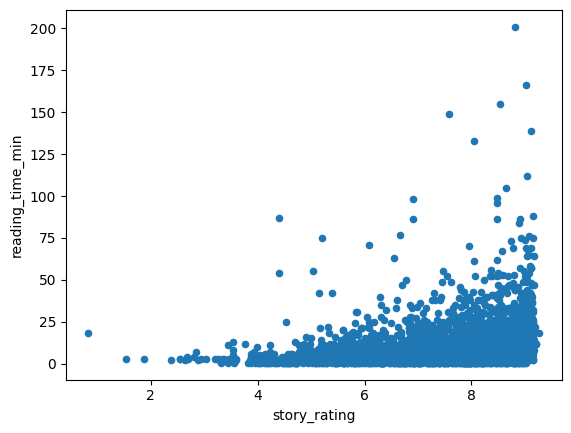

In [70]:
stories_df.plot.scatter(y="reading_time_min", x="story_rating")